In [1249]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [1250]:
df = pd.read_csv('./train.csv')

In [1251]:
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

**Удаляем колонку с именами пассажиров**

In [1252]:
df.drop(columns=['Name'], inplace=True)

**Преобразуем колонку PassengerId так, чтобы осталисть только номера группы, в которой состоит пассажир**

In [1253]:
df['PassengerId'] = df['PassengerId'].str.slice(0, 4)
df = df.astype({'PassengerId': np.int64})
df = df.rename(columns={'PassengerId':'Groups'})
#df.drop(columns=['Groups'], inplace=True)

**Преобразуем колонку Cabin: выделим новую колонку Deck, где укажем палубу, и колонку Side, где укажем сторону корабля**

In [1254]:
df['Deck'] = df['Cabin'].str.slice(0, 1)

In [1255]:
#df['Side'] = df['Cabin'].str.slice(start=-1)

In [1256]:
df.drop(columns=['Cabin'], inplace=True)

**Обрабатываем выбросы**

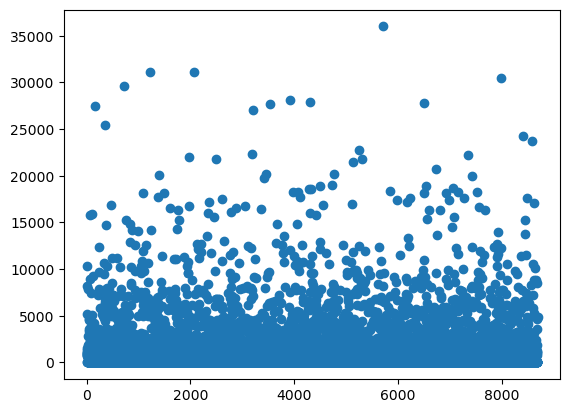

In [1257]:
y = (df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck).to_list()
x = df.index
plt.scatter(x, y)

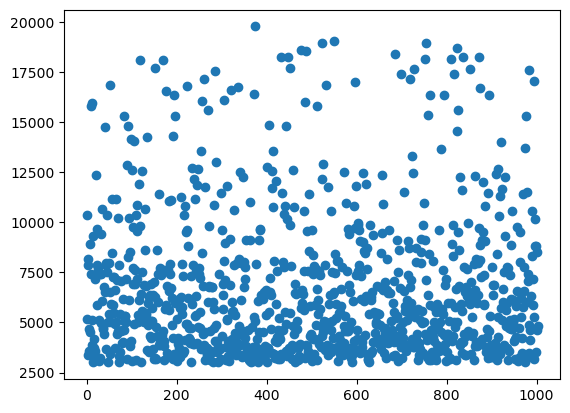

In [1258]:
summ = (df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck).to_numpy()
y = summ[(summ <= 20000) & (summ > 3000)]
x = np.arange(len(y))
plt.scatter(x, y)

In [1259]:
df[df.VRDeck > 14000]

Groups HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
725      768     Europa     False  55 Cancri e  36.0  False         29.0   
3366    3619     Europa     False  TRAPPIST-1e  36.0  False         43.0   
3916    4181     Europa     False  55 Cancri e  31.0  False          2.0   
4311    4594     Europa     False  TRAPPIST-1e  31.0  False          0.0   
5619    5977     Europa     False  55 Cancri e  57.0  False        200.0   
6547    6908     Europa     False  TRAPPIST-1e  60.0  False          0.0   

      FoodCourt  ShoppingMall     Spa   VRDeck  Transported Deck  
725     12180.0           0.0    93.0  17306.0        False    B  
3366        2.0           0.0    14.0  16337.0        False    B  
3916     8747.0           0.0  4840.0  14485.0        False    C  
4311     6670.0         217.0   625.0  20336.0        False    C  
5619        9.0           0.0     NaN  24133.0        False    B  
6547      960.0          46.0   854.0  17074.0        False    C

In [1260]:
df.drop(df[df['RoomService'] >= 9000].index, inplace=True)
df.drop(df[df['FoodCourt'] >= 20000].index, inplace=True)
df.drop(df[df['ShoppingMall'] >= 10000].index, inplace=True)
df.drop(df[df['Spa'] >= 16000].index, inplace=True)
df.drop(df[df['VRDeck'] >= 14000].index, inplace=True)
df.reset_index(drop=True, inplace=True)

### Обрабатываем NaN-ы

In [1261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8672 entries, 0 to 8671
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Groups        8672 non-null   int64  
 1   HomePlanet    8471 non-null   object 
 2   CryoSleep     8455 non-null   object 
 3   Destination   8490 non-null   object 
 4   Age           8493 non-null   float64
 5   VIP           8469 non-null   object 
 6   RoomService   8492 non-null   float64
 7   FoodCourt     8489 non-null   float64
 8   ShoppingMall  8464 non-null   float64
 9   Spa           8490 non-null   float64
 10  VRDeck        8484 non-null   float64
 11  Transported   8672 non-null   bool   
 12  Deck          8474 non-null   object 
dtypes: bool(1), float64(6), int64(1), object(5)
memory usage: 821.6+ KB


**Homeplanet**

In [1262]:
df.groupby(['Deck']).HomePlanet.value_counts()

Deck  HomePlanet
A     Europa         251
B     Europa         755
C     Europa         727
D     Mars           282
      Europa         186
E     Earth          395
      Mars           329
      Europa         128
F     Earth         1614
      Mars          1110
G     Earth         2498
T     Europa           4
Name: HomePlanet, dtype: int64

In [1263]:
df.loc[(df.HomePlanet.isna()) & (df.Deck == 'A'), 'HomePlanet'] = 'Europa'
df.loc[(df.HomePlanet.isna()) & (df.Deck == 'B'), 'HomePlanet'] = 'Europa'
df.loc[(df.HomePlanet.isna()) & (df.Deck == 'C'), 'HomePlanet'] = 'Europa'
df.loc[(df.HomePlanet.isna()) & (df.Deck == 'D'), 'HomePlanet'] = 'Europa'
df.loc[(df.HomePlanet.isna()) & (df.Deck == 'E'), 'HomePlanet'] = 'Earth'
df.loc[(df.HomePlanet.isna()) & (df.Deck == 'F'), 'HomePlanet'] = 'Earth'
df.loc[(df.HomePlanet.isna()) & (df.Deck == 'G'), 'HomePlanet'] = 'Earth'

In [1264]:
df.loc[df.HomePlanet.isna(), 'HomePlanet'] = 'Earth'

**CryoSleep**

In [1265]:
df.groupby(['CryoSleep']).FoodCourt.mean()

CryoSleep
False    681.443293
True       0.000000
Name: FoodCourt, dtype: float64

In [1266]:
df.loc[(df.CryoSleep.isna()) & ((df.RoomService != 0) | (df.FoodCourt != 0) | (df.ShoppingMall != 0) 
                               | (df.Spa != 0) | (df.VRDeck != 0)), 'CryoSleep'] = False
df.loc[df.CryoSleep.isna(), 'CryoSleep'] = True

**Destination**

In [1267]:
df.loc[df.Destination.isna(), 'Destination'] = 'TRAPPIST-1e'

**Age**

In [1268]:
df.groupby(['VIP', 'HomePlanet']).Age.mean()

VIP    HomePlanet
False  Earth         26.162571
       Europa        34.094301
       Mars          29.039702
True   Earth         46.333333
       Europa        38.160305
       Mars          35.564516
Name: Age, dtype: float64

In [1269]:
df.loc[(df.VIP == False) & (df.HomePlanet == 'Earth') & (df.Age.isna()), 'Age'] = df[(df.VIP == False) & 
                                                                                     (df.HomePlanet == 'Earth')].Age.mean()
df.loc[(df.VIP == False) & (df.HomePlanet == 'Europa') & (df.Age.isna()), 'Age'] = df[(df.VIP == False) & 
                                                                                     (df.HomePlanet == 'Europa')].Age.mean()
df.loc[(df.VIP == False) & (df.HomePlanet == 'Mars') & (df.Age.isna()), 'Age'] = df[(df.VIP == False) & 
                                                                                     (df.HomePlanet == 'Mars')].Age.mean()

df.loc[(df.VIP == True) & (df.HomePlanet == 'Earth') & (df.Age.isna()), 'Age'] = df[(df.VIP == True) & 
                                                                                     (df.HomePlanet == 'Earth')].Age.mean()
df.loc[(df.VIP == True) & (df.HomePlanet == 'Europa') & (df.Age.isna()), 'Age'] = df[(df.VIP == True) & 
                                                                                     (df.HomePlanet == 'Europa')].Age.mean()
df.loc[(df.VIP == True) & (df.HomePlanet == 'Mars') & (df.Age.isna()), 'Age'] = df[(df.VIP == True) & 
                                                                                     (df.HomePlanet == 'Mars')].Age.mean()

In [1270]:
df.loc[df.Age.isna(), 'Age'] = df.Age.mean()

**VIP**

In [1271]:
df.groupby(['VIP']).RoomService.describe()

count        mean          std  min  25%  50%    75%     max
VIP                                                                 
False  8100.0  214.647407   616.897141  0.0  0.0  0.0   42.0  8586.0
True    193.0  478.523316  1102.999887  0.0  0.0  0.0  530.0  8243.0

In [1272]:
df.loc[(df.FoodCourt < 56) & (df.VIP.isna()), 'VIP'] = False
df.loc[(df.FoodCourt >= 56) & (df.VIP.isna()), 'VIP'] = True

In [1273]:
df.loc[(df.RoomService < 43) & (df.VIP.isna()), 'VIP'] = False
df.loc[(df.RoomService >= 43) & (df.VIP.isna()), 'VIP'] = True

In [1274]:
df.head()

Groups HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0       1     Europa     False  TRAPPIST-1e  39.0  False          0.0   
1       2      Earth     False  TRAPPIST-1e  24.0  False        109.0   
2       3     Europa     False  TRAPPIST-1e  58.0   True         43.0   
3       3     Europa     False  TRAPPIST-1e  33.0  False          0.0   
4       4      Earth     False  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported Deck  
0        0.0           0.0     0.0     0.0        False    B  
1        9.0          25.0   549.0    44.0         True    F  
2     3576.0           0.0  6715.0    49.0        False    A  
3     1283.0         371.0  3329.0   193.0        False    A  
4       70.0         151.0   565.0     2.0         True    F

**RoomService**

In [1275]:
df.groupby(['VIP']).RoomService.describe()

count        mean          std  min  25%  50%    75%     max
VIP                                                                 
False  8247.0  216.537408   626.415239  0.0  0.0  0.0   42.0  8586.0
True    245.0  416.412245  1000.746151  0.0  0.0  1.0  435.0  8243.0

In [1276]:
df.loc[(df.RoomService.isna()) & (df.CryoSleep == True), 'RoomService'] = 0
df.loc[(df.RoomService.isna()) & (df.CryoSleep == False), 'RoomService'] = df.RoomService.mean()

**FoodCourt**

In [1277]:
df.loc[(df.FoodCourt.isna()) & (df.CryoSleep == True), 'FoodCourt'] = 0
df.loc[(df.FoodCourt.isna()) & (df.CryoSleep == False), 'FoodCourt'] = df.FoodCourt.mean()

**ShoppingMall**

In [1278]:
df.loc[(df.ShoppingMall.isna()) & (df.CryoSleep == True), 'ShoppingMall'] = 0
df.loc[(df.ShoppingMall.isna()) & (df.CryoSleep == False), 'ShoppingMall'] = df.ShoppingMall.mean()

**Spa**

In [1279]:
df.loc[(df.Spa.isna()) & (df.CryoSleep == True), 'Spa'] = 0
df.loc[(df.Spa.isna()) & (df.CryoSleep == False), 'Spa'] = df.Spa.mean()

**VRDeck**

In [1280]:
df.loc[(df.VRDeck.isna()) & (df.CryoSleep == True), 'VRDeck'] = 0
df.loc[(df.VRDeck.isna()) & (df.CryoSleep == False), 'VRDeck'] = df.VRDeck.mean()

**Deck**

In [1281]:
df.groupby(['HomePlanet']).Deck.value_counts()

HomePlanet  Deck
Earth       G       2559
            F       1684
            E        418
            T          1
Europa      B        768
            C        740
            A        255
            D        196
            E        128
            T          4
Mars        F       1110
            E        329
            D        282
Name: Deck, dtype: int64

In [1282]:
df.loc[(df.Deck.isna()) & (df.HomePlanet == 'Earth'), 'Deck'] = 'G'
df.loc[(df.Deck.isna()) & (df.HomePlanet == 'Europa'), 'Deck'] = 'B'
df.loc[(df.Deck.isna()) & (df.HomePlanet == 'Mars'), 'Deck'] = 'F'

In [1283]:
df.RoomService.describe()

count    8672.000000
mean      220.537967
std       634.685477
min         0.000000
25%         0.000000
50%         0.000000
75%        61.000000
max      8586.000000
Name: RoomService, dtype: float64

**Стандартизация и кодирование**

In [1284]:
df = df.astype({'Age': np.int64})
df = df.astype({'RoomService': np.int64})
df = df.astype({'FoodCourt': np.int64})
df = df.astype({'ShoppingMall': np.int64})
df = df.astype({'Spa': np.int64})
df = df.astype({'VRDeck': np.int64})

In [1285]:
df['Summ'] = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck

In [1286]:
df['Summ_Category_1'] = np.array(df['Summ'] == 0, dtype=int)
df['Summ_Category_2'] = np.array((df['Summ'] > 0) & (df['Summ'] <= 600), dtype=int)
df['Summ_Category_3'] = np.array((df['Summ'] > 600) & (df['Summ'] <= 1000), dtype=int)
df['Summ_Category_4'] = np.array((df['Summ'] > 1000) & (df['Summ'] <= 3000), dtype=int)
df['Summ_Category_5'] = np.array((df['Summ'] > 3000) & (df['Summ'] <= 8000), dtype=int)
df['Summ_Category_6'] = np.array((df['Summ'] > 8000), dtype=int)

In [1287]:
df = df.astype({'Summ_Category_1': np.str_, 'Summ_Category_2': np.str_, 'Summ_Category_3': np.str_,
                'Summ_Category_4': np.str_, 'Summ_Category_5': np.str_, 'Summ_Category_6': np.str_})

In [1288]:
df['Summ_Category'] = df.Summ_Category_1 + df.Summ_Category_2 + df.Summ_Category_3 + df.Summ_Category_4 + df.Summ_Category_5 + df.Summ_Category_6 

In [1289]:
df.drop(columns=['Summ_Category_1', 'Summ_Category_2', 'Summ_Category_3', 
                 'Summ_Category_4', 'Summ_Category_5', 'Summ_Category_6'], inplace=True)

In [1290]:
df = df.astype({'Transported': np.int64})
y = df.Transported
df.drop(columns=['Transported'], inplace=True)

In [1291]:
df.loc[df.Summ_Category == '100000', 'Summ_Category'] = 0
df.loc[df.Summ_Category == '010000', 'Summ_Category'] = 1
df.loc[df.Summ_Category == '001000', 'Summ_Category'] = 2
df.loc[df.Summ_Category == '000100', 'Summ_Category'] = 3
df.loc[df.Summ_Category == '000010', 'Summ_Category'] = 4
df.loc[df.Summ_Category == '000001', 'Summ_Category'] = 5

In [1292]:
df = df.astype({'Summ_Category': np.int64})

In [1295]:
df.head()

Groups HomePlanet CryoSleep  Destination  Age    VIP  RoomService  \
0       1     Europa     False  TRAPPIST-1e   39  False            0   
1       2      Earth     False  TRAPPIST-1e   24  False          109   
2       3     Europa     False  TRAPPIST-1e   58   True           43   
3       3     Europa     False  TRAPPIST-1e   33  False            0   
4       4      Earth     False  TRAPPIST-1e   16  False          303   

   FoodCourt  ShoppingMall   Spa  VRDeck Deck  
0          0             0     0       0    B  
1          9            25   549      44    F  
2       3576             0  6715      49    A  
3       1283           371  3329     193    A  
4         70           151   565       2    F

In [1294]:
df.drop(columns=['Summ_Category', 'Summ'], inplace=True)

In [1296]:
real_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Groups', 'Deck']

In [1297]:
scaler = StandardScaler()
scaler_real_cols = pd.DataFrame(scaler.fit_transform(df[real_cols]), columns=scaler.get_feature_names_out())

In [1298]:
label = LabelEncoder()
label_cat_cols = df[cat_cols].apply(LabelEncoder().fit_transform)

In [1299]:
X = pd.concat([scaler_real_cols, label_cat_cols], axis='columns')

In [1300]:
X

Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0     0.710425    -0.347485  -0.299261     -0.328611 -0.284251 -0.282114   
1    -0.335884    -0.175737  -0.293057     -0.278958  0.238759 -0.238955   
2     2.035750    -0.279731   2.165797     -0.328611  6.112859 -0.234051   
3     0.291902    -0.347485   0.585155      0.408232  2.887153 -0.092805   
4    -0.893915     0.129944  -0.251008     -0.028710  0.254001 -0.280152   
...        ...          ...        ...           ...       ...       ...   
8667  0.849933    -0.347485   4.401307     -0.328611  1.280969 -0.209529   
8668 -0.754408    -0.347485  -0.299261     -0.328611 -0.284251 -0.282114   
8669 -0.196376    -0.347485  -0.299261      3.389365 -0.283299 -0.282114   
8670  0.222148    -0.347485   0.423850     -0.328611  0.052038  2.891019   
8671  1.059195    -0.148950   2.932337     -0.328611 -0.284251 -0.270343   

      HomePlanet  CryoSleep  Destination  VIP  Groups  Deck  
0              1          0            2    0       0     1  
1              0          0            2    0       1     5  
2              1          0            2    1       2     0  
3              1          0            2    0       2     0  
4              0          0            2    0       3     5  
...          ...        ...          ...  ...     ...   ...  
8667           1          0            0    1    6206     0  
8668           0          1            1    0    6207     6  
8669           0          0            2    0    6208     6  
8670           1          0            0    0    6209     4  
8671           1          0            2    0    6209     4  

[8672 rows x 12 columns]

In [1301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

**KNN** 35 min

In [44]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 51),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              'p': range(1, 3),
              'metric': ['cityblock', 'cosine', 'euclidean', 'haversine', 'l1', 'l2', 'manhattan', 'nan-euclidean']}
grid_knn = GridSearchCV(knn, params_knn, n_jobs=-1, verbose=2, scoring='accuracy')
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 70400 candidates, totalling 352000 fits


KeyboardInterrupt: 

In [ ]:
grid_knn.best_params_

In [ ]:
grid_knn.best_score_

In [142]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='cosine', n_neighbors=26, p=1, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=2, metric='cosine', n_neighbors=26, p=1)

In [143]:
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7579250720461095


**LogRegressionCV**

In [ ]:
log_cv = LogisticRegressionCV()
params_log_cv = {'penalty': ['l1', 'l2', 'elasticnet'],
                 'fit_intercept': [True, False],
                 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                 'cv': np.arange(4, 11),
                 'max_iter': [100, 200, 250, 300, 400, 500, 500, 700, 750, 800, 900, 1000],
                 'multi_class': ['auto', 'ovr', 'multinomial']}
grid_log_cv = GridSearchCV(log_cv, params_log_cv, n_jobs=-1, verbose=2, scoring='accuracy')
grid_log_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9072 candidates, totalling 45360 fits


In [ ]:
grid_log_cv.best_params_

In [ ]:
grid_log_cv.best_score_

In [148]:
log_cv = LogisticRegressionCV(max_iter=1000)
log_cv.fit(X_train, y_train)

LogisticRegressionCV(max_iter=1000)

In [149]:
y_pred = log_cv.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7780979827089337


**RandomForest** 35 min

In [718]:
rnd_for = RandomForestClassifier()
params_rnd_for = {'n_estimators': range(40, 81),
                  'min_samples_split': [2, 5, 10, 15, 20, 25],
                  'min_samples_leaf': [2, 5, 10, 15, 20, 25],
                  'criterion': ['log_loss']
                 }
grid_rnd_for = GridSearchCV(rnd_for, params_rnd_for, n_jobs=-1, verbose=2, scoring='accuracy')
grid_rnd_for.fit(X, y)

Fitting 5 folds for each of 1476 candidates, totalling 7380 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['log_loss'],
                         'min_samples_leaf': [2, 5, 10, 15, 20, 25],
                         'min_samples_split': [2, 5, 10, 15, 20, 25],
                         'n_estimators': range(40, 81)},
             scoring='accuracy', verbose=2)

In [719]:
grid_rnd_for.best_params_

{'criterion': 'log_loss',
 'min_samples_leaf': 25,
 'min_samples_split': 20,
 'n_estimators': 70}

In [720]:
grid_rnd_for.best_score_

0.7877634925035949

In [722]:
rnd_for = RandomForestClassifier(criterion='log_loss', min_samples_leaf=25, min_samples_split=20, n_estimators=70)
rnd_for.fit(X, y)

RandomForestClassifier(criterion='log_loss', min_samples_leaf=25,
                       min_samples_split=20, n_estimators=70)

In [723]:
y_pred = rnd_for.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8188614146060954


## CatBoost

In [1305]:
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(df, y, stratify=y, test_size=0.2)

In [1302]:
catboost = CatBoostClassifier(cat_features=cat_cols, eval_metric='Accuracy')

In [1190]:
PARAMS = {
    "n_estimators": [1000, 2000, 3000],
    #"learning_rate": [0.01, 0.05, 0.003, 0.1, 0.5],
    "max_depth": [3, 4, 5, 6, 7, 8, 9],
    #"l2_leaf_reg": [0.1, 0.2, 0.3, 0.4, 1.0, 2.0, 3.0, 4.0]
    #"subsample": np.arange(),
    #"grow_policy": ['SymmetricTree', 'Depthwise', 'Lossguide'], 
    #"random_strength": [1, 2, 5],
    #"min_data_in_leaf": [1, 2, 5, 10, 15]
}
catboost.grid_search(PARAMS, df, y, cv=5, refit=True, verbose=True)

0:	learn: 0.7195858	test: 0.7366302	best: 0.7366302 (0)	total: 6.12ms	remaining: 6.11s
1:	learn: 0.7536670	test: 0.7705578	best: 0.7705578 (1)	total: 12.8ms	remaining: 6.38s
2:	learn: 0.7535232	test: 0.7711328	best: 0.7711328 (2)	total: 18.6ms	remaining: 6.2s
3:	learn: 0.7588438	test: 0.7774583	best: 0.7774583 (3)	total: 24ms	remaining: 5.97s
4:	learn: 0.7316652	test: 0.7469810	best: 0.7774583 (3)	total: 30.3ms	remaining: 6.02s
5:	learn: 0.7336785	test: 0.7492812	best: 0.7774583 (3)	total: 36.4ms	remaining: 6.02s
6:	learn: 0.7336785	test: 0.7498562	best: 0.7774583 (3)	total: 42.3ms	remaining: 5.99s
7:	learn: 0.7460454	test: 0.7602070	best: 0.7774583 (3)	total: 48.1ms	remaining: 5.97s
8:	learn: 0.7546736	test: 0.7648074	best: 0.7774583 (3)	total: 53.5ms	remaining: 5.89s
9:	learn: 0.7542422	test: 0.7642323	best: 0.7774583 (3)	total: 59.6ms	remaining: 5.9s
10:	learn: 0.7542422	test: 0.7642323	best: 0.7774583 (3)	total: 65.5ms	remaining: 5.89s
11:	learn: 0.7559678	test: 0.7642323	best: 0.7

99:	learn: 0.7840092	test: 0.7924094	best: 0.7929845 (88)	total: 634ms	remaining: 5.7s
100:	learn: 0.7847282	test: 0.7918344	best: 0.7929845 (88)	total: 641ms	remaining: 5.71s
101:	learn: 0.7845844	test: 0.7918344	best: 0.7929845 (88)	total: 647ms	remaining: 5.7s
102:	learn: 0.7847282	test: 0.7918344	best: 0.7929845 (88)	total: 654ms	remaining: 5.69s
103:	learn: 0.7873167	test: 0.7935595	best: 0.7935595 (103)	total: 660ms	remaining: 5.68s
104:	learn: 0.7870290	test: 0.7935595	best: 0.7935595 (103)	total: 666ms	remaining: 5.67s
105:	learn: 0.7873167	test: 0.7941346	best: 0.7941346 (105)	total: 672ms	remaining: 5.67s
106:	learn: 0.7883233	test: 0.7941346	best: 0.7941346 (105)	total: 678ms	remaining: 5.66s
107:	learn: 0.7880357	test: 0.7935595	best: 0.7941346 (105)	total: 685ms	remaining: 5.66s
108:	learn: 0.7883233	test: 0.7935595	best: 0.7941346 (105)	total: 692ms	remaining: 5.65s
109:	learn: 0.7890423	test: 0.7947096	best: 0.7947096 (109)	total: 698ms	remaining: 5.65s
110:	learn: 0.788

197:	learn: 0.7927811	test: 0.8021852	best: 0.8050604 (181)	total: 1.26s	remaining: 5.11s
198:	learn: 0.7930687	test: 0.8027602	best: 0.8050604 (181)	total: 1.27s	remaining: 5.11s
199:	learn: 0.7927811	test: 0.8027602	best: 0.8050604 (181)	total: 1.27s	remaining: 5.1s
200:	learn: 0.7929249	test: 0.8027602	best: 0.8050604 (181)	total: 1.28s	remaining: 5.1s
201:	learn: 0.7927811	test: 0.8027602	best: 0.8050604 (181)	total: 1.29s	remaining: 5.09s
202:	learn: 0.7927811	test: 0.8027602	best: 0.8050604 (181)	total: 1.29s	remaining: 5.09s
203:	learn: 0.7929249	test: 0.8027602	best: 0.8050604 (181)	total: 1.3s	remaining: 5.08s
204:	learn: 0.7930687	test: 0.8021852	best: 0.8050604 (181)	total: 1.31s	remaining: 5.08s
205:	learn: 0.7930687	test: 0.8021852	best: 0.8050604 (181)	total: 1.31s	remaining: 5.07s
206:	learn: 0.7930687	test: 0.8021852	best: 0.8050604 (181)	total: 1.32s	remaining: 5.06s
207:	learn: 0.7929249	test: 0.8021852	best: 0.8050604 (181)	total: 1.33s	remaining: 5.05s
208:	learn: 0

293:	learn: 0.7958010	test: 0.8004600	best: 0.8050604 (181)	total: 1.89s	remaining: 4.54s
294:	learn: 0.7959448	test: 0.8004600	best: 0.8050604 (181)	total: 1.9s	remaining: 4.54s
295:	learn: 0.7960886	test: 0.8004600	best: 0.8050604 (181)	total: 1.91s	remaining: 4.53s
296:	learn: 0.7960886	test: 0.8004600	best: 0.8050604 (181)	total: 1.91s	remaining: 4.53s
297:	learn: 0.7960886	test: 0.8021852	best: 0.8050604 (181)	total: 1.92s	remaining: 4.52s
298:	learn: 0.7960886	test: 0.8016101	best: 0.8050604 (181)	total: 1.93s	remaining: 4.52s
299:	learn: 0.7960886	test: 0.8021852	best: 0.8050604 (181)	total: 1.93s	remaining: 4.51s
300:	learn: 0.7962324	test: 0.8021852	best: 0.8050604 (181)	total: 1.94s	remaining: 4.5s
301:	learn: 0.7960886	test: 0.8016101	best: 0.8050604 (181)	total: 1.95s	remaining: 4.5s
302:	learn: 0.7962324	test: 0.8016101	best: 0.8050604 (181)	total: 1.95s	remaining: 4.49s
303:	learn: 0.7965200	test: 0.8010351	best: 0.8050604 (181)	total: 1.96s	remaining: 4.48s
304:	learn: 0

387:	learn: 0.7996836	test: 0.8016101	best: 0.8050604 (181)	total: 2.51s	remaining: 3.95s
388:	learn: 0.7996836	test: 0.8016101	best: 0.8050604 (181)	total: 2.51s	remaining: 3.95s
389:	learn: 0.7996836	test: 0.8016101	best: 0.8050604 (181)	total: 2.52s	remaining: 3.94s
390:	learn: 0.7998274	test: 0.8016101	best: 0.8050604 (181)	total: 2.53s	remaining: 3.94s
391:	learn: 0.7998274	test: 0.8016101	best: 0.8050604 (181)	total: 2.53s	remaining: 3.93s
392:	learn: 0.7998274	test: 0.8016101	best: 0.8050604 (181)	total: 2.54s	remaining: 3.92s
393:	learn: 0.7998274	test: 0.8016101	best: 0.8050604 (181)	total: 2.55s	remaining: 3.92s
394:	learn: 0.7998274	test: 0.8016101	best: 0.8050604 (181)	total: 2.55s	remaining: 3.91s
395:	learn: 0.7998274	test: 0.8016101	best: 0.8050604 (181)	total: 2.56s	remaining: 3.9s
396:	learn: 0.7995398	test: 0.8016101	best: 0.8050604 (181)	total: 2.56s	remaining: 3.9s
397:	learn: 0.7995398	test: 0.8021852	best: 0.8050604 (181)	total: 2.57s	remaining: 3.89s
398:	learn: 

509:	learn: 0.8005464	test: 0.8027602	best: 0.8050604 (181)	total: 3.33s	remaining: 3.2s
510:	learn: 0.8005464	test: 0.8027602	best: 0.8050604 (181)	total: 3.33s	remaining: 3.19s
511:	learn: 0.8004026	test: 0.8027602	best: 0.8050604 (181)	total: 3.34s	remaining: 3.18s
512:	learn: 0.8004026	test: 0.8027602	best: 0.8050604 (181)	total: 3.35s	remaining: 3.18s
513:	learn: 0.8002588	test: 0.8027602	best: 0.8050604 (181)	total: 3.35s	remaining: 3.17s
514:	learn: 0.8006903	test: 0.8016101	best: 0.8050604 (181)	total: 3.36s	remaining: 3.17s
515:	learn: 0.8006903	test: 0.8016101	best: 0.8050604 (181)	total: 3.37s	remaining: 3.16s
516:	learn: 0.8005464	test: 0.8016101	best: 0.8050604 (181)	total: 3.38s	remaining: 3.15s
517:	learn: 0.8005464	test: 0.8016101	best: 0.8050604 (181)	total: 3.38s	remaining: 3.15s
518:	learn: 0.8006903	test: 0.8016101	best: 0.8050604 (181)	total: 3.39s	remaining: 3.14s
519:	learn: 0.8008341	test: 0.8016101	best: 0.8050604 (181)	total: 3.39s	remaining: 3.13s
520:	learn:

627:	learn: 0.8011217	test: 0.7993099	best: 0.8050604 (181)	total: 4.15s	remaining: 2.46s
628:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.15s	remaining: 2.45s
629:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.16s	remaining: 2.44s
630:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.17s	remaining: 2.44s
631:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.18s	remaining: 2.43s
632:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.18s	remaining: 2.42s
633:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.19s	remaining: 2.42s
634:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.2s	remaining: 2.41s
635:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.2s	remaining: 2.41s
636:	learn: 0.8008341	test: 0.7998850	best: 0.8050604 (181)	total: 4.21s	remaining: 2.4s
637:	learn: 0.8009779	test: 0.7998850	best: 0.8050604 (181)	total: 4.22s	remaining: 2.39s
638:	learn: 0

744:	learn: 0.8039977	test: 0.7993099	best: 0.8050604 (181)	total: 4.98s	remaining: 1.7s
745:	learn: 0.8038539	test: 0.7993099	best: 0.8050604 (181)	total: 4.99s	remaining: 1.7s
746:	learn: 0.8038539	test: 0.7993099	best: 0.8050604 (181)	total: 4.99s	remaining: 1.69s
747:	learn: 0.8038539	test: 0.7993099	best: 0.8050604 (181)	total: 5s	remaining: 1.68s
748:	learn: 0.8037101	test: 0.7993099	best: 0.8050604 (181)	total: 5s	remaining: 1.68s
749:	learn: 0.8039977	test: 0.7993099	best: 0.8050604 (181)	total: 5.01s	remaining: 1.67s
750:	learn: 0.8041415	test: 0.7993099	best: 0.8050604 (181)	total: 5.02s	remaining: 1.66s
751:	learn: 0.8042853	test: 0.7993099	best: 0.8050604 (181)	total: 5.02s	remaining: 1.66s
752:	learn: 0.8041415	test: 0.7993099	best: 0.8050604 (181)	total: 5.03s	remaining: 1.65s
753:	learn: 0.8041415	test: 0.7993099	best: 0.8050604 (181)	total: 5.04s	remaining: 1.64s
754:	learn: 0.8042853	test: 0.7993099	best: 0.8050604 (181)	total: 5.04s	remaining: 1.64s
755:	learn: 0.8042

838:	learn: 0.8055795	test: 0.8010351	best: 0.8050604 (181)	total: 5.6s	remaining: 1.07s
839:	learn: 0.8057233	test: 0.8010351	best: 0.8050604 (181)	total: 5.6s	remaining: 1.07s
840:	learn: 0.8057233	test: 0.8010351	best: 0.8050604 (181)	total: 5.61s	remaining: 1.06s
841:	learn: 0.8057233	test: 0.8010351	best: 0.8050604 (181)	total: 5.62s	remaining: 1.05s
842:	learn: 0.8057233	test: 0.8010351	best: 0.8050604 (181)	total: 5.62s	remaining: 1.05s
843:	learn: 0.8054357	test: 0.8021852	best: 0.8050604 (181)	total: 5.63s	remaining: 1.04s
844:	learn: 0.8054357	test: 0.8021852	best: 0.8050604 (181)	total: 5.64s	remaining: 1.03s
845:	learn: 0.8055795	test: 0.8016101	best: 0.8050604 (181)	total: 5.64s	remaining: 1.03s
846:	learn: 0.8055795	test: 0.8016101	best: 0.8050604 (181)	total: 5.65s	remaining: 1.02s
847:	learn: 0.8055795	test: 0.8016101	best: 0.8050604 (181)	total: 5.66s	remaining: 1.01s
848:	learn: 0.8057233	test: 0.8016101	best: 0.8050604 (181)	total: 5.66s	remaining: 1.01s
849:	learn: 

954:	learn: 0.8062985	test: 0.8027602	best: 0.8050604 (181)	total: 6.43s	remaining: 303ms
955:	learn: 0.8062985	test: 0.8027602	best: 0.8050604 (181)	total: 6.44s	remaining: 296ms
956:	learn: 0.8062985	test: 0.8027602	best: 0.8050604 (181)	total: 6.45s	remaining: 290ms
957:	learn: 0.8062985	test: 0.8027602	best: 0.8050604 (181)	total: 6.45s	remaining: 283ms
958:	learn: 0.8062985	test: 0.8033353	best: 0.8050604 (181)	total: 6.46s	remaining: 276ms
959:	learn: 0.8062985	test: 0.8033353	best: 0.8050604 (181)	total: 6.46s	remaining: 269ms
960:	learn: 0.8062985	test: 0.8033353	best: 0.8050604 (181)	total: 6.47s	remaining: 263ms
961:	learn: 0.8061547	test: 0.8033353	best: 0.8050604 (181)	total: 6.48s	remaining: 256ms
962:	learn: 0.8061547	test: 0.8033353	best: 0.8050604 (181)	total: 6.49s	remaining: 249ms
963:	learn: 0.8060109	test: 0.8033353	best: 0.8050604 (181)	total: 6.49s	remaining: 243ms
964:	learn: 0.8060109	test: 0.8033353	best: 0.8050604 (181)	total: 6.5s	remaining: 236ms
965:	learn:

75:	learn: 0.7773943	test: 0.7832087	best: 0.7843588 (70)	total: 510ms	remaining: 12.9s
76:	learn: 0.7775381	test: 0.7843588	best: 0.7843588 (70)	total: 518ms	remaining: 12.9s
77:	learn: 0.7776819	test: 0.7843588	best: 0.7843588 (70)	total: 525ms	remaining: 12.9s
78:	learn: 0.7781133	test: 0.7855089	best: 0.7855089 (78)	total: 533ms	remaining: 13s
79:	learn: 0.7781133	test: 0.7843588	best: 0.7855089 (78)	total: 540ms	remaining: 13s
80:	learn: 0.7784009	test: 0.7843588	best: 0.7855089 (78)	total: 547ms	remaining: 13s
81:	learn: 0.7801265	test: 0.7912593	best: 0.7912593 (81)	total: 554ms	remaining: 12.9s
82:	learn: 0.7798389	test: 0.7883841	best: 0.7912593 (81)	total: 561ms	remaining: 13s
83:	learn: 0.7804142	test: 0.7883841	best: 0.7912593 (81)	total: 568ms	remaining: 12.9s
84:	learn: 0.7798389	test: 0.7872340	best: 0.7912593 (81)	total: 574ms	remaining: 12.9s
85:	learn: 0.7807018	test: 0.7901093	best: 0.7912593 (81)	total: 581ms	remaining: 12.9s
86:	learn: 0.7802703	test: 0.7878091	bes

194:	learn: 0.7930687	test: 0.8016101	best: 0.8050604 (181)	total: 1.33s	remaining: 12.3s
195:	learn: 0.7929249	test: 0.8021852	best: 0.8050604 (181)	total: 1.34s	remaining: 12.3s
196:	learn: 0.7926373	test: 0.8021852	best: 0.8050604 (181)	total: 1.34s	remaining: 12.3s
197:	learn: 0.7927811	test: 0.8021852	best: 0.8050604 (181)	total: 1.35s	remaining: 12.3s
198:	learn: 0.7930687	test: 0.8027602	best: 0.8050604 (181)	total: 1.36s	remaining: 12.3s
199:	learn: 0.7927811	test: 0.8027602	best: 0.8050604 (181)	total: 1.36s	remaining: 12.3s
200:	learn: 0.7929249	test: 0.8027602	best: 0.8050604 (181)	total: 1.37s	remaining: 12.3s
201:	learn: 0.7927811	test: 0.8027602	best: 0.8050604 (181)	total: 1.38s	remaining: 12.3s
202:	learn: 0.7927811	test: 0.8027602	best: 0.8050604 (181)	total: 1.39s	remaining: 12.3s
203:	learn: 0.7929249	test: 0.8027602	best: 0.8050604 (181)	total: 1.39s	remaining: 12.3s
204:	learn: 0.7930687	test: 0.8021852	best: 0.8050604 (181)	total: 1.4s	remaining: 12.3s
205:	learn:

313:	learn: 0.7975266	test: 0.7998850	best: 0.8050604 (181)	total: 2.15s	remaining: 11.5s
314:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.16s	remaining: 11.5s
315:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.16s	remaining: 11.5s
316:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.17s	remaining: 11.5s
317:	learn: 0.7972390	test: 0.7993099	best: 0.8050604 (181)	total: 2.18s	remaining: 11.5s
318:	learn: 0.7972390	test: 0.7993099	best: 0.8050604 (181)	total: 2.19s	remaining: 11.5s
319:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.19s	remaining: 11.5s
320:	learn: 0.7970952	test: 0.7993099	best: 0.8050604 (181)	total: 2.2s	remaining: 11.5s
321:	learn: 0.7972390	test: 0.7993099	best: 0.8050604 (181)	total: 2.21s	remaining: 11.5s
322:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.21s	remaining: 11.5s
323:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.22s	remaining: 11.5s
324:	learn:

405:	learn: 0.7999712	test: 0.8021852	best: 0.8050604 (181)	total: 2.78s	remaining: 10.9s
406:	learn: 0.7996836	test: 0.8027602	best: 0.8050604 (181)	total: 2.79s	remaining: 10.9s
407:	learn: 0.7996836	test: 0.8033353	best: 0.8050604 (181)	total: 2.79s	remaining: 10.9s
408:	learn: 0.7996836	test: 0.8033353	best: 0.8050604 (181)	total: 2.8s	remaining: 10.9s
409:	learn: 0.7996836	test: 0.8033353	best: 0.8050604 (181)	total: 2.81s	remaining: 10.9s
410:	learn: 0.7996836	test: 0.8033353	best: 0.8050604 (181)	total: 2.81s	remaining: 10.9s
411:	learn: 0.7995398	test: 0.8033353	best: 0.8050604 (181)	total: 2.82s	remaining: 10.9s
412:	learn: 0.7993960	test: 0.8027602	best: 0.8050604 (181)	total: 2.83s	remaining: 10.9s
413:	learn: 0.7995398	test: 0.8027602	best: 0.8050604 (181)	total: 2.83s	remaining: 10.9s
414:	learn: 0.7995398	test: 0.8033353	best: 0.8050604 (181)	total: 2.84s	remaining: 10.9s
415:	learn: 0.7998274	test: 0.8033353	best: 0.8050604 (181)	total: 2.85s	remaining: 10.8s
416:	learn:

525:	learn: 0.8006903	test: 0.8027602	best: 0.8050604 (181)	total: 3.59s	remaining: 10.1s
526:	learn: 0.8006903	test: 0.8027602	best: 0.8050604 (181)	total: 3.6s	remaining: 10.1s
527:	learn: 0.8008341	test: 0.8010351	best: 0.8050604 (181)	total: 3.61s	remaining: 10.1s
528:	learn: 0.8008341	test: 0.8010351	best: 0.8050604 (181)	total: 3.61s	remaining: 10s
529:	learn: 0.8012655	test: 0.8016101	best: 0.8050604 (181)	total: 3.62s	remaining: 10s
530:	learn: 0.8015531	test: 0.8021852	best: 0.8050604 (181)	total: 3.63s	remaining: 10s
531:	learn: 0.8015531	test: 0.8021852	best: 0.8050604 (181)	total: 3.63s	remaining: 10s
532:	learn: 0.8015531	test: 0.8021852	best: 0.8050604 (181)	total: 3.64s	remaining: 10s
533:	learn: 0.8015531	test: 0.8021852	best: 0.8050604 (181)	total: 3.65s	remaining: 10s
534:	learn: 0.8015531	test: 0.8016101	best: 0.8050604 (181)	total: 3.65s	remaining: 10s
535:	learn: 0.8016969	test: 0.8016101	best: 0.8050604 (181)	total: 3.66s	remaining: 10s
536:	learn: 0.8016969	test:

644:	learn: 0.8011217	test: 0.7993099	best: 0.8050604 (181)	total: 4.43s	remaining: 9.3s
645:	learn: 0.8014093	test: 0.7998850	best: 0.8050604 (181)	total: 4.43s	remaining: 9.29s
646:	learn: 0.8015531	test: 0.7993099	best: 0.8050604 (181)	total: 4.44s	remaining: 9.29s
647:	learn: 0.8015531	test: 0.7993099	best: 0.8050604 (181)	total: 4.45s	remaining: 9.28s
648:	learn: 0.8015531	test: 0.7993099	best: 0.8050604 (181)	total: 4.45s	remaining: 9.27s
649:	learn: 0.8015531	test: 0.7993099	best: 0.8050604 (181)	total: 4.46s	remaining: 9.26s
650:	learn: 0.8016969	test: 0.7993099	best: 0.8050604 (181)	total: 4.47s	remaining: 9.26s
651:	learn: 0.8016969	test: 0.7993099	best: 0.8050604 (181)	total: 4.47s	remaining: 9.25s
652:	learn: 0.8016969	test: 0.7993099	best: 0.8050604 (181)	total: 4.48s	remaining: 9.24s
653:	learn: 0.8016969	test: 0.7993099	best: 0.8050604 (181)	total: 4.49s	remaining: 9.23s
654:	learn: 0.8016969	test: 0.7993099	best: 0.8050604 (181)	total: 4.49s	remaining: 9.22s
655:	learn:

767:	learn: 0.8042853	test: 0.7993099	best: 0.8050604 (181)	total: 5.27s	remaining: 8.45s
768:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.27s	remaining: 8.44s
769:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.28s	remaining: 8.43s
770:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.29s	remaining: 8.43s
771:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.29s	remaining: 8.42s
772:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.3s	remaining: 8.41s
773:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.31s	remaining: 8.41s
774:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.31s	remaining: 8.4s
775:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.32s	remaining: 8.39s
776:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.33s	remaining: 8.39s
777:	learn: 0.8044291	test: 0.7993099	best: 0.8050604 (181)	total: 5.33s	remaining: 8.38s
778:	learn: 

889:	learn: 0.8057233	test: 0.8016101	best: 0.8050604 (181)	total: 6.09s	remaining: 7.59s
890:	learn: 0.8058671	test: 0.8021852	best: 0.8050604 (181)	total: 6.1s	remaining: 7.59s
891:	learn: 0.8058671	test: 0.8021852	best: 0.8050604 (181)	total: 6.1s	remaining: 7.58s
892:	learn: 0.8057233	test: 0.8021852	best: 0.8050604 (181)	total: 6.11s	remaining: 7.57s
893:	learn: 0.8057233	test: 0.8021852	best: 0.8050604 (181)	total: 6.12s	remaining: 7.57s
894:	learn: 0.8057233	test: 0.8021852	best: 0.8050604 (181)	total: 6.12s	remaining: 7.56s
895:	learn: 0.8058671	test: 0.8021852	best: 0.8050604 (181)	total: 6.13s	remaining: 7.55s
896:	learn: 0.8060109	test: 0.8021852	best: 0.8050604 (181)	total: 6.14s	remaining: 7.55s
897:	learn: 0.8060109	test: 0.8021852	best: 0.8050604 (181)	total: 6.14s	remaining: 7.54s
898:	learn: 0.8058671	test: 0.8021852	best: 0.8050604 (181)	total: 6.15s	remaining: 7.54s
899:	learn: 0.8058671	test: 0.8021852	best: 0.8050604 (181)	total: 6.16s	remaining: 7.53s
900:	learn: 

985:	learn: 0.8064423	test: 0.8033353	best: 0.8050604 (181)	total: 6.74s	remaining: 6.93s
986:	learn: 0.8064423	test: 0.8033353	best: 0.8050604 (181)	total: 6.75s	remaining: 6.92s
987:	learn: 0.8064423	test: 0.8039103	best: 0.8050604 (181)	total: 6.75s	remaining: 6.92s
988:	learn: 0.8064423	test: 0.8039103	best: 0.8050604 (181)	total: 6.76s	remaining: 6.91s
989:	learn: 0.8064423	test: 0.8039103	best: 0.8050604 (181)	total: 6.77s	remaining: 6.9s
990:	learn: 0.8064423	test: 0.8039103	best: 0.8050604 (181)	total: 6.77s	remaining: 6.9s
991:	learn: 0.8064423	test: 0.8050604	best: 0.8050604 (181)	total: 6.78s	remaining: 6.89s
992:	learn: 0.8065861	test: 0.8050604	best: 0.8050604 (181)	total: 6.79s	remaining: 6.88s
993:	learn: 0.8067299	test: 0.8044853	best: 0.8050604 (181)	total: 6.79s	remaining: 6.88s
994:	learn: 0.8067299	test: 0.8044853	best: 0.8050604 (181)	total: 6.8s	remaining: 6.87s
995:	learn: 0.8067299	test: 0.8039103	best: 0.8050604 (181)	total: 6.81s	remaining: 6.86s
996:	learn: 0

1077:	learn: 0.8101812	test: 0.8044853	best: 0.8056354 (1012)	total: 7.37s	remaining: 6.3s
1078:	learn: 0.8103250	test: 0.8044853	best: 0.8056354 (1012)	total: 7.37s	remaining: 6.29s
1079:	learn: 0.8103250	test: 0.8044853	best: 0.8056354 (1012)	total: 7.38s	remaining: 6.29s
1080:	learn: 0.8104688	test: 0.8044853	best: 0.8056354 (1012)	total: 7.39s	remaining: 6.28s
1081:	learn: 0.8100374	test: 0.8044853	best: 0.8056354 (1012)	total: 7.39s	remaining: 6.27s
1082:	learn: 0.8100374	test: 0.8044853	best: 0.8056354 (1012)	total: 7.4s	remaining: 6.27s
1083:	learn: 0.8100374	test: 0.8044853	best: 0.8056354 (1012)	total: 7.41s	remaining: 6.26s
1084:	learn: 0.8100374	test: 0.8050604	best: 0.8056354 (1012)	total: 7.41s	remaining: 6.25s
1085:	learn: 0.8100374	test: 0.8050604	best: 0.8056354 (1012)	total: 7.42s	remaining: 6.25s
1086:	learn: 0.8101812	test: 0.8044853	best: 0.8056354 (1012)	total: 7.43s	remaining: 6.24s
1087:	learn: 0.8101812	test: 0.8044853	best: 0.8056354 (1012)	total: 7.43s	remaini

1167:	learn: 0.8107564	test: 0.8044853	best: 0.8056354 (1012)	total: 7.98s	remaining: 5.68s
1168:	learn: 0.8106126	test: 0.8044853	best: 0.8056354 (1012)	total: 7.99s	remaining: 5.68s
1169:	learn: 0.8107564	test: 0.8044853	best: 0.8056354 (1012)	total: 7.99s	remaining: 5.67s
1170:	learn: 0.8109002	test: 0.8044853	best: 0.8056354 (1012)	total: 8s	remaining: 5.66s
1171:	learn: 0.8109002	test: 0.8044853	best: 0.8056354 (1012)	total: 8.01s	remaining: 5.66s
1172:	learn: 0.8110440	test: 0.8044853	best: 0.8056354 (1012)	total: 8.01s	remaining: 5.65s
1173:	learn: 0.8111878	test: 0.8044853	best: 0.8056354 (1012)	total: 8.02s	remaining: 5.64s
1174:	learn: 0.8114754	test: 0.8044853	best: 0.8056354 (1012)	total: 8.03s	remaining: 5.64s
1175:	learn: 0.8114754	test: 0.8044853	best: 0.8056354 (1012)	total: 8.04s	remaining: 5.63s
1176:	learn: 0.8114754	test: 0.8044853	best: 0.8056354 (1012)	total: 8.04s	remaining: 5.62s
1177:	learn: 0.8116192	test: 0.8044853	best: 0.8056354 (1012)	total: 8.05s	remainin

1287:	learn: 0.8127696	test: 0.8062105	best: 0.8067855 (1235)	total: 8.82s	remaining: 4.87s
1288:	learn: 0.8127696	test: 0.8062105	best: 0.8067855 (1235)	total: 8.82s	remaining: 4.87s
1289:	learn: 0.8126258	test: 0.8062105	best: 0.8067855 (1235)	total: 8.83s	remaining: 4.86s
1290:	learn: 0.8126258	test: 0.8062105	best: 0.8067855 (1235)	total: 8.84s	remaining: 4.85s
1291:	learn: 0.8126258	test: 0.8062105	best: 0.8067855 (1235)	total: 8.85s	remaining: 4.85s
1292:	learn: 0.8124820	test: 0.8062105	best: 0.8067855 (1235)	total: 8.85s	remaining: 4.84s
1293:	learn: 0.8124820	test: 0.8062105	best: 0.8067855 (1235)	total: 8.86s	remaining: 4.83s
1294:	learn: 0.8124820	test: 0.8062105	best: 0.8067855 (1235)	total: 8.86s	remaining: 4.83s
1295:	learn: 0.8123382	test: 0.8062105	best: 0.8067855 (1235)	total: 8.87s	remaining: 4.82s
1296:	learn: 0.8126258	test: 0.8062105	best: 0.8067855 (1235)	total: 8.88s	remaining: 4.81s
1297:	learn: 0.8126258	test: 0.8062105	best: 0.8067855 (1235)	total: 8.88s	remai

1377:	learn: 0.8143515	test: 0.8073606	best: 0.8073606 (1308)	total: 9.44s	remaining: 4.26s
1378:	learn: 0.8153581	test: 0.8090857	best: 0.8090857 (1378)	total: 9.45s	remaining: 4.25s
1379:	learn: 0.8156457	test: 0.8090857	best: 0.8090857 (1378)	total: 9.45s	remaining: 4.25s
1380:	learn: 0.8159333	test: 0.8090857	best: 0.8090857 (1378)	total: 9.46s	remaining: 4.24s
1381:	learn: 0.8159333	test: 0.8090857	best: 0.8090857 (1378)	total: 9.47s	remaining: 4.23s
1382:	learn: 0.8156457	test: 0.8090857	best: 0.8090857 (1378)	total: 9.47s	remaining: 4.23s
1383:	learn: 0.8157895	test: 0.8090857	best: 0.8090857 (1378)	total: 9.48s	remaining: 4.22s
1384:	learn: 0.8159333	test: 0.8085106	best: 0.8090857 (1378)	total: 9.49s	remaining: 4.21s
1385:	learn: 0.8159333	test: 0.8085106	best: 0.8090857 (1378)	total: 9.49s	remaining: 4.21s
1386:	learn: 0.8159333	test: 0.8085106	best: 0.8090857 (1378)	total: 9.5s	remaining: 4.2s
1387:	learn: 0.8159333	test: 0.8090857	best: 0.8090857 (1378)	total: 9.51s	remaini

1496:	learn: 0.8178027	test: 0.8108108	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.45s
1497:	learn: 0.8178027	test: 0.8108108	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.44s
1498:	learn: 0.8176589	test: 0.8108108	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.43s
1499:	learn: 0.8176589	test: 0.8108108	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.43s
1500:	learn: 0.8176589	test: 0.8108108	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.42s
1501:	learn: 0.8176589	test: 0.8108108	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.41s
1502:	learn: 0.8178027	test: 0.8113859	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.41s
1503:	learn: 0.8178027	test: 0.8113859	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.4s
1504:	learn: 0.8178027	test: 0.8113859	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.39s
1505:	learn: 0.8176589	test: 0.8113859	best: 0.8113859 (1482)	total: 10.3s	remaining: 3.38s
1506:	learn: 0.8176589	test: 0.8113859	best: 0.8113859 (1482)	total: 10.3s	remain

1589:	learn: 0.8188093	test: 0.8102358	best: 0.8113859 (1482)	total: 10.9s	remaining: 2.81s
1590:	learn: 0.8188093	test: 0.8102358	best: 0.8113859 (1482)	total: 10.9s	remaining: 2.8s
1591:	learn: 0.8186655	test: 0.8102358	best: 0.8113859 (1482)	total: 10.9s	remaining: 2.79s
1592:	learn: 0.8186655	test: 0.8102358	best: 0.8113859 (1482)	total: 10.9s	remaining: 2.79s
1593:	learn: 0.8188093	test: 0.8102358	best: 0.8113859 (1482)	total: 10.9s	remaining: 2.78s
1594:	learn: 0.8188093	test: 0.8102358	best: 0.8113859 (1482)	total: 10.9s	remaining: 2.77s
1595:	learn: 0.8188093	test: 0.8102358	best: 0.8113859 (1482)	total: 10.9s	remaining: 2.77s
1596:	learn: 0.8185217	test: 0.8102358	best: 0.8113859 (1482)	total: 10.9s	remaining: 2.76s
1597:	learn: 0.8185217	test: 0.8113859	best: 0.8113859 (1482)	total: 10.9s	remaining: 2.75s
1598:	learn: 0.8185217	test: 0.8113859	best: 0.8113859 (1482)	total: 11s	remaining: 2.75s
1599:	learn: 0.8185217	test: 0.8113859	best: 0.8113859 (1482)	total: 11s	remaining:

1708:	learn: 0.8199597	test: 0.8131110	best: 0.8131110 (1704)	total: 11.7s	remaining: 1.99s
1709:	learn: 0.8199597	test: 0.8131110	best: 0.8131110 (1704)	total: 11.7s	remaining: 1.99s
1710:	learn: 0.8198159	test: 0.8131110	best: 0.8131110 (1704)	total: 11.7s	remaining: 1.98s
1711:	learn: 0.8198159	test: 0.8131110	best: 0.8131110 (1704)	total: 11.7s	remaining: 1.97s
1712:	learn: 0.8201035	test: 0.8131110	best: 0.8131110 (1704)	total: 11.7s	remaining: 1.97s
1713:	learn: 0.8201035	test: 0.8131110	best: 0.8131110 (1704)	total: 11.7s	remaining: 1.96s
1714:	learn: 0.8201035	test: 0.8131110	best: 0.8131110 (1704)	total: 11.8s	remaining: 1.95s
1715:	learn: 0.8201035	test: 0.8131110	best: 0.8131110 (1704)	total: 11.8s	remaining: 1.95s
1716:	learn: 0.8199597	test: 0.8131110	best: 0.8131110 (1704)	total: 11.8s	remaining: 1.94s
1717:	learn: 0.8199597	test: 0.8131110	best: 0.8131110 (1704)	total: 11.8s	remaining: 1.93s
1718:	learn: 0.8199597	test: 0.8131110	best: 0.8131110 (1704)	total: 11.8s	remai

1799:	learn: 0.8208225	test: 0.8119609	best: 0.8131110 (1704)	total: 12.3s	remaining: 1.37s
1800:	learn: 0.8208225	test: 0.8119609	best: 0.8131110 (1704)	total: 12.3s	remaining: 1.36s
1801:	learn: 0.8208225	test: 0.8113859	best: 0.8131110 (1704)	total: 12.4s	remaining: 1.36s
1802:	learn: 0.8208225	test: 0.8113859	best: 0.8131110 (1704)	total: 12.4s	remaining: 1.35s
1803:	learn: 0.8208225	test: 0.8113859	best: 0.8131110 (1704)	total: 12.4s	remaining: 1.34s
1804:	learn: 0.8208225	test: 0.8113859	best: 0.8131110 (1704)	total: 12.4s	remaining: 1.34s
1805:	learn: 0.8208225	test: 0.8113859	best: 0.8131110 (1704)	total: 12.4s	remaining: 1.33s
1806:	learn: 0.8209664	test: 0.8113859	best: 0.8131110 (1704)	total: 12.4s	remaining: 1.32s
1807:	learn: 0.8209664	test: 0.8113859	best: 0.8131110 (1704)	total: 12.4s	remaining: 1.32s
1808:	learn: 0.8211102	test: 0.8113859	best: 0.8131110 (1704)	total: 12.4s	remaining: 1.31s
1809:	learn: 0.8209664	test: 0.8113859	best: 0.8131110 (1704)	total: 12.4s	remai

1889:	learn: 0.8222606	test: 0.8119609	best: 0.8131110 (1704)	total: 13s	remaining: 754ms
1890:	learn: 0.8222606	test: 0.8119609	best: 0.8131110 (1704)	total: 13s	remaining: 747ms
1891:	learn: 0.8222606	test: 0.8119609	best: 0.8131110 (1704)	total: 13s	remaining: 740ms
1892:	learn: 0.8221168	test: 0.8119609	best: 0.8131110 (1704)	total: 13s	remaining: 734ms
1893:	learn: 0.8222606	test: 0.8119609	best: 0.8131110 (1704)	total: 13s	remaining: 727ms
1894:	learn: 0.8222606	test: 0.8119609	best: 0.8131110 (1704)	total: 13s	remaining: 720ms
1895:	learn: 0.8222606	test: 0.8113859	best: 0.8131110 (1704)	total: 13s	remaining: 713ms
1896:	learn: 0.8222606	test: 0.8113859	best: 0.8131110 (1704)	total: 13s	remaining: 706ms
1897:	learn: 0.8222606	test: 0.8113859	best: 0.8131110 (1704)	total: 13s	remaining: 700ms
1898:	learn: 0.8222606	test: 0.8113859	best: 0.8131110 (1704)	total: 13s	remaining: 693ms
1899:	learn: 0.8221168	test: 0.8113859	best: 0.8131110 (1704)	total: 13s	remaining: 686ms
1900:	lear

6:	learn: 0.7336785	test: 0.7498562	best: 0.7774583 (3)	total: 43.8ms	remaining: 18.7s
7:	learn: 0.7460454	test: 0.7602070	best: 0.7774583 (3)	total: 50.5ms	remaining: 18.9s
8:	learn: 0.7546736	test: 0.7648074	best: 0.7774583 (3)	total: 56.3ms	remaining: 18.7s
9:	learn: 0.7542422	test: 0.7642323	best: 0.7774583 (3)	total: 62.3ms	remaining: 18.6s
10:	learn: 0.7542422	test: 0.7642323	best: 0.7774583 (3)	total: 68.9ms	remaining: 18.7s
11:	learn: 0.7559678	test: 0.7642323	best: 0.7774583 (3)	total: 74.9ms	remaining: 18.6s
12:	learn: 0.7561116	test: 0.7642323	best: 0.7774583 (3)	total: 80.9ms	remaining: 18.6s
13:	learn: 0.7525165	test: 0.7648074	best: 0.7774583 (3)	total: 87.4ms	remaining: 18.6s
14:	learn: 0.7523727	test: 0.7648074	best: 0.7774583 (3)	total: 93.2ms	remaining: 18.5s
15:	learn: 0.7525165	test: 0.7648074	best: 0.7774583 (3)	total: 99.3ms	remaining: 18.5s
16:	learn: 0.7525165	test: 0.7648074	best: 0.7774583 (3)	total: 106ms	remaining: 18.6s
17:	learn: 0.7561116	test: 0.7642323	

127:	learn: 0.7894737	test: 0.7970098	best: 0.7987349 (118)	total: 863ms	remaining: 19.4s
128:	learn: 0.7894737	test: 0.7964347	best: 0.7987349 (118)	total: 870ms	remaining: 19.4s
129:	learn: 0.7894737	test: 0.7964347	best: 0.7987349 (118)	total: 876ms	remaining: 19.3s
130:	learn: 0.7896175	test: 0.7970098	best: 0.7987349 (118)	total: 883ms	remaining: 19.3s
131:	learn: 0.7900489	test: 0.7970098	best: 0.7987349 (118)	total: 889ms	remaining: 19.3s
132:	learn: 0.7900489	test: 0.7970098	best: 0.7987349 (118)	total: 896ms	remaining: 19.3s
133:	learn: 0.7900489	test: 0.7975848	best: 0.7987349 (118)	total: 903ms	remaining: 19.3s
134:	learn: 0.7894737	test: 0.7987349	best: 0.7987349 (118)	total: 910ms	remaining: 19.3s
135:	learn: 0.7896175	test: 0.7998850	best: 0.7998850 (135)	total: 917ms	remaining: 19.3s
136:	learn: 0.7896175	test: 0.7998850	best: 0.7998850 (135)	total: 923ms	remaining: 19.3s
137:	learn: 0.7890423	test: 0.8004600	best: 0.8004600 (137)	total: 930ms	remaining: 19.3s
138:	learn

219:	learn: 0.7943630	test: 0.8021852	best: 0.8050604 (181)	total: 1.48s	remaining: 18.7s
220:	learn: 0.7943630	test: 0.8016101	best: 0.8050604 (181)	total: 1.49s	remaining: 18.7s
221:	learn: 0.7947944	test: 0.7998850	best: 0.8050604 (181)	total: 1.49s	remaining: 18.7s
222:	learn: 0.7947944	test: 0.8004600	best: 0.8050604 (181)	total: 1.5s	remaining: 18.7s
223:	learn: 0.7943630	test: 0.8004600	best: 0.8050604 (181)	total: 1.51s	remaining: 18.7s
224:	learn: 0.7945068	test: 0.8004600	best: 0.8050604 (181)	total: 1.51s	remaining: 18.7s
225:	learn: 0.7946506	test: 0.8010351	best: 0.8050604 (181)	total: 1.52s	remaining: 18.7s
226:	learn: 0.7947944	test: 0.8010351	best: 0.8050604 (181)	total: 1.53s	remaining: 18.6s
227:	learn: 0.7949382	test: 0.7998850	best: 0.8050604 (181)	total: 1.53s	remaining: 18.6s
228:	learn: 0.7950820	test: 0.8010351	best: 0.8050604 (181)	total: 1.54s	remaining: 18.6s
229:	learn: 0.7949382	test: 0.8010351	best: 0.8050604 (181)	total: 1.55s	remaining: 18.6s
230:	learn:

312:	learn: 0.7973828	test: 0.8010351	best: 0.8050604 (181)	total: 2.11s	remaining: 18.1s
313:	learn: 0.7975266	test: 0.7998850	best: 0.8050604 (181)	total: 2.11s	remaining: 18.1s
314:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.12s	remaining: 18.1s
315:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.13s	remaining: 18.1s
316:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.13s	remaining: 18.1s
317:	learn: 0.7972390	test: 0.7993099	best: 0.8050604 (181)	total: 2.14s	remaining: 18.1s
318:	learn: 0.7972390	test: 0.7993099	best: 0.8050604 (181)	total: 2.15s	remaining: 18s
319:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.15s	remaining: 18s
320:	learn: 0.7970952	test: 0.7993099	best: 0.8050604 (181)	total: 2.16s	remaining: 18s
321:	learn: 0.7972390	test: 0.7993099	best: 0.8050604 (181)	total: 2.17s	remaining: 18s
322:	learn: 0.7975266	test: 0.7993099	best: 0.8050604 (181)	total: 2.17s	remaining: 18s
323:	learn: 0.797526

404:	learn: 0.7996836	test: 0.8021852	best: 0.8050604 (181)	total: 2.73s	remaining: 17.5s
405:	learn: 0.7999712	test: 0.8021852	best: 0.8050604 (181)	total: 2.75s	remaining: 17.5s
406:	learn: 0.7996836	test: 0.8027602	best: 0.8050604 (181)	total: 2.75s	remaining: 17.5s
407:	learn: 0.7996836	test: 0.8033353	best: 0.8050604 (181)	total: 2.76s	remaining: 17.5s
408:	learn: 0.7996836	test: 0.8033353	best: 0.8050604 (181)	total: 2.77s	remaining: 17.5s
409:	learn: 0.7996836	test: 0.8033353	best: 0.8050604 (181)	total: 2.77s	remaining: 17.5s
410:	learn: 0.7996836	test: 0.8033353	best: 0.8050604 (181)	total: 2.78s	remaining: 17.5s
411:	learn: 0.7995398	test: 0.8033353	best: 0.8050604 (181)	total: 2.79s	remaining: 17.5s
412:	learn: 0.7993960	test: 0.8027602	best: 0.8050604 (181)	total: 2.79s	remaining: 17.5s
413:	learn: 0.7995398	test: 0.8027602	best: 0.8050604 (181)	total: 2.8s	remaining: 17.5s
414:	learn: 0.7995398	test: 0.8033353	best: 0.8050604 (181)	total: 2.81s	remaining: 17.5s
415:	learn:

497:	learn: 0.8006903	test: 0.8033353	best: 0.8050604 (181)	total: 3.36s	remaining: 16.9s
498:	learn: 0.8005464	test: 0.8027602	best: 0.8050604 (181)	total: 3.36s	remaining: 16.9s
499:	learn: 0.8005464	test: 0.8027602	best: 0.8050604 (181)	total: 3.37s	remaining: 16.9s
500:	learn: 0.8005464	test: 0.8027602	best: 0.8050604 (181)	total: 3.38s	remaining: 16.9s
501:	learn: 0.8005464	test: 0.8027602	best: 0.8050604 (181)	total: 3.38s	remaining: 16.8s
502:	learn: 0.8006903	test: 0.8033353	best: 0.8050604 (181)	total: 3.39s	remaining: 16.8s
503:	learn: 0.8006903	test: 0.8033353	best: 0.8050604 (181)	total: 3.4s	remaining: 16.8s
504:	learn: 0.8006903	test: 0.8027602	best: 0.8050604 (181)	total: 3.4s	remaining: 16.8s
505:	learn: 0.8005464	test: 0.8027602	best: 0.8050604 (181)	total: 3.41s	remaining: 16.8s
506:	learn: 0.8005464	test: 0.8027602	best: 0.8050604 (181)	total: 3.42s	remaining: 16.8s
507:	learn: 0.8005464	test: 0.8027602	best: 0.8050604 (181)	total: 3.42s	remaining: 16.8s
508:	learn: 

619:	learn: 0.8014093	test: 0.7993099	best: 0.8050604 (181)	total: 4.18s	remaining: 16s
620:	learn: 0.8012655	test: 0.7993099	best: 0.8050604 (181)	total: 4.19s	remaining: 16s
621:	learn: 0.8012655	test: 0.7993099	best: 0.8050604 (181)	total: 4.19s	remaining: 16s
622:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.2s	remaining: 16s
623:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.21s	remaining: 16s
624:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.21s	remaining: 16s
625:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.22s	remaining: 16s
626:	learn: 0.8011217	test: 0.7993099	best: 0.8050604 (181)	total: 4.22s	remaining: 16s
627:	learn: 0.8011217	test: 0.7993099	best: 0.8050604 (181)	total: 4.23s	remaining: 16s
628:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.24s	remaining: 16s
629:	learn: 0.8009779	test: 0.7993099	best: 0.8050604 (181)	total: 4.25s	remaining: 16s
630:	learn: 0.8009779	test: 0.799

741:	learn: 0.8039977	test: 0.7987349	best: 0.8050604 (181)	total: 5s	remaining: 15.2s
742:	learn: 0.8039977	test: 0.7987349	best: 0.8050604 (181)	total: 5.01s	remaining: 15.2s
743:	learn: 0.8039977	test: 0.7987349	best: 0.8050604 (181)	total: 5.01s	remaining: 15.2s
744:	learn: 0.8039977	test: 0.7993099	best: 0.8050604 (181)	total: 5.02s	remaining: 15.2s
745:	learn: 0.8038539	test: 0.7993099	best: 0.8050604 (181)	total: 5.03s	remaining: 15.2s
746:	learn: 0.8038539	test: 0.7993099	best: 0.8050604 (181)	total: 5.03s	remaining: 15.2s
747:	learn: 0.8038539	test: 0.7993099	best: 0.8050604 (181)	total: 5.04s	remaining: 15.2s
748:	learn: 0.8037101	test: 0.7993099	best: 0.8050604 (181)	total: 5.05s	remaining: 15.2s
749:	learn: 0.8039977	test: 0.7993099	best: 0.8050604 (181)	total: 5.05s	remaining: 15.2s
750:	learn: 0.8041415	test: 0.7993099	best: 0.8050604 (181)	total: 5.06s	remaining: 15.2s
751:	learn: 0.8042853	test: 0.7993099	best: 0.8050604 (181)	total: 5.07s	remaining: 15.1s
752:	learn: 0

833:	learn: 0.8054357	test: 0.8010351	best: 0.8050604 (181)	total: 5.62s	remaining: 14.6s
834:	learn: 0.8054357	test: 0.8010351	best: 0.8050604 (181)	total: 5.63s	remaining: 14.6s
835:	learn: 0.8057233	test: 0.8004600	best: 0.8050604 (181)	total: 5.63s	remaining: 14.6s
836:	learn: 0.8057233	test: 0.8004600	best: 0.8050604 (181)	total: 5.64s	remaining: 14.6s
837:	learn: 0.8057233	test: 0.8004600	best: 0.8050604 (181)	total: 5.65s	remaining: 14.6s
838:	learn: 0.8055795	test: 0.8010351	best: 0.8050604 (181)	total: 5.66s	remaining: 14.6s
839:	learn: 0.8057233	test: 0.8010351	best: 0.8050604 (181)	total: 5.66s	remaining: 14.6s
840:	learn: 0.8057233	test: 0.8010351	best: 0.8050604 (181)	total: 5.67s	remaining: 14.6s
841:	learn: 0.8057233	test: 0.8010351	best: 0.8050604 (181)	total: 5.68s	remaining: 14.6s
842:	learn: 0.8057233	test: 0.8010351	best: 0.8050604 (181)	total: 5.68s	remaining: 14.5s
843:	learn: 0.8054357	test: 0.8021852	best: 0.8050604 (181)	total: 5.69s	remaining: 14.5s
844:	learn

953:	learn: 0.8062985	test: 0.8027602	best: 0.8050604 (181)	total: 6.44s	remaining: 13.8s
954:	learn: 0.8062985	test: 0.8027602	best: 0.8050604 (181)	total: 6.45s	remaining: 13.8s
955:	learn: 0.8062985	test: 0.8027602	best: 0.8050604 (181)	total: 6.46s	remaining: 13.8s
956:	learn: 0.8062985	test: 0.8027602	best: 0.8050604 (181)	total: 6.46s	remaining: 13.8s
957:	learn: 0.8062985	test: 0.8027602	best: 0.8050604 (181)	total: 6.47s	remaining: 13.8s
958:	learn: 0.8062985	test: 0.8033353	best: 0.8050604 (181)	total: 6.48s	remaining: 13.8s
959:	learn: 0.8062985	test: 0.8033353	best: 0.8050604 (181)	total: 6.49s	remaining: 13.8s
960:	learn: 0.8062985	test: 0.8033353	best: 0.8050604 (181)	total: 6.5s	remaining: 13.8s
961:	learn: 0.8061547	test: 0.8033353	best: 0.8050604 (181)	total: 6.5s	remaining: 13.8s
962:	learn: 0.8061547	test: 0.8033353	best: 0.8050604 (181)	total: 6.51s	remaining: 13.8s
963:	learn: 0.8060109	test: 0.8033353	best: 0.8050604 (181)	total: 6.52s	remaining: 13.8s
964:	learn: 

1070:	learn: 0.8094622	test: 0.8050604	best: 0.8056354 (1012)	total: 7.28s	remaining: 13.1s
1071:	learn: 0.8094622	test: 0.8050604	best: 0.8056354 (1012)	total: 7.28s	remaining: 13.1s
1072:	learn: 0.8093184	test: 0.8050604	best: 0.8056354 (1012)	total: 7.29s	remaining: 13.1s
1073:	learn: 0.8093184	test: 0.8050604	best: 0.8056354 (1012)	total: 7.3s	remaining: 13.1s
1074:	learn: 0.8093184	test: 0.8050604	best: 0.8056354 (1012)	total: 7.3s	remaining: 13.1s
1075:	learn: 0.8091746	test: 0.8044853	best: 0.8056354 (1012)	total: 7.31s	remaining: 13.1s
1076:	learn: 0.8094622	test: 0.8044853	best: 0.8056354 (1012)	total: 7.32s	remaining: 13.1s
1077:	learn: 0.8101812	test: 0.8044853	best: 0.8056354 (1012)	total: 7.32s	remaining: 13.1s
1078:	learn: 0.8103250	test: 0.8044853	best: 0.8056354 (1012)	total: 7.33s	remaining: 13.1s
1079:	learn: 0.8103250	test: 0.8044853	best: 0.8056354 (1012)	total: 7.34s	remaining: 13s
1080:	learn: 0.8104688	test: 0.8044853	best: 0.8056354 (1012)	total: 7.34s	remaining

1161:	learn: 0.8107564	test: 0.8039103	best: 0.8056354 (1012)	total: 7.89s	remaining: 12.5s
1162:	learn: 0.8107564	test: 0.8039103	best: 0.8056354 (1012)	total: 7.9s	remaining: 12.5s
1163:	learn: 0.8107564	test: 0.8039103	best: 0.8056354 (1012)	total: 7.9s	remaining: 12.5s
1164:	learn: 0.8107564	test: 0.8039103	best: 0.8056354 (1012)	total: 7.91s	remaining: 12.5s
1165:	learn: 0.8107564	test: 0.8044853	best: 0.8056354 (1012)	total: 7.92s	remaining: 12.5s
1166:	learn: 0.8107564	test: 0.8044853	best: 0.8056354 (1012)	total: 7.92s	remaining: 12.4s
1167:	learn: 0.8107564	test: 0.8044853	best: 0.8056354 (1012)	total: 7.93s	remaining: 12.4s
1168:	learn: 0.8106126	test: 0.8044853	best: 0.8056354 (1012)	total: 7.94s	remaining: 12.4s
1169:	learn: 0.8107564	test: 0.8044853	best: 0.8056354 (1012)	total: 7.94s	remaining: 12.4s
1170:	learn: 0.8109002	test: 0.8044853	best: 0.8056354 (1012)	total: 7.95s	remaining: 12.4s
1171:	learn: 0.8109002	test: 0.8044853	best: 0.8056354 (1012)	total: 7.96s	remaini

1251:	learn: 0.8120506	test: 0.8056354	best: 0.8067855 (1235)	total: 8.5s	remaining: 11.9s
1252:	learn: 0.8120506	test: 0.8056354	best: 0.8067855 (1235)	total: 8.51s	remaining: 11.9s
1253:	learn: 0.8121944	test: 0.8056354	best: 0.8067855 (1235)	total: 8.52s	remaining: 11.9s
1254:	learn: 0.8121944	test: 0.8056354	best: 0.8067855 (1235)	total: 8.52s	remaining: 11.9s
1255:	learn: 0.8121944	test: 0.8056354	best: 0.8067855 (1235)	total: 8.53s	remaining: 11.8s
1256:	learn: 0.8120506	test: 0.8056354	best: 0.8067855 (1235)	total: 8.54s	remaining: 11.8s
1257:	learn: 0.8120506	test: 0.8056354	best: 0.8067855 (1235)	total: 8.54s	remaining: 11.8s
1258:	learn: 0.8120506	test: 0.8056354	best: 0.8067855 (1235)	total: 8.55s	remaining: 11.8s
1259:	learn: 0.8123382	test: 0.8056354	best: 0.8067855 (1235)	total: 8.56s	remaining: 11.8s
1260:	learn: 0.8123382	test: 0.8062105	best: 0.8067855 (1235)	total: 8.57s	remaining: 11.8s
1261:	learn: 0.8124820	test: 0.8056354	best: 0.8067855 (1235)	total: 8.57s	remain

1366:	learn: 0.8140638	test: 0.8062105	best: 0.8073606 (1308)	total: 9.31s	remaining: 11.1s
1367:	learn: 0.8140638	test: 0.8062105	best: 0.8073606 (1308)	total: 9.32s	remaining: 11.1s
1368:	learn: 0.8140638	test: 0.8062105	best: 0.8073606 (1308)	total: 9.33s	remaining: 11.1s
1369:	learn: 0.8140638	test: 0.8062105	best: 0.8073606 (1308)	total: 9.34s	remaining: 11.1s
1370:	learn: 0.8140638	test: 0.8073606	best: 0.8073606 (1308)	total: 9.35s	remaining: 11.1s
1371:	learn: 0.8140638	test: 0.8073606	best: 0.8073606 (1308)	total: 9.35s	remaining: 11.1s
1372:	learn: 0.8140638	test: 0.8073606	best: 0.8073606 (1308)	total: 9.36s	remaining: 11.1s
1373:	learn: 0.8140638	test: 0.8073606	best: 0.8073606 (1308)	total: 9.37s	remaining: 11.1s
1374:	learn: 0.8140638	test: 0.8073606	best: 0.8073606 (1308)	total: 9.37s	remaining: 11.1s
1375:	learn: 0.8142077	test: 0.8073606	best: 0.8073606 (1308)	total: 9.38s	remaining: 11.1s
1376:	learn: 0.8142077	test: 0.8073606	best: 0.8073606 (1308)	total: 9.39s	remai

1456:	learn: 0.8169399	test: 0.8102358	best: 0.8102358 (1406)	total: 9.93s	remaining: 10.5s
1457:	learn: 0.8169399	test: 0.8102358	best: 0.8102358 (1406)	total: 9.94s	remaining: 10.5s
1458:	learn: 0.8169399	test: 0.8102358	best: 0.8102358 (1406)	total: 9.95s	remaining: 10.5s
1459:	learn: 0.8169399	test: 0.8102358	best: 0.8102358 (1406)	total: 9.96s	remaining: 10.5s
1460:	learn: 0.8169399	test: 0.8102358	best: 0.8102358 (1406)	total: 9.96s	remaining: 10.5s
1461:	learn: 0.8169399	test: 0.8102358	best: 0.8102358 (1406)	total: 9.97s	remaining: 10.5s
1462:	learn: 0.8169399	test: 0.8102358	best: 0.8102358 (1406)	total: 9.97s	remaining: 10.5s
1463:	learn: 0.8169399	test: 0.8102358	best: 0.8102358 (1406)	total: 9.98s	remaining: 10.5s
1464:	learn: 0.8169399	test: 0.8102358	best: 0.8102358 (1406)	total: 9.99s	remaining: 10.5s
1465:	learn: 0.8170837	test: 0.8102358	best: 0.8102358 (1406)	total: 9.99s	remaining: 10.5s
1466:	learn: 0.8170837	test: 0.8102358	best: 0.8102358 (1406)	total: 10s	remaini

1547:	learn: 0.8185217	test: 0.8096607	best: 0.8113859 (1482)	total: 10.5s	remaining: 9.89s
1548:	learn: 0.8185217	test: 0.8096607	best: 0.8113859 (1482)	total: 10.6s	remaining: 9.89s
1549:	learn: 0.8185217	test: 0.8096607	best: 0.8113859 (1482)	total: 10.6s	remaining: 9.88s
1550:	learn: 0.8185217	test: 0.8096607	best: 0.8113859 (1482)	total: 10.6s	remaining: 9.87s
1551:	learn: 0.8183779	test: 0.8090857	best: 0.8113859 (1482)	total: 10.6s	remaining: 9.87s
1552:	learn: 0.8185217	test: 0.8090857	best: 0.8113859 (1482)	total: 10.6s	remaining: 9.86s
1553:	learn: 0.8185217	test: 0.8090857	best: 0.8113859 (1482)	total: 10.6s	remaining: 9.85s
1554:	learn: 0.8186655	test: 0.8096607	best: 0.8113859 (1482)	total: 10.6s	remaining: 9.85s
1555:	learn: 0.8186655	test: 0.8096607	best: 0.8113859 (1482)	total: 10.6s	remaining: 9.84s
1556:	learn: 0.8186655	test: 0.8096607	best: 0.8113859 (1482)	total: 10.6s	remaining: 9.83s
1557:	learn: 0.8186655	test: 0.8096607	best: 0.8113859 (1482)	total: 10.6s	remai

1666:	learn: 0.8196721	test: 0.8113859	best: 0.8113859 (1482)	total: 11.4s	remaining: 9.09s
1667:	learn: 0.8195283	test: 0.8113859	best: 0.8113859 (1482)	total: 11.4s	remaining: 9.08s
1668:	learn: 0.8195283	test: 0.8113859	best: 0.8113859 (1482)	total: 11.4s	remaining: 9.07s
1669:	learn: 0.8195283	test: 0.8113859	best: 0.8113859 (1482)	total: 11.4s	remaining: 9.07s
1670:	learn: 0.8195283	test: 0.8119609	best: 0.8119609 (1670)	total: 11.4s	remaining: 9.06s
1671:	learn: 0.8195283	test: 0.8119609	best: 0.8119609 (1670)	total: 11.4s	remaining: 9.05s
1672:	learn: 0.8195283	test: 0.8113859	best: 0.8119609 (1670)	total: 11.4s	remaining: 9.05s
1673:	learn: 0.8195283	test: 0.8113859	best: 0.8119609 (1670)	total: 11.4s	remaining: 9.04s
1674:	learn: 0.8195283	test: 0.8113859	best: 0.8119609 (1670)	total: 11.4s	remaining: 9.04s
1675:	learn: 0.8196721	test: 0.8113859	best: 0.8119609 (1670)	total: 11.4s	remaining: 9.03s
1676:	learn: 0.8196721	test: 0.8119609	best: 0.8119609 (1670)	total: 11.4s	remai

1756:	learn: 0.8205349	test: 0.8119609	best: 0.8131110 (1704)	total: 12s	remaining: 8.48s
1757:	learn: 0.8206787	test: 0.8119609	best: 0.8131110 (1704)	total: 12s	remaining: 8.47s
1758:	learn: 0.8206787	test: 0.8119609	best: 0.8131110 (1704)	total: 12s	remaining: 8.46s
1759:	learn: 0.8205349	test: 0.8108108	best: 0.8131110 (1704)	total: 12s	remaining: 8.46s
1760:	learn: 0.8205349	test: 0.8113859	best: 0.8131110 (1704)	total: 12s	remaining: 8.45s
1761:	learn: 0.8206787	test: 0.8119609	best: 0.8131110 (1704)	total: 12s	remaining: 8.44s
1762:	learn: 0.8205349	test: 0.8119609	best: 0.8131110 (1704)	total: 12s	remaining: 8.44s
1763:	learn: 0.8205349	test: 0.8119609	best: 0.8131110 (1704)	total: 12s	remaining: 8.43s
1764:	learn: 0.8206787	test: 0.8119609	best: 0.8131110 (1704)	total: 12s	remaining: 8.42s
1765:	learn: 0.8206787	test: 0.8119609	best: 0.8131110 (1704)	total: 12s	remaining: 8.41s
1766:	learn: 0.8206787	test: 0.8119609	best: 0.8131110 (1704)	total: 12.1s	remaining: 8.41s
1767:	le

1867:	learn: 0.8219730	test: 0.8113859	best: 0.8131110 (1704)	total: 12.8s	remaining: 7.76s
1868:	learn: 0.8219730	test: 0.8113859	best: 0.8131110 (1704)	total: 12.8s	remaining: 7.75s
1869:	learn: 0.8219730	test: 0.8113859	best: 0.8131110 (1704)	total: 12.8s	remaining: 7.74s
1870:	learn: 0.8219730	test: 0.8113859	best: 0.8131110 (1704)	total: 12.8s	remaining: 7.74s
1871:	learn: 0.8221168	test: 0.8113859	best: 0.8131110 (1704)	total: 12.8s	remaining: 7.73s
1872:	learn: 0.8219730	test: 0.8113859	best: 0.8131110 (1704)	total: 12.8s	remaining: 7.72s
1873:	learn: 0.8221168	test: 0.8113859	best: 0.8131110 (1704)	total: 12.8s	remaining: 7.72s
1874:	learn: 0.8222606	test: 0.8119609	best: 0.8131110 (1704)	total: 12.9s	remaining: 7.71s
1875:	learn: 0.8221168	test: 0.8119609	best: 0.8131110 (1704)	total: 12.9s	remaining: 7.71s
1876:	learn: 0.8224044	test: 0.8119609	best: 0.8131110 (1704)	total: 12.9s	remaining: 7.7s
1877:	learn: 0.8222606	test: 0.8119609	best: 0.8131110 (1704)	total: 12.9s	remain

1983:	learn: 0.8222606	test: 0.8125359	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.99s
1984:	learn: 0.8222606	test: 0.8119609	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.98s
1985:	learn: 0.8222606	test: 0.8125359	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.98s
1986:	learn: 0.8221168	test: 0.8125359	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.97s
1987:	learn: 0.8221168	test: 0.8125359	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.97s
1988:	learn: 0.8221168	test: 0.8125359	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.96s
1989:	learn: 0.8221168	test: 0.8125359	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.96s
1990:	learn: 0.8221168	test: 0.8125359	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.95s
1991:	learn: 0.8221168	test: 0.8125359	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.95s
1992:	learn: 0.8219730	test: 0.8113859	best: 0.8131110 (1704)	total: 13.7s	remaining: 6.94s
1993:	learn: 0.8219730	test: 0.8113859	best: 0.8131110 (1704)	total: 13.7s	remai

2102:	learn: 0.8225482	test: 0.8108108	best: 0.8131110 (1704)	total: 14.5s	remaining: 6.18s
2103:	learn: 0.8225482	test: 0.8108108	best: 0.8131110 (1704)	total: 14.5s	remaining: 6.17s
2104:	learn: 0.8225482	test: 0.8108108	best: 0.8131110 (1704)	total: 14.5s	remaining: 6.17s
2105:	learn: 0.8225482	test: 0.8108108	best: 0.8131110 (1704)	total: 14.5s	remaining: 6.16s
2106:	learn: 0.8228358	test: 0.8108108	best: 0.8131110 (1704)	total: 14.5s	remaining: 6.15s
2107:	learn: 0.8228358	test: 0.8108108	best: 0.8131110 (1704)	total: 14.5s	remaining: 6.14s
2108:	learn: 0.8229796	test: 0.8108108	best: 0.8131110 (1704)	total: 14.5s	remaining: 6.14s
2109:	learn: 0.8229796	test: 0.8108108	best: 0.8131110 (1704)	total: 14.5s	remaining: 6.13s
2110:	learn: 0.8229796	test: 0.8108108	best: 0.8131110 (1704)	total: 14.5s	remaining: 6.12s
2111:	learn: 0.8231234	test: 0.8108108	best: 0.8131110 (1704)	total: 14.6s	remaining: 6.12s
2112:	learn: 0.8231234	test: 0.8108108	best: 0.8131110 (1704)	total: 14.6s	remai

2211:	learn: 0.8239862	test: 0.8102358	best: 0.8131110 (1704)	total: 15.3s	remaining: 5.46s
2212:	learn: 0.8239862	test: 0.8102358	best: 0.8131110 (1704)	total: 15.3s	remaining: 5.46s
2213:	learn: 0.8239862	test: 0.8102358	best: 0.8131110 (1704)	total: 15.3s	remaining: 5.45s
2214:	learn: 0.8242738	test: 0.8102358	best: 0.8131110 (1704)	total: 15.4s	remaining: 5.44s
2215:	learn: 0.8242738	test: 0.8102358	best: 0.8131110 (1704)	total: 15.4s	remaining: 5.43s
2216:	learn: 0.8241300	test: 0.8102358	best: 0.8131110 (1704)	total: 15.4s	remaining: 5.43s
2217:	learn: 0.8241300	test: 0.8102358	best: 0.8131110 (1704)	total: 15.4s	remaining: 5.42s
2218:	learn: 0.8242738	test: 0.8102358	best: 0.8131110 (1704)	total: 15.4s	remaining: 5.42s
2219:	learn: 0.8244176	test: 0.8102358	best: 0.8131110 (1704)	total: 15.4s	remaining: 5.41s
2220:	learn: 0.8245614	test: 0.8102358	best: 0.8131110 (1704)	total: 15.4s	remaining: 5.4s
2221:	learn: 0.8244176	test: 0.8102358	best: 0.8131110 (1704)	total: 15.4s	remain

2316:	learn: 0.8259994	test: 0.8102358	best: 0.8131110 (1704)	total: 16.4s	remaining: 4.84s
2317:	learn: 0.8257118	test: 0.8102358	best: 0.8131110 (1704)	total: 16.4s	remaining: 4.83s
2318:	learn: 0.8258556	test: 0.8102358	best: 0.8131110 (1704)	total: 16.4s	remaining: 4.82s
2319:	learn: 0.8258556	test: 0.8102358	best: 0.8131110 (1704)	total: 16.4s	remaining: 4.82s
2320:	learn: 0.8258556	test: 0.8102358	best: 0.8131110 (1704)	total: 16.4s	remaining: 4.81s
2321:	learn: 0.8258556	test: 0.8102358	best: 0.8131110 (1704)	total: 16.5s	remaining: 4.8s
2322:	learn: 0.8258556	test: 0.8108108	best: 0.8131110 (1704)	total: 16.5s	remaining: 4.8s
2323:	learn: 0.8259994	test: 0.8108108	best: 0.8131110 (1704)	total: 16.5s	remaining: 4.79s
2324:	learn: 0.8259994	test: 0.8108108	best: 0.8131110 (1704)	total: 16.5s	remaining: 4.79s
2325:	learn: 0.8259994	test: 0.8108108	best: 0.8131110 (1704)	total: 16.5s	remaining: 4.78s
2326:	learn: 0.8258556	test: 0.8108108	best: 0.8131110 (1704)	total: 16.5s	remaini

2417:	learn: 0.8271498	test: 0.8102358	best: 0.8131110 (1704)	total: 17.2s	remaining: 4.15s
2418:	learn: 0.8271498	test: 0.8102358	best: 0.8131110 (1704)	total: 17.2s	remaining: 4.14s
2419:	learn: 0.8271498	test: 0.8102358	best: 0.8131110 (1704)	total: 17.3s	remaining: 4.13s
2420:	learn: 0.8271498	test: 0.8102358	best: 0.8131110 (1704)	total: 17.3s	remaining: 4.13s
2421:	learn: 0.8271498	test: 0.8108108	best: 0.8131110 (1704)	total: 17.3s	remaining: 4.12s
2422:	learn: 0.8271498	test: 0.8108108	best: 0.8131110 (1704)	total: 17.3s	remaining: 4.11s
2423:	learn: 0.8271498	test: 0.8108108	best: 0.8131110 (1704)	total: 17.3s	remaining: 4.11s
2424:	learn: 0.8271498	test: 0.8108108	best: 0.8131110 (1704)	total: 17.3s	remaining: 4.1s
2425:	learn: 0.8272936	test: 0.8108108	best: 0.8131110 (1704)	total: 17.3s	remaining: 4.09s
2426:	learn: 0.8272936	test: 0.8108108	best: 0.8131110 (1704)	total: 17.3s	remaining: 4.09s
2427:	learn: 0.8272936	test: 0.8108108	best: 0.8131110 (1704)	total: 17.3s	remain

2526:	learn: 0.8283003	test: 0.8096607	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.38s
2527:	learn: 0.8283003	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.37s
2528:	learn: 0.8283003	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.37s
2529:	learn: 0.8283003	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.36s
2530:	learn: 0.8283003	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.35s
2531:	learn: 0.8283003	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.35s
2532:	learn: 0.8284441	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.34s
2533:	learn: 0.8284441	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.33s
2534:	learn: 0.8283003	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.33s
2535:	learn: 0.8280127	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remaining: 3.32s
2536:	learn: 0.8280127	test: 0.8090857	best: 0.8131110 (1704)	total: 18.1s	remai

2632:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 18.9s	remaining: 2.63s
2633:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 18.9s	remaining: 2.63s
2634:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 18.9s	remaining: 2.62s
2635:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 18.9s	remaining: 2.61s
2636:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 18.9s	remaining: 2.6s
2637:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 18.9s	remaining: 2.6s
2638:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 18.9s	remaining: 2.59s
2639:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 18.9s	remaining: 2.58s
2640:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 19s	remaining: 2.58s
2641:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 19s	remaining: 2.57s
2642:	learn: 0.8291631	test: 0.8090857	best: 0.8131110 (1704)	total: 19s	remaining: 2.

2722:	learn: 0.8294507	test: 0.8108108	best: 0.8131110 (1704)	total: 19.5s	remaining: 1.98s
2723:	learn: 0.8294507	test: 0.8108108	best: 0.8131110 (1704)	total: 19.5s	remaining: 1.98s
2724:	learn: 0.8294507	test: 0.8108108	best: 0.8131110 (1704)	total: 19.5s	remaining: 1.97s
2725:	learn: 0.8295945	test: 0.8108108	best: 0.8131110 (1704)	total: 19.5s	remaining: 1.96s
2726:	learn: 0.8295945	test: 0.8102358	best: 0.8131110 (1704)	total: 19.5s	remaining: 1.96s
2727:	learn: 0.8295945	test: 0.8102358	best: 0.8131110 (1704)	total: 19.5s	remaining: 1.95s
2728:	learn: 0.8295945	test: 0.8102358	best: 0.8131110 (1704)	total: 19.6s	remaining: 1.94s
2729:	learn: 0.8297383	test: 0.8102358	best: 0.8131110 (1704)	total: 19.6s	remaining: 1.93s
2730:	learn: 0.8295945	test: 0.8102358	best: 0.8131110 (1704)	total: 19.6s	remaining: 1.93s
2731:	learn: 0.8295945	test: 0.8108108	best: 0.8131110 (1704)	total: 19.6s	remaining: 1.92s
2732:	learn: 0.8295945	test: 0.8108108	best: 0.8131110 (1704)	total: 19.6s	remai

2842:	learn: 0.8303135	test: 0.8090857	best: 0.8131110 (1704)	total: 20.3s	remaining: 1.12s
2843:	learn: 0.8303135	test: 0.8090857	best: 0.8131110 (1704)	total: 20.3s	remaining: 1.11s
2844:	learn: 0.8303135	test: 0.8090857	best: 0.8131110 (1704)	total: 20.3s	remaining: 1.11s
2845:	learn: 0.8303135	test: 0.8090857	best: 0.8131110 (1704)	total: 20.4s	remaining: 1.1s
2846:	learn: 0.8303135	test: 0.8090857	best: 0.8131110 (1704)	total: 20.4s	remaining: 1.09s
2847:	learn: 0.8303135	test: 0.8090857	best: 0.8131110 (1704)	total: 20.4s	remaining: 1.09s
2848:	learn: 0.8303135	test: 0.8090857	best: 0.8131110 (1704)	total: 20.4s	remaining: 1.08s
2849:	learn: 0.8303135	test: 0.8085106	best: 0.8131110 (1704)	total: 20.4s	remaining: 1.07s
2850:	learn: 0.8303135	test: 0.8085106	best: 0.8131110 (1704)	total: 20.4s	remaining: 1.06s
2851:	learn: 0.8303135	test: 0.8085106	best: 0.8131110 (1704)	total: 20.4s	remaining: 1.06s
2852:	learn: 0.8301697	test: 0.8085106	best: 0.8131110 (1704)	total: 20.4s	remain

2955:	learn: 0.8318953	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 315ms
2956:	learn: 0.8318953	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 308ms
2957:	learn: 0.8320391	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 301ms
2958:	learn: 0.8318953	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 294ms
2959:	learn: 0.8320391	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 286ms
2960:	learn: 0.8320391	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 279ms
2961:	learn: 0.8320391	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 272ms
2962:	learn: 0.8317515	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 265ms
2963:	learn: 0.8317515	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 258ms
2964:	learn: 0.8318953	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remaining: 251ms
2965:	learn: 0.8320391	test: 0.8096607	best: 0.8131110 (1704)	total: 21.2s	remai

57:	learn: 0.7886109	test: 0.7975848	best: 0.7975848 (57)	total: 578ms	remaining: 9.39s
58:	learn: 0.7891861	test: 0.7970098	best: 0.7975848 (57)	total: 589ms	remaining: 9.4s
59:	learn: 0.7891861	test: 0.7964347	best: 0.7975848 (57)	total: 599ms	remaining: 9.38s
60:	learn: 0.7890423	test: 0.7970098	best: 0.7975848 (57)	total: 609ms	remaining: 9.37s
61:	learn: 0.7886109	test: 0.7970098	best: 0.7975848 (57)	total: 618ms	remaining: 9.35s
62:	learn: 0.7888985	test: 0.7970098	best: 0.7975848 (57)	total: 629ms	remaining: 9.36s
63:	learn: 0.7888985	test: 0.7964347	best: 0.7975848 (57)	total: 640ms	remaining: 9.37s
64:	learn: 0.7890423	test: 0.7958597	best: 0.7975848 (57)	total: 649ms	remaining: 9.34s
65:	learn: 0.7896175	test: 0.7975848	best: 0.7975848 (57)	total: 660ms	remaining: 9.34s
66:	learn: 0.7896175	test: 0.7964347	best: 0.7975848 (57)	total: 671ms	remaining: 9.34s
67:	learn: 0.7894737	test: 0.7958597	best: 0.7975848 (57)	total: 680ms	remaining: 9.32s
68:	learn: 0.7896175	test: 0.7958

171:	learn: 0.7968076	test: 0.8033353	best: 0.8039103 (82)	total: 1.65s	remaining: 7.93s
172:	learn: 0.7968076	test: 0.8033353	best: 0.8039103 (82)	total: 1.66s	remaining: 7.92s
173:	learn: 0.7966638	test: 0.8033353	best: 0.8039103 (82)	total: 1.67s	remaining: 7.91s
174:	learn: 0.7968076	test: 0.8033353	best: 0.8039103 (82)	total: 1.67s	remaining: 7.9s
175:	learn: 0.7963762	test: 0.8039103	best: 0.8039103 (82)	total: 1.68s	remaining: 7.88s
176:	learn: 0.7968076	test: 0.8039103	best: 0.8039103 (82)	total: 1.69s	remaining: 7.86s
177:	learn: 0.7968076	test: 0.8039103	best: 0.8039103 (82)	total: 1.7s	remaining: 7.85s
178:	learn: 0.7968076	test: 0.8027602	best: 0.8039103 (82)	total: 1.71s	remaining: 7.83s
179:	learn: 0.7968076	test: 0.8021852	best: 0.8039103 (82)	total: 1.72s	remaining: 7.82s
180:	learn: 0.7965200	test: 0.8021852	best: 0.8039103 (82)	total: 1.72s	remaining: 7.8s
181:	learn: 0.7966638	test: 0.8021852	best: 0.8039103 (82)	total: 1.73s	remaining: 7.79s
182:	learn: 0.7966638	te

274:	learn: 0.7978142	test: 0.8016101	best: 0.8039103 (82)	total: 2.49s	remaining: 6.58s
275:	learn: 0.7978142	test: 0.8016101	best: 0.8039103 (82)	total: 2.5s	remaining: 6.57s
276:	learn: 0.7978142	test: 0.8016101	best: 0.8039103 (82)	total: 2.51s	remaining: 6.56s
277:	learn: 0.7978142	test: 0.8016101	best: 0.8039103 (82)	total: 2.52s	remaining: 6.55s
278:	learn: 0.7976704	test: 0.8021852	best: 0.8039103 (82)	total: 2.53s	remaining: 6.54s
279:	learn: 0.7976704	test: 0.8021852	best: 0.8039103 (82)	total: 2.54s	remaining: 6.53s
280:	learn: 0.7976704	test: 0.8021852	best: 0.8039103 (82)	total: 2.55s	remaining: 6.52s
281:	learn: 0.7978142	test: 0.8021852	best: 0.8039103 (82)	total: 2.55s	remaining: 6.5s
282:	learn: 0.7979580	test: 0.8021852	best: 0.8039103 (82)	total: 2.56s	remaining: 6.49s
283:	learn: 0.7979580	test: 0.8021852	best: 0.8039103 (82)	total: 2.57s	remaining: 6.48s
284:	learn: 0.7979580	test: 0.8021852	best: 0.8039103 (82)	total: 2.58s	remaining: 6.47s
285:	learn: 0.7979580	t

371:	learn: 0.8004026	test: 0.8021852	best: 0.8039103 (82)	total: 3.32s	remaining: 5.61s
372:	learn: 0.8004026	test: 0.8021852	best: 0.8039103 (82)	total: 3.33s	remaining: 5.6s
373:	learn: 0.8002588	test: 0.8021852	best: 0.8039103 (82)	total: 3.34s	remaining: 5.59s
374:	learn: 0.8002588	test: 0.8021852	best: 0.8039103 (82)	total: 3.35s	remaining: 5.58s
375:	learn: 0.8004026	test: 0.8021852	best: 0.8039103 (82)	total: 3.36s	remaining: 5.58s
376:	learn: 0.8005464	test: 0.8021852	best: 0.8039103 (82)	total: 3.37s	remaining: 5.57s
377:	learn: 0.8005464	test: 0.8021852	best: 0.8039103 (82)	total: 3.38s	remaining: 5.56s
378:	learn: 0.8006903	test: 0.8021852	best: 0.8039103 (82)	total: 3.39s	remaining: 5.56s
379:	learn: 0.8006903	test: 0.8021852	best: 0.8039103 (82)	total: 3.4s	remaining: 5.54s
380:	learn: 0.8006903	test: 0.8021852	best: 0.8039103 (82)	total: 3.41s	remaining: 5.54s
381:	learn: 0.8006903	test: 0.8021852	best: 0.8039103 (82)	total: 3.42s	remaining: 5.53s
382:	learn: 0.8006903	t

469:	learn: 0.8048605	test: 0.8027602	best: 0.8044853 (395)	total: 4.16s	remaining: 4.69s
470:	learn: 0.8047167	test: 0.8021852	best: 0.8044853 (395)	total: 4.17s	remaining: 4.68s
471:	learn: 0.8048605	test: 0.8021852	best: 0.8044853 (395)	total: 4.18s	remaining: 4.67s
472:	learn: 0.8048605	test: 0.8021852	best: 0.8044853 (395)	total: 4.19s	remaining: 4.66s
473:	learn: 0.8048605	test: 0.8027602	best: 0.8044853 (395)	total: 4.2s	remaining: 4.66s
474:	learn: 0.8048605	test: 0.8021852	best: 0.8044853 (395)	total: 4.2s	remaining: 4.65s
475:	learn: 0.8051481	test: 0.8027602	best: 0.8044853 (395)	total: 4.21s	remaining: 4.64s
476:	learn: 0.8052919	test: 0.8021852	best: 0.8044853 (395)	total: 4.22s	remaining: 4.63s
477:	learn: 0.8052919	test: 0.8021852	best: 0.8044853 (395)	total: 4.23s	remaining: 4.62s
478:	learn: 0.8052919	test: 0.8021852	best: 0.8044853 (395)	total: 4.24s	remaining: 4.61s
479:	learn: 0.8055795	test: 0.8021852	best: 0.8044853 (395)	total: 4.25s	remaining: 4.6s
480:	learn: 0

568:	learn: 0.8081680	test: 0.8039103	best: 0.8044853 (395)	total: 5s	remaining: 3.78s
569:	learn: 0.8081680	test: 0.8039103	best: 0.8044853 (395)	total: 5s	remaining: 3.78s
570:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 5.01s	remaining: 3.77s
571:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 5.02s	remaining: 3.76s
572:	learn: 0.8083118	test: 0.8033353	best: 0.8044853 (395)	total: 5.03s	remaining: 3.75s
573:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 5.04s	remaining: 3.74s
574:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 5.04s	remaining: 3.73s
575:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 5.05s	remaining: 3.72s
576:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 5.06s	remaining: 3.71s
577:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 5.07s	remaining: 3.7s
578:	learn: 0.8084556	test: 0.8039103	best: 0.8044853 (395)	total: 5.08s	remaining: 3.69s
579:	learn: 0.808

668:	learn: 0.8109002	test: 0.8039103	best: 0.8044853 (395)	total: 5.83s	remaining: 2.88s
669:	learn: 0.8107564	test: 0.8039103	best: 0.8044853 (395)	total: 5.84s	remaining: 2.88s
670:	learn: 0.8109002	test: 0.8039103	best: 0.8044853 (395)	total: 5.85s	remaining: 2.87s
671:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.86s	remaining: 2.86s
672:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.86s	remaining: 2.85s
673:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.87s	remaining: 2.84s
674:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.88s	remaining: 2.83s
675:	learn: 0.8111878	test: 0.8044853	best: 0.8044853 (395)	total: 5.89s	remaining: 2.82s
676:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.9s	remaining: 2.81s
677:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.9s	remaining: 2.8s
678:	learn: 0.8114754	test: 0.8039103	best: 0.8044853 (395)	total: 5.91s	remaining: 2.79s
679:	learn: 0

767:	learn: 0.8156457	test: 0.8021852	best: 0.8050604 (694)	total: 6.65s	remaining: 2.01s
768:	learn: 0.8156457	test: 0.8021852	best: 0.8050604 (694)	total: 6.66s	remaining: 2s
769:	learn: 0.8165085	test: 0.8033353	best: 0.8050604 (694)	total: 6.67s	remaining: 1.99s
770:	learn: 0.8163647	test: 0.8033353	best: 0.8050604 (694)	total: 6.68s	remaining: 1.98s
771:	learn: 0.8162209	test: 0.8033353	best: 0.8050604 (694)	total: 6.69s	remaining: 1.97s
772:	learn: 0.8163647	test: 0.8033353	best: 0.8050604 (694)	total: 6.7s	remaining: 1.97s
773:	learn: 0.8166523	test: 0.8033353	best: 0.8050604 (694)	total: 6.7s	remaining: 1.96s
774:	learn: 0.8166523	test: 0.8033353	best: 0.8050604 (694)	total: 6.71s	remaining: 1.95s
775:	learn: 0.8163647	test: 0.8033353	best: 0.8050604 (694)	total: 6.72s	remaining: 1.94s
776:	learn: 0.8162209	test: 0.8033353	best: 0.8050604 (694)	total: 6.73s	remaining: 1.93s
777:	learn: 0.8162209	test: 0.8027602	best: 0.8050604 (694)	total: 6.74s	remaining: 1.92s
778:	learn: 0.8

869:	learn: 0.8192407	test: 0.8062105	best: 0.8073606 (827)	total: 7.49s	remaining: 1.12s
870:	learn: 0.8192407	test: 0.8062105	best: 0.8073606 (827)	total: 7.5s	remaining: 1.11s
871:	learn: 0.8193845	test: 0.8062105	best: 0.8073606 (827)	total: 7.51s	remaining: 1.1s
872:	learn: 0.8195283	test: 0.8067855	best: 0.8073606 (827)	total: 7.52s	remaining: 1.09s
873:	learn: 0.8195283	test: 0.8067855	best: 0.8073606 (827)	total: 7.53s	remaining: 1.08s
874:	learn: 0.8196721	test: 0.8067855	best: 0.8073606 (827)	total: 7.54s	remaining: 1.08s
875:	learn: 0.8198159	test: 0.8067855	best: 0.8073606 (827)	total: 7.54s	remaining: 1.07s
876:	learn: 0.8195283	test: 0.8067855	best: 0.8073606 (827)	total: 7.55s	remaining: 1.06s
877:	learn: 0.8196721	test: 0.8073606	best: 0.8073606 (827)	total: 7.56s	remaining: 1.05s
878:	learn: 0.8193845	test: 0.8073606	best: 0.8073606 (827)	total: 7.57s	remaining: 1.04s
879:	learn: 0.8195283	test: 0.8073606	best: 0.8073606 (827)	total: 7.58s	remaining: 1.03s
880:	learn: 

966:	learn: 0.8211102	test: 0.8073606	best: 0.8085106 (912)	total: 8.32s	remaining: 284ms
967:	learn: 0.8211102	test: 0.8073606	best: 0.8085106 (912)	total: 8.33s	remaining: 275ms
968:	learn: 0.8211102	test: 0.8073606	best: 0.8085106 (912)	total: 8.34s	remaining: 267ms
969:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.35s	remaining: 258ms
970:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.36s	remaining: 250ms
971:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.37s	remaining: 241ms
972:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.38s	remaining: 232ms
973:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.39s	remaining: 224ms
974:	learn: 0.8211102	test: 0.8079356	best: 0.8085106 (912)	total: 8.39s	remaining: 215ms
975:	learn: 0.8213978	test: 0.8079356	best: 0.8085106 (912)	total: 8.4s	remaining: 207ms
976:	learn: 0.8213978	test: 0.8079356	best: 0.8085106 (912)	total: 8.41s	remaining: 198ms
977:	learn:

69:	learn: 0.7901927	test: 0.7970098	best: 0.7975848 (57)	total: 575ms	remaining: 15.9s
70:	learn: 0.7901927	test: 0.7981599	best: 0.7981599 (70)	total: 585ms	remaining: 15.9s
71:	learn: 0.7901927	test: 0.7981599	best: 0.7981599 (70)	total: 594ms	remaining: 15.9s
72:	learn: 0.7909117	test: 0.7998850	best: 0.7998850 (72)	total: 602ms	remaining: 15.9s
73:	learn: 0.7903365	test: 0.7993099	best: 0.7998850 (72)	total: 610ms	remaining: 15.9s
74:	learn: 0.7911993	test: 0.7993099	best: 0.7998850 (72)	total: 618ms	remaining: 15.9s
75:	learn: 0.7907679	test: 0.7987349	best: 0.7998850 (72)	total: 626ms	remaining: 15.9s
76:	learn: 0.7900489	test: 0.8004600	best: 0.8004600 (76)	total: 635ms	remaining: 15.9s
77:	learn: 0.7904803	test: 0.8021852	best: 0.8021852 (77)	total: 644ms	remaining: 15.9s
78:	learn: 0.7906241	test: 0.8004600	best: 0.8021852 (77)	total: 652ms	remaining: 15.8s
79:	learn: 0.7909117	test: 0.8004600	best: 0.8021852 (77)	total: 660ms	remaining: 15.8s
80:	learn: 0.7913431	test: 0.802

170:	learn: 0.7969514	test: 0.8027602	best: 0.8039103 (82)	total: 1.42s	remaining: 15.2s
171:	learn: 0.7968076	test: 0.8033353	best: 0.8039103 (82)	total: 1.43s	remaining: 15.2s
172:	learn: 0.7968076	test: 0.8033353	best: 0.8039103 (82)	total: 1.44s	remaining: 15.2s
173:	learn: 0.7966638	test: 0.8033353	best: 0.8039103 (82)	total: 1.44s	remaining: 15.1s
174:	learn: 0.7968076	test: 0.8033353	best: 0.8039103 (82)	total: 1.45s	remaining: 15.1s
175:	learn: 0.7963762	test: 0.8039103	best: 0.8039103 (82)	total: 1.46s	remaining: 15.1s
176:	learn: 0.7968076	test: 0.8039103	best: 0.8039103 (82)	total: 1.47s	remaining: 15.1s
177:	learn: 0.7968076	test: 0.8039103	best: 0.8039103 (82)	total: 1.48s	remaining: 15.1s
178:	learn: 0.7968076	test: 0.8027602	best: 0.8039103 (82)	total: 1.48s	remaining: 15.1s
179:	learn: 0.7968076	test: 0.8021852	best: 0.8039103 (82)	total: 1.49s	remaining: 15.1s
180:	learn: 0.7965200	test: 0.8021852	best: 0.8039103 (82)	total: 1.5s	remaining: 15.1s
181:	learn: 0.7966638	

274:	learn: 0.7978142	test: 0.8016101	best: 0.8039103 (82)	total: 2.27s	remaining: 14.2s
275:	learn: 0.7978142	test: 0.8016101	best: 0.8039103 (82)	total: 2.27s	remaining: 14.2s
276:	learn: 0.7978142	test: 0.8016101	best: 0.8039103 (82)	total: 2.28s	remaining: 14.2s
277:	learn: 0.7978142	test: 0.8016101	best: 0.8039103 (82)	total: 2.29s	remaining: 14.2s
278:	learn: 0.7976704	test: 0.8021852	best: 0.8039103 (82)	total: 2.3s	remaining: 14.2s
279:	learn: 0.7976704	test: 0.8021852	best: 0.8039103 (82)	total: 2.31s	remaining: 14.2s
280:	learn: 0.7976704	test: 0.8021852	best: 0.8039103 (82)	total: 2.32s	remaining: 14.2s
281:	learn: 0.7978142	test: 0.8021852	best: 0.8039103 (82)	total: 2.33s	remaining: 14.2s
282:	learn: 0.7979580	test: 0.8021852	best: 0.8039103 (82)	total: 2.34s	remaining: 14.2s
283:	learn: 0.7979580	test: 0.8021852	best: 0.8039103 (82)	total: 2.35s	remaining: 14.2s
284:	learn: 0.7979580	test: 0.8021852	best: 0.8039103 (82)	total: 2.36s	remaining: 14.2s
285:	learn: 0.7979580	

369:	learn: 0.8002588	test: 0.8010351	best: 0.8039103 (82)	total: 3.1s	remaining: 13.7s
370:	learn: 0.8004026	test: 0.8016101	best: 0.8039103 (82)	total: 3.11s	remaining: 13.7s
371:	learn: 0.8004026	test: 0.8021852	best: 0.8039103 (82)	total: 3.12s	remaining: 13.6s
372:	learn: 0.8004026	test: 0.8021852	best: 0.8039103 (82)	total: 3.13s	remaining: 13.6s
373:	learn: 0.8002588	test: 0.8021852	best: 0.8039103 (82)	total: 3.14s	remaining: 13.6s
374:	learn: 0.8002588	test: 0.8021852	best: 0.8039103 (82)	total: 3.14s	remaining: 13.6s
375:	learn: 0.8004026	test: 0.8021852	best: 0.8039103 (82)	total: 3.15s	remaining: 13.6s
376:	learn: 0.8005464	test: 0.8021852	best: 0.8039103 (82)	total: 3.16s	remaining: 13.6s
377:	learn: 0.8005464	test: 0.8021852	best: 0.8039103 (82)	total: 3.17s	remaining: 13.6s
378:	learn: 0.8006903	test: 0.8021852	best: 0.8039103 (82)	total: 3.17s	remaining: 13.6s
379:	learn: 0.8006903	test: 0.8021852	best: 0.8039103 (82)	total: 3.18s	remaining: 13.6s
380:	learn: 0.8006903	

472:	learn: 0.8048605	test: 0.8021852	best: 0.8044853 (395)	total: 3.96s	remaining: 12.8s
473:	learn: 0.8048605	test: 0.8027602	best: 0.8044853 (395)	total: 3.97s	remaining: 12.8s
474:	learn: 0.8048605	test: 0.8021852	best: 0.8044853 (395)	total: 3.97s	remaining: 12.8s
475:	learn: 0.8051481	test: 0.8027602	best: 0.8044853 (395)	total: 3.98s	remaining: 12.8s
476:	learn: 0.8052919	test: 0.8021852	best: 0.8044853 (395)	total: 3.99s	remaining: 12.7s
477:	learn: 0.8052919	test: 0.8021852	best: 0.8044853 (395)	total: 4s	remaining: 12.7s
478:	learn: 0.8052919	test: 0.8021852	best: 0.8044853 (395)	total: 4.01s	remaining: 12.7s
479:	learn: 0.8055795	test: 0.8021852	best: 0.8044853 (395)	total: 4.02s	remaining: 12.7s
480:	learn: 0.8055795	test: 0.8016101	best: 0.8044853 (395)	total: 4.02s	remaining: 12.7s
481:	learn: 0.8054357	test: 0.8016101	best: 0.8044853 (395)	total: 4.03s	remaining: 12.7s
482:	learn: 0.8054357	test: 0.8021852	best: 0.8044853 (395)	total: 4.04s	remaining: 12.7s
483:	learn: 0

573:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 4.8s	remaining: 11.9s
574:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 4.81s	remaining: 11.9s
575:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 4.82s	remaining: 11.9s
576:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 4.83s	remaining: 11.9s
577:	learn: 0.8083118	test: 0.8039103	best: 0.8044853 (395)	total: 4.84s	remaining: 11.9s
578:	learn: 0.8084556	test: 0.8039103	best: 0.8044853 (395)	total: 4.84s	remaining: 11.9s
579:	learn: 0.8084556	test: 0.8039103	best: 0.8044853 (395)	total: 4.85s	remaining: 11.9s
580:	learn: 0.8084556	test: 0.8039103	best: 0.8044853 (395)	total: 4.86s	remaining: 11.9s
581:	learn: 0.8087432	test: 0.8033353	best: 0.8044853 (395)	total: 4.87s	remaining: 11.9s
582:	learn: 0.8087432	test: 0.8039103	best: 0.8044853 (395)	total: 4.88s	remaining: 11.9s
583:	learn: 0.8087432	test: 0.8039103	best: 0.8044853 (395)	total: 4.89s	remaining: 11.9s
584:	learn:

667:	learn: 0.8109002	test: 0.8039103	best: 0.8044853 (395)	total: 5.63s	remaining: 11.2s
668:	learn: 0.8109002	test: 0.8039103	best: 0.8044853 (395)	total: 5.64s	remaining: 11.2s
669:	learn: 0.8107564	test: 0.8039103	best: 0.8044853 (395)	total: 5.65s	remaining: 11.2s
670:	learn: 0.8109002	test: 0.8039103	best: 0.8044853 (395)	total: 5.65s	remaining: 11.2s
671:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.66s	remaining: 11.2s
672:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.67s	remaining: 11.2s
673:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.68s	remaining: 11.2s
674:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.69s	remaining: 11.2s
675:	learn: 0.8111878	test: 0.8044853	best: 0.8044853 (395)	total: 5.7s	remaining: 11.2s
676:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.71s	remaining: 11.1s
677:	learn: 0.8111878	test: 0.8039103	best: 0.8044853 (395)	total: 5.71s	remaining: 11.1s
678:	learn:

765:	learn: 0.8153581	test: 0.8021852	best: 0.8050604 (694)	total: 6.45s	remaining: 10.4s
766:	learn: 0.8153581	test: 0.8021852	best: 0.8050604 (694)	total: 6.46s	remaining: 10.4s
767:	learn: 0.8156457	test: 0.8021852	best: 0.8050604 (694)	total: 6.47s	remaining: 10.4s
768:	learn: 0.8156457	test: 0.8021852	best: 0.8050604 (694)	total: 6.48s	remaining: 10.4s
769:	learn: 0.8165085	test: 0.8033353	best: 0.8050604 (694)	total: 6.49s	remaining: 10.4s
770:	learn: 0.8163647	test: 0.8033353	best: 0.8050604 (694)	total: 6.49s	remaining: 10.3s
771:	learn: 0.8162209	test: 0.8033353	best: 0.8050604 (694)	total: 6.5s	remaining: 10.3s
772:	learn: 0.8163647	test: 0.8033353	best: 0.8050604 (694)	total: 6.51s	remaining: 10.3s
773:	learn: 0.8166523	test: 0.8033353	best: 0.8050604 (694)	total: 6.52s	remaining: 10.3s
774:	learn: 0.8166523	test: 0.8033353	best: 0.8050604 (694)	total: 6.53s	remaining: 10.3s
775:	learn: 0.8163647	test: 0.8033353	best: 0.8050604 (694)	total: 6.53s	remaining: 10.3s
776:	learn:

863:	learn: 0.8189531	test: 0.8056354	best: 0.8073606 (827)	total: 7.28s	remaining: 9.58s
864:	learn: 0.8190969	test: 0.8056354	best: 0.8073606 (827)	total: 7.29s	remaining: 9.57s
865:	learn: 0.8190969	test: 0.8062105	best: 0.8073606 (827)	total: 7.3s	remaining: 9.56s
866:	learn: 0.8190969	test: 0.8062105	best: 0.8073606 (827)	total: 7.31s	remaining: 9.55s
867:	learn: 0.8192407	test: 0.8062105	best: 0.8073606 (827)	total: 7.32s	remaining: 9.54s
868:	learn: 0.8192407	test: 0.8062105	best: 0.8073606 (827)	total: 7.33s	remaining: 9.54s
869:	learn: 0.8192407	test: 0.8062105	best: 0.8073606 (827)	total: 7.33s	remaining: 9.53s
870:	learn: 0.8192407	test: 0.8062105	best: 0.8073606 (827)	total: 7.34s	remaining: 9.52s
871:	learn: 0.8193845	test: 0.8062105	best: 0.8073606 (827)	total: 7.35s	remaining: 9.51s
872:	learn: 0.8195283	test: 0.8067855	best: 0.8073606 (827)	total: 7.36s	remaining: 9.5s
873:	learn: 0.8195283	test: 0.8067855	best: 0.8073606 (827)	total: 7.37s	remaining: 9.49s
874:	learn: 

965:	learn: 0.8213978	test: 0.8073606	best: 0.8085106 (912)	total: 8.14s	remaining: 8.71s
966:	learn: 0.8211102	test: 0.8073606	best: 0.8085106 (912)	total: 8.15s	remaining: 8.71s
967:	learn: 0.8211102	test: 0.8073606	best: 0.8085106 (912)	total: 8.16s	remaining: 8.7s
968:	learn: 0.8211102	test: 0.8073606	best: 0.8085106 (912)	total: 8.17s	remaining: 8.69s
969:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.18s	remaining: 8.68s
970:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.18s	remaining: 8.67s
971:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.19s	remaining: 8.66s
972:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.2s	remaining: 8.65s
973:	learn: 0.8212540	test: 0.8073606	best: 0.8085106 (912)	total: 8.21s	remaining: 8.64s
974:	learn: 0.8211102	test: 0.8079356	best: 0.8085106 (912)	total: 8.21s	remaining: 8.64s
975:	learn: 0.8213978	test: 0.8079356	best: 0.8085106 (912)	total: 8.22s	remaining: 8.63s
976:	learn: 

1068:	learn: 0.8222606	test: 0.8090857	best: 0.8090857 (1048)	total: 8.99s	remaining: 7.83s
1069:	learn: 0.8221168	test: 0.8090857	best: 0.8090857 (1048)	total: 9.01s	remaining: 7.83s
1070:	learn: 0.8222606	test: 0.8090857	best: 0.8090857 (1048)	total: 9.01s	remaining: 7.82s
1071:	learn: 0.8219730	test: 0.8090857	best: 0.8090857 (1048)	total: 9.02s	remaining: 7.81s
1072:	learn: 0.8219730	test: 0.8085106	best: 0.8090857 (1048)	total: 9.03s	remaining: 7.8s
1073:	learn: 0.8222606	test: 0.8079356	best: 0.8090857 (1048)	total: 9.04s	remaining: 7.79s
1074:	learn: 0.8222606	test: 0.8079356	best: 0.8090857 (1048)	total: 9.05s	remaining: 7.78s
1075:	learn: 0.8224044	test: 0.8085106	best: 0.8090857 (1048)	total: 9.05s	remaining: 7.77s
1076:	learn: 0.8224044	test: 0.8085106	best: 0.8090857 (1048)	total: 9.06s	remaining: 7.77s
1077:	learn: 0.8222606	test: 0.8085106	best: 0.8090857 (1048)	total: 9.07s	remaining: 7.76s
1078:	learn: 0.8222606	test: 0.8085106	best: 0.8090857 (1048)	total: 9.08s	remain

1167:	learn: 0.8257118	test: 0.8102358	best: 0.8108108 (1144)	total: 9.84s	remaining: 7.01s
1168:	learn: 0.8257118	test: 0.8102358	best: 0.8108108 (1144)	total: 9.84s	remaining: 7s
1169:	learn: 0.8254242	test: 0.8102358	best: 0.8108108 (1144)	total: 9.85s	remaining: 6.99s
1170:	learn: 0.8254242	test: 0.8102358	best: 0.8108108 (1144)	total: 9.86s	remaining: 6.98s
1171:	learn: 0.8254242	test: 0.8102358	best: 0.8108108 (1144)	total: 9.87s	remaining: 6.97s
1172:	learn: 0.8255680	test: 0.8102358	best: 0.8108108 (1144)	total: 9.88s	remaining: 6.96s
1173:	learn: 0.8255680	test: 0.8102358	best: 0.8108108 (1144)	total: 9.88s	remaining: 6.95s
1174:	learn: 0.8255680	test: 0.8102358	best: 0.8108108 (1144)	total: 9.9s	remaining: 6.95s
1175:	learn: 0.8255680	test: 0.8102358	best: 0.8108108 (1144)	total: 9.91s	remaining: 6.94s
1176:	learn: 0.8255680	test: 0.8102358	best: 0.8108108 (1144)	total: 9.92s	remaining: 6.93s
1177:	learn: 0.8254242	test: 0.8102358	best: 0.8108108 (1144)	total: 9.93s	remaining

1269:	learn: 0.8275812	test: 0.8108108	best: 0.8113859 (1199)	total: 10.7s	remaining: 6.15s
1270:	learn: 0.8275812	test: 0.8108108	best: 0.8113859 (1199)	total: 10.7s	remaining: 6.14s
1271:	learn: 0.8275812	test: 0.8108108	best: 0.8113859 (1199)	total: 10.7s	remaining: 6.13s
1272:	learn: 0.8275812	test: 0.8108108	best: 0.8113859 (1199)	total: 10.7s	remaining: 6.13s
1273:	learn: 0.8277251	test: 0.8108108	best: 0.8113859 (1199)	total: 10.7s	remaining: 6.12s
1274:	learn: 0.8277251	test: 0.8108108	best: 0.8113859 (1199)	total: 10.7s	remaining: 6.11s
1275:	learn: 0.8277251	test: 0.8108108	best: 0.8113859 (1199)	total: 10.8s	remaining: 6.1s
1276:	learn: 0.8277251	test: 0.8102358	best: 0.8113859 (1199)	total: 10.8s	remaining: 6.09s
1277:	learn: 0.8277251	test: 0.8102358	best: 0.8113859 (1199)	total: 10.8s	remaining: 6.08s
1278:	learn: 0.8275812	test: 0.8102358	best: 0.8113859 (1199)	total: 10.8s	remaining: 6.07s
1279:	learn: 0.8275812	test: 0.8102358	best: 0.8113859 (1199)	total: 10.8s	remain

1374:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.26s
1375:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.25s
1376:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.24s
1377:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.23s
1378:	learn: 0.8284441	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.22s
1379:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.22s
1380:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.21s
1381:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.2s
1382:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.19s
1383:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.6s	remaining: 5.18s
1384:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remain

1478:	learn: 0.8297383	test: 0.8108108	best: 0.8119609 (1312)	total: 12.4s	remaining: 4.38s
1479:	learn: 0.8297383	test: 0.8108108	best: 0.8119609 (1312)	total: 12.4s	remaining: 4.37s
1480:	learn: 0.8298821	test: 0.8108108	best: 0.8119609 (1312)	total: 12.5s	remaining: 4.36s
1481:	learn: 0.8298821	test: 0.8108108	best: 0.8119609 (1312)	total: 12.5s	remaining: 4.36s
1482:	learn: 0.8298821	test: 0.8108108	best: 0.8119609 (1312)	total: 12.5s	remaining: 4.35s
1483:	learn: 0.8298821	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 4.34s
1484:	learn: 0.8298821	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 4.33s
1485:	learn: 0.8298821	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 4.32s
1486:	learn: 0.8295945	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 4.31s
1487:	learn: 0.8295945	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 4.3s
1488:	learn: 0.8295945	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remain

1576:	learn: 0.8311763	test: 0.8079356	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.55s
1577:	learn: 0.8311763	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.54s
1578:	learn: 0.8314639	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.54s
1579:	learn: 0.8314639	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.53s
1580:	learn: 0.8314639	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.52s
1581:	learn: 0.8314639	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.51s
1582:	learn: 0.8314639	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.5s
1583:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.5s
1584:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.49s
1585:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 3.48s
1586:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaini

1675:	learn: 0.8327581	test: 0.8090857	best: 0.8119609 (1312)	total: 14.1s	remaining: 2.72s
1676:	learn: 0.8327581	test: 0.8090857	best: 0.8119609 (1312)	total: 14.1s	remaining: 2.71s
1677:	learn: 0.8324705	test: 0.8090857	best: 0.8119609 (1312)	total: 14.1s	remaining: 2.71s
1678:	learn: 0.8323267	test: 0.8096607	best: 0.8119609 (1312)	total: 14.1s	remaining: 2.7s
1679:	learn: 0.8329019	test: 0.8096607	best: 0.8119609 (1312)	total: 14.1s	remaining: 2.69s
1680:	learn: 0.8329019	test: 0.8096607	best: 0.8119609 (1312)	total: 14.1s	remaining: 2.68s
1681:	learn: 0.8329019	test: 0.8096607	best: 0.8119609 (1312)	total: 14.1s	remaining: 2.67s
1682:	learn: 0.8336209	test: 0.8096607	best: 0.8119609 (1312)	total: 14.1s	remaining: 2.66s
1683:	learn: 0.8337647	test: 0.8096607	best: 0.8119609 (1312)	total: 14.2s	remaining: 2.65s
1684:	learn: 0.8337647	test: 0.8090857	best: 0.8119609 (1312)	total: 14.2s	remaining: 2.65s
1685:	learn: 0.8337647	test: 0.8090857	best: 0.8119609 (1312)	total: 14.2s	remain

1775:	learn: 0.8362094	test: 0.8096607	best: 0.8119609 (1312)	total: 14.9s	remaining: 1.88s
1776:	learn: 0.8360656	test: 0.8096607	best: 0.8119609 (1312)	total: 14.9s	remaining: 1.87s
1777:	learn: 0.8362094	test: 0.8096607	best: 0.8119609 (1312)	total: 14.9s	remaining: 1.86s
1778:	learn: 0.8362094	test: 0.8096607	best: 0.8119609 (1312)	total: 14.9s	remaining: 1.86s
1779:	learn: 0.8362094	test: 0.8096607	best: 0.8119609 (1312)	total: 15s	remaining: 1.85s
1780:	learn: 0.8363532	test: 0.8096607	best: 0.8119609 (1312)	total: 15s	remaining: 1.84s
1781:	learn: 0.8363532	test: 0.8096607	best: 0.8119609 (1312)	total: 15s	remaining: 1.83s
1782:	learn: 0.8362094	test: 0.8096607	best: 0.8119609 (1312)	total: 15s	remaining: 1.82s
1783:	learn: 0.8362094	test: 0.8096607	best: 0.8119609 (1312)	total: 15s	remaining: 1.81s
1784:	learn: 0.8362094	test: 0.8096607	best: 0.8119609 (1312)	total: 15s	remaining: 1.81s
1785:	learn: 0.8363532	test: 0.8096607	best: 0.8119609 (1312)	total: 15s	remaining: 1.8s
178

1874:	learn: 0.8380788	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remaining: 1.05s
1875:	learn: 0.8379350	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remaining: 1.04s
1876:	learn: 0.8380788	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remaining: 1.03s
1877:	learn: 0.8380788	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remaining: 1.02s
1878:	learn: 0.8379350	test: 0.8096607	best: 0.8119609 (1312)	total: 15.8s	remaining: 1.02s
1879:	learn: 0.8379350	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remaining: 1.01s
1880:	learn: 0.8379350	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remaining: 1s
1881:	learn: 0.8379350	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remaining: 992ms
1882:	learn: 0.8379350	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remaining: 983ms
1883:	learn: 0.8380788	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remaining: 975ms
1884:	learn: 0.8380788	test: 0.8090857	best: 0.8119609 (1312)	total: 15.8s	remainin

1975:	learn: 0.8403796	test: 0.8079356	best: 0.8119609 (1312)	total: 16.6s	remaining: 202ms
1976:	learn: 0.8403796	test: 0.8079356	best: 0.8119609 (1312)	total: 16.6s	remaining: 193ms
1977:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.6s	remaining: 185ms
1978:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.6s	remaining: 177ms
1979:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.6s	remaining: 168ms
1980:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.7s	remaining: 160ms
1981:	learn: 0.8403796	test: 0.8079356	best: 0.8119609 (1312)	total: 16.7s	remaining: 151ms
1982:	learn: 0.8403796	test: 0.8079356	best: 0.8119609 (1312)	total: 16.7s	remaining: 143ms
1983:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.7s	remaining: 135ms
1984:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.7s	remaining: 126ms
1985:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.7s	remai

81:	learn: 0.7914869	test: 0.8033353	best: 0.8033353 (81)	total: 677ms	remaining: 24.1s
82:	learn: 0.7917745	test: 0.8039103	best: 0.8039103 (82)	total: 685ms	remaining: 24.1s
83:	learn: 0.7914869	test: 0.8033353	best: 0.8039103 (82)	total: 693ms	remaining: 24.1s
84:	learn: 0.7923497	test: 0.8021852	best: 0.8039103 (82)	total: 703ms	remaining: 24.1s
85:	learn: 0.7919183	test: 0.7998850	best: 0.8039103 (82)	total: 712ms	remaining: 24.1s
86:	learn: 0.7927811	test: 0.7998850	best: 0.8039103 (82)	total: 720ms	remaining: 24.1s
87:	learn: 0.7927811	test: 0.7993099	best: 0.8039103 (82)	total: 728ms	remaining: 24.1s
88:	learn: 0.7930687	test: 0.7993099	best: 0.8039103 (82)	total: 736ms	remaining: 24.1s
89:	learn: 0.7937877	test: 0.7981599	best: 0.8039103 (82)	total: 743ms	remaining: 24s
90:	learn: 0.7939316	test: 0.7975848	best: 0.8039103 (82)	total: 752ms	remaining: 24s
91:	learn: 0.7935001	test: 0.7981599	best: 0.8039103 (82)	total: 760ms	remaining: 24s
92:	learn: 0.7936439	test: 0.7981599	b

184:	learn: 0.7968076	test: 0.8027602	best: 0.8039103 (82)	total: 1.51s	remaining: 23.1s
185:	learn: 0.7968076	test: 0.8027602	best: 0.8039103 (82)	total: 1.52s	remaining: 23.1s
186:	learn: 0.7969514	test: 0.8027602	best: 0.8039103 (82)	total: 1.53s	remaining: 23.1s
187:	learn: 0.7966638	test: 0.8016101	best: 0.8039103 (82)	total: 1.54s	remaining: 23s
188:	learn: 0.7968076	test: 0.8021852	best: 0.8039103 (82)	total: 1.55s	remaining: 23s
189:	learn: 0.7965200	test: 0.8021852	best: 0.8039103 (82)	total: 1.55s	remaining: 23s
190:	learn: 0.7966638	test: 0.8027602	best: 0.8039103 (82)	total: 1.56s	remaining: 23s
191:	learn: 0.7966638	test: 0.8027602	best: 0.8039103 (82)	total: 1.57s	remaining: 23s
192:	learn: 0.7963762	test: 0.8027602	best: 0.8039103 (82)	total: 1.58s	remaining: 22.9s
193:	learn: 0.7962324	test: 0.8033353	best: 0.8039103 (82)	total: 1.59s	remaining: 22.9s
194:	learn: 0.7966638	test: 0.8033353	best: 0.8039103 (82)	total: 1.59s	remaining: 22.9s
195:	learn: 0.7966638	test: 0.8

293:	learn: 0.7982456	test: 0.8021852	best: 0.8039103 (82)	total: 2.38s	remaining: 21.9s
294:	learn: 0.7982456	test: 0.8010351	best: 0.8039103 (82)	total: 2.39s	remaining: 21.9s
295:	learn: 0.7982456	test: 0.8016101	best: 0.8039103 (82)	total: 2.4s	remaining: 21.9s
296:	learn: 0.7981018	test: 0.8016101	best: 0.8039103 (82)	total: 2.4s	remaining: 21.9s
297:	learn: 0.7981018	test: 0.8016101	best: 0.8039103 (82)	total: 2.41s	remaining: 21.9s
298:	learn: 0.7982456	test: 0.8021852	best: 0.8039103 (82)	total: 2.42s	remaining: 21.9s
299:	learn: 0.7982456	test: 0.8016101	best: 0.8039103 (82)	total: 2.43s	remaining: 21.9s
300:	learn: 0.7981018	test: 0.8016101	best: 0.8039103 (82)	total: 2.44s	remaining: 21.9s
301:	learn: 0.7982456	test: 0.8016101	best: 0.8039103 (82)	total: 2.45s	remaining: 21.9s
302:	learn: 0.7986770	test: 0.8016101	best: 0.8039103 (82)	total: 2.46s	remaining: 21.9s
303:	learn: 0.7986770	test: 0.8016101	best: 0.8039103 (82)	total: 2.47s	remaining: 21.9s
304:	learn: 0.7985332	t

396:	learn: 0.8014093	test: 0.8044853	best: 0.8044853 (395)	total: 3.23s	remaining: 21.2s
397:	learn: 0.8014093	test: 0.8044853	best: 0.8044853 (395)	total: 3.24s	remaining: 21.2s
398:	learn: 0.8014093	test: 0.8044853	best: 0.8044853 (395)	total: 3.25s	remaining: 21.2s
399:	learn: 0.8011217	test: 0.8044853	best: 0.8044853 (395)	total: 3.26s	remaining: 21.2s
400:	learn: 0.8019845	test: 0.8044853	best: 0.8044853 (395)	total: 3.27s	remaining: 21.2s
401:	learn: 0.8019845	test: 0.8044853	best: 0.8044853 (395)	total: 3.28s	remaining: 21.2s
402:	learn: 0.8019845	test: 0.8044853	best: 0.8044853 (395)	total: 3.28s	remaining: 21.2s
403:	learn: 0.8019845	test: 0.8044853	best: 0.8044853 (395)	total: 3.29s	remaining: 21.1s
404:	learn: 0.8015531	test: 0.8044853	best: 0.8044853 (395)	total: 3.3s	remaining: 21.1s
405:	learn: 0.8016969	test: 0.8044853	best: 0.8044853 (395)	total: 3.31s	remaining: 21.1s
406:	learn: 0.8016969	test: 0.8044853	best: 0.8044853 (395)	total: 3.31s	remaining: 21.1s
407:	learn:

496:	learn: 0.8052919	test: 0.8021852	best: 0.8044853 (395)	total: 4.08s	remaining: 20.6s
497:	learn: 0.8051481	test: 0.8021852	best: 0.8044853 (395)	total: 4.09s	remaining: 20.5s
498:	learn: 0.8052919	test: 0.8021852	best: 0.8044853 (395)	total: 4.1s	remaining: 20.5s
499:	learn: 0.8052919	test: 0.8021852	best: 0.8044853 (395)	total: 4.11s	remaining: 20.5s
500:	learn: 0.8058671	test: 0.8027602	best: 0.8044853 (395)	total: 4.12s	remaining: 20.5s
501:	learn: 0.8058671	test: 0.8021852	best: 0.8044853 (395)	total: 4.12s	remaining: 20.5s
502:	learn: 0.8058671	test: 0.8016101	best: 0.8044853 (395)	total: 4.13s	remaining: 20.5s
503:	learn: 0.8058671	test: 0.8021852	best: 0.8044853 (395)	total: 4.14s	remaining: 20.5s
504:	learn: 0.8060109	test: 0.8021852	best: 0.8044853 (395)	total: 4.15s	remaining: 20.5s
505:	learn: 0.8060109	test: 0.8021852	best: 0.8044853 (395)	total: 4.16s	remaining: 20.5s
506:	learn: 0.8058671	test: 0.8016101	best: 0.8044853 (395)	total: 4.17s	remaining: 20.5s
507:	learn:

597:	learn: 0.8090308	test: 0.8027602	best: 0.8044853 (395)	total: 4.91s	remaining: 19.7s
598:	learn: 0.8088870	test: 0.8027602	best: 0.8044853 (395)	total: 4.92s	remaining: 19.7s
599:	learn: 0.8088870	test: 0.8027602	best: 0.8044853 (395)	total: 4.93s	remaining: 19.7s
600:	learn: 0.8087432	test: 0.8033353	best: 0.8044853 (395)	total: 4.94s	remaining: 19.7s
601:	learn: 0.8087432	test: 0.8027602	best: 0.8044853 (395)	total: 4.95s	remaining: 19.7s
602:	learn: 0.8087432	test: 0.8027602	best: 0.8044853 (395)	total: 4.96s	remaining: 19.7s
603:	learn: 0.8088870	test: 0.8027602	best: 0.8044853 (395)	total: 4.96s	remaining: 19.7s
604:	learn: 0.8088870	test: 0.8027602	best: 0.8044853 (395)	total: 4.97s	remaining: 19.7s
605:	learn: 0.8088870	test: 0.8027602	best: 0.8044853 (395)	total: 4.98s	remaining: 19.7s
606:	learn: 0.8088870	test: 0.8027602	best: 0.8044853 (395)	total: 4.99s	remaining: 19.7s
607:	learn: 0.8091746	test: 0.8027602	best: 0.8044853 (395)	total: 4.99s	remaining: 19.6s
608:	learn

698:	learn: 0.8136324	test: 0.8050604	best: 0.8050604 (694)	total: 5.75s	remaining: 18.9s
699:	learn: 0.8136324	test: 0.8050604	best: 0.8050604 (694)	total: 5.75s	remaining: 18.9s
700:	learn: 0.8136324	test: 0.8050604	best: 0.8050604 (694)	total: 5.76s	remaining: 18.9s
701:	learn: 0.8134886	test: 0.8050604	best: 0.8050604 (694)	total: 5.77s	remaining: 18.9s
702:	learn: 0.8134886	test: 0.8044853	best: 0.8050604 (694)	total: 5.78s	remaining: 18.9s
703:	learn: 0.8133448	test: 0.8039103	best: 0.8050604 (694)	total: 5.79s	remaining: 18.9s
704:	learn: 0.8133448	test: 0.8039103	best: 0.8050604 (694)	total: 5.8s	remaining: 18.9s
705:	learn: 0.8133448	test: 0.8039103	best: 0.8050604 (694)	total: 5.81s	remaining: 18.9s
706:	learn: 0.8134886	test: 0.8039103	best: 0.8050604 (694)	total: 5.82s	remaining: 18.9s
707:	learn: 0.8134886	test: 0.8050604	best: 0.8050604 (694)	total: 5.83s	remaining: 18.9s
708:	learn: 0.8134886	test: 0.8050604	best: 0.8050604 (694)	total: 5.83s	remaining: 18.9s
709:	learn:

795:	learn: 0.8170837	test: 0.8039103	best: 0.8050604 (694)	total: 6.59s	remaining: 18.3s
796:	learn: 0.8170837	test: 0.8039103	best: 0.8050604 (694)	total: 6.6s	remaining: 18.3s
797:	learn: 0.8169399	test: 0.8044853	best: 0.8050604 (694)	total: 6.61s	remaining: 18.2s
798:	learn: 0.8170837	test: 0.8044853	best: 0.8050604 (694)	total: 6.62s	remaining: 18.2s
799:	learn: 0.8172275	test: 0.8044853	best: 0.8050604 (694)	total: 6.63s	remaining: 18.2s
800:	learn: 0.8176589	test: 0.8044853	best: 0.8050604 (694)	total: 6.64s	remaining: 18.2s
801:	learn: 0.8178027	test: 0.8044853	best: 0.8050604 (694)	total: 6.64s	remaining: 18.2s
802:	learn: 0.8176589	test: 0.8044853	best: 0.8050604 (694)	total: 6.65s	remaining: 18.2s
803:	learn: 0.8176589	test: 0.8044853	best: 0.8050604 (694)	total: 6.66s	remaining: 18.2s
804:	learn: 0.8176589	test: 0.8044853	best: 0.8050604 (694)	total: 6.67s	remaining: 18.2s
805:	learn: 0.8176589	test: 0.8044853	best: 0.8050604 (694)	total: 6.68s	remaining: 18.2s
806:	learn:

899:	learn: 0.8205349	test: 0.8079356	best: 0.8079356 (898)	total: 7.47s	remaining: 17.4s
900:	learn: 0.8205349	test: 0.8079356	best: 0.8079356 (898)	total: 7.48s	remaining: 17.4s
901:	learn: 0.8205349	test: 0.8079356	best: 0.8079356 (898)	total: 7.49s	remaining: 17.4s
902:	learn: 0.8206787	test: 0.8079356	best: 0.8079356 (898)	total: 7.49s	remaining: 17.4s
903:	learn: 0.8208225	test: 0.8079356	best: 0.8079356 (898)	total: 7.5s	remaining: 17.4s
904:	learn: 0.8205349	test: 0.8079356	best: 0.8079356 (898)	total: 7.51s	remaining: 17.4s
905:	learn: 0.8205349	test: 0.8079356	best: 0.8079356 (898)	total: 7.52s	remaining: 17.4s
906:	learn: 0.8206787	test: 0.8079356	best: 0.8079356 (898)	total: 7.53s	remaining: 17.4s
907:	learn: 0.8206787	test: 0.8079356	best: 0.8079356 (898)	total: 7.53s	remaining: 17.4s
908:	learn: 0.8205349	test: 0.8079356	best: 0.8079356 (898)	total: 7.54s	remaining: 17.4s
909:	learn: 0.8206787	test: 0.8079356	best: 0.8079356 (898)	total: 7.55s	remaining: 17.3s
910:	learn:

991:	learn: 0.8215416	test: 0.8079356	best: 0.8085106 (912)	total: 8.32s	remaining: 16.8s
992:	learn: 0.8215416	test: 0.8079356	best: 0.8085106 (912)	total: 8.33s	remaining: 16.8s
993:	learn: 0.8215416	test: 0.8079356	best: 0.8085106 (912)	total: 8.34s	remaining: 16.8s
994:	learn: 0.8215416	test: 0.8079356	best: 0.8085106 (912)	total: 8.36s	remaining: 16.8s
995:	learn: 0.8215416	test: 0.8079356	best: 0.8085106 (912)	total: 8.37s	remaining: 16.8s
996:	learn: 0.8215416	test: 0.8073606	best: 0.8085106 (912)	total: 8.38s	remaining: 16.8s
997:	learn: 0.8215416	test: 0.8073606	best: 0.8085106 (912)	total: 8.38s	remaining: 16.8s
998:	learn: 0.8215416	test: 0.8073606	best: 0.8085106 (912)	total: 8.39s	remaining: 16.8s
999:	learn: 0.8215416	test: 0.8073606	best: 0.8085106 (912)	total: 8.4s	remaining: 16.8s
1000:	learn: 0.8215416	test: 0.8073606	best: 0.8085106 (912)	total: 8.41s	remaining: 16.8s
1001:	learn: 0.8216854	test: 0.8067855	best: 0.8085106 (912)	total: 8.42s	remaining: 16.8s
1002:	lea

1088:	learn: 0.8226920	test: 0.8085106	best: 0.8090857 (1048)	total: 9.17s	remaining: 16.1s
1089:	learn: 0.8228358	test: 0.8079356	best: 0.8090857 (1048)	total: 9.18s	remaining: 16.1s
1090:	learn: 0.8229796	test: 0.8079356	best: 0.8090857 (1048)	total: 9.19s	remaining: 16.1s
1091:	learn: 0.8229796	test: 0.8079356	best: 0.8090857 (1048)	total: 9.19s	remaining: 16.1s
1092:	learn: 0.8231234	test: 0.8079356	best: 0.8090857 (1048)	total: 9.2s	remaining: 16.1s
1093:	learn: 0.8228358	test: 0.8079356	best: 0.8090857 (1048)	total: 9.21s	remaining: 16s
1094:	learn: 0.8229796	test: 0.8085106	best: 0.8090857 (1048)	total: 9.22s	remaining: 16s
1095:	learn: 0.8229796	test: 0.8090857	best: 0.8090857 (1048)	total: 9.23s	remaining: 16s
1096:	learn: 0.8228358	test: 0.8090857	best: 0.8090857 (1048)	total: 9.24s	remaining: 16s
1097:	learn: 0.8228358	test: 0.8090857	best: 0.8090857 (1048)	total: 9.24s	remaining: 16s
1098:	learn: 0.8229796	test: 0.8090857	best: 0.8090857 (1048)	total: 9.25s	remaining: 16s
1

1187:	learn: 0.8257118	test: 0.8102358	best: 0.8108108 (1144)	total: 10s	remaining: 15.3s
1188:	learn: 0.8257118	test: 0.8108108	best: 0.8108108 (1144)	total: 10s	remaining: 15.3s
1189:	learn: 0.8257118	test: 0.8108108	best: 0.8108108 (1144)	total: 10s	remaining: 15.2s
1190:	learn: 0.8257118	test: 0.8102358	best: 0.8108108 (1144)	total: 10s	remaining: 15.2s
1191:	learn: 0.8258556	test: 0.8108108	best: 0.8108108 (1144)	total: 10s	remaining: 15.2s
1192:	learn: 0.8257118	test: 0.8108108	best: 0.8108108 (1144)	total: 10s	remaining: 15.2s
1193:	learn: 0.8257118	test: 0.8108108	best: 0.8108108 (1144)	total: 10.1s	remaining: 15.2s
1194:	learn: 0.8259994	test: 0.8102358	best: 0.8108108 (1144)	total: 10.1s	remaining: 15.2s
1195:	learn: 0.8259994	test: 0.8102358	best: 0.8108108 (1144)	total: 10.1s	remaining: 15.2s
1196:	learn: 0.8259994	test: 0.8102358	best: 0.8108108 (1144)	total: 10.1s	remaining: 15.2s
1197:	learn: 0.8259994	test: 0.8102358	best: 0.8108108 (1144)	total: 10.1s	remaining: 15.2s


1285:	learn: 0.8277251	test: 0.8102358	best: 0.8113859 (1199)	total: 10.8s	remaining: 14.4s
1286:	learn: 0.8277251	test: 0.8108108	best: 0.8113859 (1199)	total: 10.8s	remaining: 14.4s
1287:	learn: 0.8275812	test: 0.8108108	best: 0.8113859 (1199)	total: 10.8s	remaining: 14.4s
1288:	learn: 0.8275812	test: 0.8108108	best: 0.8113859 (1199)	total: 10.9s	remaining: 14.4s
1289:	learn: 0.8275812	test: 0.8108108	best: 0.8113859 (1199)	total: 10.9s	remaining: 14.4s
1290:	learn: 0.8275812	test: 0.8108108	best: 0.8113859 (1199)	total: 10.9s	remaining: 14.4s
1291:	learn: 0.8274374	test: 0.8108108	best: 0.8113859 (1199)	total: 10.9s	remaining: 14.4s
1292:	learn: 0.8275812	test: 0.8108108	best: 0.8113859 (1199)	total: 10.9s	remaining: 14.4s
1293:	learn: 0.8274374	test: 0.8108108	best: 0.8113859 (1199)	total: 10.9s	remaining: 14.4s
1294:	learn: 0.8274374	test: 0.8108108	best: 0.8113859 (1199)	total: 10.9s	remaining: 14.4s
1295:	learn: 0.8274374	test: 0.8108108	best: 0.8113859 (1199)	total: 10.9s	remai

1384:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.6s
1385:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.6s
1386:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.6s
1387:	learn: 0.8287317	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.6s
1388:	learn: 0.8287317	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.6s
1389:	learn: 0.8287317	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.6s
1390:	learn: 0.8287317	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.6s
1391:	learn: 0.8287317	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.5s
1392:	learn: 0.8287317	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.5s
1393:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remaining: 13.5s
1394:	learn: 0.8285879	test: 0.8102358	best: 0.8119609 (1312)	total: 11.7s	remai

1480:	learn: 0.8298821	test: 0.8108108	best: 0.8119609 (1312)	total: 12.5s	remaining: 12.8s
1481:	learn: 0.8298821	test: 0.8108108	best: 0.8119609 (1312)	total: 12.5s	remaining: 12.8s
1482:	learn: 0.8298821	test: 0.8108108	best: 0.8119609 (1312)	total: 12.5s	remaining: 12.8s
1483:	learn: 0.8298821	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 12.8s
1484:	learn: 0.8298821	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 12.8s
1485:	learn: 0.8298821	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 12.8s
1486:	learn: 0.8295945	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 12.8s
1487:	learn: 0.8295945	test: 0.8113859	best: 0.8119609 (1312)	total: 12.5s	remaining: 12.7s
1488:	learn: 0.8295945	test: 0.8113859	best: 0.8119609 (1312)	total: 12.6s	remaining: 12.7s
1489:	learn: 0.8297383	test: 0.8113859	best: 0.8119609 (1312)	total: 12.6s	remaining: 12.7s
1490:	learn: 0.8297383	test: 0.8113859	best: 0.8119609 (1312)	total: 12.6s	remai

1584:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.3s	remaining: 11.9s
1585:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remaining: 11.9s
1586:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remaining: 11.9s
1587:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remaining: 11.9s
1588:	learn: 0.8314639	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remaining: 11.9s
1589:	learn: 0.8314639	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remaining: 11.9s
1590:	learn: 0.8314639	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remaining: 11.9s
1591:	learn: 0.8314639	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remaining: 11.9s
1592:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remaining: 11.8s
1593:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remaining: 11.8s
1594:	learn: 0.8313201	test: 0.8085106	best: 0.8119609 (1312)	total: 13.4s	remai

1685:	learn: 0.8337647	test: 0.8090857	best: 0.8119609 (1312)	total: 14.2s	remaining: 11.1s
1686:	learn: 0.8336209	test: 0.8090857	best: 0.8119609 (1312)	total: 14.2s	remaining: 11.1s
1687:	learn: 0.8336209	test: 0.8090857	best: 0.8119609 (1312)	total: 14.2s	remaining: 11.1s
1688:	learn: 0.8337647	test: 0.8090857	best: 0.8119609 (1312)	total: 14.2s	remaining: 11s
1689:	learn: 0.8337647	test: 0.8085106	best: 0.8119609 (1312)	total: 14.2s	remaining: 11s
1690:	learn: 0.8337647	test: 0.8085106	best: 0.8119609 (1312)	total: 14.2s	remaining: 11s
1691:	learn: 0.8337647	test: 0.8085106	best: 0.8119609 (1312)	total: 14.3s	remaining: 11s
1692:	learn: 0.8337647	test: 0.8085106	best: 0.8119609 (1312)	total: 14.3s	remaining: 11s
1693:	learn: 0.8337647	test: 0.8085106	best: 0.8119609 (1312)	total: 14.3s	remaining: 11s
1694:	learn: 0.8337647	test: 0.8085106	best: 0.8119609 (1312)	total: 14.3s	remaining: 11s
1695:	learn: 0.8339085	test: 0.8085106	best: 0.8119609 (1312)	total: 14.3s	remaining: 11s
1696

1785:	learn: 0.8363532	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1786:	learn: 0.8363532	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1787:	learn: 0.8363532	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1788:	learn: 0.8364970	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1789:	learn: 0.8364970	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1790:	learn: 0.8366408	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1791:	learn: 0.8366408	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1792:	learn: 0.8364970	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1793:	learn: 0.8364970	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1794:	learn: 0.8364970	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remaining: 10.2s
1795:	learn: 0.8364970	test: 0.8096607	best: 0.8119609 (1312)	total: 15.1s	remai

1887:	learn: 0.8382226	test: 0.8090857	best: 0.8119609 (1312)	total: 15.9s	remaining: 9.37s
1888:	learn: 0.8382226	test: 0.8090857	best: 0.8119609 (1312)	total: 15.9s	remaining: 9.36s
1889:	learn: 0.8380788	test: 0.8085106	best: 0.8119609 (1312)	total: 15.9s	remaining: 9.35s
1890:	learn: 0.8382226	test: 0.8079356	best: 0.8119609 (1312)	total: 15.9s	remaining: 9.34s
1891:	learn: 0.8382226	test: 0.8079356	best: 0.8119609 (1312)	total: 15.9s	remaining: 9.33s
1892:	learn: 0.8382226	test: 0.8090857	best: 0.8119609 (1312)	total: 15.9s	remaining: 9.32s
1893:	learn: 0.8382226	test: 0.8090857	best: 0.8119609 (1312)	total: 16s	remaining: 9.32s
1894:	learn: 0.8382226	test: 0.8090857	best: 0.8119609 (1312)	total: 16s	remaining: 9.31s
1895:	learn: 0.8382226	test: 0.8090857	best: 0.8119609 (1312)	total: 16s	remaining: 9.3s
1896:	learn: 0.8385102	test: 0.8090857	best: 0.8119609 (1312)	total: 16s	remaining: 9.29s
1897:	learn: 0.8387978	test: 0.8085106	best: 0.8119609 (1312)	total: 16s	remaining: 9.28s

1988:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.7s	remaining: 8.51s
1989:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaining: 8.5s
1990:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaining: 8.5s
1991:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaining: 8.49s
1992:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaining: 8.48s
1993:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaining: 8.47s
1994:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaining: 8.46s
1995:	learn: 0.8405234	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaining: 8.45s
1996:	learn: 0.8406672	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaining: 8.45s
1997:	learn: 0.8406672	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaining: 8.44s
1998:	learn: 0.8408110	test: 0.8079356	best: 0.8119609 (1312)	total: 16.8s	remaini

2088:	learn: 0.8423929	test: 0.8102358	best: 0.8119609 (1312)	total: 17.6s	remaining: 7.67s
2089:	learn: 0.8425367	test: 0.8102358	best: 0.8119609 (1312)	total: 17.6s	remaining: 7.66s
2090:	learn: 0.8425367	test: 0.8108108	best: 0.8119609 (1312)	total: 17.6s	remaining: 7.65s
2091:	learn: 0.8425367	test: 0.8113859	best: 0.8119609 (1312)	total: 17.6s	remaining: 7.64s
2092:	learn: 0.8425367	test: 0.8108108	best: 0.8119609 (1312)	total: 17.6s	remaining: 7.64s
2093:	learn: 0.8425367	test: 0.8102358	best: 0.8119609 (1312)	total: 17.6s	remaining: 7.63s
2094:	learn: 0.8425367	test: 0.8102358	best: 0.8119609 (1312)	total: 17.6s	remaining: 7.62s
2095:	learn: 0.8425367	test: 0.8102358	best: 0.8119609 (1312)	total: 17.6s	remaining: 7.61s
2096:	learn: 0.8425367	test: 0.8102358	best: 0.8119609 (1312)	total: 17.7s	remaining: 7.6s
2097:	learn: 0.8425367	test: 0.8102358	best: 0.8119609 (1312)	total: 17.7s	remaining: 7.59s
2098:	learn: 0.8425367	test: 0.8113859	best: 0.8119609 (1312)	total: 17.7s	remain

2187:	learn: 0.8441185	test: 0.8131110	best: 0.8136860 (2166)	total: 18.4s	remaining: 6.84s
2188:	learn: 0.8441185	test: 0.8131110	best: 0.8136860 (2166)	total: 18.4s	remaining: 6.83s
2189:	learn: 0.8444061	test: 0.8131110	best: 0.8136860 (2166)	total: 18.4s	remaining: 6.82s
2190:	learn: 0.8444061	test: 0.8131110	best: 0.8136860 (2166)	total: 18.5s	remaining: 6.81s
2191:	learn: 0.8442623	test: 0.8131110	best: 0.8136860 (2166)	total: 18.5s	remaining: 6.81s
2192:	learn: 0.8442623	test: 0.8131110	best: 0.8136860 (2166)	total: 18.5s	remaining: 6.8s
2193:	learn: 0.8442623	test: 0.8131110	best: 0.8136860 (2166)	total: 18.5s	remaining: 6.79s
2194:	learn: 0.8442623	test: 0.8131110	best: 0.8136860 (2166)	total: 18.5s	remaining: 6.78s
2195:	learn: 0.8442623	test: 0.8131110	best: 0.8136860 (2166)	total: 18.5s	remaining: 6.77s
2196:	learn: 0.8442623	test: 0.8125359	best: 0.8136860 (2166)	total: 18.5s	remaining: 6.76s
2197:	learn: 0.8442623	test: 0.8125359	best: 0.8136860 (2166)	total: 18.5s	remain

2280:	learn: 0.8451251	test: 0.8119609	best: 0.8136860 (2166)	total: 19.3s	remaining: 6.07s
2281:	learn: 0.8451251	test: 0.8119609	best: 0.8136860 (2166)	total: 19.3s	remaining: 6.07s
2282:	learn: 0.8449813	test: 0.8119609	best: 0.8136860 (2166)	total: 19.3s	remaining: 6.06s
2283:	learn: 0.8451251	test: 0.8119609	best: 0.8136860 (2166)	total: 19.3s	remaining: 6.05s
2284:	learn: 0.8451251	test: 0.8119609	best: 0.8136860 (2166)	total: 19.3s	remaining: 6.04s
2285:	learn: 0.8451251	test: 0.8125359	best: 0.8136860 (2166)	total: 19.3s	remaining: 6.03s
2286:	learn: 0.8451251	test: 0.8125359	best: 0.8136860 (2166)	total: 19.3s	remaining: 6.03s
2287:	learn: 0.8452689	test: 0.8119609	best: 0.8136860 (2166)	total: 19.3s	remaining: 6.02s
2288:	learn: 0.8452689	test: 0.8119609	best: 0.8136860 (2166)	total: 19.3s	remaining: 6.01s
2289:	learn: 0.8452689	test: 0.8119609	best: 0.8136860 (2166)	total: 19.4s	remaining: 6s
2290:	learn: 0.8452689	test: 0.8119609	best: 0.8136860 (2166)	total: 19.4s	remainin

2377:	learn: 0.8468507	test: 0.8108108	best: 0.8136860 (2166)	total: 20.1s	remaining: 5.26s
2378:	learn: 0.8468507	test: 0.8108108	best: 0.8136860 (2166)	total: 20.1s	remaining: 5.26s
2379:	learn: 0.8468507	test: 0.8108108	best: 0.8136860 (2166)	total: 20.1s	remaining: 5.25s
2380:	learn: 0.8468507	test: 0.8108108	best: 0.8136860 (2166)	total: 20.2s	remaining: 5.24s
2381:	learn: 0.8468507	test: 0.8108108	best: 0.8136860 (2166)	total: 20.2s	remaining: 5.23s
2382:	learn: 0.8468507	test: 0.8108108	best: 0.8136860 (2166)	total: 20.2s	remaining: 5.22s
2383:	learn: 0.8468507	test: 0.8108108	best: 0.8136860 (2166)	total: 20.2s	remaining: 5.21s
2384:	learn: 0.8467069	test: 0.8108108	best: 0.8136860 (2166)	total: 20.2s	remaining: 5.21s
2385:	learn: 0.8468507	test: 0.8108108	best: 0.8136860 (2166)	total: 20.2s	remaining: 5.2s
2386:	learn: 0.8467069	test: 0.8108108	best: 0.8136860 (2166)	total: 20.2s	remaining: 5.19s
2387:	learn: 0.8464193	test: 0.8108108	best: 0.8136860 (2166)	total: 20.2s	remain

2481:	learn: 0.8477135	test: 0.8102358	best: 0.8136860 (2166)	total: 21s	remaining: 4.38s
2482:	learn: 0.8478573	test: 0.8102358	best: 0.8136860 (2166)	total: 21s	remaining: 4.37s
2483:	learn: 0.8478573	test: 0.8102358	best: 0.8136860 (2166)	total: 21s	remaining: 4.37s
2484:	learn: 0.8478573	test: 0.8102358	best: 0.8136860 (2166)	total: 21s	remaining: 4.36s
2485:	learn: 0.8478573	test: 0.8102358	best: 0.8136860 (2166)	total: 21s	remaining: 4.35s
2486:	learn: 0.8478573	test: 0.8102358	best: 0.8136860 (2166)	total: 21s	remaining: 4.34s
2487:	learn: 0.8478573	test: 0.8102358	best: 0.8136860 (2166)	total: 21.1s	remaining: 4.33s
2488:	learn: 0.8478573	test: 0.8102358	best: 0.8136860 (2166)	total: 21.1s	remaining: 4.32s
2489:	learn: 0.8478573	test: 0.8102358	best: 0.8136860 (2166)	total: 21.1s	remaining: 4.32s
2490:	learn: 0.8477135	test: 0.8102358	best: 0.8136860 (2166)	total: 21.1s	remaining: 4.31s
2491:	learn: 0.8481450	test: 0.8102358	best: 0.8136860 (2166)	total: 21.1s	remaining: 4.3s
2

2577:	learn: 0.8488640	test: 0.8113859	best: 0.8136860 (2166)	total: 21.8s	remaining: 3.57s
2578:	learn: 0.8488640	test: 0.8113859	best: 0.8136860 (2166)	total: 21.8s	remaining: 3.56s
2579:	learn: 0.8488640	test: 0.8113859	best: 0.8136860 (2166)	total: 21.8s	remaining: 3.56s
2580:	learn: 0.8488640	test: 0.8113859	best: 0.8136860 (2166)	total: 21.9s	remaining: 3.55s
2581:	learn: 0.8487202	test: 0.8119609	best: 0.8136860 (2166)	total: 21.9s	remaining: 3.54s
2582:	learn: 0.8487202	test: 0.8119609	best: 0.8136860 (2166)	total: 21.9s	remaining: 3.53s
2583:	learn: 0.8487202	test: 0.8119609	best: 0.8136860 (2166)	total: 21.9s	remaining: 3.52s
2584:	learn: 0.8487202	test: 0.8119609	best: 0.8136860 (2166)	total: 21.9s	remaining: 3.51s
2585:	learn: 0.8488640	test: 0.8119609	best: 0.8136860 (2166)	total: 21.9s	remaining: 3.5s
2586:	learn: 0.8487202	test: 0.8119609	best: 0.8136860 (2166)	total: 21.9s	remaining: 3.5s
2587:	learn: 0.8487202	test: 0.8119609	best: 0.8136860 (2166)	total: 21.9s	remaini

2677:	learn: 0.8497268	test: 0.8113859	best: 0.8136860 (2166)	total: 22.7s	remaining: 2.73s
2678:	learn: 0.8497268	test: 0.8113859	best: 0.8136860 (2166)	total: 22.7s	remaining: 2.72s
2679:	learn: 0.8497268	test: 0.8108108	best: 0.8136860 (2166)	total: 22.7s	remaining: 2.71s
2680:	learn: 0.8498706	test: 0.8108108	best: 0.8136860 (2166)	total: 22.7s	remaining: 2.7s
2681:	learn: 0.8498706	test: 0.8108108	best: 0.8136860 (2166)	total: 22.7s	remaining: 2.69s
2682:	learn: 0.8498706	test: 0.8108108	best: 0.8136860 (2166)	total: 22.7s	remaining: 2.69s
2683:	learn: 0.8498706	test: 0.8119609	best: 0.8136860 (2166)	total: 22.7s	remaining: 2.68s
2684:	learn: 0.8500144	test: 0.8108108	best: 0.8136860 (2166)	total: 22.7s	remaining: 2.67s
2685:	learn: 0.8500144	test: 0.8108108	best: 0.8136860 (2166)	total: 22.8s	remaining: 2.66s
2686:	learn: 0.8498706	test: 0.8108108	best: 0.8136860 (2166)	total: 22.8s	remaining: 2.65s
2687:	learn: 0.8498706	test: 0.8113859	best: 0.8136860 (2166)	total: 22.8s	remain

2774:	learn: 0.8507334	test: 0.8125359	best: 0.8136860 (2166)	total: 23.5s	remaining: 1.91s
2775:	learn: 0.8507334	test: 0.8125359	best: 0.8136860 (2166)	total: 23.5s	remaining: 1.9s
2776:	learn: 0.8507334	test: 0.8125359	best: 0.8136860 (2166)	total: 23.5s	remaining: 1.89s
2777:	learn: 0.8505896	test: 0.8131110	best: 0.8136860 (2166)	total: 23.5s	remaining: 1.88s
2778:	learn: 0.8507334	test: 0.8131110	best: 0.8136860 (2166)	total: 23.5s	remaining: 1.87s
2779:	learn: 0.8507334	test: 0.8131110	best: 0.8136860 (2166)	total: 23.6s	remaining: 1.86s
2780:	learn: 0.8507334	test: 0.8136860	best: 0.8136860 (2166)	total: 23.6s	remaining: 1.85s
2781:	learn: 0.8508772	test: 0.8131110	best: 0.8136860 (2166)	total: 23.6s	remaining: 1.85s
2782:	learn: 0.8508772	test: 0.8125359	best: 0.8136860 (2166)	total: 23.6s	remaining: 1.84s
2783:	learn: 0.8508772	test: 0.8125359	best: 0.8136860 (2166)	total: 23.6s	remaining: 1.83s
2784:	learn: 0.8510210	test: 0.8125359	best: 0.8136860 (2166)	total: 23.6s	remain

2873:	learn: 0.8526028	test: 0.8136860	best: 0.8142611 (2805)	total: 24.3s	remaining: 1.07s
2874:	learn: 0.8526028	test: 0.8136860	best: 0.8142611 (2805)	total: 24.3s	remaining: 1.06s
2875:	learn: 0.8526028	test: 0.8136860	best: 0.8142611 (2805)	total: 24.4s	remaining: 1.05s
2876:	learn: 0.8527466	test: 0.8136860	best: 0.8142611 (2805)	total: 24.4s	remaining: 1.04s
2877:	learn: 0.8527466	test: 0.8136860	best: 0.8142611 (2805)	total: 24.4s	remaining: 1.03s
2878:	learn: 0.8527466	test: 0.8136860	best: 0.8142611 (2805)	total: 24.4s	remaining: 1.02s
2879:	learn: 0.8527466	test: 0.8136860	best: 0.8142611 (2805)	total: 24.4s	remaining: 1.02s
2880:	learn: 0.8528904	test: 0.8136860	best: 0.8142611 (2805)	total: 24.4s	remaining: 1.01s
2881:	learn: 0.8528904	test: 0.8136860	best: 0.8142611 (2805)	total: 24.4s	remaining: 999ms
2882:	learn: 0.8528904	test: 0.8136860	best: 0.8142611 (2805)	total: 24.4s	remaining: 991ms
2883:	learn: 0.8528904	test: 0.8136860	best: 0.8142611 (2805)	total: 24.4s	remai

2973:	learn: 0.8527466	test: 0.8136860	best: 0.8142611 (2805)	total: 25.2s	remaining: 220ms
2974:	learn: 0.8527466	test: 0.8136860	best: 0.8142611 (2805)	total: 25.2s	remaining: 212ms
2975:	learn: 0.8527466	test: 0.8142611	best: 0.8142611 (2805)	total: 25.2s	remaining: 203ms
2976:	learn: 0.8527466	test: 0.8142611	best: 0.8142611 (2805)	total: 25.2s	remaining: 195ms
2977:	learn: 0.8527466	test: 0.8142611	best: 0.8142611 (2805)	total: 25.2s	remaining: 186ms
2978:	learn: 0.8527466	test: 0.8142611	best: 0.8142611 (2805)	total: 25.2s	remaining: 178ms
2979:	learn: 0.8527466	test: 0.8142611	best: 0.8142611 (2805)	total: 25.3s	remaining: 169ms
2980:	learn: 0.8527466	test: 0.8142611	best: 0.8142611 (2805)	total: 25.3s	remaining: 161ms
2981:	learn: 0.8527466	test: 0.8142611	best: 0.8142611 (2805)	total: 25.3s	remaining: 153ms
2982:	learn: 0.8527466	test: 0.8142611	best: 0.8142611 (2805)	total: 25.3s	remaining: 144ms
2983:	learn: 0.8526028	test: 0.8142611	best: 0.8142611 (2805)	total: 25.3s	remai

79:	learn: 0.7952258	test: 0.8027602	best: 0.8027602 (72)	total: 826ms	remaining: 9.5s
80:	learn: 0.7950820	test: 0.8027602	best: 0.8027602 (72)	total: 837ms	remaining: 9.5s
81:	learn: 0.7953696	test: 0.8021852	best: 0.8027602 (72)	total: 847ms	remaining: 9.48s
82:	learn: 0.7950820	test: 0.8033353	best: 0.8033353 (82)	total: 857ms	remaining: 9.47s
83:	learn: 0.7950820	test: 0.8027602	best: 0.8033353 (82)	total: 866ms	remaining: 9.45s
84:	learn: 0.7950820	test: 0.8016101	best: 0.8033353 (82)	total: 876ms	remaining: 9.42s
85:	learn: 0.7960886	test: 0.8021852	best: 0.8033353 (82)	total: 884ms	remaining: 9.4s
86:	learn: 0.7960886	test: 0.8021852	best: 0.8033353 (82)	total: 894ms	remaining: 9.38s
87:	learn: 0.7959448	test: 0.8016101	best: 0.8033353 (82)	total: 903ms	remaining: 9.36s
88:	learn: 0.7958010	test: 0.8021852	best: 0.8033353 (82)	total: 912ms	remaining: 9.34s
89:	learn: 0.7956572	test: 0.8016101	best: 0.8033353 (82)	total: 922ms	remaining: 9.32s
90:	learn: 0.7955134	test: 0.801035

191:	learn: 0.7981018	test: 0.8050604	best: 0.8067855 (123)	total: 1.9s	remaining: 7.98s
192:	learn: 0.7981018	test: 0.8050604	best: 0.8067855 (123)	total: 1.9s	remaining: 7.95s
193:	learn: 0.7979580	test: 0.8050604	best: 0.8067855 (123)	total: 1.91s	remaining: 7.93s
194:	learn: 0.7978142	test: 0.8050604	best: 0.8067855 (123)	total: 1.92s	remaining: 7.92s
195:	learn: 0.7979580	test: 0.8050604	best: 0.8067855 (123)	total: 1.93s	remaining: 7.92s
196:	learn: 0.7982456	test: 0.8050604	best: 0.8067855 (123)	total: 1.94s	remaining: 7.91s
197:	learn: 0.7982456	test: 0.8050604	best: 0.8067855 (123)	total: 1.95s	remaining: 7.9s
198:	learn: 0.7983894	test: 0.8050604	best: 0.8067855 (123)	total: 1.96s	remaining: 7.89s
199:	learn: 0.7983894	test: 0.8050604	best: 0.8067855 (123)	total: 1.97s	remaining: 7.88s
200:	learn: 0.7982456	test: 0.8050604	best: 0.8067855 (123)	total: 1.98s	remaining: 7.87s
201:	learn: 0.7982456	test: 0.8056354	best: 0.8067855 (123)	total: 1.99s	remaining: 7.86s
202:	learn: 0

301:	learn: 0.8008341	test: 0.8039103	best: 0.8067855 (123)	total: 2.97s	remaining: 6.86s
302:	learn: 0.8009779	test: 0.8039103	best: 0.8067855 (123)	total: 2.98s	remaining: 6.85s
303:	learn: 0.8008341	test: 0.8039103	best: 0.8067855 (123)	total: 2.99s	remaining: 6.85s
304:	learn: 0.8006903	test: 0.8039103	best: 0.8067855 (123)	total: 3s	remaining: 6.84s
305:	learn: 0.8008341	test: 0.8039103	best: 0.8067855 (123)	total: 3.01s	remaining: 6.83s
306:	learn: 0.8012655	test: 0.8039103	best: 0.8067855 (123)	total: 3.02s	remaining: 6.82s
307:	learn: 0.8012655	test: 0.8039103	best: 0.8067855 (123)	total: 3.03s	remaining: 6.8s
308:	learn: 0.8012655	test: 0.8039103	best: 0.8067855 (123)	total: 3.04s	remaining: 6.79s
309:	learn: 0.8011217	test: 0.8039103	best: 0.8067855 (123)	total: 3.05s	remaining: 6.79s
310:	learn: 0.8015531	test: 0.8050604	best: 0.8067855 (123)	total: 3.06s	remaining: 6.77s
311:	learn: 0.8015531	test: 0.8050604	best: 0.8067855 (123)	total: 3.07s	remaining: 6.76s
312:	learn: 0.

405:	learn: 0.8054357	test: 0.8050604	best: 0.8067855 (123)	total: 4.02s	remaining: 5.88s
406:	learn: 0.8054357	test: 0.8050604	best: 0.8067855 (123)	total: 4.03s	remaining: 5.87s
407:	learn: 0.8052919	test: 0.8050604	best: 0.8067855 (123)	total: 4.04s	remaining: 5.86s
408:	learn: 0.8051481	test: 0.8039103	best: 0.8067855 (123)	total: 4.05s	remaining: 5.85s
409:	learn: 0.8052919	test: 0.8044853	best: 0.8067855 (123)	total: 4.06s	remaining: 5.84s
410:	learn: 0.8057233	test: 0.8039103	best: 0.8067855 (123)	total: 4.07s	remaining: 5.83s
411:	learn: 0.8057233	test: 0.8039103	best: 0.8067855 (123)	total: 4.08s	remaining: 5.82s
412:	learn: 0.8060109	test: 0.8044853	best: 0.8067855 (123)	total: 4.08s	remaining: 5.81s
413:	learn: 0.8060109	test: 0.8044853	best: 0.8067855 (123)	total: 4.09s	remaining: 5.8s
414:	learn: 0.8060109	test: 0.8044853	best: 0.8067855 (123)	total: 4.1s	remaining: 5.79s
415:	learn: 0.8060109	test: 0.8044853	best: 0.8067855 (123)	total: 4.11s	remaining: 5.78s
416:	learn: 

513:	learn: 0.8097498	test: 0.8050604	best: 0.8067855 (123)	total: 5.08s	remaining: 4.81s
514:	learn: 0.8100374	test: 0.8050604	best: 0.8067855 (123)	total: 5.09s	remaining: 4.8s
515:	learn: 0.8101812	test: 0.8050604	best: 0.8067855 (123)	total: 5.1s	remaining: 4.79s
516:	learn: 0.8101812	test: 0.8050604	best: 0.8067855 (123)	total: 5.11s	remaining: 4.78s
517:	learn: 0.8101812	test: 0.8050604	best: 0.8067855 (123)	total: 5.12s	remaining: 4.77s
518:	learn: 0.8101812	test: 0.8050604	best: 0.8067855 (123)	total: 5.13s	remaining: 4.76s
519:	learn: 0.8101812	test: 0.8050604	best: 0.8067855 (123)	total: 5.14s	remaining: 4.75s
520:	learn: 0.8098936	test: 0.8050604	best: 0.8067855 (123)	total: 5.15s	remaining: 4.74s
521:	learn: 0.8098936	test: 0.8050604	best: 0.8067855 (123)	total: 5.16s	remaining: 4.73s
522:	learn: 0.8103250	test: 0.8050604	best: 0.8067855 (123)	total: 5.17s	remaining: 4.72s
523:	learn: 0.8103250	test: 0.8050604	best: 0.8067855 (123)	total: 5.18s	remaining: 4.71s
524:	learn: 

616:	learn: 0.8172275	test: 0.8085106	best: 0.8090857 (583)	total: 6.15s	remaining: 3.81s
617:	learn: 0.8172275	test: 0.8085106	best: 0.8090857 (583)	total: 6.16s	remaining: 3.81s
618:	learn: 0.8173713	test: 0.8085106	best: 0.8090857 (583)	total: 6.17s	remaining: 3.8s
619:	learn: 0.8173713	test: 0.8085106	best: 0.8090857 (583)	total: 6.18s	remaining: 3.79s
620:	learn: 0.8172275	test: 0.8085106	best: 0.8090857 (583)	total: 6.19s	remaining: 3.78s
621:	learn: 0.8170837	test: 0.8085106	best: 0.8090857 (583)	total: 6.2s	remaining: 3.77s
622:	learn: 0.8170837	test: 0.8085106	best: 0.8090857 (583)	total: 6.21s	remaining: 3.75s
623:	learn: 0.8170837	test: 0.8085106	best: 0.8090857 (583)	total: 6.21s	remaining: 3.74s
624:	learn: 0.8172275	test: 0.8085106	best: 0.8090857 (583)	total: 6.22s	remaining: 3.73s
625:	learn: 0.8172275	test: 0.8085106	best: 0.8090857 (583)	total: 6.24s	remaining: 3.73s
626:	learn: 0.8173713	test: 0.8085106	best: 0.8090857 (583)	total: 6.25s	remaining: 3.72s
627:	learn: 

722:	learn: 0.8209664	test: 0.8102358	best: 0.8102358 (721)	total: 7.21s	remaining: 2.76s
723:	learn: 0.8209664	test: 0.8102358	best: 0.8102358 (721)	total: 7.22s	remaining: 2.75s
724:	learn: 0.8209664	test: 0.8102358	best: 0.8102358 (721)	total: 7.23s	remaining: 2.74s
725:	learn: 0.8211102	test: 0.8102358	best: 0.8102358 (721)	total: 7.24s	remaining: 2.73s
726:	learn: 0.8212540	test: 0.8108108	best: 0.8108108 (726)	total: 7.25s	remaining: 2.72s
727:	learn: 0.8211102	test: 0.8102358	best: 0.8108108 (726)	total: 7.26s	remaining: 2.71s
728:	learn: 0.8213978	test: 0.8108108	best: 0.8108108 (726)	total: 7.27s	remaining: 2.7s
729:	learn: 0.8213978	test: 0.8113859	best: 0.8113859 (729)	total: 7.29s	remaining: 2.69s
730:	learn: 0.8218292	test: 0.8119609	best: 0.8119609 (730)	total: 7.29s	remaining: 2.68s
731:	learn: 0.8218292	test: 0.8119609	best: 0.8119609 (730)	total: 7.3s	remaining: 2.67s
732:	learn: 0.8221168	test: 0.8119609	best: 0.8119609 (730)	total: 7.31s	remaining: 2.66s
733:	learn: 

831:	learn: 0.8259994	test: 0.8125359	best: 0.8131110 (814)	total: 8.29s	remaining: 1.67s
832:	learn: 0.8259994	test: 0.8125359	best: 0.8131110 (814)	total: 8.3s	remaining: 1.66s
833:	learn: 0.8259994	test: 0.8119609	best: 0.8131110 (814)	total: 8.31s	remaining: 1.65s
834:	learn: 0.8261432	test: 0.8119609	best: 0.8131110 (814)	total: 8.32s	remaining: 1.64s
835:	learn: 0.8261432	test: 0.8119609	best: 0.8131110 (814)	total: 8.33s	remaining: 1.64s
836:	learn: 0.8261432	test: 0.8119609	best: 0.8131110 (814)	total: 8.34s	remaining: 1.63s
837:	learn: 0.8261432	test: 0.8119609	best: 0.8131110 (814)	total: 8.36s	remaining: 1.61s
838:	learn: 0.8261432	test: 0.8119609	best: 0.8131110 (814)	total: 8.37s	remaining: 1.6s
839:	learn: 0.8258556	test: 0.8131110	best: 0.8131110 (814)	total: 8.38s	remaining: 1.59s
840:	learn: 0.8258556	test: 0.8131110	best: 0.8131110 (814)	total: 8.39s	remaining: 1.58s
841:	learn: 0.8259994	test: 0.8131110	best: 0.8131110 (814)	total: 8.39s	remaining: 1.57s
842:	learn: 

938:	learn: 0.8297383	test: 0.8108108	best: 0.8131110 (814)	total: 9.35s	remaining: 607ms
939:	learn: 0.8297383	test: 0.8108108	best: 0.8131110 (814)	total: 9.36s	remaining: 597ms
940:	learn: 0.8295945	test: 0.8113859	best: 0.8131110 (814)	total: 9.37s	remaining: 587ms
941:	learn: 0.8295945	test: 0.8119609	best: 0.8131110 (814)	total: 9.38s	remaining: 577ms
942:	learn: 0.8295945	test: 0.8125359	best: 0.8131110 (814)	total: 9.39s	remaining: 568ms
943:	learn: 0.8295945	test: 0.8125359	best: 0.8131110 (814)	total: 9.4s	remaining: 558ms
944:	learn: 0.8295945	test: 0.8119609	best: 0.8131110 (814)	total: 9.41s	remaining: 548ms
945:	learn: 0.8295945	test: 0.8119609	best: 0.8131110 (814)	total: 9.42s	remaining: 538ms
946:	learn: 0.8298821	test: 0.8113859	best: 0.8131110 (814)	total: 9.43s	remaining: 528ms
947:	learn: 0.8300259	test: 0.8113859	best: 0.8131110 (814)	total: 9.44s	remaining: 518ms
948:	learn: 0.8301697	test: 0.8113859	best: 0.8131110 (814)	total: 9.45s	remaining: 508ms
949:	learn:

46:	learn: 0.7911993	test: 0.8010351	best: 0.8016101 (44)	total: 468ms	remaining: 19.4s
47:	learn: 0.7907679	test: 0.7998850	best: 0.8016101 (44)	total: 478ms	remaining: 19.4s
48:	learn: 0.7911993	test: 0.7998850	best: 0.8016101 (44)	total: 487ms	remaining: 19.4s
49:	learn: 0.7913431	test: 0.7993099	best: 0.8016101 (44)	total: 496ms	remaining: 19.3s
50:	learn: 0.7906241	test: 0.7993099	best: 0.8016101 (44)	total: 506ms	remaining: 19.4s
51:	learn: 0.7914869	test: 0.8016101	best: 0.8016101 (44)	total: 518ms	remaining: 19.4s
52:	learn: 0.7914869	test: 0.8016101	best: 0.8016101 (44)	total: 527ms	remaining: 19.4s
53:	learn: 0.7916307	test: 0.8021852	best: 0.8021852 (53)	total: 537ms	remaining: 19.4s
54:	learn: 0.7916307	test: 0.8016101	best: 0.8021852 (53)	total: 547ms	remaining: 19.3s
55:	learn: 0.7920621	test: 0.8010351	best: 0.8021852 (53)	total: 556ms	remaining: 19.3s
56:	learn: 0.7917745	test: 0.8004600	best: 0.8021852 (53)	total: 565ms	remaining: 19.3s
57:	learn: 0.7924935	test: 0.800

160:	learn: 0.7975266	test: 0.8056354	best: 0.8067855 (123)	total: 1.56s	remaining: 17.8s
161:	learn: 0.7976704	test: 0.8056354	best: 0.8067855 (123)	total: 1.57s	remaining: 17.8s
162:	learn: 0.7979580	test: 0.8056354	best: 0.8067855 (123)	total: 1.58s	remaining: 17.8s
163:	learn: 0.7979580	test: 0.8056354	best: 0.8067855 (123)	total: 1.59s	remaining: 17.8s
164:	learn: 0.7979580	test: 0.8056354	best: 0.8067855 (123)	total: 1.6s	remaining: 17.8s
165:	learn: 0.7978142	test: 0.8056354	best: 0.8067855 (123)	total: 1.61s	remaining: 17.7s
166:	learn: 0.7979580	test: 0.8056354	best: 0.8067855 (123)	total: 1.61s	remaining: 17.7s
167:	learn: 0.7976704	test: 0.8056354	best: 0.8067855 (123)	total: 1.62s	remaining: 17.7s
168:	learn: 0.7976704	test: 0.8056354	best: 0.8067855 (123)	total: 1.63s	remaining: 17.7s
169:	learn: 0.7978142	test: 0.8056354	best: 0.8067855 (123)	total: 1.64s	remaining: 17.7s
170:	learn: 0.7979580	test: 0.8056354	best: 0.8067855 (123)	total: 1.65s	remaining: 17.7s
171:	learn:

252:	learn: 0.7996836	test: 0.8050604	best: 0.8067855 (123)	total: 2.42s	remaining: 16.7s
253:	learn: 0.7996836	test: 0.8050604	best: 0.8067855 (123)	total: 2.43s	remaining: 16.7s
254:	learn: 0.7996836	test: 0.8050604	best: 0.8067855 (123)	total: 2.44s	remaining: 16.7s
255:	learn: 0.7995398	test: 0.8050604	best: 0.8067855 (123)	total: 2.45s	remaining: 16.7s
256:	learn: 0.7993960	test: 0.8050604	best: 0.8067855 (123)	total: 2.46s	remaining: 16.7s
257:	learn: 0.7992522	test: 0.8050604	best: 0.8067855 (123)	total: 2.47s	remaining: 16.7s
258:	learn: 0.7992522	test: 0.8044853	best: 0.8067855 (123)	total: 2.48s	remaining: 16.7s
259:	learn: 0.7993960	test: 0.8044853	best: 0.8067855 (123)	total: 2.49s	remaining: 16.7s
260:	learn: 0.7993960	test: 0.8044853	best: 0.8067855 (123)	total: 2.5s	remaining: 16.6s
261:	learn: 0.7995398	test: 0.8044853	best: 0.8067855 (123)	total: 2.51s	remaining: 16.6s
262:	learn: 0.7993960	test: 0.8044853	best: 0.8067855 (123)	total: 2.52s	remaining: 16.6s
263:	learn:

346:	learn: 0.8031349	test: 0.8044853	best: 0.8067855 (123)	total: 3.3s	remaining: 15.7s
347:	learn: 0.8032787	test: 0.8050604	best: 0.8067855 (123)	total: 3.31s	remaining: 15.7s
348:	learn: 0.8032787	test: 0.8050604	best: 0.8067855 (123)	total: 3.32s	remaining: 15.7s
349:	learn: 0.8031349	test: 0.8050604	best: 0.8067855 (123)	total: 3.33s	remaining: 15.7s
350:	learn: 0.8032787	test: 0.8044853	best: 0.8067855 (123)	total: 3.34s	remaining: 15.7s
351:	learn: 0.8034225	test: 0.8039103	best: 0.8067855 (123)	total: 3.35s	remaining: 15.7s
352:	learn: 0.8029911	test: 0.8039103	best: 0.8067855 (123)	total: 3.36s	remaining: 15.7s
353:	learn: 0.8034225	test: 0.8050604	best: 0.8067855 (123)	total: 3.37s	remaining: 15.7s
354:	learn: 0.8032787	test: 0.8050604	best: 0.8067855 (123)	total: 3.38s	remaining: 15.7s
355:	learn: 0.8031349	test: 0.8050604	best: 0.8067855 (123)	total: 3.39s	remaining: 15.7s
356:	learn: 0.8038539	test: 0.8050604	best: 0.8067855 (123)	total: 3.4s	remaining: 15.6s
357:	learn: 

455:	learn: 0.8077366	test: 0.8039103	best: 0.8067855 (123)	total: 4.35s	remaining: 14.7s
456:	learn: 0.8077366	test: 0.8039103	best: 0.8067855 (123)	total: 4.37s	remaining: 14.7s
457:	learn: 0.8077366	test: 0.8039103	best: 0.8067855 (123)	total: 4.38s	remaining: 14.7s
458:	learn: 0.8077366	test: 0.8039103	best: 0.8067855 (123)	total: 4.38s	remaining: 14.7s
459:	learn: 0.8075928	test: 0.8033353	best: 0.8067855 (123)	total: 4.39s	remaining: 14.7s
460:	learn: 0.8073051	test: 0.8033353	best: 0.8067855 (123)	total: 4.4s	remaining: 14.7s
461:	learn: 0.8074490	test: 0.8033353	best: 0.8067855 (123)	total: 4.41s	remaining: 14.7s
462:	learn: 0.8077366	test: 0.8039103	best: 0.8067855 (123)	total: 4.42s	remaining: 14.7s
463:	learn: 0.8074490	test: 0.8039103	best: 0.8067855 (123)	total: 4.43s	remaining: 14.7s
464:	learn: 0.8074490	test: 0.8033353	best: 0.8067855 (123)	total: 4.44s	remaining: 14.7s
465:	learn: 0.8075928	test: 0.8033353	best: 0.8067855 (123)	total: 4.45s	remaining: 14.7s
466:	learn:

564:	learn: 0.8144953	test: 0.8079356	best: 0.8085106 (545)	total: 5.41s	remaining: 13.7s
565:	learn: 0.8146391	test: 0.8079356	best: 0.8085106 (545)	total: 5.42s	remaining: 13.7s
566:	learn: 0.8147829	test: 0.8079356	best: 0.8085106 (545)	total: 5.42s	remaining: 13.7s
567:	learn: 0.8149267	test: 0.8079356	best: 0.8085106 (545)	total: 5.43s	remaining: 13.7s
568:	learn: 0.8150705	test: 0.8079356	best: 0.8085106 (545)	total: 5.44s	remaining: 13.7s
569:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.45s	remaining: 13.7s
570:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.46s	remaining: 13.7s
571:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.47s	remaining: 13.7s
572:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.48s	remaining: 13.7s
573:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.49s	remaining: 13.6s
574:	learn: 0.8153581	test: 0.8085106	best: 0.8085106 (545)	total: 5.5s	remaining: 13.6s
575:	learn:

673:	learn: 0.8189531	test: 0.8085106	best: 0.8096607 (635)	total: 6.47s	remaining: 12.7s
674:	learn: 0.8190969	test: 0.8085106	best: 0.8096607 (635)	total: 6.48s	remaining: 12.7s
675:	learn: 0.8190969	test: 0.8085106	best: 0.8096607 (635)	total: 6.49s	remaining: 12.7s
676:	learn: 0.8190969	test: 0.8085106	best: 0.8096607 (635)	total: 6.5s	remaining: 12.7s
677:	learn: 0.8192407	test: 0.8085106	best: 0.8096607 (635)	total: 6.51s	remaining: 12.7s
678:	learn: 0.8189531	test: 0.8085106	best: 0.8096607 (635)	total: 6.52s	remaining: 12.7s
679:	learn: 0.8189531	test: 0.8090857	best: 0.8096607 (635)	total: 6.53s	remaining: 12.7s
680:	learn: 0.8189531	test: 0.8085106	best: 0.8096607 (635)	total: 6.54s	remaining: 12.7s
681:	learn: 0.8189531	test: 0.8090857	best: 0.8096607 (635)	total: 6.55s	remaining: 12.7s
682:	learn: 0.8189531	test: 0.8090857	best: 0.8096607 (635)	total: 6.56s	remaining: 12.6s
683:	learn: 0.8188093	test: 0.8085106	best: 0.8096607 (635)	total: 6.57s	remaining: 12.6s
684:	learn:

780:	learn: 0.8234110	test: 0.8125359	best: 0.8125359 (777)	total: 7.52s	remaining: 11.7s
781:	learn: 0.8234110	test: 0.8125359	best: 0.8125359 (777)	total: 7.53s	remaining: 11.7s
782:	learn: 0.8234110	test: 0.8125359	best: 0.8125359 (777)	total: 7.54s	remaining: 11.7s
783:	learn: 0.8234110	test: 0.8119609	best: 0.8125359 (777)	total: 7.55s	remaining: 11.7s
784:	learn: 0.8235548	test: 0.8119609	best: 0.8125359 (777)	total: 7.56s	remaining: 11.7s
785:	learn: 0.8235548	test: 0.8119609	best: 0.8125359 (777)	total: 7.57s	remaining: 11.7s
786:	learn: 0.8236986	test: 0.8125359	best: 0.8125359 (777)	total: 7.58s	remaining: 11.7s
787:	learn: 0.8236986	test: 0.8125359	best: 0.8125359 (777)	total: 7.59s	remaining: 11.7s
788:	learn: 0.8239862	test: 0.8125359	best: 0.8125359 (777)	total: 7.6s	remaining: 11.7s
789:	learn: 0.8241300	test: 0.8125359	best: 0.8125359 (777)	total: 7.61s	remaining: 11.7s
790:	learn: 0.8241300	test: 0.8125359	best: 0.8125359 (777)	total: 7.62s	remaining: 11.7s
791:	learn:

887:	learn: 0.8283003	test: 0.8113859	best: 0.8131110 (814)	total: 8.57s	remaining: 10.7s
888:	learn: 0.8281565	test: 0.8113859	best: 0.8131110 (814)	total: 8.58s	remaining: 10.7s
889:	learn: 0.8281565	test: 0.8113859	best: 0.8131110 (814)	total: 8.59s	remaining: 10.7s
890:	learn: 0.8283003	test: 0.8113859	best: 0.8131110 (814)	total: 8.6s	remaining: 10.7s
891:	learn: 0.8281565	test: 0.8113859	best: 0.8131110 (814)	total: 8.61s	remaining: 10.7s
892:	learn: 0.8281565	test: 0.8113859	best: 0.8131110 (814)	total: 8.62s	remaining: 10.7s
893:	learn: 0.8281565	test: 0.8113859	best: 0.8131110 (814)	total: 8.63s	remaining: 10.7s
894:	learn: 0.8281565	test: 0.8113859	best: 0.8131110 (814)	total: 8.64s	remaining: 10.7s
895:	learn: 0.8283003	test: 0.8113859	best: 0.8131110 (814)	total: 8.65s	remaining: 10.7s
896:	learn: 0.8283003	test: 0.8113859	best: 0.8131110 (814)	total: 8.66s	remaining: 10.6s
897:	learn: 0.8283003	test: 0.8113859	best: 0.8131110 (814)	total: 8.67s	remaining: 10.6s
898:	learn:

995:	learn: 0.8311763	test: 0.8090857	best: 0.8131110 (814)	total: 9.63s	remaining: 9.71s
996:	learn: 0.8310325	test: 0.8090857	best: 0.8131110 (814)	total: 9.64s	remaining: 9.7s
997:	learn: 0.8311763	test: 0.8090857	best: 0.8131110 (814)	total: 9.65s	remaining: 9.69s
998:	learn: 0.8311763	test: 0.8090857	best: 0.8131110 (814)	total: 9.66s	remaining: 9.68s
999:	learn: 0.8311763	test: 0.8090857	best: 0.8131110 (814)	total: 9.67s	remaining: 9.67s
1000:	learn: 0.8313201	test: 0.8090857	best: 0.8131110 (814)	total: 9.68s	remaining: 9.66s
1001:	learn: 0.8313201	test: 0.8090857	best: 0.8131110 (814)	total: 9.69s	remaining: 9.65s
1002:	learn: 0.8314639	test: 0.8090857	best: 0.8131110 (814)	total: 9.7s	remaining: 9.64s
1003:	learn: 0.8314639	test: 0.8090857	best: 0.8131110 (814)	total: 9.71s	remaining: 9.63s
1004:	learn: 0.8314639	test: 0.8090857	best: 0.8131110 (814)	total: 9.72s	remaining: 9.62s
1005:	learn: 0.8313201	test: 0.8090857	best: 0.8131110 (814)	total: 9.73s	remaining: 9.61s
1006:	

1096:	learn: 0.8336209	test: 0.8085106	best: 0.8131110 (814)	total: 10.7s	remaining: 8.8s
1097:	learn: 0.8336209	test: 0.8085106	best: 0.8131110 (814)	total: 10.7s	remaining: 8.79s
1098:	learn: 0.8336209	test: 0.8085106	best: 0.8131110 (814)	total: 10.7s	remaining: 8.78s
1099:	learn: 0.8336209	test: 0.8085106	best: 0.8131110 (814)	total: 10.7s	remaining: 8.77s
1100:	learn: 0.8336209	test: 0.8085106	best: 0.8131110 (814)	total: 10.7s	remaining: 8.76s
1101:	learn: 0.8336209	test: 0.8090857	best: 0.8131110 (814)	total: 10.7s	remaining: 8.76s
1102:	learn: 0.8337647	test: 0.8090857	best: 0.8131110 (814)	total: 10.8s	remaining: 8.74s
1103:	learn: 0.8336209	test: 0.8085106	best: 0.8131110 (814)	total: 10.8s	remaining: 8.74s
1104:	learn: 0.8336209	test: 0.8090857	best: 0.8131110 (814)	total: 10.8s	remaining: 8.73s
1105:	learn: 0.8337647	test: 0.8090857	best: 0.8131110 (814)	total: 10.8s	remaining: 8.72s
1106:	learn: 0.8337647	test: 0.8090857	best: 0.8131110 (814)	total: 10.8s	remaining: 8.71s


1204:	learn: 0.8369284	test: 0.8096607	best: 0.8131110 (814)	total: 11.8s	remaining: 7.76s
1205:	learn: 0.8369284	test: 0.8096607	best: 0.8131110 (814)	total: 11.8s	remaining: 7.75s
1206:	learn: 0.8369284	test: 0.8096607	best: 0.8131110 (814)	total: 11.8s	remaining: 7.74s
1207:	learn: 0.8369284	test: 0.8102358	best: 0.8131110 (814)	total: 11.8s	remaining: 7.73s
1208:	learn: 0.8370722	test: 0.8102358	best: 0.8131110 (814)	total: 11.8s	remaining: 7.72s
1209:	learn: 0.8370722	test: 0.8102358	best: 0.8131110 (814)	total: 11.8s	remaining: 7.71s
1210:	learn: 0.8370722	test: 0.8102358	best: 0.8131110 (814)	total: 11.8s	remaining: 7.7s
1211:	learn: 0.8370722	test: 0.8102358	best: 0.8131110 (814)	total: 11.8s	remaining: 7.69s
1212:	learn: 0.8370722	test: 0.8102358	best: 0.8131110 (814)	total: 11.8s	remaining: 7.68s
1213:	learn: 0.8370722	test: 0.8102358	best: 0.8131110 (814)	total: 11.9s	remaining: 7.67s
1214:	learn: 0.8370722	test: 0.8102358	best: 0.8131110 (814)	total: 11.9s	remaining: 7.66s


1314:	learn: 0.8399482	test: 0.8102358	best: 0.8131110 (814)	total: 12.8s	remaining: 6.69s
1315:	learn: 0.8400920	test: 0.8102358	best: 0.8131110 (814)	total: 12.8s	remaining: 6.68s
1316:	learn: 0.8399482	test: 0.8102358	best: 0.8131110 (814)	total: 12.9s	remaining: 6.67s
1317:	learn: 0.8398044	test: 0.8102358	best: 0.8131110 (814)	total: 12.9s	remaining: 6.66s
1318:	learn: 0.8398044	test: 0.8108108	best: 0.8131110 (814)	total: 12.9s	remaining: 6.65s
1319:	learn: 0.8399482	test: 0.8108108	best: 0.8131110 (814)	total: 12.9s	remaining: 6.64s
1320:	learn: 0.8398044	test: 0.8108108	best: 0.8131110 (814)	total: 12.9s	remaining: 6.63s
1321:	learn: 0.8398044	test: 0.8108108	best: 0.8131110 (814)	total: 12.9s	remaining: 6.62s
1322:	learn: 0.8399482	test: 0.8108108	best: 0.8131110 (814)	total: 12.9s	remaining: 6.61s
1323:	learn: 0.8399482	test: 0.8108108	best: 0.8131110 (814)	total: 12.9s	remaining: 6.6s
1324:	learn: 0.8400920	test: 0.8096607	best: 0.8131110 (814)	total: 12.9s	remaining: 6.59s


1416:	learn: 0.8431119	test: 0.8102358	best: 0.8131110 (814)	total: 13.9s	remaining: 5.71s
1417:	learn: 0.8432557	test: 0.8102358	best: 0.8131110 (814)	total: 13.9s	remaining: 5.7s
1418:	learn: 0.8435433	test: 0.8102358	best: 0.8131110 (814)	total: 13.9s	remaining: 5.69s
1419:	learn: 0.8435433	test: 0.8102358	best: 0.8131110 (814)	total: 13.9s	remaining: 5.68s
1420:	learn: 0.8436871	test: 0.8102358	best: 0.8131110 (814)	total: 13.9s	remaining: 5.67s
1421:	learn: 0.8435433	test: 0.8102358	best: 0.8131110 (814)	total: 13.9s	remaining: 5.66s
1422:	learn: 0.8438309	test: 0.8102358	best: 0.8131110 (814)	total: 13.9s	remaining: 5.66s
1423:	learn: 0.8436871	test: 0.8102358	best: 0.8131110 (814)	total: 14s	remaining: 5.64s
1424:	learn: 0.8436871	test: 0.8102358	best: 0.8131110 (814)	total: 14s	remaining: 5.63s
1425:	learn: 0.8436871	test: 0.8102358	best: 0.8131110 (814)	total: 14s	remaining: 5.63s
1426:	learn: 0.8436871	test: 0.8102358	best: 0.8131110 (814)	total: 14s	remaining: 5.62s
1427:	le

1518:	learn: 0.8462755	test: 0.8119609	best: 0.8131110 (814)	total: 14.9s	remaining: 4.72s
1519:	learn: 0.8462755	test: 0.8119609	best: 0.8131110 (814)	total: 14.9s	remaining: 4.71s
1520:	learn: 0.8461317	test: 0.8119609	best: 0.8131110 (814)	total: 14.9s	remaining: 4.71s
1521:	learn: 0.8465631	test: 0.8119609	best: 0.8131110 (814)	total: 15s	remaining: 4.7s
1522:	learn: 0.8465631	test: 0.8119609	best: 0.8131110 (814)	total: 15s	remaining: 4.69s
1523:	learn: 0.8464193	test: 0.8119609	best: 0.8131110 (814)	total: 15s	remaining: 4.68s
1524:	learn: 0.8462755	test: 0.8119609	best: 0.8131110 (814)	total: 15s	remaining: 4.67s
1525:	learn: 0.8462755	test: 0.8119609	best: 0.8131110 (814)	total: 15s	remaining: 4.66s
1526:	learn: 0.8467069	test: 0.8119609	best: 0.8131110 (814)	total: 15s	remaining: 4.65s
1527:	learn: 0.8467069	test: 0.8119609	best: 0.8131110 (814)	total: 15s	remaining: 4.64s
1528:	learn: 0.8467069	test: 0.8119609	best: 0.8131110 (814)	total: 15s	remaining: 4.63s
1529:	learn: 0.8

1623:	learn: 0.8498706	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.69s
1624:	learn: 0.8498706	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.69s
1625:	learn: 0.8498706	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.67s
1626:	learn: 0.8498706	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.67s
1627:	learn: 0.8498706	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.66s
1628:	learn: 0.8498706	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.65s
1629:	learn: 0.8497268	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.64s
1630:	learn: 0.8498706	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.63s
1631:	learn: 0.8497268	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.62s
1632:	learn: 0.8500144	test: 0.8119609	best: 0.8131110 (814)	total: 16s	remaining: 3.61s
1633:	learn: 0.8500144	test: 0.8125359	best: 0.8131110 (814)	total: 16.1s	remaining: 3.6s
1634:	learn: 0.85001

1725:	learn: 0.8518838	test: 0.8148361	best: 0.8154112 (1721)	total: 17s	remaining: 2.7s
1726:	learn: 0.8518838	test: 0.8148361	best: 0.8154112 (1721)	total: 17s	remaining: 2.69s
1727:	learn: 0.8518838	test: 0.8148361	best: 0.8154112 (1721)	total: 17s	remaining: 2.68s
1728:	learn: 0.8518838	test: 0.8148361	best: 0.8154112 (1721)	total: 17s	remaining: 2.67s
1729:	learn: 0.8520276	test: 0.8148361	best: 0.8154112 (1721)	total: 17s	remaining: 2.66s
1730:	learn: 0.8521714	test: 0.8148361	best: 0.8154112 (1721)	total: 17.1s	remaining: 2.65s
1731:	learn: 0.8521714	test: 0.8148361	best: 0.8154112 (1721)	total: 17.1s	remaining: 2.64s
1732:	learn: 0.8521714	test: 0.8148361	best: 0.8154112 (1721)	total: 17.1s	remaining: 2.63s
1733:	learn: 0.8521714	test: 0.8148361	best: 0.8154112 (1721)	total: 17.1s	remaining: 2.62s
1734:	learn: 0.8521714	test: 0.8148361	best: 0.8154112 (1721)	total: 17.1s	remaining: 2.61s
1735:	learn: 0.8523152	test: 0.8154112	best: 0.8154112 (1721)	total: 17.1s	remaining: 2.6s


1829:	learn: 0.8550475	test: 0.8142611	best: 0.8154112 (1721)	total: 18.1s	remaining: 1.68s
1830:	learn: 0.8550475	test: 0.8142611	best: 0.8154112 (1721)	total: 18.1s	remaining: 1.67s
1831:	learn: 0.8550475	test: 0.8142611	best: 0.8154112 (1721)	total: 18.1s	remaining: 1.66s
1832:	learn: 0.8551913	test: 0.8142611	best: 0.8154112 (1721)	total: 18.1s	remaining: 1.65s
1833:	learn: 0.8551913	test: 0.8142611	best: 0.8154112 (1721)	total: 18.1s	remaining: 1.64s
1834:	learn: 0.8551913	test: 0.8136860	best: 0.8154112 (1721)	total: 18.1s	remaining: 1.63s
1835:	learn: 0.8551913	test: 0.8136860	best: 0.8154112 (1721)	total: 18.1s	remaining: 1.62s
1836:	learn: 0.8551913	test: 0.8136860	best: 0.8154112 (1721)	total: 18.1s	remaining: 1.61s
1837:	learn: 0.8550475	test: 0.8136860	best: 0.8154112 (1721)	total: 18.2s	remaining: 1.6s
1838:	learn: 0.8550475	test: 0.8136860	best: 0.8154112 (1721)	total: 18.2s	remaining: 1.59s
1839:	learn: 0.8550475	test: 0.8136860	best: 0.8154112 (1721)	total: 18.2s	remain

1934:	learn: 0.8574921	test: 0.8154112	best: 0.8154112 (1721)	total: 19.1s	remaining: 643ms
1935:	learn: 0.8574921	test: 0.8154112	best: 0.8154112 (1721)	total: 19.1s	remaining: 633ms
1936:	learn: 0.8574921	test: 0.8154112	best: 0.8154112 (1721)	total: 19.2s	remaining: 623ms
1937:	learn: 0.8574921	test: 0.8154112	best: 0.8154112 (1721)	total: 19.2s	remaining: 613ms
1938:	learn: 0.8573483	test: 0.8154112	best: 0.8154112 (1721)	total: 19.2s	remaining: 603ms
1939:	learn: 0.8573483	test: 0.8154112	best: 0.8154112 (1721)	total: 19.2s	remaining: 593ms
1940:	learn: 0.8574921	test: 0.8154112	best: 0.8154112 (1721)	total: 19.2s	remaining: 583ms
1941:	learn: 0.8577797	test: 0.8154112	best: 0.8154112 (1721)	total: 19.2s	remaining: 573ms
1942:	learn: 0.8574921	test: 0.8154112	best: 0.8154112 (1721)	total: 19.2s	remaining: 564ms
1943:	learn: 0.8577797	test: 0.8154112	best: 0.8154112 (1721)	total: 19.2s	remaining: 554ms
1944:	learn: 0.8577797	test: 0.8154112	best: 0.8154112 (1721)	total: 19.2s	remai

38:	learn: 0.7901927	test: 0.7987349	best: 0.8010351 (33)	total: 390ms	remaining: 29.6s
39:	learn: 0.7903365	test: 0.7998850	best: 0.8010351 (33)	total: 401ms	remaining: 29.7s
40:	learn: 0.7910555	test: 0.7981599	best: 0.8010351 (33)	total: 411ms	remaining: 29.6s
41:	learn: 0.7917745	test: 0.7987349	best: 0.8010351 (33)	total: 422ms	remaining: 29.7s
42:	learn: 0.7907679	test: 0.8010351	best: 0.8010351 (33)	total: 432ms	remaining: 29.7s
43:	learn: 0.7909117	test: 0.8004600	best: 0.8010351 (33)	total: 443ms	remaining: 29.8s
44:	learn: 0.7910555	test: 0.8016101	best: 0.8016101 (44)	total: 454ms	remaining: 29.8s
45:	learn: 0.7910555	test: 0.8004600	best: 0.8016101 (44)	total: 465ms	remaining: 29.9s
46:	learn: 0.7911993	test: 0.8010351	best: 0.8016101 (44)	total: 476ms	remaining: 29.9s
47:	learn: 0.7907679	test: 0.7998850	best: 0.8016101 (44)	total: 486ms	remaining: 29.9s
48:	learn: 0.7911993	test: 0.7998850	best: 0.8016101 (44)	total: 496ms	remaining: 29.9s
49:	learn: 0.7913431	test: 0.799

147:	learn: 0.7975266	test: 0.8056354	best: 0.8067855 (123)	total: 1.46s	remaining: 28.2s
148:	learn: 0.7978142	test: 0.8056354	best: 0.8067855 (123)	total: 1.47s	remaining: 28.2s
149:	learn: 0.7981018	test: 0.8056354	best: 0.8067855 (123)	total: 1.48s	remaining: 28.2s
150:	learn: 0.7979580	test: 0.8056354	best: 0.8067855 (123)	total: 1.49s	remaining: 28.2s
151:	learn: 0.7978142	test: 0.8056354	best: 0.8067855 (123)	total: 1.5s	remaining: 28.1s
152:	learn: 0.7976704	test: 0.8056354	best: 0.8067855 (123)	total: 1.51s	remaining: 28.1s
153:	learn: 0.7975266	test: 0.8056354	best: 0.8067855 (123)	total: 1.52s	remaining: 28.1s
154:	learn: 0.7975266	test: 0.8056354	best: 0.8067855 (123)	total: 1.53s	remaining: 28.1s
155:	learn: 0.7978142	test: 0.8056354	best: 0.8067855 (123)	total: 1.54s	remaining: 28s
156:	learn: 0.7978142	test: 0.8056354	best: 0.8067855 (123)	total: 1.55s	remaining: 28s
157:	learn: 0.7976704	test: 0.8056354	best: 0.8067855 (123)	total: 1.56s	remaining: 28s
158:	learn: 0.797

259:	learn: 0.7993960	test: 0.8044853	best: 0.8067855 (123)	total: 2.53s	remaining: 26.7s
260:	learn: 0.7993960	test: 0.8044853	best: 0.8067855 (123)	total: 2.54s	remaining: 26.7s
261:	learn: 0.7995398	test: 0.8044853	best: 0.8067855 (123)	total: 2.55s	remaining: 26.7s
262:	learn: 0.7993960	test: 0.8044853	best: 0.8067855 (123)	total: 2.56s	remaining: 26.6s
263:	learn: 0.7998274	test: 0.8044853	best: 0.8067855 (123)	total: 2.57s	remaining: 26.6s
264:	learn: 0.7998274	test: 0.8044853	best: 0.8067855 (123)	total: 2.58s	remaining: 26.6s
265:	learn: 0.7996836	test: 0.8044853	best: 0.8067855 (123)	total: 2.59s	remaining: 26.6s
266:	learn: 0.7996836	test: 0.8044853	best: 0.8067855 (123)	total: 2.6s	remaining: 26.6s
267:	learn: 0.7998274	test: 0.8044853	best: 0.8067855 (123)	total: 2.6s	remaining: 26.5s
268:	learn: 0.7998274	test: 0.8044853	best: 0.8067855 (123)	total: 2.61s	remaining: 26.5s
269:	learn: 0.7998274	test: 0.8044853	best: 0.8067855 (123)	total: 2.62s	remaining: 26.5s
270:	learn: 

363:	learn: 0.8042853	test: 0.8056354	best: 0.8067855 (123)	total: 3.62s	remaining: 26.2s
364:	learn: 0.8044291	test: 0.8062105	best: 0.8067855 (123)	total: 3.63s	remaining: 26.2s
365:	learn: 0.8042853	test: 0.8062105	best: 0.8067855 (123)	total: 3.64s	remaining: 26.2s
366:	learn: 0.8044291	test: 0.8056354	best: 0.8067855 (123)	total: 3.65s	remaining: 26.2s
367:	learn: 0.8044291	test: 0.8062105	best: 0.8067855 (123)	total: 3.66s	remaining: 26.2s
368:	learn: 0.8042853	test: 0.8062105	best: 0.8067855 (123)	total: 3.67s	remaining: 26.2s
369:	learn: 0.8041415	test: 0.8056354	best: 0.8067855 (123)	total: 3.68s	remaining: 26.2s
370:	learn: 0.8041415	test: 0.8056354	best: 0.8067855 (123)	total: 3.69s	remaining: 26.2s
371:	learn: 0.8039977	test: 0.8050604	best: 0.8067855 (123)	total: 3.7s	remaining: 26.2s
372:	learn: 0.8039977	test: 0.8050604	best: 0.8067855 (123)	total: 3.71s	remaining: 26.2s
373:	learn: 0.8041415	test: 0.8050604	best: 0.8067855 (123)	total: 3.73s	remaining: 26.2s
374:	learn:

463:	learn: 0.8074490	test: 0.8039103	best: 0.8067855 (123)	total: 4.69s	remaining: 25.6s
464:	learn: 0.8074490	test: 0.8033353	best: 0.8067855 (123)	total: 4.7s	remaining: 25.6s
465:	learn: 0.8075928	test: 0.8033353	best: 0.8067855 (123)	total: 4.71s	remaining: 25.6s
466:	learn: 0.8074490	test: 0.8033353	best: 0.8067855 (123)	total: 4.72s	remaining: 25.6s
467:	learn: 0.8075928	test: 0.8033353	best: 0.8067855 (123)	total: 4.73s	remaining: 25.6s
468:	learn: 0.8075928	test: 0.8033353	best: 0.8067855 (123)	total: 4.75s	remaining: 25.6s
469:	learn: 0.8075928	test: 0.8033353	best: 0.8067855 (123)	total: 4.75s	remaining: 25.6s
470:	learn: 0.8077366	test: 0.8033353	best: 0.8067855 (123)	total: 4.76s	remaining: 25.6s
471:	learn: 0.8081680	test: 0.8027602	best: 0.8067855 (123)	total: 4.78s	remaining: 25.6s
472:	learn: 0.8081680	test: 0.8027602	best: 0.8067855 (123)	total: 4.79s	remaining: 25.6s
473:	learn: 0.8081680	test: 0.8027602	best: 0.8067855 (123)	total: 4.8s	remaining: 25.6s
474:	learn: 

563:	learn: 0.8144953	test: 0.8085106	best: 0.8085106 (545)	total: 5.78s	remaining: 25s
564:	learn: 0.8144953	test: 0.8079356	best: 0.8085106 (545)	total: 5.79s	remaining: 24.9s
565:	learn: 0.8146391	test: 0.8079356	best: 0.8085106 (545)	total: 5.8s	remaining: 24.9s
566:	learn: 0.8147829	test: 0.8079356	best: 0.8085106 (545)	total: 5.81s	remaining: 24.9s
567:	learn: 0.8149267	test: 0.8079356	best: 0.8085106 (545)	total: 5.82s	remaining: 24.9s
568:	learn: 0.8150705	test: 0.8079356	best: 0.8085106 (545)	total: 5.83s	remaining: 24.9s
569:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.84s	remaining: 24.9s
570:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.86s	remaining: 24.9s
571:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.87s	remaining: 24.9s
572:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.88s	remaining: 24.9s
573:	learn: 0.8152143	test: 0.8085106	best: 0.8085106 (545)	total: 5.89s	remaining: 24.9s
574:	learn: 0

662:	learn: 0.8185217	test: 0.8090857	best: 0.8096607 (635)	total: 6.85s	remaining: 24.1s
663:	learn: 0.8183779	test: 0.8090857	best: 0.8096607 (635)	total: 6.86s	remaining: 24.1s
664:	learn: 0.8183779	test: 0.8090857	best: 0.8096607 (635)	total: 6.87s	remaining: 24.1s
665:	learn: 0.8186655	test: 0.8090857	best: 0.8096607 (635)	total: 6.89s	remaining: 24.1s
666:	learn: 0.8186655	test: 0.8090857	best: 0.8096607 (635)	total: 6.9s	remaining: 24.1s
667:	learn: 0.8188093	test: 0.8090857	best: 0.8096607 (635)	total: 6.91s	remaining: 24.1s
668:	learn: 0.8185217	test: 0.8090857	best: 0.8096607 (635)	total: 6.92s	remaining: 24.1s
669:	learn: 0.8186655	test: 0.8085106	best: 0.8096607 (635)	total: 6.93s	remaining: 24.1s
670:	learn: 0.8186655	test: 0.8085106	best: 0.8096607 (635)	total: 6.94s	remaining: 24.1s
671:	learn: 0.8188093	test: 0.8085106	best: 0.8096607 (635)	total: 6.95s	remaining: 24.1s
672:	learn: 0.8188093	test: 0.8085106	best: 0.8096607 (635)	total: 6.96s	remaining: 24.1s
673:	learn:

762:	learn: 0.8231234	test: 0.8102358	best: 0.8119609 (730)	total: 7.92s	remaining: 23.2s
763:	learn: 0.8235548	test: 0.8108108	best: 0.8119609 (730)	total: 7.93s	remaining: 23.2s
764:	learn: 0.8234110	test: 0.8108108	best: 0.8119609 (730)	total: 7.94s	remaining: 23.2s
765:	learn: 0.8235548	test: 0.8108108	best: 0.8119609 (730)	total: 7.96s	remaining: 23.2s
766:	learn: 0.8232672	test: 0.8119609	best: 0.8119609 (730)	total: 7.96s	remaining: 23.2s
767:	learn: 0.8232672	test: 0.8119609	best: 0.8119609 (730)	total: 7.98s	remaining: 23.2s
768:	learn: 0.8231234	test: 0.8119609	best: 0.8119609 (730)	total: 7.99s	remaining: 23.2s
769:	learn: 0.8229796	test: 0.8119609	best: 0.8119609 (730)	total: 8s	remaining: 23.2s
770:	learn: 0.8232672	test: 0.8119609	best: 0.8119609 (730)	total: 8.01s	remaining: 23.1s
771:	learn: 0.8234110	test: 0.8113859	best: 0.8119609 (730)	total: 8.02s	remaining: 23.1s
772:	learn: 0.8234110	test: 0.8113859	best: 0.8119609 (730)	total: 8.03s	remaining: 23.1s
773:	learn: 0

865:	learn: 0.8272936	test: 0.8125359	best: 0.8131110 (814)	total: 9.19s	remaining: 22.7s
866:	learn: 0.8274374	test: 0.8119609	best: 0.8131110 (814)	total: 9.21s	remaining: 22.6s
867:	learn: 0.8275812	test: 0.8119609	best: 0.8131110 (814)	total: 9.22s	remaining: 22.6s
868:	learn: 0.8275812	test: 0.8119609	best: 0.8131110 (814)	total: 9.23s	remaining: 22.6s
869:	learn: 0.8275812	test: 0.8119609	best: 0.8131110 (814)	total: 9.24s	remaining: 22.6s
870:	learn: 0.8275812	test: 0.8119609	best: 0.8131110 (814)	total: 9.25s	remaining: 22.6s
871:	learn: 0.8275812	test: 0.8119609	best: 0.8131110 (814)	total: 9.26s	remaining: 22.6s
872:	learn: 0.8277251	test: 0.8125359	best: 0.8131110 (814)	total: 9.27s	remaining: 22.6s
873:	learn: 0.8275812	test: 0.8119609	best: 0.8131110 (814)	total: 9.28s	remaining: 22.6s
874:	learn: 0.8275812	test: 0.8119609	best: 0.8131110 (814)	total: 9.29s	remaining: 22.6s
875:	learn: 0.8275812	test: 0.8125359	best: 0.8131110 (814)	total: 9.3s	remaining: 22.6s
876:	learn:

966:	learn: 0.8303135	test: 0.8119609	best: 0.8131110 (814)	total: 10.3s	remaining: 21.6s
967:	learn: 0.8303135	test: 0.8119609	best: 0.8131110 (814)	total: 10.3s	remaining: 21.6s
968:	learn: 0.8303135	test: 0.8119609	best: 0.8131110 (814)	total: 10.3s	remaining: 21.6s
969:	learn: 0.8304573	test: 0.8119609	best: 0.8131110 (814)	total: 10.3s	remaining: 21.5s
970:	learn: 0.8304573	test: 0.8113859	best: 0.8131110 (814)	total: 10.3s	remaining: 21.5s
971:	learn: 0.8304573	test: 0.8113859	best: 0.8131110 (814)	total: 10.3s	remaining: 21.5s
972:	learn: 0.8304573	test: 0.8108108	best: 0.8131110 (814)	total: 10.3s	remaining: 21.5s
973:	learn: 0.8303135	test: 0.8102358	best: 0.8131110 (814)	total: 10.3s	remaining: 21.5s
974:	learn: 0.8304573	test: 0.8102358	best: 0.8131110 (814)	total: 10.3s	remaining: 21.5s
975:	learn: 0.8304573	test: 0.8102358	best: 0.8131110 (814)	total: 10.4s	remaining: 21.5s
976:	learn: 0.8304573	test: 0.8102358	best: 0.8131110 (814)	total: 10.4s	remaining: 21.5s
977:	learn

1066:	learn: 0.8326143	test: 0.8102358	best: 0.8131110 (814)	total: 11.3s	remaining: 20.5s
1067:	learn: 0.8327581	test: 0.8102358	best: 0.8131110 (814)	total: 11.3s	remaining: 20.5s
1068:	learn: 0.8326143	test: 0.8096607	best: 0.8131110 (814)	total: 11.4s	remaining: 20.5s
1069:	learn: 0.8326143	test: 0.8102358	best: 0.8131110 (814)	total: 11.4s	remaining: 20.5s
1070:	learn: 0.8326143	test: 0.8108108	best: 0.8131110 (814)	total: 11.4s	remaining: 20.5s
1071:	learn: 0.8326143	test: 0.8108108	best: 0.8131110 (814)	total: 11.4s	remaining: 20.5s
1072:	learn: 0.8324705	test: 0.8102358	best: 0.8131110 (814)	total: 11.4s	remaining: 20.5s
1073:	learn: 0.8324705	test: 0.8102358	best: 0.8131110 (814)	total: 11.4s	remaining: 20.5s
1074:	learn: 0.8326143	test: 0.8108108	best: 0.8131110 (814)	total: 11.4s	remaining: 20.4s
1075:	learn: 0.8326143	test: 0.8108108	best: 0.8131110 (814)	total: 11.4s	remaining: 20.4s
1076:	learn: 0.8327581	test: 0.8108108	best: 0.8131110 (814)	total: 11.4s	remaining: 20.4s

1167:	learn: 0.8362094	test: 0.8113859	best: 0.8131110 (814)	total: 12.4s	remaining: 19.5s
1168:	learn: 0.8360656	test: 0.8108108	best: 0.8131110 (814)	total: 12.4s	remaining: 19.4s
1169:	learn: 0.8360656	test: 0.8108108	best: 0.8131110 (814)	total: 12.4s	remaining: 19.4s
1170:	learn: 0.8360656	test: 0.8102358	best: 0.8131110 (814)	total: 12.4s	remaining: 19.4s
1171:	learn: 0.8359218	test: 0.8102358	best: 0.8131110 (814)	total: 12.4s	remaining: 19.4s
1172:	learn: 0.8360656	test: 0.8102358	best: 0.8131110 (814)	total: 12.5s	remaining: 19.4s
1173:	learn: 0.8360656	test: 0.8102358	best: 0.8131110 (814)	total: 12.5s	remaining: 19.4s
1174:	learn: 0.8360656	test: 0.8102358	best: 0.8131110 (814)	total: 12.5s	remaining: 19.4s
1175:	learn: 0.8362094	test: 0.8108108	best: 0.8131110 (814)	total: 12.5s	remaining: 19.4s
1176:	learn: 0.8362094	test: 0.8102358	best: 0.8131110 (814)	total: 12.5s	remaining: 19.4s
1177:	learn: 0.8360656	test: 0.8102358	best: 0.8131110 (814)	total: 12.5s	remaining: 19.4s

1265:	learn: 0.8390854	test: 0.8108108	best: 0.8131110 (814)	total: 13.5s	remaining: 18.4s
1266:	learn: 0.8390854	test: 0.8108108	best: 0.8131110 (814)	total: 13.5s	remaining: 18.4s
1267:	learn: 0.8392292	test: 0.8113859	best: 0.8131110 (814)	total: 13.5s	remaining: 18.4s
1268:	learn: 0.8392292	test: 0.8113859	best: 0.8131110 (814)	total: 13.5s	remaining: 18.4s
1269:	learn: 0.8389416	test: 0.8113859	best: 0.8131110 (814)	total: 13.5s	remaining: 18.4s
1270:	learn: 0.8389416	test: 0.8113859	best: 0.8131110 (814)	total: 13.5s	remaining: 18.4s
1271:	learn: 0.8390854	test: 0.8113859	best: 0.8131110 (814)	total: 13.5s	remaining: 18.4s
1272:	learn: 0.8392292	test: 0.8113859	best: 0.8131110 (814)	total: 13.5s	remaining: 18.4s
1273:	learn: 0.8392292	test: 0.8113859	best: 0.8131110 (814)	total: 13.5s	remaining: 18.3s
1274:	learn: 0.8392292	test: 0.8113859	best: 0.8131110 (814)	total: 13.5s	remaining: 18.3s
1275:	learn: 0.8392292	test: 0.8113859	best: 0.8131110 (814)	total: 13.6s	remaining: 18.3s

1366:	learn: 0.8421053	test: 0.8096607	best: 0.8131110 (814)	total: 14.5s	remaining: 17.3s
1367:	learn: 0.8421053	test: 0.8096607	best: 0.8131110 (814)	total: 14.5s	remaining: 17.3s
1368:	learn: 0.8422491	test: 0.8096607	best: 0.8131110 (814)	total: 14.5s	remaining: 17.3s
1369:	learn: 0.8422491	test: 0.8096607	best: 0.8131110 (814)	total: 14.6s	remaining: 17.3s
1370:	learn: 0.8422491	test: 0.8096607	best: 0.8131110 (814)	total: 14.6s	remaining: 17.3s
1371:	learn: 0.8422491	test: 0.8096607	best: 0.8131110 (814)	total: 14.6s	remaining: 17.3s
1372:	learn: 0.8423929	test: 0.8096607	best: 0.8131110 (814)	total: 14.6s	remaining: 17.3s
1373:	learn: 0.8422491	test: 0.8096607	best: 0.8131110 (814)	total: 14.6s	remaining: 17.3s
1374:	learn: 0.8422491	test: 0.8096607	best: 0.8131110 (814)	total: 14.6s	remaining: 17.3s
1375:	learn: 0.8421053	test: 0.8096607	best: 0.8131110 (814)	total: 14.6s	remaining: 17.2s
1376:	learn: 0.8422491	test: 0.8096607	best: 0.8131110 (814)	total: 14.6s	remaining: 17.2s

1465:	learn: 0.8448375	test: 0.8102358	best: 0.8131110 (814)	total: 15.6s	remaining: 16.3s
1466:	learn: 0.8449813	test: 0.8102358	best: 0.8131110 (814)	total: 15.6s	remaining: 16.3s
1467:	learn: 0.8449813	test: 0.8102358	best: 0.8131110 (814)	total: 15.6s	remaining: 16.3s
1468:	learn: 0.8449813	test: 0.8096607	best: 0.8131110 (814)	total: 15.6s	remaining: 16.2s
1469:	learn: 0.8451251	test: 0.8096607	best: 0.8131110 (814)	total: 15.6s	remaining: 16.2s
1470:	learn: 0.8451251	test: 0.8096607	best: 0.8131110 (814)	total: 15.6s	remaining: 16.2s
1471:	learn: 0.8451251	test: 0.8096607	best: 0.8131110 (814)	total: 15.6s	remaining: 16.2s
1472:	learn: 0.8455565	test: 0.8108108	best: 0.8131110 (814)	total: 15.6s	remaining: 16.2s
1473:	learn: 0.8455565	test: 0.8108108	best: 0.8131110 (814)	total: 15.6s	remaining: 16.2s
1474:	learn: 0.8457003	test: 0.8108108	best: 0.8131110 (814)	total: 15.7s	remaining: 16.2s
1475:	learn: 0.8455565	test: 0.8108108	best: 0.8131110 (814)	total: 15.7s	remaining: 16.2s

1566:	learn: 0.8481450	test: 0.8125359	best: 0.8131110 (814)	total: 16.6s	remaining: 15.2s
1567:	learn: 0.8484326	test: 0.8131110	best: 0.8131110 (814)	total: 16.6s	remaining: 15.2s
1568:	learn: 0.8484326	test: 0.8125359	best: 0.8131110 (814)	total: 16.6s	remaining: 15.2s
1569:	learn: 0.8482888	test: 0.8125359	best: 0.8131110 (814)	total: 16.7s	remaining: 15.2s
1570:	learn: 0.8482888	test: 0.8125359	best: 0.8131110 (814)	total: 16.7s	remaining: 15.2s
1571:	learn: 0.8482888	test: 0.8125359	best: 0.8131110 (814)	total: 16.7s	remaining: 15.2s
1572:	learn: 0.8484326	test: 0.8125359	best: 0.8131110 (814)	total: 16.7s	remaining: 15.1s
1573:	learn: 0.8485764	test: 0.8125359	best: 0.8131110 (814)	total: 16.7s	remaining: 15.1s
1574:	learn: 0.8488640	test: 0.8125359	best: 0.8131110 (814)	total: 16.7s	remaining: 15.1s
1575:	learn: 0.8488640	test: 0.8125359	best: 0.8131110 (814)	total: 16.7s	remaining: 15.1s
1576:	learn: 0.8488640	test: 0.8125359	best: 0.8131110 (814)	total: 16.7s	remaining: 15.1s

1667:	learn: 0.8508772	test: 0.8148361	best: 0.8148361 (1661)	total: 17.7s	remaining: 14.2s
1668:	learn: 0.8508772	test: 0.8148361	best: 0.8148361 (1661)	total: 17.7s	remaining: 14.1s
1669:	learn: 0.8510210	test: 0.8142611	best: 0.8148361 (1661)	total: 17.7s	remaining: 14.1s
1670:	learn: 0.8513086	test: 0.8148361	best: 0.8148361 (1661)	total: 17.8s	remaining: 14.1s
1671:	learn: 0.8513086	test: 0.8142611	best: 0.8148361 (1661)	total: 17.8s	remaining: 14.1s
1672:	learn: 0.8510210	test: 0.8142611	best: 0.8148361 (1661)	total: 17.8s	remaining: 14.1s
1673:	learn: 0.8511648	test: 0.8142611	best: 0.8148361 (1661)	total: 17.8s	remaining: 14.1s
1674:	learn: 0.8511648	test: 0.8142611	best: 0.8148361 (1661)	total: 17.8s	remaining: 14.1s
1675:	learn: 0.8510210	test: 0.8142611	best: 0.8148361 (1661)	total: 17.8s	remaining: 14.1s
1676:	learn: 0.8511648	test: 0.8142611	best: 0.8148361 (1661)	total: 17.8s	remaining: 14.1s
1677:	learn: 0.8508772	test: 0.8142611	best: 0.8148361 (1661)	total: 17.8s	remai

1766:	learn: 0.8530342	test: 0.8154112	best: 0.8154112 (1721)	total: 18.8s	remaining: 13.1s
1767:	learn: 0.8530342	test: 0.8154112	best: 0.8154112 (1721)	total: 18.8s	remaining: 13.1s
1768:	learn: 0.8530342	test: 0.8154112	best: 0.8154112 (1721)	total: 18.8s	remaining: 13.1s
1769:	learn: 0.8531780	test: 0.8154112	best: 0.8154112 (1721)	total: 18.8s	remaining: 13.1s
1770:	learn: 0.8533218	test: 0.8154112	best: 0.8154112 (1721)	total: 18.8s	remaining: 13.1s
1771:	learn: 0.8534656	test: 0.8148361	best: 0.8154112 (1721)	total: 18.8s	remaining: 13s
1772:	learn: 0.8536094	test: 0.8148361	best: 0.8154112 (1721)	total: 18.8s	remaining: 13s
1773:	learn: 0.8536094	test: 0.8154112	best: 0.8154112 (1721)	total: 18.8s	remaining: 13s
1774:	learn: 0.8536094	test: 0.8154112	best: 0.8154112 (1721)	total: 18.9s	remaining: 13s
1775:	learn: 0.8537532	test: 0.8154112	best: 0.8154112 (1721)	total: 18.9s	remaining: 13s
1776:	learn: 0.8538970	test: 0.8154112	best: 0.8154112 (1721)	total: 18.9s	remaining: 13s


1867:	learn: 0.8556227	test: 0.8148361	best: 0.8154112 (1721)	total: 19.8s	remaining: 12s
1868:	learn: 0.8556227	test: 0.8142611	best: 0.8154112 (1721)	total: 19.9s	remaining: 12s
1869:	learn: 0.8556227	test: 0.8142611	best: 0.8154112 (1721)	total: 19.9s	remaining: 12s
1870:	learn: 0.8556227	test: 0.8142611	best: 0.8154112 (1721)	total: 19.9s	remaining: 12s
1871:	learn: 0.8556227	test: 0.8142611	best: 0.8154112 (1721)	total: 19.9s	remaining: 12s
1872:	learn: 0.8556227	test: 0.8142611	best: 0.8154112 (1721)	total: 19.9s	remaining: 12s
1873:	learn: 0.8557665	test: 0.8142611	best: 0.8154112 (1721)	total: 19.9s	remaining: 12s
1874:	learn: 0.8557665	test: 0.8142611	best: 0.8154112 (1721)	total: 19.9s	remaining: 12s
1875:	learn: 0.8557665	test: 0.8142611	best: 0.8154112 (1721)	total: 19.9s	remaining: 12s
1876:	learn: 0.8557665	test: 0.8142611	best: 0.8154112 (1721)	total: 20s	remaining: 11.9s
1877:	learn: 0.8557665	test: 0.8142611	best: 0.8154112 (1721)	total: 20s	remaining: 11.9s
1878:	lear

1960:	learn: 0.8583549	test: 0.8148361	best: 0.8159862 (1945)	total: 20.9s	remaining: 11.1s
1961:	learn: 0.8583549	test: 0.8148361	best: 0.8159862 (1945)	total: 20.9s	remaining: 11.1s
1962:	learn: 0.8583549	test: 0.8148361	best: 0.8159862 (1945)	total: 20.9s	remaining: 11s
1963:	learn: 0.8582111	test: 0.8148361	best: 0.8159862 (1945)	total: 20.9s	remaining: 11s
1964:	learn: 0.8582111	test: 0.8148361	best: 0.8159862 (1945)	total: 20.9s	remaining: 11s
1965:	learn: 0.8582111	test: 0.8148361	best: 0.8159862 (1945)	total: 20.9s	remaining: 11s
1966:	learn: 0.8582111	test: 0.8148361	best: 0.8159862 (1945)	total: 21s	remaining: 11s
1967:	learn: 0.8582111	test: 0.8148361	best: 0.8159862 (1945)	total: 21s	remaining: 11s
1968:	learn: 0.8582111	test: 0.8148361	best: 0.8159862 (1945)	total: 21s	remaining: 11s
1969:	learn: 0.8582111	test: 0.8148361	best: 0.8159862 (1945)	total: 21s	remaining: 11s
1970:	learn: 0.8582111	test: 0.8148361	best: 0.8159862 (1945)	total: 21s	remaining: 11s
1971:	learn: 0.8

2054:	learn: 0.8600805	test: 0.8136860	best: 0.8159862 (1945)	total: 21.9s	remaining: 10.1s
2055:	learn: 0.8600805	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 10.1s
2056:	learn: 0.8600805	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 10.1s
2057:	learn: 0.8602243	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 10.1s
2058:	learn: 0.8603681	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 10s
2059:	learn: 0.8603681	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 10s
2060:	learn: 0.8603681	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 10s
2061:	learn: 0.8603681	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 10s
2062:	learn: 0.8605119	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 10s
2063:	learn: 0.8605119	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 9.99s
2064:	learn: 0.8605119	test: 0.8136860	best: 0.8159862 (1945)	total: 22s	remaining: 9.98s
2065:	learn: 0.860

2150:	learn: 0.8623814	test: 0.8136860	best: 0.8159862 (1945)	total: 23s	remaining: 9.07s
2151:	learn: 0.8626690	test: 0.8136860	best: 0.8159862 (1945)	total: 23s	remaining: 9.06s
2152:	learn: 0.8629566	test: 0.8136860	best: 0.8159862 (1945)	total: 23s	remaining: 9.05s
2153:	learn: 0.8629566	test: 0.8136860	best: 0.8159862 (1945)	total: 23s	remaining: 9.04s
2154:	learn: 0.8628128	test: 0.8136860	best: 0.8159862 (1945)	total: 23s	remaining: 9.03s
2155:	learn: 0.8628128	test: 0.8131110	best: 0.8159862 (1945)	total: 23s	remaining: 9.02s
2156:	learn: 0.8628128	test: 0.8131110	best: 0.8159862 (1945)	total: 23.1s	remaining: 9.01s
2157:	learn: 0.8629566	test: 0.8131110	best: 0.8159862 (1945)	total: 23.1s	remaining: 9s
2158:	learn: 0.8628128	test: 0.8131110	best: 0.8159862 (1945)	total: 23.1s	remaining: 8.99s
2159:	learn: 0.8628128	test: 0.8131110	best: 0.8159862 (1945)	total: 23.1s	remaining: 8.98s
2160:	learn: 0.8628128	test: 0.8131110	best: 0.8159862 (1945)	total: 23.1s	remaining: 8.97s
216

2248:	learn: 0.8642508	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 8.03s
2249:	learn: 0.8642508	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 8.02s
2250:	learn: 0.8642508	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 8.01s
2251:	learn: 0.8642508	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 8s
2252:	learn: 0.8643946	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 7.99s
2253:	learn: 0.8643946	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 7.98s
2254:	learn: 0.8645384	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 7.97s
2255:	learn: 0.8645384	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 7.96s
2256:	learn: 0.8645384	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 7.95s
2257:	learn: 0.8648260	test: 0.8125359	best: 0.8159862 (1945)	total: 24.1s	remaining: 7.93s
2258:	learn: 0.8649698	test: 0.8125359	best: 0.8159862 (1945)	total: 24.2s	remainin

2341:	learn: 0.8674144	test: 0.8125359	best: 0.8159862 (1945)	total: 25.1s	remaining: 7.05s
2342:	learn: 0.8674144	test: 0.8125359	best: 0.8159862 (1945)	total: 25.1s	remaining: 7.04s
2343:	learn: 0.8674144	test: 0.8125359	best: 0.8159862 (1945)	total: 25.1s	remaining: 7.03s
2344:	learn: 0.8674144	test: 0.8125359	best: 0.8159862 (1945)	total: 25.1s	remaining: 7.02s
2345:	learn: 0.8675582	test: 0.8125359	best: 0.8159862 (1945)	total: 25.2s	remaining: 7.01s
2346:	learn: 0.8675582	test: 0.8125359	best: 0.8159862 (1945)	total: 25.2s	remaining: 7s
2347:	learn: 0.8675582	test: 0.8125359	best: 0.8159862 (1945)	total: 25.2s	remaining: 6.99s
2348:	learn: 0.8675582	test: 0.8125359	best: 0.8159862 (1945)	total: 25.2s	remaining: 6.98s
2349:	learn: 0.8674144	test: 0.8125359	best: 0.8159862 (1945)	total: 25.2s	remaining: 6.97s
2350:	learn: 0.8674144	test: 0.8125359	best: 0.8159862 (1945)	total: 25.2s	remaining: 6.96s
2351:	learn: 0.8675582	test: 0.8125359	best: 0.8159862 (1945)	total: 25.2s	remainin

2439:	learn: 0.8698591	test: 0.8113859	best: 0.8159862 (1945)	total: 26.2s	remaining: 6.01s
2440:	learn: 0.8694277	test: 0.8113859	best: 0.8159862 (1945)	total: 26.2s	remaining: 6s
2441:	learn: 0.8692839	test: 0.8113859	best: 0.8159862 (1945)	total: 26.2s	remaining: 5.99s
2442:	learn: 0.8692839	test: 0.8113859	best: 0.8159862 (1945)	total: 26.2s	remaining: 5.98s
2443:	learn: 0.8692839	test: 0.8113859	best: 0.8159862 (1945)	total: 26.2s	remaining: 5.97s
2444:	learn: 0.8694277	test: 0.8113859	best: 0.8159862 (1945)	total: 26.2s	remaining: 5.96s
2445:	learn: 0.8694277	test: 0.8108108	best: 0.8159862 (1945)	total: 26.2s	remaining: 5.95s
2446:	learn: 0.8692839	test: 0.8108108	best: 0.8159862 (1945)	total: 26.3s	remaining: 5.93s
2447:	learn: 0.8694277	test: 0.8108108	best: 0.8159862 (1945)	total: 26.3s	remaining: 5.92s
2448:	learn: 0.8694277	test: 0.8108108	best: 0.8159862 (1945)	total: 26.3s	remaining: 5.91s
2449:	learn: 0.8694277	test: 0.8108108	best: 0.8159862 (1945)	total: 26.3s	remainin

2538:	learn: 0.8707219	test: 0.8108108	best: 0.8159862 (1945)	total: 27.3s	remaining: 4.95s
2539:	learn: 0.8707219	test: 0.8108108	best: 0.8159862 (1945)	total: 27.3s	remaining: 4.94s
2540:	learn: 0.8708657	test: 0.8108108	best: 0.8159862 (1945)	total: 27.3s	remaining: 4.93s
2541:	learn: 0.8708657	test: 0.8108108	best: 0.8159862 (1945)	total: 27.3s	remaining: 4.92s
2542:	learn: 0.8708657	test: 0.8108108	best: 0.8159862 (1945)	total: 27.3s	remaining: 4.91s
2543:	learn: 0.8708657	test: 0.8108108	best: 0.8159862 (1945)	total: 27.3s	remaining: 4.9s
2544:	learn: 0.8708657	test: 0.8108108	best: 0.8159862 (1945)	total: 27.3s	remaining: 4.89s
2545:	learn: 0.8708657	test: 0.8108108	best: 0.8159862 (1945)	total: 27.4s	remaining: 4.88s
2546:	learn: 0.8707219	test: 0.8108108	best: 0.8159862 (1945)	total: 27.4s	remaining: 4.87s
2547:	learn: 0.8707219	test: 0.8108108	best: 0.8159862 (1945)	total: 27.4s	remaining: 4.86s
2548:	learn: 0.8707219	test: 0.8108108	best: 0.8159862 (1945)	total: 27.4s	remain

2631:	learn: 0.8725913	test: 0.8108108	best: 0.8159862 (1945)	total: 28.3s	remaining: 3.96s
2632:	learn: 0.8727351	test: 0.8108108	best: 0.8159862 (1945)	total: 28.3s	remaining: 3.95s
2633:	learn: 0.8727351	test: 0.8108108	best: 0.8159862 (1945)	total: 28.4s	remaining: 3.94s
2634:	learn: 0.8727351	test: 0.8108108	best: 0.8159862 (1945)	total: 28.4s	remaining: 3.93s
2635:	learn: 0.8727351	test: 0.8108108	best: 0.8159862 (1945)	total: 28.4s	remaining: 3.92s
2636:	learn: 0.8727351	test: 0.8108108	best: 0.8159862 (1945)	total: 28.4s	remaining: 3.91s
2637:	learn: 0.8727351	test: 0.8108108	best: 0.8159862 (1945)	total: 28.4s	remaining: 3.9s
2638:	learn: 0.8728789	test: 0.8108108	best: 0.8159862 (1945)	total: 28.4s	remaining: 3.89s
2639:	learn: 0.8730227	test: 0.8108108	best: 0.8159862 (1945)	total: 28.4s	remaining: 3.88s
2640:	learn: 0.8727351	test: 0.8108108	best: 0.8159862 (1945)	total: 28.4s	remaining: 3.86s
2641:	learn: 0.8728789	test: 0.8108108	best: 0.8159862 (1945)	total: 28.4s	remain

2725:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.4s	remaining: 2.95s
2726:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.4s	remaining: 2.94s
2727:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.4s	remaining: 2.93s
2728:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.4s	remaining: 2.92s
2729:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.4s	remaining: 2.91s
2730:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.4s	remaining: 2.9s
2731:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.4s	remaining: 2.89s
2732:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.5s	remaining: 2.88s
2733:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.5s	remaining: 2.87s
2734:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.5s	remaining: 2.86s
2735:	learn: 0.8734541	test: 0.8113859	best: 0.8159862 (1945)	total: 29.5s	remain

2818:	learn: 0.8737417	test: 0.8113859	best: 0.8159862 (1945)	total: 30.4s	remaining: 1.95s
2819:	learn: 0.8738855	test: 0.8119609	best: 0.8159862 (1945)	total: 30.4s	remaining: 1.94s
2820:	learn: 0.8738855	test: 0.8119609	best: 0.8159862 (1945)	total: 30.5s	remaining: 1.93s
2821:	learn: 0.8735979	test: 0.8119609	best: 0.8159862 (1945)	total: 30.5s	remaining: 1.92s
2822:	learn: 0.8735979	test: 0.8119609	best: 0.8159862 (1945)	total: 30.5s	remaining: 1.91s
2823:	learn: 0.8735979	test: 0.8125359	best: 0.8159862 (1945)	total: 30.5s	remaining: 1.9s
2824:	learn: 0.8735979	test: 0.8125359	best: 0.8159862 (1945)	total: 30.5s	remaining: 1.89s
2825:	learn: 0.8735979	test: 0.8113859	best: 0.8159862 (1945)	total: 30.5s	remaining: 1.88s
2826:	learn: 0.8735979	test: 0.8113859	best: 0.8159862 (1945)	total: 30.5s	remaining: 1.87s
2827:	learn: 0.8737417	test: 0.8113859	best: 0.8159862 (1945)	total: 30.6s	remaining: 1.86s
2828:	learn: 0.8738855	test: 0.8113859	best: 0.8159862 (1945)	total: 30.6s	remain

2921:	learn: 0.8760426	test: 0.8102358	best: 0.8159862 (1945)	total: 31.7s	remaining: 847ms
2922:	learn: 0.8760426	test: 0.8102358	best: 0.8159862 (1945)	total: 31.7s	remaining: 836ms
2923:	learn: 0.8760426	test: 0.8102358	best: 0.8159862 (1945)	total: 31.8s	remaining: 825ms
2924:	learn: 0.8760426	test: 0.8102358	best: 0.8159862 (1945)	total: 31.8s	remaining: 814ms
2925:	learn: 0.8760426	test: 0.8102358	best: 0.8159862 (1945)	total: 31.8s	remaining: 804ms
2926:	learn: 0.8761864	test: 0.8102358	best: 0.8159862 (1945)	total: 31.8s	remaining: 793ms
2927:	learn: 0.8761864	test: 0.8102358	best: 0.8159862 (1945)	total: 31.8s	remaining: 782ms
2928:	learn: 0.8761864	test: 0.8102358	best: 0.8159862 (1945)	total: 31.8s	remaining: 771ms
2929:	learn: 0.8761864	test: 0.8102358	best: 0.8159862 (1945)	total: 31.8s	remaining: 760ms
2930:	learn: 0.8761864	test: 0.8102358	best: 0.8159862 (1945)	total: 31.8s	remaining: 749ms
2931:	learn: 0.8761864	test: 0.8102358	best: 0.8159862 (1945)	total: 31.8s	remai

12:	learn: 0.7828588	test: 0.7912593	best: 0.7970098 (1)	total: 179ms	remaining: 13.6s
13:	learn: 0.7827150	test: 0.7941346	best: 0.7970098 (1)	total: 191ms	remaining: 13.5s
14:	learn: 0.7832902	test: 0.7935595	best: 0.7970098 (1)	total: 203ms	remaining: 13.3s
15:	learn: 0.7853034	test: 0.7952846	best: 0.7970098 (1)	total: 215ms	remaining: 13.2s
16:	learn: 0.7857348	test: 0.7947096	best: 0.7970098 (1)	total: 227ms	remaining: 13.1s
17:	learn: 0.7860224	test: 0.7964347	best: 0.7970098 (1)	total: 239ms	remaining: 13.1s
18:	learn: 0.7884671	test: 0.7998850	best: 0.7998850 (18)	total: 252ms	remaining: 13s
19:	learn: 0.7883233	test: 0.8033353	best: 0.8033353 (19)	total: 264ms	remaining: 12.9s
20:	learn: 0.7923497	test: 0.8021852	best: 0.8033353 (19)	total: 277ms	remaining: 12.9s
21:	learn: 0.7926373	test: 0.8027602	best: 0.8033353 (19)	total: 288ms	remaining: 12.8s
22:	learn: 0.7920621	test: 0.8033353	best: 0.8033353 (19)	total: 300ms	remaining: 12.7s
23:	learn: 0.7935001	test: 0.8050604	bes

122:	learn: 0.7978142	test: 0.8044853	best: 0.8062105 (72)	total: 1.48s	remaining: 10.6s
123:	learn: 0.7976704	test: 0.8039103	best: 0.8062105 (72)	total: 1.49s	remaining: 10.5s
124:	learn: 0.7981018	test: 0.8039103	best: 0.8062105 (72)	total: 1.5s	remaining: 10.5s
125:	learn: 0.7982456	test: 0.8033353	best: 0.8062105 (72)	total: 1.52s	remaining: 10.5s
126:	learn: 0.7985332	test: 0.8033353	best: 0.8062105 (72)	total: 1.53s	remaining: 10.5s
127:	learn: 0.7985332	test: 0.8033353	best: 0.8062105 (72)	total: 1.54s	remaining: 10.5s
128:	learn: 0.7986770	test: 0.8033353	best: 0.8062105 (72)	total: 1.55s	remaining: 10.5s
129:	learn: 0.7988208	test: 0.8033353	best: 0.8062105 (72)	total: 1.57s	remaining: 10.5s
130:	learn: 0.7988208	test: 0.8039103	best: 0.8062105 (72)	total: 1.58s	remaining: 10.5s
131:	learn: 0.7989646	test: 0.8039103	best: 0.8062105 (72)	total: 1.59s	remaining: 10.5s
132:	learn: 0.7993960	test: 0.8044853	best: 0.8062105 (72)	total: 1.6s	remaining: 10.4s
133:	learn: 0.7989646	t

229:	learn: 0.8035663	test: 0.8039103	best: 0.8062105 (72)	total: 2.77s	remaining: 9.28s
230:	learn: 0.8031349	test: 0.8039103	best: 0.8062105 (72)	total: 2.78s	remaining: 9.27s
231:	learn: 0.8031349	test: 0.8039103	best: 0.8062105 (72)	total: 2.79s	remaining: 9.25s
232:	learn: 0.8035663	test: 0.8039103	best: 0.8062105 (72)	total: 2.81s	remaining: 9.24s
233:	learn: 0.8037101	test: 0.8039103	best: 0.8062105 (72)	total: 2.82s	remaining: 9.22s
234:	learn: 0.8037101	test: 0.8044853	best: 0.8062105 (72)	total: 2.83s	remaining: 9.21s
235:	learn: 0.8032787	test: 0.8044853	best: 0.8062105 (72)	total: 2.84s	remaining: 9.2s
236:	learn: 0.8038539	test: 0.8050604	best: 0.8062105 (72)	total: 2.85s	remaining: 9.19s
237:	learn: 0.8038539	test: 0.8050604	best: 0.8062105 (72)	total: 2.86s	remaining: 9.16s
238:	learn: 0.8037101	test: 0.8044853	best: 0.8062105 (72)	total: 2.87s	remaining: 9.15s
239:	learn: 0.8038539	test: 0.8039103	best: 0.8062105 (72)	total: 2.88s	remaining: 9.14s
240:	learn: 0.8041415	

336:	learn: 0.8081680	test: 0.8062105	best: 0.8067855 (282)	total: 4.04s	remaining: 7.95s
337:	learn: 0.8083118	test: 0.8062105	best: 0.8067855 (282)	total: 4.05s	remaining: 7.94s
338:	learn: 0.8081680	test: 0.8050604	best: 0.8067855 (282)	total: 4.07s	remaining: 7.93s
339:	learn: 0.8083118	test: 0.8050604	best: 0.8067855 (282)	total: 4.08s	remaining: 7.92s
340:	learn: 0.8084556	test: 0.8056354	best: 0.8067855 (282)	total: 4.09s	remaining: 7.91s
341:	learn: 0.8088870	test: 0.8056354	best: 0.8067855 (282)	total: 4.11s	remaining: 7.9s
342:	learn: 0.8093184	test: 0.8050604	best: 0.8067855 (282)	total: 4.12s	remaining: 7.88s
343:	learn: 0.8091746	test: 0.8056354	best: 0.8067855 (282)	total: 4.13s	remaining: 7.88s
344:	learn: 0.8091746	test: 0.8056354	best: 0.8067855 (282)	total: 4.14s	remaining: 7.86s
345:	learn: 0.8091746	test: 0.8050604	best: 0.8067855 (282)	total: 4.15s	remaining: 7.84s
346:	learn: 0.8091746	test: 0.8056354	best: 0.8067855 (282)	total: 4.16s	remaining: 7.83s
347:	learn:

438:	learn: 0.8144953	test: 0.8044853	best: 0.8067855 (282)	total: 5.32s	remaining: 6.79s
439:	learn: 0.8146391	test: 0.8056354	best: 0.8067855 (282)	total: 5.33s	remaining: 6.78s
440:	learn: 0.8146391	test: 0.8056354	best: 0.8067855 (282)	total: 5.34s	remaining: 6.77s
441:	learn: 0.8146391	test: 0.8056354	best: 0.8067855 (282)	total: 5.35s	remaining: 6.76s
442:	learn: 0.8144953	test: 0.8062105	best: 0.8067855 (282)	total: 5.37s	remaining: 6.75s
443:	learn: 0.8144953	test: 0.8062105	best: 0.8067855 (282)	total: 5.38s	remaining: 6.74s
444:	learn: 0.8147829	test: 0.8062105	best: 0.8067855 (282)	total: 5.39s	remaining: 6.72s
445:	learn: 0.8147829	test: 0.8062105	best: 0.8067855 (282)	total: 5.4s	remaining: 6.71s
446:	learn: 0.8146391	test: 0.8062105	best: 0.8067855 (282)	total: 5.42s	remaining: 6.7s
447:	learn: 0.8144953	test: 0.8062105	best: 0.8067855 (282)	total: 5.43s	remaining: 6.69s
448:	learn: 0.8149267	test: 0.8062105	best: 0.8067855 (282)	total: 5.44s	remaining: 6.68s
449:	learn: 

536:	learn: 0.8213978	test: 0.8067855	best: 0.8073606 (464)	total: 6.58s	remaining: 5.67s
537:	learn: 0.8211102	test: 0.8067855	best: 0.8073606 (464)	total: 6.59s	remaining: 5.66s
538:	learn: 0.8212540	test: 0.8067855	best: 0.8073606 (464)	total: 6.6s	remaining: 5.65s
539:	learn: 0.8212540	test: 0.8062105	best: 0.8073606 (464)	total: 6.62s	remaining: 5.64s
540:	learn: 0.8212540	test: 0.8056354	best: 0.8073606 (464)	total: 6.63s	remaining: 5.62s
541:	learn: 0.8212540	test: 0.8056354	best: 0.8073606 (464)	total: 6.64s	remaining: 5.61s
542:	learn: 0.8212540	test: 0.8050604	best: 0.8073606 (464)	total: 6.65s	remaining: 5.6s
543:	learn: 0.8209664	test: 0.8050604	best: 0.8073606 (464)	total: 6.66s	remaining: 5.59s
544:	learn: 0.8211102	test: 0.8050604	best: 0.8073606 (464)	total: 6.68s	remaining: 5.57s
545:	learn: 0.8211102	test: 0.8050604	best: 0.8073606 (464)	total: 6.69s	remaining: 5.56s
546:	learn: 0.8211102	test: 0.8050604	best: 0.8073606 (464)	total: 6.7s	remaining: 5.55s
547:	learn: 0

632:	learn: 0.8261432	test: 0.8056354	best: 0.8073606 (464)	total: 7.89s	remaining: 4.58s
633:	learn: 0.8261432	test: 0.8056354	best: 0.8073606 (464)	total: 7.91s	remaining: 4.57s
634:	learn: 0.8261432	test: 0.8056354	best: 0.8073606 (464)	total: 7.93s	remaining: 4.56s
635:	learn: 0.8261432	test: 0.8056354	best: 0.8073606 (464)	total: 7.95s	remaining: 4.55s
636:	learn: 0.8258556	test: 0.8050604	best: 0.8073606 (464)	total: 7.96s	remaining: 4.54s
637:	learn: 0.8259994	test: 0.8050604	best: 0.8073606 (464)	total: 7.98s	remaining: 4.53s
638:	learn: 0.8262870	test: 0.8056354	best: 0.8073606 (464)	total: 8s	remaining: 4.52s
639:	learn: 0.8262870	test: 0.8050604	best: 0.8073606 (464)	total: 8.01s	remaining: 4.51s
640:	learn: 0.8259994	test: 0.8056354	best: 0.8073606 (464)	total: 8.03s	remaining: 4.5s
641:	learn: 0.8259994	test: 0.8056354	best: 0.8073606 (464)	total: 8.04s	remaining: 4.49s
642:	learn: 0.8262870	test: 0.8056354	best: 0.8073606 (464)	total: 8.06s	remaining: 4.47s
643:	learn: 0.

731:	learn: 0.8320391	test: 0.8067855	best: 0.8079356 (713)	total: 9.59s	remaining: 3.51s
732:	learn: 0.8321829	test: 0.8062105	best: 0.8079356 (713)	total: 9.61s	remaining: 3.5s
733:	learn: 0.8323267	test: 0.8067855	best: 0.8079356 (713)	total: 9.63s	remaining: 3.49s
734:	learn: 0.8323267	test: 0.8062105	best: 0.8079356 (713)	total: 9.64s	remaining: 3.48s
735:	learn: 0.8323267	test: 0.8062105	best: 0.8079356 (713)	total: 9.66s	remaining: 3.46s
736:	learn: 0.8324705	test: 0.8062105	best: 0.8079356 (713)	total: 9.68s	remaining: 3.45s
737:	learn: 0.8323267	test: 0.8062105	best: 0.8079356 (713)	total: 9.69s	remaining: 3.44s
738:	learn: 0.8326143	test: 0.8062105	best: 0.8079356 (713)	total: 9.71s	remaining: 3.43s
739:	learn: 0.8327581	test: 0.8062105	best: 0.8079356 (713)	total: 9.73s	remaining: 3.42s
740:	learn: 0.8327581	test: 0.8062105	best: 0.8079356 (713)	total: 9.74s	remaining: 3.4s
741:	learn: 0.8327581	test: 0.8062105	best: 0.8079356 (713)	total: 9.76s	remaining: 3.39s
742:	learn: 

830:	learn: 0.8390854	test: 0.8079356	best: 0.8079356 (713)	total: 11.3s	remaining: 2.31s
831:	learn: 0.8386540	test: 0.8073606	best: 0.8079356 (713)	total: 11.4s	remaining: 2.29s
832:	learn: 0.8387978	test: 0.8067855	best: 0.8079356 (713)	total: 11.4s	remaining: 2.28s
833:	learn: 0.8387978	test: 0.8073606	best: 0.8079356 (713)	total: 11.4s	remaining: 2.26s
834:	learn: 0.8387978	test: 0.8073606	best: 0.8079356 (713)	total: 11.4s	remaining: 2.25s
835:	learn: 0.8387978	test: 0.8067855	best: 0.8079356 (713)	total: 11.4s	remaining: 2.24s
836:	learn: 0.8389416	test: 0.8067855	best: 0.8079356 (713)	total: 11.4s	remaining: 2.22s
837:	learn: 0.8392292	test: 0.8067855	best: 0.8079356 (713)	total: 11.4s	remaining: 2.21s
838:	learn: 0.8393730	test: 0.8067855	best: 0.8079356 (713)	total: 11.4s	remaining: 2.19s
839:	learn: 0.8393730	test: 0.8067855	best: 0.8079356 (713)	total: 11.5s	remaining: 2.18s
840:	learn: 0.8395168	test: 0.8067855	best: 0.8079356 (713)	total: 11.5s	remaining: 2.17s
841:	learn

931:	learn: 0.8422491	test: 0.8090857	best: 0.8096607 (871)	total: 12.8s	remaining: 933ms
932:	learn: 0.8421053	test: 0.8096607	best: 0.8096607 (871)	total: 12.8s	remaining: 920ms
933:	learn: 0.8422491	test: 0.8096607	best: 0.8096607 (871)	total: 12.8s	remaining: 906ms
934:	learn: 0.8423929	test: 0.8096607	best: 0.8096607 (871)	total: 12.8s	remaining: 892ms
935:	learn: 0.8423929	test: 0.8096607	best: 0.8096607 (871)	total: 12.8s	remaining: 878ms
936:	learn: 0.8422491	test: 0.8102358	best: 0.8102358 (936)	total: 12.9s	remaining: 864ms
937:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.9s	remaining: 851ms
938:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.9s	remaining: 837ms
939:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.9s	remaining: 823ms
940:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.9s	remaining: 809ms
941:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.9s	remaining: 795ms
942:	learn

33:	learn: 0.7927811	test: 0.7964347	best: 0.8050604 (23)	total: 448ms	remaining: 25.9s
34:	learn: 0.7923497	test: 0.8010351	best: 0.8050604 (23)	total: 461ms	remaining: 25.9s
35:	learn: 0.7929249	test: 0.7998850	best: 0.8050604 (23)	total: 474ms	remaining: 25.9s
36:	learn: 0.7926373	test: 0.8010351	best: 0.8050604 (23)	total: 487ms	remaining: 25.8s
37:	learn: 0.7927811	test: 0.8004600	best: 0.8050604 (23)	total: 500ms	remaining: 25.8s
38:	learn: 0.7936439	test: 0.7981599	best: 0.8050604 (23)	total: 514ms	remaining: 25.9s
39:	learn: 0.7945068	test: 0.7993099	best: 0.8050604 (23)	total: 528ms	remaining: 25.9s
40:	learn: 0.7930687	test: 0.7993099	best: 0.8050604 (23)	total: 541ms	remaining: 25.9s
41:	learn: 0.7935001	test: 0.7993099	best: 0.8050604 (23)	total: 554ms	remaining: 25.8s
42:	learn: 0.7937877	test: 0.7998850	best: 0.8050604 (23)	total: 566ms	remaining: 25.8s
43:	learn: 0.7936439	test: 0.8004600	best: 0.8050604 (23)	total: 579ms	remaining: 25.7s
44:	learn: 0.7933563	test: 0.799

134:	learn: 0.7989646	test: 0.8044853	best: 0.8062105 (72)	total: 1.76s	remaining: 24.3s
135:	learn: 0.7988208	test: 0.8044853	best: 0.8062105 (72)	total: 1.77s	remaining: 24.3s
136:	learn: 0.7989646	test: 0.8044853	best: 0.8062105 (72)	total: 1.79s	remaining: 24.3s
137:	learn: 0.7991084	test: 0.8044853	best: 0.8062105 (72)	total: 1.8s	remaining: 24.3s
138:	learn: 0.7988208	test: 0.8044853	best: 0.8062105 (72)	total: 1.81s	remaining: 24.3s
139:	learn: 0.7986770	test: 0.8039103	best: 0.8062105 (72)	total: 1.83s	remaining: 24.3s
140:	learn: 0.7985332	test: 0.8039103	best: 0.8062105 (72)	total: 1.84s	remaining: 24.3s
141:	learn: 0.7986770	test: 0.8039103	best: 0.8062105 (72)	total: 1.85s	remaining: 24.2s
142:	learn: 0.7988208	test: 0.8039103	best: 0.8062105 (72)	total: 1.86s	remaining: 24.2s
143:	learn: 0.7989646	test: 0.8039103	best: 0.8062105 (72)	total: 1.88s	remaining: 24.2s
144:	learn: 0.7989646	test: 0.8039103	best: 0.8062105 (72)	total: 1.88s	remaining: 24.1s
145:	learn: 0.7991084	

244:	learn: 0.8044291	test: 0.8033353	best: 0.8062105 (72)	total: 3.07s	remaining: 22s
245:	learn: 0.8042853	test: 0.8033353	best: 0.8062105 (72)	total: 3.08s	remaining: 22s
246:	learn: 0.8044291	test: 0.8033353	best: 0.8062105 (72)	total: 3.1s	remaining: 22s
247:	learn: 0.8045729	test: 0.8033353	best: 0.8062105 (72)	total: 3.1s	remaining: 21.9s
248:	learn: 0.8045729	test: 0.8033353	best: 0.8062105 (72)	total: 3.11s	remaining: 21.9s
249:	learn: 0.8042853	test: 0.8033353	best: 0.8062105 (72)	total: 3.12s	remaining: 21.9s
250:	learn: 0.8042853	test: 0.8033353	best: 0.8062105 (72)	total: 3.13s	remaining: 21.8s
251:	learn: 0.8045729	test: 0.8033353	best: 0.8062105 (72)	total: 3.15s	remaining: 21.8s
252:	learn: 0.8044291	test: 0.8039103	best: 0.8062105 (72)	total: 3.16s	remaining: 21.8s
253:	learn: 0.8042853	test: 0.8044853	best: 0.8062105 (72)	total: 3.17s	remaining: 21.8s
254:	learn: 0.8042853	test: 0.8050604	best: 0.8062105 (72)	total: 3.18s	remaining: 21.7s
255:	learn: 0.8042853	test: 0

342:	learn: 0.8093184	test: 0.8050604	best: 0.8067855 (282)	total: 4.35s	remaining: 21s
343:	learn: 0.8091746	test: 0.8056354	best: 0.8067855 (282)	total: 4.36s	remaining: 21s
344:	learn: 0.8091746	test: 0.8056354	best: 0.8067855 (282)	total: 4.37s	remaining: 20.9s
345:	learn: 0.8091746	test: 0.8050604	best: 0.8067855 (282)	total: 4.38s	remaining: 20.9s
346:	learn: 0.8091746	test: 0.8056354	best: 0.8067855 (282)	total: 4.39s	remaining: 20.9s
347:	learn: 0.8096060	test: 0.8056354	best: 0.8067855 (282)	total: 4.4s	remaining: 20.9s
348:	learn: 0.8093184	test: 0.8056354	best: 0.8067855 (282)	total: 4.42s	remaining: 20.9s
349:	learn: 0.8093184	test: 0.8067855	best: 0.8067855 (282)	total: 4.43s	remaining: 20.9s
350:	learn: 0.8090308	test: 0.8067855	best: 0.8067855 (282)	total: 4.44s	remaining: 20.9s
351:	learn: 0.8094622	test: 0.8067855	best: 0.8067855 (282)	total: 4.45s	remaining: 20.8s
352:	learn: 0.8098936	test: 0.8067855	best: 0.8067855 (282)	total: 4.46s	remaining: 20.8s
353:	learn: 0.8

444:	learn: 0.8147829	test: 0.8062105	best: 0.8067855 (282)	total: 5.6s	remaining: 19.6s
445:	learn: 0.8147829	test: 0.8062105	best: 0.8067855 (282)	total: 5.61s	remaining: 19.6s
446:	learn: 0.8146391	test: 0.8062105	best: 0.8067855 (282)	total: 5.63s	remaining: 19.5s
447:	learn: 0.8144953	test: 0.8062105	best: 0.8067855 (282)	total: 5.64s	remaining: 19.5s
448:	learn: 0.8149267	test: 0.8062105	best: 0.8067855 (282)	total: 5.65s	remaining: 19.5s
449:	learn: 0.8149267	test: 0.8062105	best: 0.8067855 (282)	total: 5.66s	remaining: 19.5s
450:	learn: 0.8149267	test: 0.8062105	best: 0.8067855 (282)	total: 5.67s	remaining: 19.5s
451:	learn: 0.8149267	test: 0.8062105	best: 0.8067855 (282)	total: 5.68s	remaining: 19.5s
452:	learn: 0.8150705	test: 0.8062105	best: 0.8067855 (282)	total: 5.7s	remaining: 19.5s
453:	learn: 0.8150705	test: 0.8062105	best: 0.8067855 (282)	total: 5.71s	remaining: 19.4s
454:	learn: 0.8155019	test: 0.8062105	best: 0.8067855 (282)	total: 5.72s	remaining: 19.4s
455:	learn: 

547:	learn: 0.8211102	test: 0.8050604	best: 0.8073606 (464)	total: 7.09s	remaining: 18.8s
548:	learn: 0.8209664	test: 0.8050604	best: 0.8073606 (464)	total: 7.11s	remaining: 18.8s
549:	learn: 0.8212540	test: 0.8050604	best: 0.8073606 (464)	total: 7.13s	remaining: 18.8s
550:	learn: 0.8211102	test: 0.8050604	best: 0.8073606 (464)	total: 7.16s	remaining: 18.8s
551:	learn: 0.8211102	test: 0.8050604	best: 0.8073606 (464)	total: 7.17s	remaining: 18.8s
552:	learn: 0.8211102	test: 0.8050604	best: 0.8073606 (464)	total: 7.2s	remaining: 18.8s
553:	learn: 0.8211102	test: 0.8050604	best: 0.8073606 (464)	total: 7.21s	remaining: 18.8s
554:	learn: 0.8212540	test: 0.8050604	best: 0.8073606 (464)	total: 7.23s	remaining: 18.8s
555:	learn: 0.8212540	test: 0.8050604	best: 0.8073606 (464)	total: 7.25s	remaining: 18.8s
556:	learn: 0.8213978	test: 0.8050604	best: 0.8073606 (464)	total: 7.27s	remaining: 18.8s
557:	learn: 0.8215416	test: 0.8050604	best: 0.8073606 (464)	total: 7.28s	remaining: 18.8s
558:	learn:

639:	learn: 0.8262870	test: 0.8050604	best: 0.8073606 (464)	total: 8.55s	remaining: 18.2s
640:	learn: 0.8259994	test: 0.8056354	best: 0.8073606 (464)	total: 8.57s	remaining: 18.2s
641:	learn: 0.8259994	test: 0.8056354	best: 0.8073606 (464)	total: 8.58s	remaining: 18.2s
642:	learn: 0.8262870	test: 0.8056354	best: 0.8073606 (464)	total: 8.6s	remaining: 18.2s
643:	learn: 0.8264308	test: 0.8056354	best: 0.8073606 (464)	total: 8.62s	remaining: 18.1s
644:	learn: 0.8264308	test: 0.8056354	best: 0.8073606 (464)	total: 8.64s	remaining: 18.1s
645:	learn: 0.8265746	test: 0.8056354	best: 0.8073606 (464)	total: 8.65s	remaining: 18.1s
646:	learn: 0.8264308	test: 0.8056354	best: 0.8073606 (464)	total: 8.67s	remaining: 18.1s
647:	learn: 0.8262870	test: 0.8062105	best: 0.8073606 (464)	total: 8.69s	remaining: 18.1s
648:	learn: 0.8262870	test: 0.8067855	best: 0.8073606 (464)	total: 8.71s	remaining: 18.1s
649:	learn: 0.8268622	test: 0.8067855	best: 0.8073606 (464)	total: 8.73s	remaining: 18.1s
650:	learn:

740:	learn: 0.8327581	test: 0.8062105	best: 0.8079356 (713)	total: 10s	remaining: 17.1s
741:	learn: 0.8327581	test: 0.8062105	best: 0.8079356 (713)	total: 10.1s	remaining: 17.1s
742:	learn: 0.8330457	test: 0.8062105	best: 0.8079356 (713)	total: 10.1s	remaining: 17s
743:	learn: 0.8331895	test: 0.8062105	best: 0.8079356 (713)	total: 10.1s	remaining: 17s
744:	learn: 0.8333333	test: 0.8067855	best: 0.8079356 (713)	total: 10.1s	remaining: 17s
745:	learn: 0.8331895	test: 0.8067855	best: 0.8079356 (713)	total: 10.1s	remaining: 17s
746:	learn: 0.8334771	test: 0.8067855	best: 0.8079356 (713)	total: 10.1s	remaining: 17s
747:	learn: 0.8340523	test: 0.8067855	best: 0.8079356 (713)	total: 10.1s	remaining: 17s
748:	learn: 0.8340523	test: 0.8067855	best: 0.8079356 (713)	total: 10.2s	remaining: 17s
749:	learn: 0.8340523	test: 0.8067855	best: 0.8079356 (713)	total: 10.2s	remaining: 16.9s
750:	learn: 0.8340523	test: 0.8062105	best: 0.8079356 (713)	total: 10.2s	remaining: 16.9s
751:	learn: 0.8343399	test

840:	learn: 0.8395168	test: 0.8067855	best: 0.8079356 (713)	total: 11.4s	remaining: 15.7s
841:	learn: 0.8393730	test: 0.8067855	best: 0.8079356 (713)	total: 11.4s	remaining: 15.6s
842:	learn: 0.8395168	test: 0.8067855	best: 0.8079356 (713)	total: 11.4s	remaining: 15.6s
843:	learn: 0.8396606	test: 0.8067855	best: 0.8079356 (713)	total: 11.4s	remaining: 15.6s
844:	learn: 0.8396606	test: 0.8073606	best: 0.8079356 (713)	total: 11.4s	remaining: 15.6s
845:	learn: 0.8396606	test: 0.8073606	best: 0.8079356 (713)	total: 11.4s	remaining: 15.6s
846:	learn: 0.8395168	test: 0.8073606	best: 0.8079356 (713)	total: 11.4s	remaining: 15.6s
847:	learn: 0.8393730	test: 0.8073606	best: 0.8079356 (713)	total: 11.5s	remaining: 15.6s
848:	learn: 0.8393730	test: 0.8073606	best: 0.8079356 (713)	total: 11.5s	remaining: 15.5s
849:	learn: 0.8392292	test: 0.8073606	best: 0.8079356 (713)	total: 11.5s	remaining: 15.5s
850:	learn: 0.8393730	test: 0.8073606	best: 0.8079356 (713)	total: 11.5s	remaining: 15.5s
851:	learn

935:	learn: 0.8423929	test: 0.8096607	best: 0.8096607 (871)	total: 12.7s	remaining: 14.4s
936:	learn: 0.8422491	test: 0.8102358	best: 0.8102358 (936)	total: 12.7s	remaining: 14.4s
937:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.7s	remaining: 14.4s
938:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.7s	remaining: 14.3s
939:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.7s	remaining: 14.3s
940:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.7s	remaining: 14.3s
941:	learn: 0.8423929	test: 0.8096607	best: 0.8102358 (936)	total: 12.7s	remaining: 14.3s
942:	learn: 0.8429681	test: 0.8102358	best: 0.8102358 (936)	total: 12.7s	remaining: 14.3s
943:	learn: 0.8426805	test: 0.8096607	best: 0.8102358 (936)	total: 12.8s	remaining: 14.3s
944:	learn: 0.8425367	test: 0.8096607	best: 0.8102358 (936)	total: 12.8s	remaining: 14.3s
945:	learn: 0.8426805	test: 0.8090857	best: 0.8102358 (936)	total: 12.8s	remaining: 14.2s
946:	learn

1030:	learn: 0.8471383	test: 0.8079356	best: 0.8102358 (936)	total: 13.9s	remaining: 13.1s
1031:	learn: 0.8472821	test: 0.8079356	best: 0.8102358 (936)	total: 13.9s	remaining: 13.1s
1032:	learn: 0.8474259	test: 0.8079356	best: 0.8102358 (936)	total: 13.9s	remaining: 13s
1033:	learn: 0.8475697	test: 0.8079356	best: 0.8102358 (936)	total: 14s	remaining: 13s
1034:	learn: 0.8477135	test: 0.8079356	best: 0.8102358 (936)	total: 14s	remaining: 13s
1035:	learn: 0.8475697	test: 0.8079356	best: 0.8102358 (936)	total: 14s	remaining: 13s
1036:	learn: 0.8475697	test: 0.8079356	best: 0.8102358 (936)	total: 14s	remaining: 13s
1037:	learn: 0.8474259	test: 0.8079356	best: 0.8102358 (936)	total: 14s	remaining: 13s
1038:	learn: 0.8475697	test: 0.8079356	best: 0.8102358 (936)	total: 14s	remaining: 13s
1039:	learn: 0.8475697	test: 0.8079356	best: 0.8102358 (936)	total: 14s	remaining: 13s
1040:	learn: 0.8475697	test: 0.8079356	best: 0.8102358 (936)	total: 14s	remaining: 12.9s
1041:	learn: 0.8472821	test: 0.

1127:	learn: 0.8501582	test: 0.8090857	best: 0.8102358 (936)	total: 15.2s	remaining: 11.7s
1128:	learn: 0.8501582	test: 0.8090857	best: 0.8102358 (936)	total: 15.2s	remaining: 11.7s
1129:	learn: 0.8501582	test: 0.8090857	best: 0.8102358 (936)	total: 15.2s	remaining: 11.7s
1130:	learn: 0.8501582	test: 0.8096607	best: 0.8102358 (936)	total: 15.2s	remaining: 11.7s
1131:	learn: 0.8501582	test: 0.8096607	best: 0.8102358 (936)	total: 15.2s	remaining: 11.7s
1132:	learn: 0.8504458	test: 0.8096607	best: 0.8102358 (936)	total: 15.2s	remaining: 11.7s
1133:	learn: 0.8505896	test: 0.8102358	best: 0.8102358 (936)	total: 15.3s	remaining: 11.6s
1134:	learn: 0.8504458	test: 0.8096607	best: 0.8102358 (936)	total: 15.3s	remaining: 11.6s
1135:	learn: 0.8504458	test: 0.8096607	best: 0.8102358 (936)	total: 15.3s	remaining: 11.6s
1136:	learn: 0.8503020	test: 0.8096607	best: 0.8102358 (936)	total: 15.3s	remaining: 11.6s
1137:	learn: 0.8503020	test: 0.8090857	best: 0.8102358 (936)	total: 15.3s	remaining: 11.6s

1224:	learn: 0.8553351	test: 0.8119609	best: 0.8131110 (1204)	total: 16.5s	remaining: 10.4s
1225:	learn: 0.8553351	test: 0.8113859	best: 0.8131110 (1204)	total: 16.5s	remaining: 10.4s
1226:	learn: 0.8554789	test: 0.8113859	best: 0.8131110 (1204)	total: 16.5s	remaining: 10.4s
1227:	learn: 0.8556227	test: 0.8113859	best: 0.8131110 (1204)	total: 16.5s	remaining: 10.4s
1228:	learn: 0.8554789	test: 0.8113859	best: 0.8131110 (1204)	total: 16.5s	remaining: 10.4s
1229:	learn: 0.8554789	test: 0.8113859	best: 0.8131110 (1204)	total: 16.5s	remaining: 10.3s
1230:	learn: 0.8553351	test: 0.8108108	best: 0.8131110 (1204)	total: 16.5s	remaining: 10.3s
1231:	learn: 0.8554789	test: 0.8108108	best: 0.8131110 (1204)	total: 16.6s	remaining: 10.3s
1232:	learn: 0.8556227	test: 0.8113859	best: 0.8131110 (1204)	total: 16.6s	remaining: 10.3s
1233:	learn: 0.8554789	test: 0.8113859	best: 0.8131110 (1204)	total: 16.6s	remaining: 10.3s
1234:	learn: 0.8553351	test: 0.8108108	best: 0.8131110 (1204)	total: 16.6s	remai

1324:	learn: 0.8597929	test: 0.8102358	best: 0.8131110 (1204)	total: 17.8s	remaining: 9.05s
1325:	learn: 0.8597929	test: 0.8096607	best: 0.8131110 (1204)	total: 17.8s	remaining: 9.04s
1326:	learn: 0.8597929	test: 0.8096607	best: 0.8131110 (1204)	total: 17.8s	remaining: 9.03s
1327:	learn: 0.8599367	test: 0.8096607	best: 0.8131110 (1204)	total: 17.8s	remaining: 9.02s
1328:	learn: 0.8600805	test: 0.8096607	best: 0.8131110 (1204)	total: 17.8s	remaining: 9s
1329:	learn: 0.8599367	test: 0.8096607	best: 0.8131110 (1204)	total: 17.8s	remaining: 8.99s
1330:	learn: 0.8605119	test: 0.8096607	best: 0.8131110 (1204)	total: 17.9s	remaining: 8.97s
1331:	learn: 0.8607995	test: 0.8096607	best: 0.8131110 (1204)	total: 17.9s	remaining: 8.96s
1332:	learn: 0.8607995	test: 0.8102358	best: 0.8131110 (1204)	total: 17.9s	remaining: 8.95s
1333:	learn: 0.8612309	test: 0.8102358	best: 0.8131110 (1204)	total: 17.9s	remaining: 8.93s
1334:	learn: 0.8612309	test: 0.8102358	best: 0.8131110 (1204)	total: 17.9s	remainin

1427:	learn: 0.8631004	test: 0.8113859	best: 0.8131110 (1204)	total: 19s	remaining: 7.63s
1428:	learn: 0.8632442	test: 0.8113859	best: 0.8131110 (1204)	total: 19.1s	remaining: 7.61s
1429:	learn: 0.8632442	test: 0.8113859	best: 0.8131110 (1204)	total: 19.1s	remaining: 7.6s
1430:	learn: 0.8632442	test: 0.8113859	best: 0.8131110 (1204)	total: 19.1s	remaining: 7.58s
1431:	learn: 0.8631004	test: 0.8113859	best: 0.8131110 (1204)	total: 19.1s	remaining: 7.57s
1432:	learn: 0.8632442	test: 0.8113859	best: 0.8131110 (1204)	total: 19.1s	remaining: 7.56s
1433:	learn: 0.8629566	test: 0.8113859	best: 0.8131110 (1204)	total: 19.1s	remaining: 7.54s
1434:	learn: 0.8629566	test: 0.8113859	best: 0.8131110 (1204)	total: 19.1s	remaining: 7.53s
1435:	learn: 0.8629566	test: 0.8113859	best: 0.8131110 (1204)	total: 19.1s	remaining: 7.51s
1436:	learn: 0.8629566	test: 0.8113859	best: 0.8131110 (1204)	total: 19.1s	remaining: 7.5s
1437:	learn: 0.8631004	test: 0.8113859	best: 0.8131110 (1204)	total: 19.2s	remaining

1531:	learn: 0.8664078	test: 0.8148361	best: 0.8148361 (1527)	total: 20.3s	remaining: 6.21s
1532:	learn: 0.8666954	test: 0.8148361	best: 0.8148361 (1527)	total: 20.3s	remaining: 6.2s
1533:	learn: 0.8664078	test: 0.8148361	best: 0.8148361 (1527)	total: 20.4s	remaining: 6.18s
1534:	learn: 0.8666954	test: 0.8148361	best: 0.8148361 (1527)	total: 20.4s	remaining: 6.17s
1535:	learn: 0.8664078	test: 0.8148361	best: 0.8148361 (1527)	total: 20.4s	remaining: 6.16s
1536:	learn: 0.8664078	test: 0.8148361	best: 0.8148361 (1527)	total: 20.4s	remaining: 6.14s
1537:	learn: 0.8665516	test: 0.8142611	best: 0.8148361 (1527)	total: 20.4s	remaining: 6.13s
1538:	learn: 0.8666954	test: 0.8142611	best: 0.8148361 (1527)	total: 20.4s	remaining: 6.12s
1539:	learn: 0.8666954	test: 0.8142611	best: 0.8148361 (1527)	total: 20.4s	remaining: 6.1s
1540:	learn: 0.8665516	test: 0.8142611	best: 0.8148361 (1527)	total: 20.4s	remaining: 6.09s
1541:	learn: 0.8664078	test: 0.8142611	best: 0.8148361 (1527)	total: 20.5s	remaini

1621:	learn: 0.8694277	test: 0.8142611	best: 0.8148361 (1527)	total: 21.4s	remaining: 4.99s
1622:	learn: 0.8694277	test: 0.8142611	best: 0.8148361 (1527)	total: 21.4s	remaining: 4.97s
1623:	learn: 0.8694277	test: 0.8142611	best: 0.8148361 (1527)	total: 21.4s	remaining: 4.96s
1624:	learn: 0.8694277	test: 0.8142611	best: 0.8148361 (1527)	total: 21.4s	remaining: 4.95s
1625:	learn: 0.8694277	test: 0.8142611	best: 0.8148361 (1527)	total: 21.4s	remaining: 4.93s
1626:	learn: 0.8694277	test: 0.8136860	best: 0.8148361 (1527)	total: 21.5s	remaining: 4.92s
1627:	learn: 0.8694277	test: 0.8136860	best: 0.8148361 (1527)	total: 21.5s	remaining: 4.91s
1628:	learn: 0.8697153	test: 0.8136860	best: 0.8148361 (1527)	total: 21.5s	remaining: 4.89s
1629:	learn: 0.8698591	test: 0.8136860	best: 0.8148361 (1527)	total: 21.5s	remaining: 4.88s
1630:	learn: 0.8698591	test: 0.8125359	best: 0.8148361 (1527)	total: 21.5s	remaining: 4.87s
1631:	learn: 0.8697153	test: 0.8125359	best: 0.8148361 (1527)	total: 21.5s	remai

1728:	learn: 0.8730227	test: 0.8148361	best: 0.8154112 (1680)	total: 22.7s	remaining: 3.55s
1729:	learn: 0.8731665	test: 0.8148361	best: 0.8154112 (1680)	total: 22.7s	remaining: 3.54s
1730:	learn: 0.8730227	test: 0.8148361	best: 0.8154112 (1680)	total: 22.7s	remaining: 3.53s
1731:	learn: 0.8731665	test: 0.8148361	best: 0.8154112 (1680)	total: 22.7s	remaining: 3.51s
1732:	learn: 0.8731665	test: 0.8148361	best: 0.8154112 (1680)	total: 22.7s	remaining: 3.5s
1733:	learn: 0.8733103	test: 0.8148361	best: 0.8154112 (1680)	total: 22.7s	remaining: 3.49s
1734:	learn: 0.8733103	test: 0.8148361	best: 0.8154112 (1680)	total: 22.7s	remaining: 3.47s
1735:	learn: 0.8731665	test: 0.8148361	best: 0.8154112 (1680)	total: 22.7s	remaining: 3.46s
1736:	learn: 0.8734541	test: 0.8148361	best: 0.8154112 (1680)	total: 22.8s	remaining: 3.45s
1737:	learn: 0.8734541	test: 0.8148361	best: 0.8154112 (1680)	total: 22.8s	remaining: 3.43s
1738:	learn: 0.8734541	test: 0.8148361	best: 0.8154112 (1680)	total: 22.8s	remain

1822:	learn: 0.8766178	test: 0.8148361	best: 0.8154112 (1680)	total: 23.8s	remaining: 2.31s
1823:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 23.8s	remaining: 2.29s
1824:	learn: 0.8764740	test: 0.8142611	best: 0.8154112 (1680)	total: 23.8s	remaining: 2.28s
1825:	learn: 0.8764740	test: 0.8148361	best: 0.8154112 (1680)	total: 23.8s	remaining: 2.27s
1826:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 23.8s	remaining: 2.26s
1827:	learn: 0.8764740	test: 0.8142611	best: 0.8154112 (1680)	total: 23.8s	remaining: 2.24s
1828:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 23.9s	remaining: 2.23s
1829:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 23.9s	remaining: 2.22s
1830:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 23.9s	remaining: 2.2s
1831:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 23.9s	remaining: 2.19s
1832:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 23.9s	remain

1928:	learn: 0.8787748	test: 0.8136860	best: 0.8165612 (1846)	total: 25.1s	remaining: 923ms
1929:	learn: 0.8787748	test: 0.8136860	best: 0.8165612 (1846)	total: 25.1s	remaining: 910ms
1930:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 25.1s	remaining: 897ms
1931:	learn: 0.8787748	test: 0.8136860	best: 0.8165612 (1846)	total: 25.1s	remaining: 884ms
1932:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 25.1s	remaining: 871ms
1933:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 25.1s	remaining: 858ms
1934:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 25.1s	remaining: 845ms
1935:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 25.2s	remaining: 832ms
1936:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 25.2s	remaining: 819ms
1937:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 25.2s	remaining: 806ms
1938:	learn: 0.8787748	test: 0.8136860	best: 0.8165612 (1846)	total: 25.2s	remai

34:	learn: 0.7923497	test: 0.8010351	best: 0.8050604 (23)	total: 418ms	remaining: 35.5s
35:	learn: 0.7929249	test: 0.7998850	best: 0.8050604 (23)	total: 431ms	remaining: 35.5s
36:	learn: 0.7926373	test: 0.8010351	best: 0.8050604 (23)	total: 443ms	remaining: 35.5s
37:	learn: 0.7927811	test: 0.8004600	best: 0.8050604 (23)	total: 454ms	remaining: 35.4s
38:	learn: 0.7936439	test: 0.7981599	best: 0.8050604 (23)	total: 466ms	remaining: 35.4s
39:	learn: 0.7945068	test: 0.7993099	best: 0.8050604 (23)	total: 478ms	remaining: 35.4s
40:	learn: 0.7930687	test: 0.7993099	best: 0.8050604 (23)	total: 489ms	remaining: 35.3s
41:	learn: 0.7935001	test: 0.7993099	best: 0.8050604 (23)	total: 501ms	remaining: 35.3s
42:	learn: 0.7937877	test: 0.7998850	best: 0.8050604 (23)	total: 512ms	remaining: 35.2s
43:	learn: 0.7936439	test: 0.8004600	best: 0.8050604 (23)	total: 523ms	remaining: 35.2s
44:	learn: 0.7933563	test: 0.7993099	best: 0.8050604 (23)	total: 535ms	remaining: 35.1s
45:	learn: 0.7935001	test: 0.802

132:	learn: 0.7993960	test: 0.8044853	best: 0.8062105 (72)	total: 1.5s	remaining: 32.4s
133:	learn: 0.7989646	test: 0.8044853	best: 0.8062105 (72)	total: 1.52s	remaining: 32.5s
134:	learn: 0.7989646	test: 0.8044853	best: 0.8062105 (72)	total: 1.53s	remaining: 32.4s
135:	learn: 0.7988208	test: 0.8044853	best: 0.8062105 (72)	total: 1.54s	remaining: 32.4s
136:	learn: 0.7989646	test: 0.8044853	best: 0.8062105 (72)	total: 1.55s	remaining: 32.4s
137:	learn: 0.7991084	test: 0.8044853	best: 0.8062105 (72)	total: 1.56s	remaining: 32.4s
138:	learn: 0.7988208	test: 0.8044853	best: 0.8062105 (72)	total: 1.57s	remaining: 32.4s
139:	learn: 0.7986770	test: 0.8039103	best: 0.8062105 (72)	total: 1.58s	remaining: 32.4s
140:	learn: 0.7985332	test: 0.8039103	best: 0.8062105 (72)	total: 1.6s	remaining: 32.4s
141:	learn: 0.7986770	test: 0.8039103	best: 0.8062105 (72)	total: 1.6s	remaining: 32.3s
142:	learn: 0.7988208	test: 0.8039103	best: 0.8062105 (72)	total: 1.61s	remaining: 32.3s
143:	learn: 0.7989646	te

228:	learn: 0.8034225	test: 0.8039103	best: 0.8062105 (72)	total: 2.53s	remaining: 30.7s
229:	learn: 0.8035663	test: 0.8039103	best: 0.8062105 (72)	total: 2.55s	remaining: 30.7s
230:	learn: 0.8031349	test: 0.8039103	best: 0.8062105 (72)	total: 2.56s	remaining: 30.7s
231:	learn: 0.8031349	test: 0.8039103	best: 0.8062105 (72)	total: 2.57s	remaining: 30.7s
232:	learn: 0.8035663	test: 0.8039103	best: 0.8062105 (72)	total: 2.58s	remaining: 30.6s
233:	learn: 0.8037101	test: 0.8039103	best: 0.8062105 (72)	total: 2.59s	remaining: 30.6s
234:	learn: 0.8037101	test: 0.8044853	best: 0.8062105 (72)	total: 2.6s	remaining: 30.6s
235:	learn: 0.8032787	test: 0.8044853	best: 0.8062105 (72)	total: 2.61s	remaining: 30.6s
236:	learn: 0.8038539	test: 0.8050604	best: 0.8062105 (72)	total: 2.63s	remaining: 30.6s
237:	learn: 0.8038539	test: 0.8050604	best: 0.8062105 (72)	total: 2.63s	remaining: 30.5s
238:	learn: 0.8037101	test: 0.8044853	best: 0.8062105 (72)	total: 2.64s	remaining: 30.5s
239:	learn: 0.8038539	

324:	learn: 0.8068737	test: 0.8056354	best: 0.8067855 (282)	total: 3.57s	remaining: 29.4s
325:	learn: 0.8068737	test: 0.8056354	best: 0.8067855 (282)	total: 3.59s	remaining: 29.4s
326:	learn: 0.8070175	test: 0.8050604	best: 0.8067855 (282)	total: 3.6s	remaining: 29.4s
327:	learn: 0.8075928	test: 0.8050604	best: 0.8067855 (282)	total: 3.61s	remaining: 29.4s
328:	learn: 0.8077366	test: 0.8062105	best: 0.8067855 (282)	total: 3.62s	remaining: 29.4s
329:	learn: 0.8074490	test: 0.8050604	best: 0.8067855 (282)	total: 3.63s	remaining: 29.4s
330:	learn: 0.8075928	test: 0.8050604	best: 0.8067855 (282)	total: 3.64s	remaining: 29.4s
331:	learn: 0.8078804	test: 0.8062105	best: 0.8067855 (282)	total: 3.65s	remaining: 29.4s
332:	learn: 0.8077366	test: 0.8062105	best: 0.8067855 (282)	total: 3.67s	remaining: 29.4s
333:	learn: 0.8077366	test: 0.8062105	best: 0.8067855 (282)	total: 3.68s	remaining: 29.3s
334:	learn: 0.8078804	test: 0.8062105	best: 0.8067855 (282)	total: 3.69s	remaining: 29.3s
335:	learn:

416:	learn: 0.8119068	test: 0.8039103	best: 0.8067855 (282)	total: 4.64s	remaining: 28.7s
417:	learn: 0.8119068	test: 0.8039103	best: 0.8067855 (282)	total: 4.65s	remaining: 28.7s
418:	learn: 0.8121944	test: 0.8033353	best: 0.8067855 (282)	total: 4.66s	remaining: 28.7s
419:	learn: 0.8123382	test: 0.8039103	best: 0.8067855 (282)	total: 4.67s	remaining: 28.7s
420:	learn: 0.8126258	test: 0.8050604	best: 0.8067855 (282)	total: 4.68s	remaining: 28.7s
421:	learn: 0.8126258	test: 0.8050604	best: 0.8067855 (282)	total: 4.7s	remaining: 28.7s
422:	learn: 0.8126258	test: 0.8056354	best: 0.8067855 (282)	total: 4.71s	remaining: 28.7s
423:	learn: 0.8126258	test: 0.8062105	best: 0.8067855 (282)	total: 4.72s	remaining: 28.7s
424:	learn: 0.8124820	test: 0.8056354	best: 0.8067855 (282)	total: 4.73s	remaining: 28.7s
425:	learn: 0.8123382	test: 0.8050604	best: 0.8067855 (282)	total: 4.75s	remaining: 28.7s
426:	learn: 0.8123382	test: 0.8050604	best: 0.8067855 (282)	total: 4.76s	remaining: 28.7s
427:	learn:

520:	learn: 0.8209664	test: 0.8067855	best: 0.8073606 (464)	total: 5.89s	remaining: 28s
521:	learn: 0.8206787	test: 0.8067855	best: 0.8073606 (464)	total: 5.9s	remaining: 28s
522:	learn: 0.8206787	test: 0.8067855	best: 0.8073606 (464)	total: 5.91s	remaining: 28s
523:	learn: 0.8205349	test: 0.8067855	best: 0.8073606 (464)	total: 5.92s	remaining: 28s
524:	learn: 0.8205349	test: 0.8067855	best: 0.8073606 (464)	total: 5.94s	remaining: 28s
525:	learn: 0.8205349	test: 0.8067855	best: 0.8073606 (464)	total: 5.95s	remaining: 28s
526:	learn: 0.8205349	test: 0.8067855	best: 0.8073606 (464)	total: 5.96s	remaining: 28s
527:	learn: 0.8206787	test: 0.8067855	best: 0.8073606 (464)	total: 5.97s	remaining: 28s
528:	learn: 0.8208225	test: 0.8073606	best: 0.8073606 (464)	total: 5.99s	remaining: 28s
529:	learn: 0.8208225	test: 0.8073606	best: 0.8073606 (464)	total: 6s	remaining: 28s
530:	learn: 0.8206787	test: 0.8073606	best: 0.8073606 (464)	total: 6.01s	remaining: 27.9s
531:	learn: 0.8208225	test: 0.8073

626:	learn: 0.8255680	test: 0.8056354	best: 0.8073606 (464)	total: 7.14s	remaining: 27s
627:	learn: 0.8255680	test: 0.8056354	best: 0.8073606 (464)	total: 7.15s	remaining: 27s
628:	learn: 0.8257118	test: 0.8056354	best: 0.8073606 (464)	total: 7.17s	remaining: 27s
629:	learn: 0.8259994	test: 0.8056354	best: 0.8073606 (464)	total: 7.18s	remaining: 27s
630:	learn: 0.8259994	test: 0.8056354	best: 0.8073606 (464)	total: 7.19s	remaining: 27s
631:	learn: 0.8259994	test: 0.8056354	best: 0.8073606 (464)	total: 7.2s	remaining: 27s
632:	learn: 0.8261432	test: 0.8056354	best: 0.8073606 (464)	total: 7.21s	remaining: 27s
633:	learn: 0.8261432	test: 0.8056354	best: 0.8073606 (464)	total: 7.22s	remaining: 27s
634:	learn: 0.8261432	test: 0.8056354	best: 0.8073606 (464)	total: 7.23s	remaining: 26.9s
635:	learn: 0.8261432	test: 0.8056354	best: 0.8073606 (464)	total: 7.24s	remaining: 26.9s
636:	learn: 0.8258556	test: 0.8050604	best: 0.8073606 (464)	total: 7.26s	remaining: 26.9s
637:	learn: 0.8259994	test:

736:	learn: 0.8324705	test: 0.8062105	best: 0.8079356 (713)	total: 8.44s	remaining: 25.9s
737:	learn: 0.8323267	test: 0.8062105	best: 0.8079356 (713)	total: 8.46s	remaining: 25.9s
738:	learn: 0.8326143	test: 0.8062105	best: 0.8079356 (713)	total: 8.47s	remaining: 25.9s
739:	learn: 0.8327581	test: 0.8062105	best: 0.8079356 (713)	total: 8.48s	remaining: 25.9s
740:	learn: 0.8327581	test: 0.8062105	best: 0.8079356 (713)	total: 8.49s	remaining: 25.9s
741:	learn: 0.8327581	test: 0.8062105	best: 0.8079356 (713)	total: 8.5s	remaining: 25.9s
742:	learn: 0.8330457	test: 0.8062105	best: 0.8079356 (713)	total: 8.52s	remaining: 25.9s
743:	learn: 0.8331895	test: 0.8062105	best: 0.8079356 (713)	total: 8.53s	remaining: 25.9s
744:	learn: 0.8333333	test: 0.8067855	best: 0.8079356 (713)	total: 8.54s	remaining: 25.9s
745:	learn: 0.8331895	test: 0.8067855	best: 0.8079356 (713)	total: 8.55s	remaining: 25.8s
746:	learn: 0.8334771	test: 0.8067855	best: 0.8079356 (713)	total: 8.57s	remaining: 25.8s
747:	learn:

844:	learn: 0.8396606	test: 0.8073606	best: 0.8079356 (713)	total: 9.73s	remaining: 24.8s
845:	learn: 0.8396606	test: 0.8073606	best: 0.8079356 (713)	total: 9.75s	remaining: 24.8s
846:	learn: 0.8395168	test: 0.8073606	best: 0.8079356 (713)	total: 9.76s	remaining: 24.8s
847:	learn: 0.8393730	test: 0.8073606	best: 0.8079356 (713)	total: 9.77s	remaining: 24.8s
848:	learn: 0.8393730	test: 0.8073606	best: 0.8079356 (713)	total: 9.78s	remaining: 24.8s
849:	learn: 0.8392292	test: 0.8073606	best: 0.8079356 (713)	total: 9.8s	remaining: 24.8s
850:	learn: 0.8393730	test: 0.8073606	best: 0.8079356 (713)	total: 9.81s	remaining: 24.8s
851:	learn: 0.8393730	test: 0.8073606	best: 0.8079356 (713)	total: 9.82s	remaining: 24.8s
852:	learn: 0.8393730	test: 0.8073606	best: 0.8079356 (713)	total: 9.83s	remaining: 24.8s
853:	learn: 0.8393730	test: 0.8073606	best: 0.8079356 (713)	total: 9.85s	remaining: 24.7s
854:	learn: 0.8395168	test: 0.8073606	best: 0.8079356 (713)	total: 9.86s	remaining: 24.7s
855:	learn:

951:	learn: 0.8425367	test: 0.8085106	best: 0.8102358 (936)	total: 11s	remaining: 23.7s
952:	learn: 0.8425367	test: 0.8085106	best: 0.8102358 (936)	total: 11s	remaining: 23.7s
953:	learn: 0.8423929	test: 0.8085106	best: 0.8102358 (936)	total: 11s	remaining: 23.7s
954:	learn: 0.8425367	test: 0.8085106	best: 0.8102358 (936)	total: 11s	remaining: 23.7s
955:	learn: 0.8426805	test: 0.8090857	best: 0.8102358 (936)	total: 11.1s	remaining: 23.6s
956:	learn: 0.8425367	test: 0.8090857	best: 0.8102358 (936)	total: 11.1s	remaining: 23.6s
957:	learn: 0.8425367	test: 0.8096607	best: 0.8102358 (936)	total: 11.1s	remaining: 23.6s
958:	learn: 0.8425367	test: 0.8096607	best: 0.8102358 (936)	total: 11.1s	remaining: 23.6s
959:	learn: 0.8426805	test: 0.8096607	best: 0.8102358 (936)	total: 11.1s	remaining: 23.6s
960:	learn: 0.8426805	test: 0.8090857	best: 0.8102358 (936)	total: 11.1s	remaining: 23.6s
961:	learn: 0.8428243	test: 0.8085106	best: 0.8102358 (936)	total: 11.1s	remaining: 23.6s
962:	learn: 0.8428

1054:	learn: 0.8477135	test: 0.8085106	best: 0.8102358 (936)	total: 12.3s	remaining: 22.7s
1055:	learn: 0.8475697	test: 0.8085106	best: 0.8102358 (936)	total: 12.3s	remaining: 22.7s
1056:	learn: 0.8475697	test: 0.8085106	best: 0.8102358 (936)	total: 12.3s	remaining: 22.7s
1057:	learn: 0.8475697	test: 0.8085106	best: 0.8102358 (936)	total: 12.3s	remaining: 22.6s
1058:	learn: 0.8475697	test: 0.8085106	best: 0.8102358 (936)	total: 12.3s	remaining: 22.6s
1059:	learn: 0.8478573	test: 0.8085106	best: 0.8102358 (936)	total: 12.4s	remaining: 22.6s
1060:	learn: 0.8481450	test: 0.8085106	best: 0.8102358 (936)	total: 12.4s	remaining: 22.6s
1061:	learn: 0.8481450	test: 0.8085106	best: 0.8102358 (936)	total: 12.4s	remaining: 22.6s
1062:	learn: 0.8478573	test: 0.8085106	best: 0.8102358 (936)	total: 12.4s	remaining: 22.6s
1063:	learn: 0.8477135	test: 0.8085106	best: 0.8102358 (936)	total: 12.4s	remaining: 22.6s
1064:	learn: 0.8475697	test: 0.8090857	best: 0.8102358 (936)	total: 12.4s	remaining: 22.6s

1145:	learn: 0.8508772	test: 0.8090857	best: 0.8102358 (936)	total: 13.4s	remaining: 21.7s
1146:	learn: 0.8508772	test: 0.8085106	best: 0.8102358 (936)	total: 13.4s	remaining: 21.6s
1147:	learn: 0.8511648	test: 0.8085106	best: 0.8102358 (936)	total: 13.4s	remaining: 21.6s
1148:	learn: 0.8510210	test: 0.8085106	best: 0.8102358 (936)	total: 13.4s	remaining: 21.6s
1149:	learn: 0.8513086	test: 0.8096607	best: 0.8102358 (936)	total: 13.4s	remaining: 21.6s
1150:	learn: 0.8514524	test: 0.8096607	best: 0.8102358 (936)	total: 13.4s	remaining: 21.6s
1151:	learn: 0.8513086	test: 0.8096607	best: 0.8102358 (936)	total: 13.5s	remaining: 21.6s
1152:	learn: 0.8513086	test: 0.8096607	best: 0.8102358 (936)	total: 13.5s	remaining: 21.6s
1153:	learn: 0.8513086	test: 0.8096607	best: 0.8102358 (936)	total: 13.5s	remaining: 21.6s
1154:	learn: 0.8513086	test: 0.8096607	best: 0.8102358 (936)	total: 13.5s	remaining: 21.6s
1155:	learn: 0.8513086	test: 0.8096607	best: 0.8102358 (936)	total: 13.5s	remaining: 21.6s

1251:	learn: 0.8560541	test: 0.8108108	best: 0.8131110 (1204)	total: 14.7s	remaining: 20.5s
1252:	learn: 0.8560541	test: 0.8102358	best: 0.8131110 (1204)	total: 14.7s	remaining: 20.5s
1253:	learn: 0.8560541	test: 0.8108108	best: 0.8131110 (1204)	total: 14.7s	remaining: 20.5s
1254:	learn: 0.8561979	test: 0.8102358	best: 0.8131110 (1204)	total: 14.7s	remaining: 20.5s
1255:	learn: 0.8563417	test: 0.8102358	best: 0.8131110 (1204)	total: 14.7s	remaining: 20.5s
1256:	learn: 0.8563417	test: 0.8102358	best: 0.8131110 (1204)	total: 14.7s	remaining: 20.4s
1257:	learn: 0.8564855	test: 0.8102358	best: 0.8131110 (1204)	total: 14.8s	remaining: 20.4s
1258:	learn: 0.8563417	test: 0.8102358	best: 0.8131110 (1204)	total: 14.8s	remaining: 20.4s
1259:	learn: 0.8563417	test: 0.8102358	best: 0.8131110 (1204)	total: 14.8s	remaining: 20.4s
1260:	learn: 0.8564855	test: 0.8102358	best: 0.8131110 (1204)	total: 14.8s	remaining: 20.4s
1261:	learn: 0.8564855	test: 0.8102358	best: 0.8131110 (1204)	total: 14.8s	remai

1341:	learn: 0.8616624	test: 0.8113859	best: 0.8131110 (1204)	total: 15.7s	remaining: 19.4s
1342:	learn: 0.8616624	test: 0.8113859	best: 0.8131110 (1204)	total: 15.7s	remaining: 19.4s
1343:	learn: 0.8616624	test: 0.8119609	best: 0.8131110 (1204)	total: 15.7s	remaining: 19.4s
1344:	learn: 0.8616624	test: 0.8113859	best: 0.8131110 (1204)	total: 15.8s	remaining: 19.4s
1345:	learn: 0.8618062	test: 0.8113859	best: 0.8131110 (1204)	total: 15.8s	remaining: 19.4s
1346:	learn: 0.8619500	test: 0.8113859	best: 0.8131110 (1204)	total: 15.8s	remaining: 19.4s
1347:	learn: 0.8619500	test: 0.8113859	best: 0.8131110 (1204)	total: 15.8s	remaining: 19.3s
1348:	learn: 0.8620938	test: 0.8108108	best: 0.8131110 (1204)	total: 15.8s	remaining: 19.3s
1349:	learn: 0.8618062	test: 0.8113859	best: 0.8131110 (1204)	total: 15.8s	remaining: 19.3s
1350:	learn: 0.8620938	test: 0.8108108	best: 0.8131110 (1204)	total: 15.8s	remaining: 19.3s
1351:	learn: 0.8620938	test: 0.8108108	best: 0.8131110 (1204)	total: 15.8s	remai

1433:	learn: 0.8629566	test: 0.8113859	best: 0.8131110 (1204)	total: 16.8s	remaining: 18.3s
1434:	learn: 0.8629566	test: 0.8113859	best: 0.8131110 (1204)	total: 16.8s	remaining: 18.3s
1435:	learn: 0.8629566	test: 0.8113859	best: 0.8131110 (1204)	total: 16.8s	remaining: 18.3s
1436:	learn: 0.8629566	test: 0.8113859	best: 0.8131110 (1204)	total: 16.8s	remaining: 18.3s
1437:	learn: 0.8631004	test: 0.8113859	best: 0.8131110 (1204)	total: 16.8s	remaining: 18.3s
1438:	learn: 0.8632442	test: 0.8113859	best: 0.8131110 (1204)	total: 16.8s	remaining: 18.3s
1439:	learn: 0.8632442	test: 0.8113859	best: 0.8131110 (1204)	total: 16.8s	remaining: 18.2s
1440:	learn: 0.8633880	test: 0.8113859	best: 0.8131110 (1204)	total: 16.9s	remaining: 18.2s
1441:	learn: 0.8633880	test: 0.8113859	best: 0.8131110 (1204)	total: 16.9s	remaining: 18.2s
1442:	learn: 0.8633880	test: 0.8113859	best: 0.8131110 (1204)	total: 16.9s	remaining: 18.2s
1443:	learn: 0.8633880	test: 0.8113859	best: 0.8131110 (1204)	total: 16.9s	remai

1538:	learn: 0.8666954	test: 0.8142611	best: 0.8148361 (1527)	total: 18.1s	remaining: 17.1s
1539:	learn: 0.8666954	test: 0.8142611	best: 0.8148361 (1527)	total: 18.1s	remaining: 17.1s
1540:	learn: 0.8665516	test: 0.8142611	best: 0.8148361 (1527)	total: 18.1s	remaining: 17.1s
1541:	learn: 0.8664078	test: 0.8142611	best: 0.8148361 (1527)	total: 18.1s	remaining: 17.1s
1542:	learn: 0.8664078	test: 0.8142611	best: 0.8148361 (1527)	total: 18.1s	remaining: 17.1s
1543:	learn: 0.8664078	test: 0.8136860	best: 0.8148361 (1527)	total: 18.1s	remaining: 17.1s
1544:	learn: 0.8666954	test: 0.8136860	best: 0.8148361 (1527)	total: 18.1s	remaining: 17.1s
1545:	learn: 0.8666954	test: 0.8136860	best: 0.8148361 (1527)	total: 18.1s	remaining: 17.1s
1546:	learn: 0.8666954	test: 0.8136860	best: 0.8148361 (1527)	total: 18.2s	remaining: 17.1s
1547:	learn: 0.8668392	test: 0.8136860	best: 0.8148361 (1527)	total: 18.2s	remaining: 17s
1548:	learn: 0.8668392	test: 0.8136860	best: 0.8148361 (1527)	total: 18.2s	remaini

1628:	learn: 0.8697153	test: 0.8136860	best: 0.8148361 (1527)	total: 19.1s	remaining: 16.1s
1629:	learn: 0.8698591	test: 0.8136860	best: 0.8148361 (1527)	total: 19.2s	remaining: 16.1s
1630:	learn: 0.8698591	test: 0.8125359	best: 0.8148361 (1527)	total: 19.2s	remaining: 16.1s
1631:	learn: 0.8697153	test: 0.8125359	best: 0.8148361 (1527)	total: 19.2s	remaining: 16.1s
1632:	learn: 0.8697153	test: 0.8125359	best: 0.8148361 (1527)	total: 19.2s	remaining: 16.1s
1633:	learn: 0.8697153	test: 0.8125359	best: 0.8148361 (1527)	total: 19.2s	remaining: 16.1s
1634:	learn: 0.8698591	test: 0.8125359	best: 0.8148361 (1527)	total: 19.2s	remaining: 16s
1635:	learn: 0.8698591	test: 0.8136860	best: 0.8148361 (1527)	total: 19.2s	remaining: 16s
1636:	learn: 0.8700029	test: 0.8136860	best: 0.8148361 (1527)	total: 19.2s	remaining: 16s
1637:	learn: 0.8700029	test: 0.8136860	best: 0.8148361 (1527)	total: 19.2s	remaining: 16s
1638:	learn: 0.8700029	test: 0.8136860	best: 0.8148361 (1527)	total: 19.3s	remaining: 16

1719:	learn: 0.8723037	test: 0.8148361	best: 0.8154112 (1680)	total: 20.2s	remaining: 15s
1720:	learn: 0.8724475	test: 0.8148361	best: 0.8154112 (1680)	total: 20.2s	remaining: 15s
1721:	learn: 0.8725913	test: 0.8148361	best: 0.8154112 (1680)	total: 20.2s	remaining: 15s
1722:	learn: 0.8724475	test: 0.8148361	best: 0.8154112 (1680)	total: 20.2s	remaining: 15s
1723:	learn: 0.8724475	test: 0.8148361	best: 0.8154112 (1680)	total: 20.2s	remaining: 15s
1724:	learn: 0.8725913	test: 0.8148361	best: 0.8154112 (1680)	total: 20.3s	remaining: 15s
1725:	learn: 0.8725913	test: 0.8148361	best: 0.8154112 (1680)	total: 20.3s	remaining: 15s
1726:	learn: 0.8727351	test: 0.8148361	best: 0.8154112 (1680)	total: 20.3s	remaining: 14.9s
1727:	learn: 0.8730227	test: 0.8148361	best: 0.8154112 (1680)	total: 20.3s	remaining: 14.9s
1728:	learn: 0.8730227	test: 0.8148361	best: 0.8154112 (1680)	total: 20.3s	remaining: 14.9s
1729:	learn: 0.8731665	test: 0.8148361	best: 0.8154112 (1680)	total: 20.3s	remaining: 14.9s
17

1820:	learn: 0.8764740	test: 0.8142611	best: 0.8154112 (1680)	total: 21.5s	remaining: 13.9s
1821:	learn: 0.8766178	test: 0.8148361	best: 0.8154112 (1680)	total: 21.5s	remaining: 13.9s
1822:	learn: 0.8766178	test: 0.8148361	best: 0.8154112 (1680)	total: 21.5s	remaining: 13.9s
1823:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 21.5s	remaining: 13.9s
1824:	learn: 0.8764740	test: 0.8142611	best: 0.8154112 (1680)	total: 21.5s	remaining: 13.9s
1825:	learn: 0.8764740	test: 0.8148361	best: 0.8154112 (1680)	total: 21.5s	remaining: 13.8s
1826:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 21.5s	remaining: 13.8s
1827:	learn: 0.8764740	test: 0.8142611	best: 0.8154112 (1680)	total: 21.6s	remaining: 13.8s
1828:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 21.6s	remaining: 13.8s
1829:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 21.6s	remaining: 13.8s
1830:	learn: 0.8766178	test: 0.8142611	best: 0.8154112 (1680)	total: 21.6s	remai

1923:	learn: 0.8786310	test: 0.8142611	best: 0.8165612 (1846)	total: 22.7s	remaining: 12.7s
1924:	learn: 0.8784872	test: 0.8136860	best: 0.8165612 (1846)	total: 22.7s	remaining: 12.7s
1925:	learn: 0.8784872	test: 0.8136860	best: 0.8165612 (1846)	total: 22.8s	remaining: 12.7s
1926:	learn: 0.8784872	test: 0.8136860	best: 0.8165612 (1846)	total: 22.8s	remaining: 12.7s
1927:	learn: 0.8786310	test: 0.8136860	best: 0.8165612 (1846)	total: 22.8s	remaining: 12.7s
1928:	learn: 0.8787748	test: 0.8136860	best: 0.8165612 (1846)	total: 22.8s	remaining: 12.7s
1929:	learn: 0.8787748	test: 0.8136860	best: 0.8165612 (1846)	total: 22.8s	remaining: 12.6s
1930:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 22.8s	remaining: 12.6s
1931:	learn: 0.8787748	test: 0.8136860	best: 0.8165612 (1846)	total: 22.8s	remaining: 12.6s
1932:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 22.8s	remaining: 12.6s
1933:	learn: 0.8787748	test: 0.8142611	best: 0.8165612 (1846)	total: 22.8s	remai

2028:	learn: 0.8800690	test: 0.8125359	best: 0.8165612 (1846)	total: 24s	remaining: 11.5s
2029:	learn: 0.8800690	test: 0.8125359	best: 0.8165612 (1846)	total: 24s	remaining: 11.5s
2030:	learn: 0.8802128	test: 0.8125359	best: 0.8165612 (1846)	total: 24s	remaining: 11.5s
2031:	learn: 0.8802128	test: 0.8125359	best: 0.8165612 (1846)	total: 24s	remaining: 11.4s
2032:	learn: 0.8803566	test: 0.8125359	best: 0.8165612 (1846)	total: 24s	remaining: 11.4s
2033:	learn: 0.8803566	test: 0.8125359	best: 0.8165612 (1846)	total: 24.1s	remaining: 11.4s
2034:	learn: 0.8805004	test: 0.8125359	best: 0.8165612 (1846)	total: 24.1s	remaining: 11.4s
2035:	learn: 0.8805004	test: 0.8125359	best: 0.8165612 (1846)	total: 24.1s	remaining: 11.4s
2036:	learn: 0.8805004	test: 0.8125359	best: 0.8165612 (1846)	total: 24.1s	remaining: 11.4s
2037:	learn: 0.8805004	test: 0.8125359	best: 0.8165612 (1846)	total: 24.1s	remaining: 11.4s
2038:	learn: 0.8806442	test: 0.8125359	best: 0.8165612 (1846)	total: 24.1s	remaining: 11.4

2127:	learn: 0.8830889	test: 0.8125359	best: 0.8165612 (1846)	total: 25.3s	remaining: 10.3s
2128:	learn: 0.8830889	test: 0.8125359	best: 0.8165612 (1846)	total: 25.3s	remaining: 10.3s
2129:	learn: 0.8829451	test: 0.8125359	best: 0.8165612 (1846)	total: 25.3s	remaining: 10.3s
2130:	learn: 0.8830889	test: 0.8125359	best: 0.8165612 (1846)	total: 25.3s	remaining: 10.3s
2131:	learn: 0.8830889	test: 0.8125359	best: 0.8165612 (1846)	total: 25.3s	remaining: 10.3s
2132:	learn: 0.8830889	test: 0.8125359	best: 0.8165612 (1846)	total: 25.3s	remaining: 10.3s
2133:	learn: 0.8830889	test: 0.8125359	best: 0.8165612 (1846)	total: 25.3s	remaining: 10.3s
2134:	learn: 0.8832327	test: 0.8125359	best: 0.8165612 (1846)	total: 25.3s	remaining: 10.3s
2135:	learn: 0.8832327	test: 0.8125359	best: 0.8165612 (1846)	total: 25.3s	remaining: 10.3s
2136:	learn: 0.8830889	test: 0.8125359	best: 0.8165612 (1846)	total: 25.4s	remaining: 10.2s
2137:	learn: 0.8832327	test: 0.8125359	best: 0.8165612 (1846)	total: 25.4s	remai

2235:	learn: 0.8846707	test: 0.8119609	best: 0.8165612 (1846)	total: 26.5s	remaining: 9.06s
2236:	learn: 0.8848145	test: 0.8119609	best: 0.8165612 (1846)	total: 26.5s	remaining: 9.05s
2237:	learn: 0.8849583	test: 0.8119609	best: 0.8165612 (1846)	total: 26.5s	remaining: 9.04s
2238:	learn: 0.8849583	test: 0.8125359	best: 0.8165612 (1846)	total: 26.6s	remaining: 9.03s
2239:	learn: 0.8849583	test: 0.8113859	best: 0.8165612 (1846)	total: 26.6s	remaining: 9.01s
2240:	learn: 0.8849583	test: 0.8113859	best: 0.8165612 (1846)	total: 26.6s	remaining: 9s
2241:	learn: 0.8848145	test: 0.8113859	best: 0.8165612 (1846)	total: 26.6s	remaining: 8.99s
2242:	learn: 0.8849583	test: 0.8113859	best: 0.8165612 (1846)	total: 26.6s	remaining: 8.98s
2243:	learn: 0.8848145	test: 0.8113859	best: 0.8165612 (1846)	total: 26.6s	remaining: 8.96s
2244:	learn: 0.8848145	test: 0.8113859	best: 0.8165612 (1846)	total: 26.6s	remaining: 8.95s
2245:	learn: 0.8848145	test: 0.8113859	best: 0.8165612 (1846)	total: 26.6s	remainin

2325:	learn: 0.8858211	test: 0.8113859	best: 0.8165612 (1846)	total: 27.5s	remaining: 7.98s
2326:	learn: 0.8858211	test: 0.8119609	best: 0.8165612 (1846)	total: 27.6s	remaining: 7.97s
2327:	learn: 0.8858211	test: 0.8113859	best: 0.8165612 (1846)	total: 27.6s	remaining: 7.96s
2328:	learn: 0.8858211	test: 0.8113859	best: 0.8165612 (1846)	total: 27.6s	remaining: 7.95s
2329:	learn: 0.8858211	test: 0.8113859	best: 0.8165612 (1846)	total: 27.6s	remaining: 7.93s
2330:	learn: 0.8858211	test: 0.8119609	best: 0.8165612 (1846)	total: 27.6s	remaining: 7.92s
2331:	learn: 0.8858211	test: 0.8119609	best: 0.8165612 (1846)	total: 27.6s	remaining: 7.91s
2332:	learn: 0.8856773	test: 0.8119609	best: 0.8165612 (1846)	total: 27.6s	remaining: 7.9s
2333:	learn: 0.8856773	test: 0.8119609	best: 0.8165612 (1846)	total: 27.6s	remaining: 7.89s
2334:	learn: 0.8856773	test: 0.8113859	best: 0.8165612 (1846)	total: 27.6s	remaining: 7.87s
2335:	learn: 0.8856773	test: 0.8119609	best: 0.8165612 (1846)	total: 27.7s	remain

2415:	learn: 0.8882657	test: 0.8108108	best: 0.8165612 (1846)	total: 28.6s	remaining: 6.92s
2416:	learn: 0.8885534	test: 0.8108108	best: 0.8165612 (1846)	total: 28.6s	remaining: 6.91s
2417:	learn: 0.8882657	test: 0.8108108	best: 0.8165612 (1846)	total: 28.6s	remaining: 6.89s
2418:	learn: 0.8881219	test: 0.8108108	best: 0.8165612 (1846)	total: 28.6s	remaining: 6.88s
2419:	learn: 0.8881219	test: 0.8108108	best: 0.8165612 (1846)	total: 28.7s	remaining: 6.87s
2420:	learn: 0.8882657	test: 0.8108108	best: 0.8165612 (1846)	total: 28.7s	remaining: 6.86s
2421:	learn: 0.8885534	test: 0.8108108	best: 0.8165612 (1846)	total: 28.7s	remaining: 6.84s
2422:	learn: 0.8885534	test: 0.8108108	best: 0.8165612 (1846)	total: 28.7s	remaining: 6.83s
2423:	learn: 0.8885534	test: 0.8108108	best: 0.8165612 (1846)	total: 28.7s	remaining: 6.82s
2424:	learn: 0.8885534	test: 0.8108108	best: 0.8165612 (1846)	total: 28.7s	remaining: 6.81s
2425:	learn: 0.8884095	test: 0.8108108	best: 0.8165612 (1846)	total: 28.7s	remai

2505:	learn: 0.8904228	test: 0.8113859	best: 0.8165612 (1846)	total: 29.7s	remaining: 5.85s
2506:	learn: 0.8904228	test: 0.8113859	best: 0.8165612 (1846)	total: 29.7s	remaining: 5.84s
2507:	learn: 0.8904228	test: 0.8113859	best: 0.8165612 (1846)	total: 29.7s	remaining: 5.83s
2508:	learn: 0.8905666	test: 0.8113859	best: 0.8165612 (1846)	total: 29.7s	remaining: 5.81s
2509:	learn: 0.8905666	test: 0.8113859	best: 0.8165612 (1846)	total: 29.7s	remaining: 5.8s
2510:	learn: 0.8905666	test: 0.8113859	best: 0.8165612 (1846)	total: 29.7s	remaining: 5.79s
2511:	learn: 0.8905666	test: 0.8113859	best: 0.8165612 (1846)	total: 29.7s	remaining: 5.78s
2512:	learn: 0.8905666	test: 0.8113859	best: 0.8165612 (1846)	total: 29.8s	remaining: 5.77s
2513:	learn: 0.8907104	test: 0.8113859	best: 0.8165612 (1846)	total: 29.8s	remaining: 5.75s
2514:	learn: 0.8907104	test: 0.8113859	best: 0.8165612 (1846)	total: 29.8s	remaining: 5.74s
2515:	learn: 0.8908542	test: 0.8113859	best: 0.8165612 (1846)	total: 29.8s	remain

2596:	learn: 0.8928674	test: 0.8125359	best: 0.8165612 (1846)	total: 30.7s	remaining: 4.77s
2597:	learn: 0.8930112	test: 0.8125359	best: 0.8165612 (1846)	total: 30.7s	remaining: 4.76s
2598:	learn: 0.8930112	test: 0.8125359	best: 0.8165612 (1846)	total: 30.8s	remaining: 4.75s
2599:	learn: 0.8931550	test: 0.8113859	best: 0.8165612 (1846)	total: 30.8s	remaining: 4.73s
2600:	learn: 0.8931550	test: 0.8113859	best: 0.8165612 (1846)	total: 30.8s	remaining: 4.72s
2601:	learn: 0.8931550	test: 0.8113859	best: 0.8165612 (1846)	total: 30.8s	remaining: 4.71s
2602:	learn: 0.8931550	test: 0.8113859	best: 0.8165612 (1846)	total: 30.8s	remaining: 4.7s
2603:	learn: 0.8931550	test: 0.8113859	best: 0.8165612 (1846)	total: 30.8s	remaining: 4.68s
2604:	learn: 0.8932988	test: 0.8108108	best: 0.8165612 (1846)	total: 30.8s	remaining: 4.67s
2605:	learn: 0.8932988	test: 0.8113859	best: 0.8165612 (1846)	total: 30.8s	remaining: 4.66s
2606:	learn: 0.8931550	test: 0.8113859	best: 0.8165612 (1846)	total: 30.8s	remain

2686:	learn: 0.8944492	test: 0.8119609	best: 0.8165612 (1846)	total: 31.8s	remaining: 3.7s
2687:	learn: 0.8944492	test: 0.8119609	best: 0.8165612 (1846)	total: 31.8s	remaining: 3.69s
2688:	learn: 0.8944492	test: 0.8125359	best: 0.8165612 (1846)	total: 31.8s	remaining: 3.68s
2689:	learn: 0.8944492	test: 0.8125359	best: 0.8165612 (1846)	total: 31.8s	remaining: 3.67s
2690:	learn: 0.8944492	test: 0.8125359	best: 0.8165612 (1846)	total: 31.8s	remaining: 3.65s
2691:	learn: 0.8944492	test: 0.8119609	best: 0.8165612 (1846)	total: 31.9s	remaining: 3.64s
2692:	learn: 0.8944492	test: 0.8125359	best: 0.8165612 (1846)	total: 31.9s	remaining: 3.63s
2693:	learn: 0.8944492	test: 0.8113859	best: 0.8165612 (1846)	total: 31.9s	remaining: 3.62s
2694:	learn: 0.8944492	test: 0.8113859	best: 0.8165612 (1846)	total: 31.9s	remaining: 3.61s
2695:	learn: 0.8944492	test: 0.8113859	best: 0.8165612 (1846)	total: 31.9s	remaining: 3.6s
2696:	learn: 0.8944492	test: 0.8125359	best: 0.8165612 (1846)	total: 31.9s	remaini

2777:	learn: 0.8955997	test: 0.8113859	best: 0.8165612 (1846)	total: 32.9s	remaining: 2.63s
2778:	learn: 0.8955997	test: 0.8108108	best: 0.8165612 (1846)	total: 32.9s	remaining: 2.61s
2779:	learn: 0.8955997	test: 0.8108108	best: 0.8165612 (1846)	total: 32.9s	remaining: 2.6s
2780:	learn: 0.8955997	test: 0.8108108	best: 0.8165612 (1846)	total: 32.9s	remaining: 2.59s
2781:	learn: 0.8955997	test: 0.8108108	best: 0.8165612 (1846)	total: 32.9s	remaining: 2.58s
2782:	learn: 0.8955997	test: 0.8108108	best: 0.8165612 (1846)	total: 32.9s	remaining: 2.57s
2783:	learn: 0.8955997	test: 0.8108108	best: 0.8165612 (1846)	total: 33s	remaining: 2.56s
2784:	learn: 0.8955997	test: 0.8108108	best: 0.8165612 (1846)	total: 33s	remaining: 2.54s
2785:	learn: 0.8955997	test: 0.8108108	best: 0.8165612 (1846)	total: 33s	remaining: 2.53s
2786:	learn: 0.8955997	test: 0.8108108	best: 0.8165612 (1846)	total: 33s	remaining: 2.52s
2787:	learn: 0.8957435	test: 0.8108108	best: 0.8165612 (1846)	total: 33s	remaining: 2.51s

2873:	learn: 0.8968939	test: 0.8113859	best: 0.8165612 (1846)	total: 34.2s	remaining: 1.5s
2874:	learn: 0.8968939	test: 0.8113859	best: 0.8165612 (1846)	total: 34.2s	remaining: 1.49s
2875:	learn: 0.8968939	test: 0.8113859	best: 0.8165612 (1846)	total: 34.2s	remaining: 1.47s
2876:	learn: 0.8968939	test: 0.8113859	best: 0.8165612 (1846)	total: 34.2s	remaining: 1.46s
2877:	learn: 0.8970377	test: 0.8113859	best: 0.8165612 (1846)	total: 34.2s	remaining: 1.45s
2878:	learn: 0.8971815	test: 0.8113859	best: 0.8165612 (1846)	total: 34.2s	remaining: 1.44s
2879:	learn: 0.8971815	test: 0.8113859	best: 0.8165612 (1846)	total: 34.2s	remaining: 1.43s
2880:	learn: 0.8971815	test: 0.8113859	best: 0.8165612 (1846)	total: 34.2s	remaining: 1.41s
2881:	learn: 0.8971815	test: 0.8113859	best: 0.8165612 (1846)	total: 34.3s	remaining: 1.4s
2882:	learn: 0.8971815	test: 0.8113859	best: 0.8165612 (1846)	total: 34.3s	remaining: 1.39s
2883:	learn: 0.8970377	test: 0.8113859	best: 0.8165612 (1846)	total: 34.3s	remaini

2966:	learn: 0.8984757	test: 0.8096607	best: 0.8165612 (1846)	total: 35.2s	remaining: 392ms
2967:	learn: 0.8986195	test: 0.8090857	best: 0.8165612 (1846)	total: 35.3s	remaining: 380ms
2968:	learn: 0.8986195	test: 0.8090857	best: 0.8165612 (1846)	total: 35.3s	remaining: 368ms
2969:	learn: 0.8986195	test: 0.8090857	best: 0.8165612 (1846)	total: 35.3s	remaining: 356ms
2970:	learn: 0.8984757	test: 0.8090857	best: 0.8165612 (1846)	total: 35.3s	remaining: 344ms
2971:	learn: 0.8986195	test: 0.8096607	best: 0.8165612 (1846)	total: 35.3s	remaining: 333ms
2972:	learn: 0.8983319	test: 0.8096607	best: 0.8165612 (1846)	total: 35.3s	remaining: 321ms
2973:	learn: 0.8987633	test: 0.8096607	best: 0.8165612 (1846)	total: 35.3s	remaining: 309ms
2974:	learn: 0.8987633	test: 0.8096607	best: 0.8165612 (1846)	total: 35.3s	remaining: 297ms
2975:	learn: 0.8987633	test: 0.8096607	best: 0.8165612 (1846)	total: 35.4s	remaining: 285ms
2976:	learn: 0.8987633	test: 0.8096607	best: 0.8165612 (1846)	total: 35.4s	remai

65:	learn: 0.7978142	test: 0.8010351	best: 0.8073606 (25)	total: 900ms	remaining: 12.7s
66:	learn: 0.7973828	test: 0.8016101	best: 0.8073606 (25)	total: 913ms	remaining: 12.7s
67:	learn: 0.7973828	test: 0.8010351	best: 0.8073606 (25)	total: 926ms	remaining: 12.7s
68:	learn: 0.7975266	test: 0.8004600	best: 0.8073606 (25)	total: 939ms	remaining: 12.7s
69:	learn: 0.7981018	test: 0.8004600	best: 0.8073606 (25)	total: 952ms	remaining: 12.6s
70:	learn: 0.7976704	test: 0.8004600	best: 0.8073606 (25)	total: 968ms	remaining: 12.7s
71:	learn: 0.7972390	test: 0.8010351	best: 0.8073606 (25)	total: 982ms	remaining: 12.7s
72:	learn: 0.7978142	test: 0.8010351	best: 0.8073606 (25)	total: 1s	remaining: 12.7s
73:	learn: 0.7975266	test: 0.8010351	best: 0.8073606 (25)	total: 1.01s	remaining: 12.7s
74:	learn: 0.7976704	test: 0.8021852	best: 0.8073606 (25)	total: 1.03s	remaining: 12.7s
75:	learn: 0.7982456	test: 0.8021852	best: 0.8073606 (25)	total: 1.04s	remaining: 12.7s
76:	learn: 0.7983894	test: 0.801610

161:	learn: 0.8028473	test: 0.8044853	best: 0.8073606 (25)	total: 2.14s	remaining: 11.1s
162:	learn: 0.8028473	test: 0.8044853	best: 0.8073606 (25)	total: 2.16s	remaining: 11.1s
163:	learn: 0.8028473	test: 0.8050604	best: 0.8073606 (25)	total: 2.17s	remaining: 11.1s
164:	learn: 0.8031349	test: 0.8044853	best: 0.8073606 (25)	total: 2.19s	remaining: 11.1s
165:	learn: 0.8032787	test: 0.8044853	best: 0.8073606 (25)	total: 2.19s	remaining: 11s
166:	learn: 0.8035663	test: 0.8044853	best: 0.8073606 (25)	total: 2.21s	remaining: 11s
167:	learn: 0.8032787	test: 0.8044853	best: 0.8073606 (25)	total: 2.22s	remaining: 11s
168:	learn: 0.8034225	test: 0.8050604	best: 0.8073606 (25)	total: 2.23s	remaining: 11s
169:	learn: 0.8031349	test: 0.8056354	best: 0.8073606 (25)	total: 2.25s	remaining: 11s
170:	learn: 0.8032787	test: 0.8056354	best: 0.8073606 (25)	total: 2.26s	remaining: 11s
171:	learn: 0.8031349	test: 0.8050604	best: 0.8073606 (25)	total: 2.27s	remaining: 11s
172:	learn: 0.8032787	test: 0.80506

260:	learn: 0.8090308	test: 0.8039103	best: 0.8073606 (25)	total: 3.45s	remaining: 9.78s
261:	learn: 0.8090308	test: 0.8039103	best: 0.8073606 (25)	total: 3.47s	remaining: 9.77s
262:	learn: 0.8091746	test: 0.8039103	best: 0.8073606 (25)	total: 3.48s	remaining: 9.76s
263:	learn: 0.8091746	test: 0.8039103	best: 0.8073606 (25)	total: 3.49s	remaining: 9.72s
264:	learn: 0.8093184	test: 0.8027602	best: 0.8073606 (25)	total: 3.5s	remaining: 9.71s
265:	learn: 0.8094622	test: 0.8033353	best: 0.8073606 (25)	total: 3.51s	remaining: 9.7s
266:	learn: 0.8096060	test: 0.8033353	best: 0.8073606 (25)	total: 3.53s	remaining: 9.69s
267:	learn: 0.8098936	test: 0.8027602	best: 0.8073606 (25)	total: 3.54s	remaining: 9.68s
268:	learn: 0.8098936	test: 0.8027602	best: 0.8073606 (25)	total: 3.56s	remaining: 9.66s
269:	learn: 0.8097498	test: 0.8027602	best: 0.8073606 (25)	total: 3.57s	remaining: 9.65s
270:	learn: 0.8098936	test: 0.8027602	best: 0.8073606 (25)	total: 3.58s	remaining: 9.64s
271:	learn: 0.8106126	t

356:	learn: 0.8149267	test: 0.8050604	best: 0.8073606 (25)	total: 4.72s	remaining: 8.5s
357:	learn: 0.8150705	test: 0.8050604	best: 0.8073606 (25)	total: 4.73s	remaining: 8.48s
358:	learn: 0.8152143	test: 0.8044853	best: 0.8073606 (25)	total: 4.74s	remaining: 8.47s
359:	learn: 0.8152143	test: 0.8044853	best: 0.8073606 (25)	total: 4.76s	remaining: 8.46s
360:	learn: 0.8150705	test: 0.8050604	best: 0.8073606 (25)	total: 4.77s	remaining: 8.44s
361:	learn: 0.8152143	test: 0.8039103	best: 0.8073606 (25)	total: 4.78s	remaining: 8.43s
362:	learn: 0.8152143	test: 0.8039103	best: 0.8073606 (25)	total: 4.8s	remaining: 8.42s
363:	learn: 0.8156457	test: 0.8039103	best: 0.8073606 (25)	total: 4.81s	remaining: 8.4s
364:	learn: 0.8157895	test: 0.8039103	best: 0.8073606 (25)	total: 4.82s	remaining: 8.39s
365:	learn: 0.8150705	test: 0.8039103	best: 0.8073606 (25)	total: 4.84s	remaining: 8.38s
366:	learn: 0.8153581	test: 0.8039103	best: 0.8073606 (25)	total: 4.85s	remaining: 8.37s
367:	learn: 0.8153581	te

451:	learn: 0.8218292	test: 0.8062105	best: 0.8073606 (25)	total: 5.99s	remaining: 7.27s
452:	learn: 0.8215416	test: 0.8056354	best: 0.8073606 (25)	total: 6.01s	remaining: 7.25s
453:	learn: 0.8215416	test: 0.8056354	best: 0.8073606 (25)	total: 6.02s	remaining: 7.24s
454:	learn: 0.8216854	test: 0.8067855	best: 0.8073606 (25)	total: 6.03s	remaining: 7.23s
455:	learn: 0.8213978	test: 0.8062105	best: 0.8073606 (25)	total: 6.05s	remaining: 7.21s
456:	learn: 0.8216854	test: 0.8067855	best: 0.8073606 (25)	total: 6.06s	remaining: 7.2s
457:	learn: 0.8222606	test: 0.8067855	best: 0.8073606 (25)	total: 6.07s	remaining: 7.19s
458:	learn: 0.8228358	test: 0.8067855	best: 0.8073606 (25)	total: 6.09s	remaining: 7.17s
459:	learn: 0.8228358	test: 0.8062105	best: 0.8073606 (25)	total: 6.1s	remaining: 7.16s
460:	learn: 0.8231234	test: 0.8062105	best: 0.8073606 (25)	total: 6.11s	remaining: 7.15s
461:	learn: 0.8232672	test: 0.8062105	best: 0.8073606 (25)	total: 6.13s	remaining: 7.13s
462:	learn: 0.8231234	t

547:	learn: 0.8298821	test: 0.8079356	best: 0.8096607 (521)	total: 7.28s	remaining: 6.01s
548:	learn: 0.8303135	test: 0.8079356	best: 0.8096607 (521)	total: 7.3s	remaining: 5.99s
549:	learn: 0.8306011	test: 0.8073606	best: 0.8096607 (521)	total: 7.31s	remaining: 5.98s
550:	learn: 0.8310325	test: 0.8073606	best: 0.8096607 (521)	total: 7.32s	remaining: 5.97s
551:	learn: 0.8310325	test: 0.8079356	best: 0.8096607 (521)	total: 7.34s	remaining: 5.95s
552:	learn: 0.8313201	test: 0.8102358	best: 0.8102358 (552)	total: 7.35s	remaining: 5.94s
553:	learn: 0.8313201	test: 0.8096607	best: 0.8102358 (552)	total: 7.36s	remaining: 5.93s
554:	learn: 0.8311763	test: 0.8096607	best: 0.8102358 (552)	total: 7.37s	remaining: 5.91s
555:	learn: 0.8316077	test: 0.8096607	best: 0.8102358 (552)	total: 7.39s	remaining: 5.9s
556:	learn: 0.8317515	test: 0.8096607	best: 0.8102358 (552)	total: 7.4s	remaining: 5.88s
557:	learn: 0.8317515	test: 0.8096607	best: 0.8102358 (552)	total: 7.41s	remaining: 5.87s
558:	learn: 0

645:	learn: 0.8380788	test: 0.8085106	best: 0.8102358 (552)	total: 8.59s	remaining: 4.71s
646:	learn: 0.8380788	test: 0.8085106	best: 0.8102358 (552)	total: 8.61s	remaining: 4.7s
647:	learn: 0.8379350	test: 0.8085106	best: 0.8102358 (552)	total: 8.62s	remaining: 4.68s
648:	learn: 0.8379350	test: 0.8085106	best: 0.8102358 (552)	total: 8.63s	remaining: 4.67s
649:	learn: 0.8379350	test: 0.8085106	best: 0.8102358 (552)	total: 8.65s	remaining: 4.66s
650:	learn: 0.8380788	test: 0.8085106	best: 0.8102358 (552)	total: 8.66s	remaining: 4.64s
651:	learn: 0.8383664	test: 0.8085106	best: 0.8102358 (552)	total: 8.67s	remaining: 4.63s
652:	learn: 0.8383664	test: 0.8079356	best: 0.8102358 (552)	total: 8.69s	remaining: 4.62s
653:	learn: 0.8390854	test: 0.8079356	best: 0.8102358 (552)	total: 8.7s	remaining: 4.6s
654:	learn: 0.8389416	test: 0.8079356	best: 0.8102358 (552)	total: 8.71s	remaining: 4.59s
655:	learn: 0.8390854	test: 0.8073606	best: 0.8102358 (552)	total: 8.73s	remaining: 4.58s
656:	learn: 0

739:	learn: 0.8452689	test: 0.8079356	best: 0.8102358 (552)	total: 9.86s	remaining: 3.46s
740:	learn: 0.8452689	test: 0.8085106	best: 0.8102358 (552)	total: 9.87s	remaining: 3.45s
741:	learn: 0.8454127	test: 0.8085106	best: 0.8102358 (552)	total: 9.88s	remaining: 3.44s
742:	learn: 0.8454127	test: 0.8085106	best: 0.8102358 (552)	total: 9.9s	remaining: 3.42s
743:	learn: 0.8454127	test: 0.8085106	best: 0.8102358 (552)	total: 9.91s	remaining: 3.41s
744:	learn: 0.8457003	test: 0.8085106	best: 0.8102358 (552)	total: 9.92s	remaining: 3.4s
745:	learn: 0.8459879	test: 0.8079356	best: 0.8102358 (552)	total: 9.94s	remaining: 3.38s
746:	learn: 0.8457003	test: 0.8079356	best: 0.8102358 (552)	total: 9.95s	remaining: 3.37s
747:	learn: 0.8459879	test: 0.8079356	best: 0.8102358 (552)	total: 9.96s	remaining: 3.36s
748:	learn: 0.8461317	test: 0.8073606	best: 0.8102358 (552)	total: 9.97s	remaining: 3.34s
749:	learn: 0.8461317	test: 0.8073606	best: 0.8102358 (552)	total: 9.99s	remaining: 3.33s
750:	learn: 

839:	learn: 0.8514524	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 2.13s
840:	learn: 0.8515962	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 2.11s
841:	learn: 0.8520276	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 2.1s
842:	learn: 0.8518838	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 2.08s
843:	learn: 0.8518838	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 2.07s
844:	learn: 0.8518838	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 2.06s
845:	learn: 0.8520276	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 2.05s
846:	learn: 0.8521714	test: 0.8102358	best: 0.8108108 (802)	total: 11.3s	remaining: 2.03s
847:	learn: 0.8520276	test: 0.8102358	best: 0.8108108 (802)	total: 11.3s	remaining: 2.02s
848:	learn: 0.8520276	test: 0.8090857	best: 0.8108108 (802)	total: 11.3s	remaining: 2.01s
849:	learn: 0.8521714	test: 0.8090857	best: 0.8108108 (802)	total: 11.3s	remaining: 1.99s
850:	learn:

933:	learn: 0.8579235	test: 0.8090857	best: 0.8125359 (885)	total: 12.4s	remaining: 880ms
934:	learn: 0.8579235	test: 0.8090857	best: 0.8125359 (885)	total: 12.5s	remaining: 866ms
935:	learn: 0.8574921	test: 0.8096607	best: 0.8125359 (885)	total: 12.5s	remaining: 853ms
936:	learn: 0.8576359	test: 0.8096607	best: 0.8125359 (885)	total: 12.5s	remaining: 840ms
937:	learn: 0.8577797	test: 0.8090857	best: 0.8125359 (885)	total: 12.5s	remaining: 827ms
938:	learn: 0.8577797	test: 0.8085106	best: 0.8125359 (885)	total: 12.5s	remaining: 813ms
939:	learn: 0.8580673	test: 0.8085106	best: 0.8125359 (885)	total: 12.5s	remaining: 800ms
940:	learn: 0.8584987	test: 0.8085106	best: 0.8125359 (885)	total: 12.5s	remaining: 787ms
941:	learn: 0.8587863	test: 0.8085106	best: 0.8125359 (885)	total: 12.6s	remaining: 774ms
942:	learn: 0.8590739	test: 0.8085106	best: 0.8125359 (885)	total: 12.6s	remaining: 760ms
943:	learn: 0.8593615	test: 0.8085106	best: 0.8125359 (885)	total: 12.6s	remaining: 747ms
944:	learn

28:	learn: 0.7943630	test: 0.8027602	best: 0.8073606 (25)	total: 394ms	remaining: 26.7s
29:	learn: 0.7952258	test: 0.8021852	best: 0.8073606 (25)	total: 407ms	remaining: 26.7s
30:	learn: 0.7952258	test: 0.8027602	best: 0.8073606 (25)	total: 420ms	remaining: 26.7s
31:	learn: 0.7949382	test: 0.8050604	best: 0.8073606 (25)	total: 434ms	remaining: 26.7s
32:	learn: 0.7958010	test: 0.8050604	best: 0.8073606 (25)	total: 447ms	remaining: 26.7s
33:	learn: 0.7956572	test: 0.8044853	best: 0.8073606 (25)	total: 461ms	remaining: 26.7s
34:	learn: 0.7960886	test: 0.8033353	best: 0.8073606 (25)	total: 474ms	remaining: 26.6s
35:	learn: 0.7953696	test: 0.8033353	best: 0.8073606 (25)	total: 487ms	remaining: 26.6s
36:	learn: 0.7962324	test: 0.8016101	best: 0.8073606 (25)	total: 500ms	remaining: 26.5s
37:	learn: 0.7963762	test: 0.8010351	best: 0.8073606 (25)	total: 513ms	remaining: 26.5s
38:	learn: 0.7959448	test: 0.8016101	best: 0.8073606 (25)	total: 526ms	remaining: 26.5s
39:	learn: 0.7965200	test: 0.802

126:	learn: 0.8011217	test: 0.8021852	best: 0.8073606 (25)	total: 1.9s	remaining: 28.1s
127:	learn: 0.8009779	test: 0.8021852	best: 0.8073606 (25)	total: 1.92s	remaining: 28s
128:	learn: 0.8008341	test: 0.8021852	best: 0.8073606 (25)	total: 1.93s	remaining: 28s
129:	learn: 0.8006903	test: 0.8027602	best: 0.8073606 (25)	total: 1.94s	remaining: 27.9s
130:	learn: 0.8008341	test: 0.8021852	best: 0.8073606 (25)	total: 1.95s	remaining: 27.8s
131:	learn: 0.8008341	test: 0.8027602	best: 0.8073606 (25)	total: 1.96s	remaining: 27.8s
132:	learn: 0.8008341	test: 0.8021852	best: 0.8073606 (25)	total: 1.98s	remaining: 27.7s
133:	learn: 0.8012655	test: 0.8021852	best: 0.8073606 (25)	total: 1.99s	remaining: 27.7s
134:	learn: 0.8015531	test: 0.8027602	best: 0.8073606 (25)	total: 2s	remaining: 27.7s
135:	learn: 0.8014093	test: 0.8033353	best: 0.8073606 (25)	total: 2.02s	remaining: 27.7s
136:	learn: 0.8011217	test: 0.8033353	best: 0.8073606 (25)	total: 2.03s	remaining: 27.7s
137:	learn: 0.8009779	test: 0

231:	learn: 0.8074490	test: 0.8044853	best: 0.8073606 (25)	total: 3.15s	remaining: 24s
232:	learn: 0.8073051	test: 0.8050604	best: 0.8073606 (25)	total: 3.17s	remaining: 24s
233:	learn: 0.8071613	test: 0.8050604	best: 0.8073606 (25)	total: 3.18s	remaining: 24s
234:	learn: 0.8071613	test: 0.8050604	best: 0.8073606 (25)	total: 3.19s	remaining: 24s
235:	learn: 0.8070175	test: 0.8050604	best: 0.8073606 (25)	total: 3.2s	remaining: 23.9s
236:	learn: 0.8073051	test: 0.8044853	best: 0.8073606 (25)	total: 3.21s	remaining: 23.9s
237:	learn: 0.8073051	test: 0.8044853	best: 0.8073606 (25)	total: 3.23s	remaining: 23.9s
238:	learn: 0.8073051	test: 0.8044853	best: 0.8073606 (25)	total: 3.24s	remaining: 23.9s
239:	learn: 0.8073051	test: 0.8044853	best: 0.8073606 (25)	total: 3.25s	remaining: 23.9s
240:	learn: 0.8073051	test: 0.8044853	best: 0.8073606 (25)	total: 3.26s	remaining: 23.8s
241:	learn: 0.8073051	test: 0.8044853	best: 0.8073606 (25)	total: 3.27s	remaining: 23.8s
242:	learn: 0.8073051	test: 0.

330:	learn: 0.8129134	test: 0.8044853	best: 0.8073606 (25)	total: 4.44s	remaining: 22.4s
331:	learn: 0.8130572	test: 0.8044853	best: 0.8073606 (25)	total: 4.46s	remaining: 22.4s
332:	learn: 0.8133448	test: 0.8033353	best: 0.8073606 (25)	total: 4.47s	remaining: 22.4s
333:	learn: 0.8136324	test: 0.8039103	best: 0.8073606 (25)	total: 4.48s	remaining: 22.4s
334:	learn: 0.8136324	test: 0.8039103	best: 0.8073606 (25)	total: 4.5s	remaining: 22.3s
335:	learn: 0.8137762	test: 0.8039103	best: 0.8073606 (25)	total: 4.51s	remaining: 22.3s
336:	learn: 0.8137762	test: 0.8044853	best: 0.8073606 (25)	total: 4.52s	remaining: 22.3s
337:	learn: 0.8136324	test: 0.8044853	best: 0.8073606 (25)	total: 4.54s	remaining: 22.3s
338:	learn: 0.8139200	test: 0.8044853	best: 0.8073606 (25)	total: 4.55s	remaining: 22.3s
339:	learn: 0.8142077	test: 0.8039103	best: 0.8073606 (25)	total: 4.56s	remaining: 22.3s
340:	learn: 0.8142077	test: 0.8044853	best: 0.8073606 (25)	total: 4.58s	remaining: 22.3s
341:	learn: 0.8143515	

437:	learn: 0.8201035	test: 0.8062105	best: 0.8073606 (25)	total: 5.95s	remaining: 21.2s
438:	learn: 0.8201035	test: 0.8062105	best: 0.8073606 (25)	total: 5.96s	remaining: 21.2s
439:	learn: 0.8198159	test: 0.8062105	best: 0.8073606 (25)	total: 5.98s	remaining: 21.2s
440:	learn: 0.8198159	test: 0.8056354	best: 0.8073606 (25)	total: 5.99s	remaining: 21.2s
441:	learn: 0.8198159	test: 0.8062105	best: 0.8073606 (25)	total: 6.01s	remaining: 21.2s
442:	learn: 0.8199597	test: 0.8062105	best: 0.8073606 (25)	total: 6.02s	remaining: 21.2s
443:	learn: 0.8199597	test: 0.8062105	best: 0.8073606 (25)	total: 6.04s	remaining: 21.2s
444:	learn: 0.8202473	test: 0.8062105	best: 0.8073606 (25)	total: 6.05s	remaining: 21.2s
445:	learn: 0.8206787	test: 0.8056354	best: 0.8073606 (25)	total: 6.07s	remaining: 21.1s
446:	learn: 0.8206787	test: 0.8062105	best: 0.8073606 (25)	total: 6.08s	remaining: 21.1s
447:	learn: 0.8211102	test: 0.8062105	best: 0.8073606 (25)	total: 6.1s	remaining: 21.1s
448:	learn: 0.8211102	

530:	learn: 0.8298821	test: 0.8090857	best: 0.8096607 (521)	total: 7.27s	remaining: 20.1s
531:	learn: 0.8301697	test: 0.8090857	best: 0.8096607 (521)	total: 7.29s	remaining: 20.1s
532:	learn: 0.8301697	test: 0.8090857	best: 0.8096607 (521)	total: 7.3s	remaining: 20.1s
533:	learn: 0.8303135	test: 0.8085106	best: 0.8096607 (521)	total: 7.31s	remaining: 20.1s
534:	learn: 0.8303135	test: 0.8090857	best: 0.8096607 (521)	total: 7.33s	remaining: 20.1s
535:	learn: 0.8303135	test: 0.8090857	best: 0.8096607 (521)	total: 7.34s	remaining: 20.1s
536:	learn: 0.8304573	test: 0.8085106	best: 0.8096607 (521)	total: 7.36s	remaining: 20s
537:	learn: 0.8303135	test: 0.8090857	best: 0.8096607 (521)	total: 7.37s	remaining: 20s
538:	learn: 0.8298821	test: 0.8085106	best: 0.8096607 (521)	total: 7.39s	remaining: 20s
539:	learn: 0.8298821	test: 0.8085106	best: 0.8096607 (521)	total: 7.4s	remaining: 20s
540:	learn: 0.8298821	test: 0.8085106	best: 0.8096607 (521)	total: 7.41s	remaining: 20s
541:	learn: 0.8300259	

624:	learn: 0.8364970	test: 0.8090857	best: 0.8102358 (552)	total: 8.8s	remaining: 19.4s
625:	learn: 0.8364970	test: 0.8085106	best: 0.8102358 (552)	total: 8.82s	remaining: 19.4s
626:	learn: 0.8370722	test: 0.8085106	best: 0.8102358 (552)	total: 8.84s	remaining: 19.4s
627:	learn: 0.8375036	test: 0.8085106	best: 0.8102358 (552)	total: 8.86s	remaining: 19.4s
628:	learn: 0.8372160	test: 0.8085106	best: 0.8102358 (552)	total: 8.87s	remaining: 19.3s
629:	learn: 0.8373598	test: 0.8085106	best: 0.8102358 (552)	total: 8.89s	remaining: 19.3s
630:	learn: 0.8373598	test: 0.8085106	best: 0.8102358 (552)	total: 8.9s	remaining: 19.3s
631:	learn: 0.8375036	test: 0.8085106	best: 0.8102358 (552)	total: 8.92s	remaining: 19.3s
632:	learn: 0.8376474	test: 0.8085106	best: 0.8102358 (552)	total: 8.93s	remaining: 19.3s
633:	learn: 0.8372160	test: 0.8090857	best: 0.8102358 (552)	total: 8.95s	remaining: 19.3s
634:	learn: 0.8373598	test: 0.8090857	best: 0.8102358 (552)	total: 8.96s	remaining: 19.3s
635:	learn: 

720:	learn: 0.8433995	test: 0.8079356	best: 0.8102358 (552)	total: 10.3s	remaining: 18.3s
721:	learn: 0.8438309	test: 0.8085106	best: 0.8102358 (552)	total: 10.3s	remaining: 18.3s
722:	learn: 0.8435433	test: 0.8085106	best: 0.8102358 (552)	total: 10.4s	remaining: 18.3s
723:	learn: 0.8436871	test: 0.8079356	best: 0.8102358 (552)	total: 10.4s	remaining: 18.3s
724:	learn: 0.8436871	test: 0.8085106	best: 0.8102358 (552)	total: 10.4s	remaining: 18.3s
725:	learn: 0.8436871	test: 0.8085106	best: 0.8102358 (552)	total: 10.4s	remaining: 18.2s
726:	learn: 0.8439747	test: 0.8090857	best: 0.8102358 (552)	total: 10.4s	remaining: 18.2s
727:	learn: 0.8445499	test: 0.8090857	best: 0.8102358 (552)	total: 10.4s	remaining: 18.2s
728:	learn: 0.8445499	test: 0.8090857	best: 0.8102358 (552)	total: 10.4s	remaining: 18.2s
729:	learn: 0.8446937	test: 0.8090857	best: 0.8102358 (552)	total: 10.4s	remaining: 18.2s
730:	learn: 0.8445499	test: 0.8090857	best: 0.8102358 (552)	total: 10.5s	remaining: 18.2s
731:	learn

812:	learn: 0.8494392	test: 0.8090857	best: 0.8108108 (802)	total: 11.6s	remaining: 17s
813:	learn: 0.8494392	test: 0.8090857	best: 0.8108108 (802)	total: 11.6s	remaining: 17s
814:	learn: 0.8495830	test: 0.8096607	best: 0.8108108 (802)	total: 11.7s	remaining: 16.9s
815:	learn: 0.8495830	test: 0.8096607	best: 0.8108108 (802)	total: 11.7s	remaining: 16.9s
816:	learn: 0.8497268	test: 0.8096607	best: 0.8108108 (802)	total: 11.7s	remaining: 16.9s
817:	learn: 0.8494392	test: 0.8090857	best: 0.8108108 (802)	total: 11.7s	remaining: 16.9s
818:	learn: 0.8494392	test: 0.8090857	best: 0.8108108 (802)	total: 11.7s	remaining: 16.9s
819:	learn: 0.8495830	test: 0.8090857	best: 0.8108108 (802)	total: 11.7s	remaining: 16.9s
820:	learn: 0.8500144	test: 0.8102358	best: 0.8108108 (802)	total: 11.7s	remaining: 16.9s
821:	learn: 0.8500144	test: 0.8096607	best: 0.8108108 (802)	total: 11.8s	remaining: 16.8s
822:	learn: 0.8500144	test: 0.8096607	best: 0.8108108 (802)	total: 11.8s	remaining: 16.8s
823:	learn: 0.

915:	learn: 0.8561979	test: 0.8090857	best: 0.8125359 (885)	total: 13.2s	remaining: 15.6s
916:	learn: 0.8561979	test: 0.8090857	best: 0.8125359 (885)	total: 13.2s	remaining: 15.6s
917:	learn: 0.8564855	test: 0.8090857	best: 0.8125359 (885)	total: 13.2s	remaining: 15.5s
918:	learn: 0.8564855	test: 0.8090857	best: 0.8125359 (885)	total: 13.2s	remaining: 15.5s
919:	learn: 0.8566293	test: 0.8090857	best: 0.8125359 (885)	total: 13.2s	remaining: 15.5s
920:	learn: 0.8566293	test: 0.8090857	best: 0.8125359 (885)	total: 13.2s	remaining: 15.5s
921:	learn: 0.8566293	test: 0.8090857	best: 0.8125359 (885)	total: 13.2s	remaining: 15.5s
922:	learn: 0.8564855	test: 0.8090857	best: 0.8125359 (885)	total: 13.3s	remaining: 15.5s
923:	learn: 0.8564855	test: 0.8090857	best: 0.8125359 (885)	total: 13.3s	remaining: 15.5s
924:	learn: 0.8566293	test: 0.8090857	best: 0.8125359 (885)	total: 13.3s	remaining: 15.5s
925:	learn: 0.8566293	test: 0.8090857	best: 0.8125359 (885)	total: 13.3s	remaining: 15.4s
926:	learn

1007:	learn: 0.8623814	test: 0.8102358	best: 0.8125359 (885)	total: 14.5s	remaining: 14.3s
1008:	learn: 0.8623814	test: 0.8102358	best: 0.8125359 (885)	total: 14.5s	remaining: 14.2s
1009:	learn: 0.8623814	test: 0.8102358	best: 0.8125359 (885)	total: 14.5s	remaining: 14.2s
1010:	learn: 0.8623814	test: 0.8102358	best: 0.8125359 (885)	total: 14.5s	remaining: 14.2s
1011:	learn: 0.8623814	test: 0.8096607	best: 0.8125359 (885)	total: 14.5s	remaining: 14.2s
1012:	learn: 0.8622376	test: 0.8096607	best: 0.8125359 (885)	total: 14.6s	remaining: 14.2s
1013:	learn: 0.8623814	test: 0.8096607	best: 0.8125359 (885)	total: 14.6s	remaining: 14.2s
1014:	learn: 0.8625252	test: 0.8096607	best: 0.8125359 (885)	total: 14.6s	remaining: 14.2s
1015:	learn: 0.8628128	test: 0.8096607	best: 0.8125359 (885)	total: 14.6s	remaining: 14.1s
1016:	learn: 0.8629566	test: 0.8096607	best: 0.8125359 (885)	total: 14.6s	remaining: 14.1s
1017:	learn: 0.8629566	test: 0.8096607	best: 0.8125359 (885)	total: 14.6s	remaining: 14.1s

1105:	learn: 0.8674144	test: 0.8102358	best: 0.8125359 (885)	total: 15.8s	remaining: 12.8s
1106:	learn: 0.8675582	test: 0.8102358	best: 0.8125359 (885)	total: 15.8s	remaining: 12.8s
1107:	learn: 0.8675582	test: 0.8102358	best: 0.8125359 (885)	total: 15.8s	remaining: 12.7s
1108:	learn: 0.8675582	test: 0.8102358	best: 0.8125359 (885)	total: 15.8s	remaining: 12.7s
1109:	learn: 0.8675582	test: 0.8102358	best: 0.8125359 (885)	total: 15.9s	remaining: 12.7s
1110:	learn: 0.8674144	test: 0.8102358	best: 0.8125359 (885)	total: 15.9s	remaining: 12.7s
1111:	learn: 0.8674144	test: 0.8102358	best: 0.8125359 (885)	total: 15.9s	remaining: 12.7s
1112:	learn: 0.8674144	test: 0.8102358	best: 0.8125359 (885)	total: 15.9s	remaining: 12.7s
1113:	learn: 0.8672706	test: 0.8102358	best: 0.8125359 (885)	total: 15.9s	remaining: 12.7s
1114:	learn: 0.8679896	test: 0.8102358	best: 0.8125359 (885)	total: 15.9s	remaining: 12.6s
1115:	learn: 0.8679896	test: 0.8102358	best: 0.8125359 (885)	total: 15.9s	remaining: 12.6s

1199:	learn: 0.8724475	test: 0.8113859	best: 0.8125359 (885)	total: 17.1s	remaining: 11.4s
1200:	learn: 0.8724475	test: 0.8113859	best: 0.8125359 (885)	total: 17.1s	remaining: 11.4s
1201:	learn: 0.8724475	test: 0.8113859	best: 0.8125359 (885)	total: 17.1s	remaining: 11.4s
1202:	learn: 0.8721599	test: 0.8113859	best: 0.8125359 (885)	total: 17.1s	remaining: 11.3s
1203:	learn: 0.8727351	test: 0.8113859	best: 0.8125359 (885)	total: 17.1s	remaining: 11.3s
1204:	learn: 0.8727351	test: 0.8119609	best: 0.8125359 (885)	total: 17.1s	remaining: 11.3s
1205:	learn: 0.8727351	test: 0.8119609	best: 0.8125359 (885)	total: 17.2s	remaining: 11.3s
1206:	learn: 0.8727351	test: 0.8119609	best: 0.8125359 (885)	total: 17.2s	remaining: 11.3s
1207:	learn: 0.8727351	test: 0.8119609	best: 0.8125359 (885)	total: 17.2s	remaining: 11.3s
1208:	learn: 0.8728789	test: 0.8119609	best: 0.8125359 (885)	total: 17.2s	remaining: 11.2s
1209:	learn: 0.8731665	test: 0.8119609	best: 0.8125359 (885)	total: 17.2s	remaining: 11.2s

1293:	learn: 0.8767616	test: 0.8113859	best: 0.8125359 (885)	total: 18.4s	remaining: 10s
1294:	learn: 0.8767616	test: 0.8108108	best: 0.8125359 (885)	total: 18.4s	remaining: 10s
1295:	learn: 0.8769054	test: 0.8108108	best: 0.8125359 (885)	total: 18.4s	remaining: 10s
1296:	learn: 0.8769054	test: 0.8108108	best: 0.8125359 (885)	total: 18.4s	remaining: 9.98s
1297:	learn: 0.8769054	test: 0.8119609	best: 0.8125359 (885)	total: 18.4s	remaining: 9.97s
1298:	learn: 0.8766178	test: 0.8102358	best: 0.8125359 (885)	total: 18.4s	remaining: 9.96s
1299:	learn: 0.8766178	test: 0.8102358	best: 0.8125359 (885)	total: 18.5s	remaining: 9.94s
1300:	learn: 0.8767616	test: 0.8108108	best: 0.8125359 (885)	total: 18.5s	remaining: 9.93s
1301:	learn: 0.8767616	test: 0.8108108	best: 0.8125359 (885)	total: 18.5s	remaining: 9.91s
1302:	learn: 0.8769054	test: 0.8108108	best: 0.8125359 (885)	total: 18.5s	remaining: 9.9s
1303:	learn: 0.8769054	test: 0.8108108	best: 0.8125359 (885)	total: 18.5s	remaining: 9.88s
1304:	

1387:	learn: 0.8807880	test: 0.8108108	best: 0.8125359 (885)	total: 19.7s	remaining: 8.67s
1388:	learn: 0.8807880	test: 0.8108108	best: 0.8125359 (885)	total: 19.7s	remaining: 8.66s
1389:	learn: 0.8807880	test: 0.8108108	best: 0.8125359 (885)	total: 19.7s	remaining: 8.64s
1390:	learn: 0.8809318	test: 0.8113859	best: 0.8125359 (885)	total: 19.7s	remaining: 8.63s
1391:	learn: 0.8809318	test: 0.8113859	best: 0.8125359 (885)	total: 19.7s	remaining: 8.62s
1392:	learn: 0.8812194	test: 0.8108108	best: 0.8125359 (885)	total: 19.7s	remaining: 8.6s
1393:	learn: 0.8813632	test: 0.8108108	best: 0.8125359 (885)	total: 19.8s	remaining: 8.59s
1394:	learn: 0.8813632	test: 0.8108108	best: 0.8125359 (885)	total: 19.8s	remaining: 8.57s
1395:	learn: 0.8813632	test: 0.8102358	best: 0.8125359 (885)	total: 19.8s	remaining: 8.56s
1396:	learn: 0.8815070	test: 0.8108108	best: 0.8125359 (885)	total: 19.8s	remaining: 8.54s
1397:	learn: 0.8816508	test: 0.8102358	best: 0.8125359 (885)	total: 19.8s	remaining: 8.53s


1483:	learn: 0.8849583	test: 0.8096607	best: 0.8125359 (885)	total: 21s	remaining: 7.29s
1484:	learn: 0.8849583	test: 0.8096607	best: 0.8125359 (885)	total: 21s	remaining: 7.27s
1485:	learn: 0.8849583	test: 0.8096607	best: 0.8125359 (885)	total: 21s	remaining: 7.26s
1486:	learn: 0.8851021	test: 0.8090857	best: 0.8125359 (885)	total: 21s	remaining: 7.25s
1487:	learn: 0.8849583	test: 0.8090857	best: 0.8125359 (885)	total: 21s	remaining: 7.23s
1488:	learn: 0.8851021	test: 0.8096607	best: 0.8125359 (885)	total: 21s	remaining: 7.22s
1489:	learn: 0.8851021	test: 0.8096607	best: 0.8125359 (885)	total: 21s	remaining: 7.2s
1490:	learn: 0.8851021	test: 0.8096607	best: 0.8125359 (885)	total: 21.1s	remaining: 7.19s
1491:	learn: 0.8853897	test: 0.8096607	best: 0.8125359 (885)	total: 21.1s	remaining: 7.17s
1492:	learn: 0.8853897	test: 0.8102358	best: 0.8125359 (885)	total: 21.1s	remaining: 7.16s
1493:	learn: 0.8855335	test: 0.8102358	best: 0.8125359 (885)	total: 21.1s	remaining: 7.14s
1494:	learn: 0

1577:	learn: 0.8879781	test: 0.8102358	best: 0.8125359 (885)	total: 22.2s	remaining: 5.94s
1578:	learn: 0.8879781	test: 0.8102358	best: 0.8125359 (885)	total: 22.2s	remaining: 5.92s
1579:	learn: 0.8879781	test: 0.8102358	best: 0.8125359 (885)	total: 22.2s	remaining: 5.91s
1580:	learn: 0.8879781	test: 0.8102358	best: 0.8125359 (885)	total: 22.3s	remaining: 5.9s
1581:	learn: 0.8879781	test: 0.8102358	best: 0.8125359 (885)	total: 22.3s	remaining: 5.88s
1582:	learn: 0.8879781	test: 0.8102358	best: 0.8125359 (885)	total: 22.3s	remaining: 5.87s
1583:	learn: 0.8879781	test: 0.8102358	best: 0.8125359 (885)	total: 22.3s	remaining: 5.85s
1584:	learn: 0.8879781	test: 0.8102358	best: 0.8125359 (885)	total: 22.3s	remaining: 5.84s
1585:	learn: 0.8881219	test: 0.8096607	best: 0.8125359 (885)	total: 22.3s	remaining: 5.83s
1586:	learn: 0.8881219	test: 0.8096607	best: 0.8125359 (885)	total: 22.3s	remaining: 5.81s
1587:	learn: 0.8881219	test: 0.8096607	best: 0.8125359 (885)	total: 22.3s	remaining: 5.8s
1

1675:	learn: 0.8918608	test: 0.8085106	best: 0.8125359 (885)	total: 23.5s	remaining: 4.55s
1676:	learn: 0.8918608	test: 0.8090857	best: 0.8125359 (885)	total: 23.5s	remaining: 4.53s
1677:	learn: 0.8918608	test: 0.8085106	best: 0.8125359 (885)	total: 23.6s	remaining: 4.52s
1678:	learn: 0.8918608	test: 0.8085106	best: 0.8125359 (885)	total: 23.6s	remaining: 4.5s
1679:	learn: 0.8918608	test: 0.8085106	best: 0.8125359 (885)	total: 23.6s	remaining: 4.49s
1680:	learn: 0.8918608	test: 0.8085106	best: 0.8125359 (885)	total: 23.6s	remaining: 4.48s
1681:	learn: 0.8918608	test: 0.8085106	best: 0.8125359 (885)	total: 23.6s	remaining: 4.46s
1682:	learn: 0.8918608	test: 0.8085106	best: 0.8125359 (885)	total: 23.6s	remaining: 4.45s
1683:	learn: 0.8918608	test: 0.8085106	best: 0.8125359 (885)	total: 23.6s	remaining: 4.43s
1684:	learn: 0.8918608	test: 0.8085106	best: 0.8125359 (885)	total: 23.6s	remaining: 4.42s
1685:	learn: 0.8918608	test: 0.8090857	best: 0.8125359 (885)	total: 23.7s	remaining: 4.41s


1776:	learn: 0.8940178	test: 0.8085106	best: 0.8125359 (885)	total: 24.9s	remaining: 3.12s
1777:	learn: 0.8940178	test: 0.8085106	best: 0.8125359 (885)	total: 24.9s	remaining: 3.1s
1778:	learn: 0.8940178	test: 0.8085106	best: 0.8125359 (885)	total: 24.9s	remaining: 3.09s
1779:	learn: 0.8940178	test: 0.8085106	best: 0.8125359 (885)	total: 24.9s	remaining: 3.08s
1780:	learn: 0.8940178	test: 0.8085106	best: 0.8125359 (885)	total: 24.9s	remaining: 3.06s
1781:	learn: 0.8941616	test: 0.8085106	best: 0.8125359 (885)	total: 24.9s	remaining: 3.05s
1782:	learn: 0.8940178	test: 0.8085106	best: 0.8125359 (885)	total: 24.9s	remaining: 3.03s
1783:	learn: 0.8940178	test: 0.8085106	best: 0.8125359 (885)	total: 25s	remaining: 3.02s
1784:	learn: 0.8941616	test: 0.8085106	best: 0.8125359 (885)	total: 25s	remaining: 3.01s
1785:	learn: 0.8941616	test: 0.8085106	best: 0.8125359 (885)	total: 25s	remaining: 2.99s
1786:	learn: 0.8941616	test: 0.8085106	best: 0.8125359 (885)	total: 25s	remaining: 2.98s
1787:	le

1872:	learn: 0.8967501	test: 0.8073606	best: 0.8125359 (885)	total: 26.1s	remaining: 1.77s
1873:	learn: 0.8967501	test: 0.8073606	best: 0.8125359 (885)	total: 26.2s	remaining: 1.76s
1874:	learn: 0.8967501	test: 0.8073606	best: 0.8125359 (885)	total: 26.2s	remaining: 1.74s
1875:	learn: 0.8967501	test: 0.8073606	best: 0.8125359 (885)	total: 26.2s	remaining: 1.73s
1876:	learn: 0.8966063	test: 0.8073606	best: 0.8125359 (885)	total: 26.2s	remaining: 1.72s
1877:	learn: 0.8966063	test: 0.8073606	best: 0.8125359 (885)	total: 26.2s	remaining: 1.7s
1878:	learn: 0.8966063	test: 0.8073606	best: 0.8125359 (885)	total: 26.2s	remaining: 1.69s
1879:	learn: 0.8966063	test: 0.8073606	best: 0.8125359 (885)	total: 26.2s	remaining: 1.67s
1880:	learn: 0.8967501	test: 0.8073606	best: 0.8125359 (885)	total: 26.2s	remaining: 1.66s
1881:	learn: 0.8967501	test: 0.8073606	best: 0.8125359 (885)	total: 26.3s	remaining: 1.65s
1882:	learn: 0.8966063	test: 0.8073606	best: 0.8125359 (885)	total: 26.3s	remaining: 1.63s


1966:	learn: 0.8997699	test: 0.8056354	best: 0.8125359 (885)	total: 27.4s	remaining: 460ms
1967:	learn: 0.8996261	test: 0.8056354	best: 0.8125359 (885)	total: 27.4s	remaining: 446ms
1968:	learn: 0.8996261	test: 0.8056354	best: 0.8125359 (885)	total: 27.4s	remaining: 432ms
1969:	learn: 0.8996261	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 418ms
1970:	learn: 0.8996261	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 404ms
1971:	learn: 0.8996261	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 390ms
1972:	learn: 0.8997699	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 376ms
1973:	learn: 0.8997699	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 362ms
1974:	learn: 0.9000575	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 348ms
1975:	learn: 0.9000575	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 335ms
1976:	learn: 0.9000575	test: 0.8062105	best: 0.8125359 (885)	total: 27.6s	remaining: 321ms

63:	learn: 0.7969514	test: 0.8004600	best: 0.8073606 (25)	total: 842ms	remaining: 38.6s
64:	learn: 0.7973828	test: 0.8010351	best: 0.8073606 (25)	total: 856ms	remaining: 38.6s
65:	learn: 0.7978142	test: 0.8010351	best: 0.8073606 (25)	total: 870ms	remaining: 38.7s
66:	learn: 0.7973828	test: 0.8016101	best: 0.8073606 (25)	total: 883ms	remaining: 38.6s
67:	learn: 0.7973828	test: 0.8010351	best: 0.8073606 (25)	total: 895ms	remaining: 38.6s
68:	learn: 0.7975266	test: 0.8004600	best: 0.8073606 (25)	total: 908ms	remaining: 38.6s
69:	learn: 0.7981018	test: 0.8004600	best: 0.8073606 (25)	total: 921ms	remaining: 38.6s
70:	learn: 0.7976704	test: 0.8004600	best: 0.8073606 (25)	total: 934ms	remaining: 38.5s
71:	learn: 0.7972390	test: 0.8010351	best: 0.8073606 (25)	total: 947ms	remaining: 38.5s
72:	learn: 0.7978142	test: 0.8010351	best: 0.8073606 (25)	total: 954ms	remaining: 38.3s
73:	learn: 0.7975266	test: 0.8010351	best: 0.8073606 (25)	total: 967ms	remaining: 38.2s
74:	learn: 0.7976704	test: 0.802

164:	learn: 0.8031349	test: 0.8044853	best: 0.8073606 (25)	total: 2.1s	remaining: 36.2s
165:	learn: 0.8032787	test: 0.8044853	best: 0.8073606 (25)	total: 2.11s	remaining: 36.1s
166:	learn: 0.8035663	test: 0.8044853	best: 0.8073606 (25)	total: 2.13s	remaining: 36.1s
167:	learn: 0.8032787	test: 0.8044853	best: 0.8073606 (25)	total: 2.14s	remaining: 36s
168:	learn: 0.8034225	test: 0.8050604	best: 0.8073606 (25)	total: 2.15s	remaining: 36.1s
169:	learn: 0.8031349	test: 0.8056354	best: 0.8073606 (25)	total: 2.17s	remaining: 36s
170:	learn: 0.8032787	test: 0.8056354	best: 0.8073606 (25)	total: 2.18s	remaining: 36s
171:	learn: 0.8031349	test: 0.8050604	best: 0.8073606 (25)	total: 2.19s	remaining: 36s
172:	learn: 0.8032787	test: 0.8050604	best: 0.8073606 (25)	total: 2.2s	remaining: 36s
173:	learn: 0.8032787	test: 0.8044853	best: 0.8073606 (25)	total: 2.21s	remaining: 35.9s
174:	learn: 0.8032787	test: 0.8044853	best: 0.8073606 (25)	total: 2.22s	remaining: 35.8s
175:	learn: 0.8032787	test: 0.804

274:	learn: 0.8110440	test: 0.8027602	best: 0.8073606 (25)	total: 3.41s	remaining: 33.8s
275:	learn: 0.8110440	test: 0.8027602	best: 0.8073606 (25)	total: 3.42s	remaining: 33.8s
276:	learn: 0.8109002	test: 0.8027602	best: 0.8073606 (25)	total: 3.44s	remaining: 33.8s
277:	learn: 0.8109002	test: 0.8027602	best: 0.8073606 (25)	total: 3.45s	remaining: 33.7s
278:	learn: 0.8109002	test: 0.8027602	best: 0.8073606 (25)	total: 3.46s	remaining: 33.7s
279:	learn: 0.8109002	test: 0.8027602	best: 0.8073606 (25)	total: 3.47s	remaining: 33.7s
280:	learn: 0.8110440	test: 0.8027602	best: 0.8073606 (25)	total: 3.48s	remaining: 33.7s
281:	learn: 0.8110440	test: 0.8027602	best: 0.8073606 (25)	total: 3.5s	remaining: 33.7s
282:	learn: 0.8110440	test: 0.8027602	best: 0.8073606 (25)	total: 3.51s	remaining: 33.7s
283:	learn: 0.8110440	test: 0.8027602	best: 0.8073606 (25)	total: 3.52s	remaining: 33.7s
284:	learn: 0.8110440	test: 0.8033353	best: 0.8073606 (25)	total: 3.53s	remaining: 33.7s
285:	learn: 0.8110440	

373:	learn: 0.8153581	test: 0.8044853	best: 0.8073606 (25)	total: 4.71s	remaining: 33.1s
374:	learn: 0.8156457	test: 0.8056354	best: 0.8073606 (25)	total: 4.72s	remaining: 33s
375:	learn: 0.8159333	test: 0.8050604	best: 0.8073606 (25)	total: 4.73s	remaining: 33s
376:	learn: 0.8159333	test: 0.8050604	best: 0.8073606 (25)	total: 4.75s	remaining: 33s
377:	learn: 0.8160771	test: 0.8039103	best: 0.8073606 (25)	total: 4.76s	remaining: 33s
378:	learn: 0.8162209	test: 0.8039103	best: 0.8073606 (25)	total: 4.78s	remaining: 33s
379:	learn: 0.8160771	test: 0.8044853	best: 0.8073606 (25)	total: 4.79s	remaining: 33s
380:	learn: 0.8160771	test: 0.8050604	best: 0.8073606 (25)	total: 4.8s	remaining: 33s
381:	learn: 0.8159333	test: 0.8050604	best: 0.8073606 (25)	total: 4.82s	remaining: 33s
382:	learn: 0.8160771	test: 0.8044853	best: 0.8073606 (25)	total: 4.83s	remaining: 33s
383:	learn: 0.8160771	test: 0.8044853	best: 0.8073606 (25)	total: 4.84s	remaining: 33s
384:	learn: 0.8160771	test: 0.8044853	best

469:	learn: 0.8245614	test: 0.8085106	best: 0.8085106 (466)	total: 6s	remaining: 32.3s
470:	learn: 0.8247052	test: 0.8085106	best: 0.8085106 (466)	total: 6.01s	remaining: 32.3s
471:	learn: 0.8245614	test: 0.8079356	best: 0.8085106 (466)	total: 6.03s	remaining: 32.3s
472:	learn: 0.8247052	test: 0.8079356	best: 0.8085106 (466)	total: 6.04s	remaining: 32.3s
473:	learn: 0.8247052	test: 0.8079356	best: 0.8085106 (466)	total: 6.05s	remaining: 32.3s
474:	learn: 0.8247052	test: 0.8079356	best: 0.8085106 (466)	total: 6.07s	remaining: 32.2s
475:	learn: 0.8248490	test: 0.8079356	best: 0.8085106 (466)	total: 6.08s	remaining: 32.2s
476:	learn: 0.8254242	test: 0.8085106	best: 0.8085106 (466)	total: 6.09s	remaining: 32.2s
477:	learn: 0.8257118	test: 0.8085106	best: 0.8085106 (466)	total: 6.11s	remaining: 32.2s
478:	learn: 0.8255680	test: 0.8079356	best: 0.8085106 (466)	total: 6.12s	remaining: 32.2s
479:	learn: 0.8254242	test: 0.8079356	best: 0.8085106 (466)	total: 6.13s	remaining: 32.2s
480:	learn: 0

567:	learn: 0.8323267	test: 0.8085106	best: 0.8102358 (552)	total: 7.29s	remaining: 31.2s
568:	learn: 0.8321829	test: 0.8085106	best: 0.8102358 (552)	total: 7.31s	remaining: 31.2s
569:	learn: 0.8320391	test: 0.8085106	best: 0.8102358 (552)	total: 7.32s	remaining: 31.2s
570:	learn: 0.8324705	test: 0.8090857	best: 0.8102358 (552)	total: 7.33s	remaining: 31.2s
571:	learn: 0.8329019	test: 0.8090857	best: 0.8102358 (552)	total: 7.35s	remaining: 31.2s
572:	learn: 0.8329019	test: 0.8096607	best: 0.8102358 (552)	total: 7.36s	remaining: 31.2s
573:	learn: 0.8330457	test: 0.8102358	best: 0.8102358 (552)	total: 7.37s	remaining: 31.2s
574:	learn: 0.8331895	test: 0.8102358	best: 0.8102358 (552)	total: 7.38s	remaining: 31.1s
575:	learn: 0.8330457	test: 0.8102358	best: 0.8102358 (552)	total: 7.4s	remaining: 31.1s
576:	learn: 0.8331895	test: 0.8096607	best: 0.8102358 (552)	total: 7.41s	remaining: 31.1s
577:	learn: 0.8330457	test: 0.8096607	best: 0.8102358 (552)	total: 7.43s	remaining: 31.1s
578:	learn:

663:	learn: 0.8389416	test: 0.8073606	best: 0.8102358 (552)	total: 8.58s	remaining: 30.2s
664:	learn: 0.8392292	test: 0.8073606	best: 0.8102358 (552)	total: 8.59s	remaining: 30.2s
665:	learn: 0.8395168	test: 0.8073606	best: 0.8102358 (552)	total: 8.61s	remaining: 30.2s
666:	learn: 0.8396606	test: 0.8073606	best: 0.8102358 (552)	total: 8.62s	remaining: 30.1s
667:	learn: 0.8396606	test: 0.8073606	best: 0.8102358 (552)	total: 8.63s	remaining: 30.1s
668:	learn: 0.8399482	test: 0.8067855	best: 0.8102358 (552)	total: 8.64s	remaining: 30.1s
669:	learn: 0.8399482	test: 0.8067855	best: 0.8102358 (552)	total: 8.66s	remaining: 30.1s
670:	learn: 0.8400920	test: 0.8067855	best: 0.8102358 (552)	total: 8.67s	remaining: 30.1s
671:	learn: 0.8399482	test: 0.8085106	best: 0.8102358 (552)	total: 8.68s	remaining: 30.1s
672:	learn: 0.8396606	test: 0.8079356	best: 0.8102358 (552)	total: 8.7s	remaining: 30.1s
673:	learn: 0.8396606	test: 0.8079356	best: 0.8102358 (552)	total: 8.71s	remaining: 30.1s
674:	learn:

761:	learn: 0.8472821	test: 0.8079356	best: 0.8102358 (552)	total: 9.88s	remaining: 29s
762:	learn: 0.8472821	test: 0.8079356	best: 0.8102358 (552)	total: 9.89s	remaining: 29s
763:	learn: 0.8472821	test: 0.8079356	best: 0.8102358 (552)	total: 9.9s	remaining: 29s
764:	learn: 0.8472821	test: 0.8079356	best: 0.8102358 (552)	total: 9.92s	remaining: 29s
765:	learn: 0.8474259	test: 0.8079356	best: 0.8102358 (552)	total: 9.93s	remaining: 29s
766:	learn: 0.8472821	test: 0.8079356	best: 0.8102358 (552)	total: 9.94s	remaining: 28.9s
767:	learn: 0.8472821	test: 0.8079356	best: 0.8102358 (552)	total: 9.96s	remaining: 28.9s
768:	learn: 0.8474259	test: 0.8085106	best: 0.8102358 (552)	total: 9.97s	remaining: 28.9s
769:	learn: 0.8472821	test: 0.8079356	best: 0.8102358 (552)	total: 9.98s	remaining: 28.9s
770:	learn: 0.8471383	test: 0.8085106	best: 0.8102358 (552)	total: 10s	remaining: 28.9s
771:	learn: 0.8472821	test: 0.8079356	best: 0.8102358 (552)	total: 10s	remaining: 28.9s
772:	learn: 0.8472821	tes

856:	learn: 0.8524590	test: 0.8096607	best: 0.8108108 (802)	total: 11.1s	remaining: 27.9s
857:	learn: 0.8523152	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 27.9s
858:	learn: 0.8524590	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 27.9s
859:	learn: 0.8523152	test: 0.8102358	best: 0.8108108 (802)	total: 11.2s	remaining: 27.8s
860:	learn: 0.8523152	test: 0.8113859	best: 0.8113859 (860)	total: 11.2s	remaining: 27.8s
861:	learn: 0.8524590	test: 0.8108108	best: 0.8113859 (860)	total: 11.2s	remaining: 27.8s
862:	learn: 0.8524590	test: 0.8113859	best: 0.8113859 (860)	total: 11.2s	remaining: 27.8s
863:	learn: 0.8524590	test: 0.8113859	best: 0.8113859 (860)	total: 11.2s	remaining: 27.8s
864:	learn: 0.8527466	test: 0.8113859	best: 0.8113859 (860)	total: 11.3s	remaining: 27.8s
865:	learn: 0.8528904	test: 0.8119609	best: 0.8119609 (865)	total: 11.3s	remaining: 27.8s
866:	learn: 0.8530342	test: 0.8119609	best: 0.8119609 (865)	total: 11.3s	remaining: 27.8s
867:	learn

948:	learn: 0.8599367	test: 0.8085106	best: 0.8125359 (885)	total: 12.4s	remaining: 26.9s
949:	learn: 0.8599367	test: 0.8085106	best: 0.8125359 (885)	total: 12.4s	remaining: 26.8s
950:	learn: 0.8599367	test: 0.8085106	best: 0.8125359 (885)	total: 12.5s	remaining: 26.8s
951:	learn: 0.8599367	test: 0.8085106	best: 0.8125359 (885)	total: 12.5s	remaining: 26.8s
952:	learn: 0.8600805	test: 0.8085106	best: 0.8125359 (885)	total: 12.5s	remaining: 26.8s
953:	learn: 0.8599367	test: 0.8085106	best: 0.8125359 (885)	total: 12.5s	remaining: 26.8s
954:	learn: 0.8605119	test: 0.8096607	best: 0.8125359 (885)	total: 12.5s	remaining: 26.8s
955:	learn: 0.8606557	test: 0.8096607	best: 0.8125359 (885)	total: 12.5s	remaining: 26.8s
956:	learn: 0.8606557	test: 0.8096607	best: 0.8125359 (885)	total: 12.5s	remaining: 26.8s
957:	learn: 0.8605119	test: 0.8096607	best: 0.8125359 (885)	total: 12.5s	remaining: 26.7s
958:	learn: 0.8606557	test: 0.8096607	best: 0.8125359 (885)	total: 12.6s	remaining: 26.7s
959:	learn

1050:	learn: 0.8648260	test: 0.8102358	best: 0.8125359 (885)	total: 13.9s	remaining: 25.8s
1051:	learn: 0.8648260	test: 0.8102358	best: 0.8125359 (885)	total: 13.9s	remaining: 25.8s
1052:	learn: 0.8648260	test: 0.8102358	best: 0.8125359 (885)	total: 14s	remaining: 25.8s
1053:	learn: 0.8649698	test: 0.8102358	best: 0.8125359 (885)	total: 14s	remaining: 25.8s
1054:	learn: 0.8651136	test: 0.8096607	best: 0.8125359 (885)	total: 14s	remaining: 25.8s
1055:	learn: 0.8649698	test: 0.8096607	best: 0.8125359 (885)	total: 14s	remaining: 25.8s
1056:	learn: 0.8652574	test: 0.8096607	best: 0.8125359 (885)	total: 14s	remaining: 25.8s
1057:	learn: 0.8652574	test: 0.8096607	best: 0.8125359 (885)	total: 14s	remaining: 25.8s
1058:	learn: 0.8652574	test: 0.8096607	best: 0.8125359 (885)	total: 14s	remaining: 25.7s
1059:	learn: 0.8652574	test: 0.8096607	best: 0.8125359 (885)	total: 14.1s	remaining: 25.7s
1060:	learn: 0.8651136	test: 0.8096607	best: 0.8125359 (885)	total: 14.1s	remaining: 25.7s
1061:	learn: 

1155:	learn: 0.8707219	test: 0.8102358	best: 0.8125359 (885)	total: 15.6s	remaining: 25s
1156:	learn: 0.8707219	test: 0.8102358	best: 0.8125359 (885)	total: 15.7s	remaining: 25s
1157:	learn: 0.8707219	test: 0.8102358	best: 0.8125359 (885)	total: 15.7s	remaining: 24.9s
1158:	learn: 0.8707219	test: 0.8102358	best: 0.8125359 (885)	total: 15.7s	remaining: 24.9s
1159:	learn: 0.8705781	test: 0.8102358	best: 0.8125359 (885)	total: 15.7s	remaining: 24.9s
1160:	learn: 0.8708657	test: 0.8102358	best: 0.8125359 (885)	total: 15.7s	remaining: 24.9s
1161:	learn: 0.8710095	test: 0.8102358	best: 0.8125359 (885)	total: 15.7s	remaining: 24.9s
1162:	learn: 0.8710095	test: 0.8102358	best: 0.8125359 (885)	total: 15.8s	remaining: 24.9s
1163:	learn: 0.8710095	test: 0.8102358	best: 0.8125359 (885)	total: 15.8s	remaining: 24.9s
1164:	learn: 0.8708657	test: 0.8102358	best: 0.8125359 (885)	total: 15.8s	remaining: 24.9s
1165:	learn: 0.8708657	test: 0.8108108	best: 0.8125359 (885)	total: 15.8s	remaining: 24.8s
116

1260:	learn: 0.8757550	test: 0.8113859	best: 0.8125359 (885)	total: 17.1s	remaining: 23.6s
1261:	learn: 0.8757550	test: 0.8113859	best: 0.8125359 (885)	total: 17.1s	remaining: 23.6s
1262:	learn: 0.8757550	test: 0.8113859	best: 0.8125359 (885)	total: 17.2s	remaining: 23.6s
1263:	learn: 0.8757550	test: 0.8113859	best: 0.8125359 (885)	total: 17.2s	remaining: 23.6s
1264:	learn: 0.8758988	test: 0.8113859	best: 0.8125359 (885)	total: 17.2s	remaining: 23.6s
1265:	learn: 0.8758988	test: 0.8113859	best: 0.8125359 (885)	total: 17.2s	remaining: 23.6s
1266:	learn: 0.8758988	test: 0.8113859	best: 0.8125359 (885)	total: 17.2s	remaining: 23.5s
1267:	learn: 0.8758988	test: 0.8113859	best: 0.8125359 (885)	total: 17.2s	remaining: 23.5s
1268:	learn: 0.8761864	test: 0.8113859	best: 0.8125359 (885)	total: 17.2s	remaining: 23.5s
1269:	learn: 0.8760426	test: 0.8113859	best: 0.8125359 (885)	total: 17.3s	remaining: 23.5s
1270:	learn: 0.8761864	test: 0.8113859	best: 0.8125359 (885)	total: 17.3s	remaining: 23.5s

1352:	learn: 0.8800690	test: 0.8096607	best: 0.8125359 (885)	total: 18.4s	remaining: 22.4s
1353:	learn: 0.8800690	test: 0.8096607	best: 0.8125359 (885)	total: 18.4s	remaining: 22.4s
1354:	learn: 0.8800690	test: 0.8096607	best: 0.8125359 (885)	total: 18.5s	remaining: 22.4s
1355:	learn: 0.8802128	test: 0.8096607	best: 0.8125359 (885)	total: 18.5s	remaining: 22.4s
1356:	learn: 0.8803566	test: 0.8096607	best: 0.8125359 (885)	total: 18.5s	remaining: 22.4s
1357:	learn: 0.8803566	test: 0.8096607	best: 0.8125359 (885)	total: 18.5s	remaining: 22.4s
1358:	learn: 0.8803566	test: 0.8096607	best: 0.8125359 (885)	total: 18.5s	remaining: 22.3s
1359:	learn: 0.8803566	test: 0.8096607	best: 0.8125359 (885)	total: 18.5s	remaining: 22.3s
1360:	learn: 0.8802128	test: 0.8096607	best: 0.8125359 (885)	total: 18.5s	remaining: 22.3s
1361:	learn: 0.8802128	test: 0.8096607	best: 0.8125359 (885)	total: 18.5s	remaining: 22.3s
1362:	learn: 0.8802128	test: 0.8096607	best: 0.8125359 (885)	total: 18.6s	remaining: 22.3s

1445:	learn: 0.8839517	test: 0.8102358	best: 0.8125359 (885)	total: 19.7s	remaining: 21.2s
1446:	learn: 0.8836641	test: 0.8102358	best: 0.8125359 (885)	total: 19.7s	remaining: 21.2s
1447:	learn: 0.8835203	test: 0.8108108	best: 0.8125359 (885)	total: 19.7s	remaining: 21.1s
1448:	learn: 0.8835203	test: 0.8108108	best: 0.8125359 (885)	total: 19.7s	remaining: 21.1s
1449:	learn: 0.8833765	test: 0.8102358	best: 0.8125359 (885)	total: 19.8s	remaining: 21.1s
1450:	learn: 0.8836641	test: 0.8102358	best: 0.8125359 (885)	total: 19.8s	remaining: 21.1s
1451:	learn: 0.8836641	test: 0.8102358	best: 0.8125359 (885)	total: 19.8s	remaining: 21.1s
1452:	learn: 0.8836641	test: 0.8102358	best: 0.8125359 (885)	total: 19.8s	remaining: 21.1s
1453:	learn: 0.8835203	test: 0.8102358	best: 0.8125359 (885)	total: 19.8s	remaining: 21.1s
1454:	learn: 0.8836641	test: 0.8102358	best: 0.8125359 (885)	total: 19.8s	remaining: 21.1s
1455:	learn: 0.8833765	test: 0.8102358	best: 0.8125359 (885)	total: 19.8s	remaining: 21s
1

1537:	learn: 0.8871153	test: 0.8096607	best: 0.8125359 (885)	total: 21s	remaining: 20s
1538:	learn: 0.8871153	test: 0.8102358	best: 0.8125359 (885)	total: 21s	remaining: 19.9s
1539:	learn: 0.8868277	test: 0.8102358	best: 0.8125359 (885)	total: 21s	remaining: 19.9s
1540:	learn: 0.8869715	test: 0.8102358	best: 0.8125359 (885)	total: 21s	remaining: 19.9s
1541:	learn: 0.8868277	test: 0.8102358	best: 0.8125359 (885)	total: 21s	remaining: 19.9s
1542:	learn: 0.8866839	test: 0.8102358	best: 0.8125359 (885)	total: 21.1s	remaining: 19.9s
1543:	learn: 0.8866839	test: 0.8102358	best: 0.8125359 (885)	total: 21.1s	remaining: 19.9s
1544:	learn: 0.8866839	test: 0.8102358	best: 0.8125359 (885)	total: 21.1s	remaining: 19.9s
1545:	learn: 0.8866839	test: 0.8102358	best: 0.8125359 (885)	total: 21.1s	remaining: 19.8s
1546:	learn: 0.8869715	test: 0.8102358	best: 0.8125359 (885)	total: 21.1s	remaining: 19.8s
1547:	learn: 0.8875467	test: 0.8102358	best: 0.8125359 (885)	total: 21.1s	remaining: 19.8s
1548:	learn

1629:	learn: 0.8902790	test: 0.8108108	best: 0.8125359 (885)	total: 22.3s	remaining: 18.7s
1630:	learn: 0.8904228	test: 0.8108108	best: 0.8125359 (885)	total: 22.3s	remaining: 18.7s
1631:	learn: 0.8904228	test: 0.8102358	best: 0.8125359 (885)	total: 22.3s	remaining: 18.7s
1632:	learn: 0.8904228	test: 0.8102358	best: 0.8125359 (885)	total: 22.3s	remaining: 18.7s
1633:	learn: 0.8905666	test: 0.8102358	best: 0.8125359 (885)	total: 22.4s	remaining: 18.7s
1634:	learn: 0.8905666	test: 0.8102358	best: 0.8125359 (885)	total: 22.4s	remaining: 18.7s
1635:	learn: 0.8905666	test: 0.8102358	best: 0.8125359 (885)	total: 22.4s	remaining: 18.7s
1636:	learn: 0.8905666	test: 0.8102358	best: 0.8125359 (885)	total: 22.4s	remaining: 18.6s
1637:	learn: 0.8907104	test: 0.8108108	best: 0.8125359 (885)	total: 22.4s	remaining: 18.6s
1638:	learn: 0.8907104	test: 0.8108108	best: 0.8125359 (885)	total: 22.4s	remaining: 18.6s
1639:	learn: 0.8907104	test: 0.8108108	best: 0.8125359 (885)	total: 22.4s	remaining: 18.6s

1720:	learn: 0.8930112	test: 0.8090857	best: 0.8125359 (885)	total: 23.6s	remaining: 17.5s
1721:	learn: 0.8931550	test: 0.8090857	best: 0.8125359 (885)	total: 23.6s	remaining: 17.5s
1722:	learn: 0.8928674	test: 0.8090857	best: 0.8125359 (885)	total: 23.6s	remaining: 17.5s
1723:	learn: 0.8930112	test: 0.8090857	best: 0.8125359 (885)	total: 23.6s	remaining: 17.5s
1724:	learn: 0.8930112	test: 0.8096607	best: 0.8125359 (885)	total: 23.6s	remaining: 17.5s
1725:	learn: 0.8930112	test: 0.8096607	best: 0.8125359 (885)	total: 23.7s	remaining: 17.5s
1726:	learn: 0.8931550	test: 0.8096607	best: 0.8125359 (885)	total: 23.7s	remaining: 17.4s
1727:	learn: 0.8932988	test: 0.8096607	best: 0.8125359 (885)	total: 23.7s	remaining: 17.4s
1728:	learn: 0.8932988	test: 0.8096607	best: 0.8125359 (885)	total: 23.7s	remaining: 17.4s
1729:	learn: 0.8932988	test: 0.8096607	best: 0.8125359 (885)	total: 23.7s	remaining: 17.4s
1730:	learn: 0.8934426	test: 0.8090857	best: 0.8125359 (885)	total: 23.7s	remaining: 17.4s

1812:	learn: 0.8947368	test: 0.8079356	best: 0.8125359 (885)	total: 24.9s	remaining: 16.3s
1813:	learn: 0.8948806	test: 0.8079356	best: 0.8125359 (885)	total: 24.9s	remaining: 16.3s
1814:	learn: 0.8948806	test: 0.8079356	best: 0.8125359 (885)	total: 24.9s	remaining: 16.3s
1815:	learn: 0.8947368	test: 0.8079356	best: 0.8125359 (885)	total: 24.9s	remaining: 16.2s
1816:	learn: 0.8945930	test: 0.8079356	best: 0.8125359 (885)	total: 24.9s	remaining: 16.2s
1817:	learn: 0.8945930	test: 0.8079356	best: 0.8125359 (885)	total: 24.9s	remaining: 16.2s
1818:	learn: 0.8945930	test: 0.8079356	best: 0.8125359 (885)	total: 25s	remaining: 16.2s
1819:	learn: 0.8945930	test: 0.8079356	best: 0.8125359 (885)	total: 25s	remaining: 16.2s
1820:	learn: 0.8947368	test: 0.8079356	best: 0.8125359 (885)	total: 25s	remaining: 16.2s
1821:	learn: 0.8948806	test: 0.8079356	best: 0.8125359 (885)	total: 25s	remaining: 16.2s
1822:	learn: 0.8948806	test: 0.8079356	best: 0.8125359 (885)	total: 25s	remaining: 16.1s
1823:	lea

1904:	learn: 0.8979005	test: 0.8067855	best: 0.8125359 (885)	total: 26.2s	remaining: 15s
1905:	learn: 0.8979005	test: 0.8062105	best: 0.8125359 (885)	total: 26.2s	remaining: 15s
1906:	learn: 0.8979005	test: 0.8062105	best: 0.8125359 (885)	total: 26.2s	remaining: 15s
1907:	learn: 0.8979005	test: 0.8062105	best: 0.8125359 (885)	total: 26.2s	remaining: 15s
1908:	learn: 0.8977567	test: 0.8062105	best: 0.8125359 (885)	total: 26.2s	remaining: 15s
1909:	learn: 0.8977567	test: 0.8062105	best: 0.8125359 (885)	total: 26.2s	remaining: 15s
1910:	learn: 0.8979005	test: 0.8062105	best: 0.8125359 (885)	total: 26.2s	remaining: 15s
1911:	learn: 0.8981881	test: 0.8062105	best: 0.8125359 (885)	total: 26.3s	remaining: 14.9s
1912:	learn: 0.8981881	test: 0.8062105	best: 0.8125359 (885)	total: 26.3s	remaining: 14.9s
1913:	learn: 0.8983319	test: 0.8062105	best: 0.8125359 (885)	total: 26.3s	remaining: 14.9s
1914:	learn: 0.8983319	test: 0.8062105	best: 0.8125359 (885)	total: 26.3s	remaining: 14.9s
1915:	learn: 

1998:	learn: 0.9000575	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 13.7s
1999:	learn: 0.9000575	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 13.7s
2000:	learn: 0.9000575	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 13.7s
2001:	learn: 0.9000575	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 13.7s
2002:	learn: 0.9000575	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 13.7s
2003:	learn: 0.9002013	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 13.7s
2004:	learn: 0.9002013	test: 0.8056354	best: 0.8125359 (885)	total: 27.5s	remaining: 13.7s
2005:	learn: 0.9002013	test: 0.8056354	best: 0.8125359 (885)	total: 27.6s	remaining: 13.7s
2006:	learn: 0.9002013	test: 0.8056354	best: 0.8125359 (885)	total: 27.6s	remaining: 13.6s
2007:	learn: 0.9003451	test: 0.8056354	best: 0.8125359 (885)	total: 27.6s	remaining: 13.6s
2008:	learn: 0.9003451	test: 0.8056354	best: 0.8125359 (885)	total: 27.6s	remaining: 13.6s

2090:	learn: 0.9019269	test: 0.8044853	best: 0.8125359 (885)	total: 28.7s	remaining: 12.5s
2091:	learn: 0.9019269	test: 0.8044853	best: 0.8125359 (885)	total: 28.8s	remaining: 12.5s
2092:	learn: 0.9019269	test: 0.8044853	best: 0.8125359 (885)	total: 28.8s	remaining: 12.5s
2093:	learn: 0.9019269	test: 0.8044853	best: 0.8125359 (885)	total: 28.8s	remaining: 12.5s
2094:	learn: 0.9019269	test: 0.8044853	best: 0.8125359 (885)	total: 28.8s	remaining: 12.4s
2095:	learn: 0.9019269	test: 0.8044853	best: 0.8125359 (885)	total: 28.8s	remaining: 12.4s
2096:	learn: 0.9019269	test: 0.8044853	best: 0.8125359 (885)	total: 28.8s	remaining: 12.4s
2097:	learn: 0.9020708	test: 0.8044853	best: 0.8125359 (885)	total: 28.8s	remaining: 12.4s
2098:	learn: 0.9020708	test: 0.8044853	best: 0.8125359 (885)	total: 28.9s	remaining: 12.4s
2099:	learn: 0.9020708	test: 0.8044853	best: 0.8125359 (885)	total: 28.9s	remaining: 12.4s
2100:	learn: 0.9020708	test: 0.8044853	best: 0.8125359 (885)	total: 28.9s	remaining: 12.4s

2194:	learn: 0.9043716	test: 0.8039103	best: 0.8125359 (885)	total: 30.3s	remaining: 11.1s
2195:	learn: 0.9042278	test: 0.8039103	best: 0.8125359 (885)	total: 30.3s	remaining: 11.1s
2196:	learn: 0.9042278	test: 0.8039103	best: 0.8125359 (885)	total: 30.3s	remaining: 11.1s
2197:	learn: 0.9042278	test: 0.8039103	best: 0.8125359 (885)	total: 30.3s	remaining: 11.1s
2198:	learn: 0.9042278	test: 0.8039103	best: 0.8125359 (885)	total: 30.3s	remaining: 11s
2199:	learn: 0.9042278	test: 0.8033353	best: 0.8125359 (885)	total: 30.3s	remaining: 11s
2200:	learn: 0.9043716	test: 0.8033353	best: 0.8125359 (885)	total: 30.4s	remaining: 11s
2201:	learn: 0.9042278	test: 0.8033353	best: 0.8125359 (885)	total: 30.4s	remaining: 11s
2202:	learn: 0.9045154	test: 0.8033353	best: 0.8125359 (885)	total: 30.4s	remaining: 11s
2203:	learn: 0.9045154	test: 0.8033353	best: 0.8125359 (885)	total: 30.4s	remaining: 11s
2204:	learn: 0.9043716	test: 0.8039103	best: 0.8125359 (885)	total: 30.4s	remaining: 11s
2205:	learn: 

2299:	learn: 0.9060972	test: 0.8027602	best: 0.8125359 (885)	total: 31.8s	remaining: 9.67s
2300:	learn: 0.9060972	test: 0.8021852	best: 0.8125359 (885)	total: 31.8s	remaining: 9.65s
2301:	learn: 0.9062410	test: 0.8021852	best: 0.8125359 (885)	total: 31.8s	remaining: 9.64s
2302:	learn: 0.9062410	test: 0.8021852	best: 0.8125359 (885)	total: 31.8s	remaining: 9.63s
2303:	learn: 0.9062410	test: 0.8027602	best: 0.8125359 (885)	total: 31.8s	remaining: 9.61s
2304:	learn: 0.9063848	test: 0.8021852	best: 0.8125359 (885)	total: 31.8s	remaining: 9.6s
2305:	learn: 0.9063848	test: 0.8021852	best: 0.8125359 (885)	total: 31.8s	remaining: 9.58s
2306:	learn: 0.9063848	test: 0.8021852	best: 0.8125359 (885)	total: 31.9s	remaining: 9.57s
2307:	learn: 0.9063848	test: 0.8021852	best: 0.8125359 (885)	total: 31.9s	remaining: 9.56s
2308:	learn: 0.9063848	test: 0.8027602	best: 0.8125359 (885)	total: 31.9s	remaining: 9.54s
2309:	learn: 0.9065286	test: 0.8033353	best: 0.8125359 (885)	total: 31.9s	remaining: 9.53s


2391:	learn: 0.9089733	test: 0.8033353	best: 0.8125359 (885)	total: 33.1s	remaining: 8.4s
2392:	learn: 0.9088295	test: 0.8033353	best: 0.8125359 (885)	total: 33.1s	remaining: 8.39s
2393:	learn: 0.9091171	test: 0.8033353	best: 0.8125359 (885)	total: 33.1s	remaining: 8.38s
2394:	learn: 0.9092609	test: 0.8033353	best: 0.8125359 (885)	total: 33.1s	remaining: 8.36s
2395:	learn: 0.9092609	test: 0.8033353	best: 0.8125359 (885)	total: 33.1s	remaining: 8.35s
2396:	learn: 0.9092609	test: 0.8033353	best: 0.8125359 (885)	total: 33.1s	remaining: 8.33s
2397:	learn: 0.9094047	test: 0.8033353	best: 0.8125359 (885)	total: 33.1s	remaining: 8.32s
2398:	learn: 0.9095485	test: 0.8033353	best: 0.8125359 (885)	total: 33.2s	remaining: 8.31s
2399:	learn: 0.9096923	test: 0.8033353	best: 0.8125359 (885)	total: 33.2s	remaining: 8.29s
2400:	learn: 0.9098361	test: 0.8033353	best: 0.8125359 (885)	total: 33.2s	remaining: 8.28s
2401:	learn: 0.9098361	test: 0.8033353	best: 0.8125359 (885)	total: 33.2s	remaining: 8.27s


2482:	learn: 0.9119931	test: 0.8033353	best: 0.8125359 (885)	total: 34.3s	remaining: 7.14s
2483:	learn: 0.9119931	test: 0.8033353	best: 0.8125359 (885)	total: 34.3s	remaining: 7.13s
2484:	learn: 0.9119931	test: 0.8033353	best: 0.8125359 (885)	total: 34.3s	remaining: 7.12s
2485:	learn: 0.9119931	test: 0.8033353	best: 0.8125359 (885)	total: 34.4s	remaining: 7.1s
2486:	learn: 0.9119931	test: 0.8033353	best: 0.8125359 (885)	total: 34.4s	remaining: 7.09s
2487:	learn: 0.9119931	test: 0.8033353	best: 0.8125359 (885)	total: 34.4s	remaining: 7.08s
2488:	learn: 0.9119931	test: 0.8033353	best: 0.8125359 (885)	total: 34.4s	remaining: 7.06s
2489:	learn: 0.9119931	test: 0.8033353	best: 0.8125359 (885)	total: 34.4s	remaining: 7.05s
2490:	learn: 0.9119931	test: 0.8033353	best: 0.8125359 (885)	total: 34.4s	remaining: 7.04s
2491:	learn: 0.9121369	test: 0.8033353	best: 0.8125359 (885)	total: 34.4s	remaining: 7.02s
2492:	learn: 0.9121369	test: 0.8033353	best: 0.8125359 (885)	total: 34.5s	remaining: 7.01s


2584:	learn: 0.9151567	test: 0.8021852	best: 0.8125359 (885)	total: 35.8s	remaining: 5.75s
2585:	learn: 0.9151567	test: 0.8021852	best: 0.8125359 (885)	total: 35.8s	remaining: 5.73s
2586:	learn: 0.9151567	test: 0.8021852	best: 0.8125359 (885)	total: 35.8s	remaining: 5.72s
2587:	learn: 0.9151567	test: 0.8021852	best: 0.8125359 (885)	total: 35.8s	remaining: 5.7s
2588:	learn: 0.9151567	test: 0.8021852	best: 0.8125359 (885)	total: 35.8s	remaining: 5.69s
2589:	learn: 0.9151567	test: 0.8021852	best: 0.8125359 (885)	total: 35.9s	remaining: 5.68s
2590:	learn: 0.9151567	test: 0.8021852	best: 0.8125359 (885)	total: 35.9s	remaining: 5.66s
2591:	learn: 0.9151567	test: 0.8021852	best: 0.8125359 (885)	total: 35.9s	remaining: 5.65s
2592:	learn: 0.9151567	test: 0.8021852	best: 0.8125359 (885)	total: 35.9s	remaining: 5.63s
2593:	learn: 0.9153005	test: 0.8027602	best: 0.8125359 (885)	total: 35.9s	remaining: 5.62s
2594:	learn: 0.9151567	test: 0.8027602	best: 0.8125359 (885)	total: 35.9s	remaining: 5.61s


2675:	learn: 0.9165948	test: 0.8039103	best: 0.8125359 (885)	total: 37.1s	remaining: 4.49s
2676:	learn: 0.9165948	test: 0.8039103	best: 0.8125359 (885)	total: 37.1s	remaining: 4.47s
2677:	learn: 0.9165948	test: 0.8039103	best: 0.8125359 (885)	total: 37.1s	remaining: 4.46s
2678:	learn: 0.9167386	test: 0.8039103	best: 0.8125359 (885)	total: 37.1s	remaining: 4.45s
2679:	learn: 0.9168824	test: 0.8039103	best: 0.8125359 (885)	total: 37.1s	remaining: 4.43s
2680:	learn: 0.9170262	test: 0.8039103	best: 0.8125359 (885)	total: 37.1s	remaining: 4.42s
2681:	learn: 0.9170262	test: 0.8039103	best: 0.8125359 (885)	total: 37.2s	remaining: 4.41s
2682:	learn: 0.9170262	test: 0.8039103	best: 0.8125359 (885)	total: 37.2s	remaining: 4.39s
2683:	learn: 0.9170262	test: 0.8039103	best: 0.8125359 (885)	total: 37.2s	remaining: 4.38s
2684:	learn: 0.9170262	test: 0.8039103	best: 0.8125359 (885)	total: 37.2s	remaining: 4.36s
2685:	learn: 0.9171700	test: 0.8039103	best: 0.8125359 (885)	total: 37.2s	remaining: 4.35s

2768:	learn: 0.9187518	test: 0.8033353	best: 0.8125359 (885)	total: 38.4s	remaining: 3.2s
2769:	learn: 0.9188956	test: 0.8033353	best: 0.8125359 (885)	total: 38.4s	remaining: 3.19s
2770:	learn: 0.9188956	test: 0.8033353	best: 0.8125359 (885)	total: 38.4s	remaining: 3.17s
2771:	learn: 0.9187518	test: 0.8033353	best: 0.8125359 (885)	total: 38.4s	remaining: 3.16s
2772:	learn: 0.9187518	test: 0.8033353	best: 0.8125359 (885)	total: 38.4s	remaining: 3.15s
2773:	learn: 0.9187518	test: 0.8033353	best: 0.8125359 (885)	total: 38.4s	remaining: 3.13s
2774:	learn: 0.9187518	test: 0.8033353	best: 0.8125359 (885)	total: 38.5s	remaining: 3.12s
2775:	learn: 0.9187518	test: 0.8033353	best: 0.8125359 (885)	total: 38.5s	remaining: 3.1s
2776:	learn: 0.9187518	test: 0.8033353	best: 0.8125359 (885)	total: 38.5s	remaining: 3.09s
2777:	learn: 0.9187518	test: 0.8033353	best: 0.8125359 (885)	total: 38.5s	remaining: 3.08s
2778:	learn: 0.9188956	test: 0.8033353	best: 0.8125359 (885)	total: 38.5s	remaining: 3.06s
2

2860:	learn: 0.9209088	test: 0.8010351	best: 0.8125359 (885)	total: 39.6s	remaining: 1.93s
2861:	learn: 0.9209088	test: 0.8010351	best: 0.8125359 (885)	total: 39.7s	remaining: 1.91s
2862:	learn: 0.9210526	test: 0.8010351	best: 0.8125359 (885)	total: 39.7s	remaining: 1.9s
2863:	learn: 0.9210526	test: 0.8016101	best: 0.8125359 (885)	total: 39.7s	remaining: 1.88s
2864:	learn: 0.9210526	test: 0.8016101	best: 0.8125359 (885)	total: 39.7s	remaining: 1.87s
2865:	learn: 0.9210526	test: 0.8016101	best: 0.8125359 (885)	total: 39.7s	remaining: 1.86s
2866:	learn: 0.9211964	test: 0.8016101	best: 0.8125359 (885)	total: 39.7s	remaining: 1.84s
2867:	learn: 0.9211964	test: 0.8016101	best: 0.8125359 (885)	total: 39.7s	remaining: 1.83s
2868:	learn: 0.9211964	test: 0.8016101	best: 0.8125359 (885)	total: 39.7s	remaining: 1.81s
2869:	learn: 0.9211964	test: 0.8016101	best: 0.8125359 (885)	total: 39.8s	remaining: 1.8s
2870:	learn: 0.9210526	test: 0.8016101	best: 0.8125359 (885)	total: 39.8s	remaining: 1.79s
2

2951:	learn: 0.9219154	test: 0.8044853	best: 0.8125359 (885)	total: 40.9s	remaining: 665ms
2952:	learn: 0.9219154	test: 0.8044853	best: 0.8125359 (885)	total: 40.9s	remaining: 652ms
2953:	learn: 0.9219154	test: 0.8044853	best: 0.8125359 (885)	total: 41s	remaining: 638ms
2954:	learn: 0.9219154	test: 0.8044853	best: 0.8125359 (885)	total: 41s	remaining: 624ms
2955:	learn: 0.9219154	test: 0.8044853	best: 0.8125359 (885)	total: 41s	remaining: 610ms
2956:	learn: 0.9219154	test: 0.8044853	best: 0.8125359 (885)	total: 41s	remaining: 596ms
2957:	learn: 0.9219154	test: 0.8044853	best: 0.8125359 (885)	total: 41s	remaining: 582ms
2958:	learn: 0.9219154	test: 0.8044853	best: 0.8125359 (885)	total: 41s	remaining: 568ms
2959:	learn: 0.9219154	test: 0.8039103	best: 0.8125359 (885)	total: 41s	remaining: 554ms
2960:	learn: 0.9219154	test: 0.8039103	best: 0.8125359 (885)	total: 41s	remaining: 541ms
2961:	learn: 0.9219154	test: 0.8044853	best: 0.8125359 (885)	total: 41.1s	remaining: 527ms
2962:	learn: 0.

50:	learn: 0.8014093	test: 0.8016101	best: 0.8096607 (21)	total: 854ms	remaining: 15.9s
51:	learn: 0.8014093	test: 0.8004600	best: 0.8096607 (21)	total: 871ms	remaining: 15.9s
52:	learn: 0.8024159	test: 0.8004600	best: 0.8096607 (21)	total: 888ms	remaining: 15.9s
53:	learn: 0.8016969	test: 0.8021852	best: 0.8096607 (21)	total: 904ms	remaining: 15.8s
54:	learn: 0.8009779	test: 0.8021852	best: 0.8096607 (21)	total: 919ms	remaining: 15.8s
55:	learn: 0.8011217	test: 0.8027602	best: 0.8096607 (21)	total: 935ms	remaining: 15.8s
56:	learn: 0.8011217	test: 0.8027602	best: 0.8096607 (21)	total: 942ms	remaining: 15.6s
57:	learn: 0.8009779	test: 0.8021852	best: 0.8096607 (21)	total: 952ms	remaining: 15.5s
58:	learn: 0.8005464	test: 0.8021852	best: 0.8096607 (21)	total: 966ms	remaining: 15.4s
59:	learn: 0.8009779	test: 0.8021852	best: 0.8096607 (21)	total: 982ms	remaining: 15.4s
60:	learn: 0.8011217	test: 0.8027602	best: 0.8096607 (21)	total: 998ms	remaining: 15.4s
61:	learn: 0.8009779	test: 0.803

149:	learn: 0.8065861	test: 0.8085106	best: 0.8096607 (21)	total: 2.39s	remaining: 13.5s
150:	learn: 0.8065861	test: 0.8085106	best: 0.8096607 (21)	total: 2.4s	remaining: 13.5s
151:	learn: 0.8068737	test: 0.8085106	best: 0.8096607 (21)	total: 2.41s	remaining: 13.5s
152:	learn: 0.8068737	test: 0.8085106	best: 0.8096607 (21)	total: 2.43s	remaining: 13.4s
153:	learn: 0.8070175	test: 0.8090857	best: 0.8096607 (21)	total: 2.44s	remaining: 13.4s
154:	learn: 0.8071613	test: 0.8079356	best: 0.8096607 (21)	total: 2.46s	remaining: 13.4s
155:	learn: 0.8070175	test: 0.8079356	best: 0.8096607 (21)	total: 2.47s	remaining: 13.4s
156:	learn: 0.8070175	test: 0.8079356	best: 0.8096607 (21)	total: 2.49s	remaining: 13.4s
157:	learn: 0.8071613	test: 0.8079356	best: 0.8096607 (21)	total: 2.5s	remaining: 13.3s
158:	learn: 0.8071613	test: 0.8079356	best: 0.8096607 (21)	total: 2.52s	remaining: 13.3s
159:	learn: 0.8073051	test: 0.8079356	best: 0.8096607 (21)	total: 2.54s	remaining: 13.3s
160:	learn: 0.8074490	t

247:	learn: 0.8140638	test: 0.8067855	best: 0.8096607 (21)	total: 3.88s	remaining: 11.8s
248:	learn: 0.8142077	test: 0.8067855	best: 0.8096607 (21)	total: 3.9s	remaining: 11.8s
249:	learn: 0.8142077	test: 0.8067855	best: 0.8096607 (21)	total: 3.91s	remaining: 11.7s
250:	learn: 0.8142077	test: 0.8067855	best: 0.8096607 (21)	total: 3.93s	remaining: 11.7s
251:	learn: 0.8152143	test: 0.8067855	best: 0.8096607 (21)	total: 3.95s	remaining: 11.7s
252:	learn: 0.8146391	test: 0.8067855	best: 0.8096607 (21)	total: 3.97s	remaining: 11.7s
253:	learn: 0.8147829	test: 0.8067855	best: 0.8096607 (21)	total: 3.98s	remaining: 11.7s
254:	learn: 0.8149267	test: 0.8067855	best: 0.8096607 (21)	total: 3.99s	remaining: 11.7s
255:	learn: 0.8149267	test: 0.8067855	best: 0.8096607 (21)	total: 4.01s	remaining: 11.7s
256:	learn: 0.8150705	test: 0.8067855	best: 0.8096607 (21)	total: 4.03s	remaining: 11.6s
257:	learn: 0.8147829	test: 0.8067855	best: 0.8096607 (21)	total: 4.04s	remaining: 11.6s
258:	learn: 0.8156457	

351:	learn: 0.8215416	test: 0.8062105	best: 0.8096607 (21)	total: 5.59s	remaining: 10.3s
352:	learn: 0.8213978	test: 0.8062105	best: 0.8096607 (21)	total: 5.61s	remaining: 10.3s
353:	learn: 0.8211102	test: 0.8067855	best: 0.8096607 (21)	total: 5.63s	remaining: 10.3s
354:	learn: 0.8212540	test: 0.8073606	best: 0.8096607 (21)	total: 5.64s	remaining: 10.3s
355:	learn: 0.8213978	test: 0.8073606	best: 0.8096607 (21)	total: 5.66s	remaining: 10.2s
356:	learn: 0.8215416	test: 0.8073606	best: 0.8096607 (21)	total: 5.68s	remaining: 10.2s
357:	learn: 0.8215416	test: 0.8073606	best: 0.8096607 (21)	total: 5.69s	remaining: 10.2s
358:	learn: 0.8213978	test: 0.8073606	best: 0.8096607 (21)	total: 5.71s	remaining: 10.2s
359:	learn: 0.8215416	test: 0.8073606	best: 0.8096607 (21)	total: 5.73s	remaining: 10.2s
360:	learn: 0.8216854	test: 0.8073606	best: 0.8096607 (21)	total: 5.75s	remaining: 10.2s
361:	learn: 0.8216854	test: 0.8073606	best: 0.8096607 (21)	total: 5.76s	remaining: 10.2s
362:	learn: 0.8218292

451:	learn: 0.8327581	test: 0.8096607	best: 0.8125359 (400)	total: 7.29s	remaining: 8.84s
452:	learn: 0.8331895	test: 0.8102358	best: 0.8125359 (400)	total: 7.31s	remaining: 8.82s
453:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.32s	remaining: 8.81s
454:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.34s	remaining: 8.79s
455:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.36s	remaining: 8.78s
456:	learn: 0.8331895	test: 0.8102358	best: 0.8125359 (400)	total: 7.38s	remaining: 8.76s
457:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.39s	remaining: 8.75s
458:	learn: 0.8331895	test: 0.8102358	best: 0.8125359 (400)	total: 7.41s	remaining: 8.73s
459:	learn: 0.8331895	test: 0.8102358	best: 0.8125359 (400)	total: 7.42s	remaining: 8.72s
460:	learn: 0.8334771	test: 0.8102358	best: 0.8125359 (400)	total: 7.44s	remaining: 8.7s
461:	learn: 0.8334771	test: 0.8102358	best: 0.8125359 (400)	total: 7.46s	remaining: 8.69s
462:	learn:

547:	learn: 0.8400920	test: 0.8102358	best: 0.8125359 (400)	total: 8.99s	remaining: 7.42s
548:	learn: 0.8400920	test: 0.8096607	best: 0.8125359 (400)	total: 9.01s	remaining: 7.4s
549:	learn: 0.8402358	test: 0.8090857	best: 0.8125359 (400)	total: 9.03s	remaining: 7.39s
550:	learn: 0.8403796	test: 0.8090857	best: 0.8125359 (400)	total: 9.05s	remaining: 7.38s
551:	learn: 0.8409548	test: 0.8085106	best: 0.8125359 (400)	total: 9.07s	remaining: 7.36s
552:	learn: 0.8409548	test: 0.8085106	best: 0.8125359 (400)	total: 9.09s	remaining: 7.35s
553:	learn: 0.8413863	test: 0.8085106	best: 0.8125359 (400)	total: 9.11s	remaining: 7.33s
554:	learn: 0.8415301	test: 0.8085106	best: 0.8125359 (400)	total: 9.13s	remaining: 7.32s
555:	learn: 0.8415301	test: 0.8090857	best: 0.8125359 (400)	total: 9.15s	remaining: 7.3s
556:	learn: 0.8413863	test: 0.8096607	best: 0.8125359 (400)	total: 9.17s	remaining: 7.29s
557:	learn: 0.8412425	test: 0.8096607	best: 0.8125359 (400)	total: 9.19s	remaining: 7.28s
558:	learn: 

645:	learn: 0.8515962	test: 0.8073606	best: 0.8125359 (400)	total: 10.9s	remaining: 5.99s
646:	learn: 0.8517400	test: 0.8073606	best: 0.8125359 (400)	total: 10.9s	remaining: 5.97s
647:	learn: 0.8518838	test: 0.8073606	best: 0.8125359 (400)	total: 11s	remaining: 5.95s
648:	learn: 0.8520276	test: 0.8073606	best: 0.8125359 (400)	total: 11s	remaining: 5.94s
649:	learn: 0.8521714	test: 0.8067855	best: 0.8125359 (400)	total: 11s	remaining: 5.92s
650:	learn: 0.8518838	test: 0.8067855	best: 0.8125359 (400)	total: 11s	remaining: 5.91s
651:	learn: 0.8518838	test: 0.8073606	best: 0.8125359 (400)	total: 11s	remaining: 5.89s
652:	learn: 0.8518838	test: 0.8079356	best: 0.8125359 (400)	total: 11.1s	remaining: 5.88s
653:	learn: 0.8521714	test: 0.8079356	best: 0.8125359 (400)	total: 11.1s	remaining: 5.87s
654:	learn: 0.8521714	test: 0.8079356	best: 0.8125359 (400)	total: 11.1s	remaining: 5.85s
655:	learn: 0.8523152	test: 0.8073606	best: 0.8125359 (400)	total: 11.1s	remaining: 5.84s
656:	learn: 0.852315

746:	learn: 0.8607995	test: 0.8096607	best: 0.8125359 (400)	total: 12.7s	remaining: 4.3s
747:	learn: 0.8612309	test: 0.8090857	best: 0.8125359 (400)	total: 12.7s	remaining: 4.28s
748:	learn: 0.8615186	test: 0.8090857	best: 0.8125359 (400)	total: 12.7s	remaining: 4.26s
749:	learn: 0.8613747	test: 0.8090857	best: 0.8125359 (400)	total: 12.7s	remaining: 4.25s
750:	learn: 0.8618062	test: 0.8096607	best: 0.8125359 (400)	total: 12.8s	remaining: 4.23s
751:	learn: 0.8618062	test: 0.8090857	best: 0.8125359 (400)	total: 12.8s	remaining: 4.21s
752:	learn: 0.8620938	test: 0.8090857	best: 0.8125359 (400)	total: 12.8s	remaining: 4.2s
753:	learn: 0.8622376	test: 0.8090857	best: 0.8125359 (400)	total: 12.8s	remaining: 4.18s
754:	learn: 0.8625252	test: 0.8090857	best: 0.8125359 (400)	total: 12.8s	remaining: 4.16s
755:	learn: 0.8625252	test: 0.8090857	best: 0.8125359 (400)	total: 12.8s	remaining: 4.15s
756:	learn: 0.8628128	test: 0.8090857	best: 0.8125359 (400)	total: 12.9s	remaining: 4.13s
757:	learn: 

843:	learn: 0.8692839	test: 0.8090857	best: 0.8125359 (400)	total: 14.4s	remaining: 2.67s
844:	learn: 0.8694277	test: 0.8090857	best: 0.8125359 (400)	total: 14.4s	remaining: 2.65s
845:	learn: 0.8695715	test: 0.8090857	best: 0.8125359 (400)	total: 14.5s	remaining: 2.63s
846:	learn: 0.8694277	test: 0.8090857	best: 0.8125359 (400)	total: 14.5s	remaining: 2.62s
847:	learn: 0.8695715	test: 0.8090857	best: 0.8125359 (400)	total: 14.5s	remaining: 2.6s
848:	learn: 0.8692839	test: 0.8090857	best: 0.8125359 (400)	total: 14.5s	remaining: 2.58s
849:	learn: 0.8695715	test: 0.8090857	best: 0.8125359 (400)	total: 14.5s	remaining: 2.56s
850:	learn: 0.8698591	test: 0.8090857	best: 0.8125359 (400)	total: 14.5s	remaining: 2.55s
851:	learn: 0.8698591	test: 0.8090857	best: 0.8125359 (400)	total: 14.6s	remaining: 2.53s
852:	learn: 0.8697153	test: 0.8096607	best: 0.8125359 (400)	total: 14.6s	remaining: 2.51s
853:	learn: 0.8698591	test: 0.8102358	best: 0.8125359 (400)	total: 14.6s	remaining: 2.49s
854:	learn:

947:	learn: 0.8760426	test: 0.8131110	best: 0.8136860 (914)	total: 16.2s	remaining: 887ms
948:	learn: 0.8761864	test: 0.8131110	best: 0.8136860 (914)	total: 16.2s	remaining: 870ms
949:	learn: 0.8761864	test: 0.8131110	best: 0.8136860 (914)	total: 16.2s	remaining: 853ms
950:	learn: 0.8761864	test: 0.8131110	best: 0.8136860 (914)	total: 16.2s	remaining: 835ms
951:	learn: 0.8764740	test: 0.8136860	best: 0.8136860 (914)	total: 16.2s	remaining: 818ms
952:	learn: 0.8764740	test: 0.8136860	best: 0.8136860 (914)	total: 16.2s	remaining: 801ms
953:	learn: 0.8766178	test: 0.8136860	best: 0.8136860 (914)	total: 16.3s	remaining: 784ms
954:	learn: 0.8767616	test: 0.8136860	best: 0.8136860 (914)	total: 16.3s	remaining: 767ms
955:	learn: 0.8763302	test: 0.8131110	best: 0.8136860 (914)	total: 16.3s	remaining: 750ms
956:	learn: 0.8764740	test: 0.8131110	best: 0.8136860 (914)	total: 16.3s	remaining: 733ms
957:	learn: 0.8763302	test: 0.8131110	best: 0.8136860 (914)	total: 16.3s	remaining: 716ms
958:	learn

50:	learn: 0.8014093	test: 0.8016101	best: 0.8096607 (21)	total: 852ms	remaining: 32.5s
51:	learn: 0.8014093	test: 0.8004600	best: 0.8096607 (21)	total: 868ms	remaining: 32.5s
52:	learn: 0.8024159	test: 0.8004600	best: 0.8096607 (21)	total: 885ms	remaining: 32.5s
53:	learn: 0.8016969	test: 0.8021852	best: 0.8096607 (21)	total: 902ms	remaining: 32.5s
54:	learn: 0.8009779	test: 0.8021852	best: 0.8096607 (21)	total: 917ms	remaining: 32.4s
55:	learn: 0.8011217	test: 0.8027602	best: 0.8096607 (21)	total: 934ms	remaining: 32.4s
56:	learn: 0.8011217	test: 0.8027602	best: 0.8096607 (21)	total: 942ms	remaining: 32.1s
57:	learn: 0.8009779	test: 0.8021852	best: 0.8096607 (21)	total: 951ms	remaining: 31.9s
58:	learn: 0.8005464	test: 0.8021852	best: 0.8096607 (21)	total: 967ms	remaining: 31.8s
59:	learn: 0.8009779	test: 0.8021852	best: 0.8096607 (21)	total: 984ms	remaining: 31.8s
60:	learn: 0.8011217	test: 0.8027602	best: 0.8096607 (21)	total: 1000ms	remaining: 31.8s
61:	learn: 0.8009779	test: 0.80

152:	learn: 0.8068737	test: 0.8085106	best: 0.8096607 (21)	total: 2.39s	remaining: 28.8s
153:	learn: 0.8070175	test: 0.8090857	best: 0.8096607 (21)	total: 2.4s	remaining: 28.8s
154:	learn: 0.8071613	test: 0.8079356	best: 0.8096607 (21)	total: 2.41s	remaining: 28.7s
155:	learn: 0.8070175	test: 0.8079356	best: 0.8096607 (21)	total: 2.43s	remaining: 28.7s
156:	learn: 0.8070175	test: 0.8079356	best: 0.8096607 (21)	total: 2.44s	remaining: 28.7s
157:	learn: 0.8071613	test: 0.8079356	best: 0.8096607 (21)	total: 2.46s	remaining: 28.7s
158:	learn: 0.8071613	test: 0.8079356	best: 0.8096607 (21)	total: 2.48s	remaining: 28.7s
159:	learn: 0.8073051	test: 0.8079356	best: 0.8096607 (21)	total: 2.49s	remaining: 28.7s
160:	learn: 0.8074490	test: 0.8079356	best: 0.8096607 (21)	total: 2.5s	remaining: 28.6s
161:	learn: 0.8074490	test: 0.8079356	best: 0.8096607 (21)	total: 2.5s	remaining: 28.4s
162:	learn: 0.8074490	test: 0.8079356	best: 0.8096607 (21)	total: 2.52s	remaining: 28.4s
163:	learn: 0.8074490	te

257:	learn: 0.8147829	test: 0.8067855	best: 0.8096607 (21)	total: 3.9s	remaining: 26.3s
258:	learn: 0.8156457	test: 0.8050604	best: 0.8096607 (21)	total: 3.92s	remaining: 26.3s
259:	learn: 0.8153581	test: 0.8050604	best: 0.8096607 (21)	total: 3.93s	remaining: 26.3s
260:	learn: 0.8150705	test: 0.8050604	best: 0.8096607 (21)	total: 3.94s	remaining: 26.3s
261:	learn: 0.8150705	test: 0.8056354	best: 0.8096607 (21)	total: 3.96s	remaining: 26.2s
262:	learn: 0.8153581	test: 0.8050604	best: 0.8096607 (21)	total: 3.97s	remaining: 26.2s
263:	learn: 0.8152143	test: 0.8050604	best: 0.8096607 (21)	total: 3.98s	remaining: 26.1s
264:	learn: 0.8153581	test: 0.8056354	best: 0.8096607 (21)	total: 3.99s	remaining: 26.1s
265:	learn: 0.8153581	test: 0.8056354	best: 0.8096607 (21)	total: 4.01s	remaining: 26.1s
266:	learn: 0.8160771	test: 0.8062105	best: 0.8096607 (21)	total: 4.02s	remaining: 26.1s
267:	learn: 0.8159333	test: 0.8056354	best: 0.8096607 (21)	total: 4.04s	remaining: 26.1s
268:	learn: 0.8167961	

354:	learn: 0.8212540	test: 0.8073606	best: 0.8096607 (21)	total: 5.41s	remaining: 25s
355:	learn: 0.8213978	test: 0.8073606	best: 0.8096607 (21)	total: 5.42s	remaining: 25s
356:	learn: 0.8215416	test: 0.8073606	best: 0.8096607 (21)	total: 5.44s	remaining: 25s
357:	learn: 0.8215416	test: 0.8073606	best: 0.8096607 (21)	total: 5.45s	remaining: 25s
358:	learn: 0.8213978	test: 0.8073606	best: 0.8096607 (21)	total: 5.47s	remaining: 25s
359:	learn: 0.8215416	test: 0.8073606	best: 0.8096607 (21)	total: 5.49s	remaining: 25s
360:	learn: 0.8216854	test: 0.8073606	best: 0.8096607 (21)	total: 5.5s	remaining: 25s
361:	learn: 0.8216854	test: 0.8073606	best: 0.8096607 (21)	total: 5.52s	remaining: 25s
362:	learn: 0.8218292	test: 0.8073606	best: 0.8096607 (21)	total: 5.54s	remaining: 25s
363:	learn: 0.8218292	test: 0.8073606	best: 0.8096607 (21)	total: 5.55s	remaining: 25s
364:	learn: 0.8219730	test: 0.8073606	best: 0.8096607 (21)	total: 5.57s	remaining: 24.9s
365:	learn: 0.8219730	test: 0.8079356	best

447:	learn: 0.8318953	test: 0.8090857	best: 0.8125359 (400)	total: 6.93s	remaining: 24s
448:	learn: 0.8318953	test: 0.8090857	best: 0.8125359 (400)	total: 6.94s	remaining: 24s
449:	learn: 0.8320391	test: 0.8090857	best: 0.8125359 (400)	total: 6.96s	remaining: 24s
450:	learn: 0.8323267	test: 0.8096607	best: 0.8125359 (400)	total: 6.97s	remaining: 24s
451:	learn: 0.8327581	test: 0.8096607	best: 0.8125359 (400)	total: 6.99s	remaining: 23.9s
452:	learn: 0.8331895	test: 0.8102358	best: 0.8125359 (400)	total: 7.01s	remaining: 23.9s
453:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.02s	remaining: 23.9s
454:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.04s	remaining: 23.9s
455:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.05s	remaining: 23.9s
456:	learn: 0.8331895	test: 0.8102358	best: 0.8125359 (400)	total: 7.07s	remaining: 23.9s
457:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.08s	remaining: 23.9s
458:	learn: 0.8331

540:	learn: 0.8395168	test: 0.8108108	best: 0.8125359 (400)	total: 8.46s	remaining: 22.8s
541:	learn: 0.8393730	test: 0.8102358	best: 0.8125359 (400)	total: 8.47s	remaining: 22.8s
542:	learn: 0.8395168	test: 0.8102358	best: 0.8125359 (400)	total: 8.49s	remaining: 22.8s
543:	learn: 0.8396606	test: 0.8102358	best: 0.8125359 (400)	total: 8.51s	remaining: 22.8s
544:	learn: 0.8396606	test: 0.8102358	best: 0.8125359 (400)	total: 8.53s	remaining: 22.8s
545:	learn: 0.8398044	test: 0.8108108	best: 0.8125359 (400)	total: 8.54s	remaining: 22.7s
546:	learn: 0.8399482	test: 0.8108108	best: 0.8125359 (400)	total: 8.56s	remaining: 22.7s
547:	learn: 0.8400920	test: 0.8102358	best: 0.8125359 (400)	total: 8.57s	remaining: 22.7s
548:	learn: 0.8400920	test: 0.8096607	best: 0.8125359 (400)	total: 8.59s	remaining: 22.7s
549:	learn: 0.8402358	test: 0.8090857	best: 0.8125359 (400)	total: 8.61s	remaining: 22.7s
550:	learn: 0.8403796	test: 0.8090857	best: 0.8125359 (400)	total: 8.63s	remaining: 22.7s
551:	learn

644:	learn: 0.8517400	test: 0.8073606	best: 0.8125359 (400)	total: 10.2s	remaining: 21.4s
645:	learn: 0.8515962	test: 0.8073606	best: 0.8125359 (400)	total: 10.2s	remaining: 21.4s
646:	learn: 0.8517400	test: 0.8073606	best: 0.8125359 (400)	total: 10.2s	remaining: 21.4s
647:	learn: 0.8518838	test: 0.8073606	best: 0.8125359 (400)	total: 10.2s	remaining: 21.4s
648:	learn: 0.8520276	test: 0.8073606	best: 0.8125359 (400)	total: 10.3s	remaining: 21.3s
649:	learn: 0.8521714	test: 0.8067855	best: 0.8125359 (400)	total: 10.3s	remaining: 21.3s
650:	learn: 0.8518838	test: 0.8067855	best: 0.8125359 (400)	total: 10.3s	remaining: 21.3s
651:	learn: 0.8518838	test: 0.8073606	best: 0.8125359 (400)	total: 10.3s	remaining: 21.3s
652:	learn: 0.8518838	test: 0.8079356	best: 0.8125359 (400)	total: 10.3s	remaining: 21.3s
653:	learn: 0.8521714	test: 0.8079356	best: 0.8125359 (400)	total: 10.3s	remaining: 21.3s
654:	learn: 0.8521714	test: 0.8079356	best: 0.8125359 (400)	total: 10.4s	remaining: 21.3s
655:	learn

736:	learn: 0.8606557	test: 0.8073606	best: 0.8125359 (400)	total: 11.7s	remaining: 20.1s
737:	learn: 0.8605119	test: 0.8073606	best: 0.8125359 (400)	total: 11.7s	remaining: 20s
738:	learn: 0.8605119	test: 0.8067855	best: 0.8125359 (400)	total: 11.7s	remaining: 20s
739:	learn: 0.8606557	test: 0.8085106	best: 0.8125359 (400)	total: 11.7s	remaining: 20s
740:	learn: 0.8606557	test: 0.8085106	best: 0.8125359 (400)	total: 11.8s	remaining: 20s
741:	learn: 0.8606557	test: 0.8090857	best: 0.8125359 (400)	total: 11.8s	remaining: 20s
742:	learn: 0.8606557	test: 0.8096607	best: 0.8125359 (400)	total: 11.8s	remaining: 20s
743:	learn: 0.8606557	test: 0.8090857	best: 0.8125359 (400)	total: 11.8s	remaining: 19.9s
744:	learn: 0.8607995	test: 0.8096607	best: 0.8125359 (400)	total: 11.8s	remaining: 19.9s
745:	learn: 0.8607995	test: 0.8096607	best: 0.8125359 (400)	total: 11.8s	remaining: 19.9s
746:	learn: 0.8607995	test: 0.8096607	best: 0.8125359 (400)	total: 11.9s	remaining: 19.9s
747:	learn: 0.8612309	

828:	learn: 0.8682773	test: 0.8090857	best: 0.8125359 (400)	total: 13.2s	remaining: 18.6s
829:	learn: 0.8681334	test: 0.8090857	best: 0.8125359 (400)	total: 13.2s	remaining: 18.6s
830:	learn: 0.8681334	test: 0.8090857	best: 0.8125359 (400)	total: 13.2s	remaining: 18.6s
831:	learn: 0.8681334	test: 0.8090857	best: 0.8125359 (400)	total: 13.3s	remaining: 18.6s
832:	learn: 0.8679896	test: 0.8090857	best: 0.8125359 (400)	total: 13.3s	remaining: 18.6s
833:	learn: 0.8684211	test: 0.8096607	best: 0.8125359 (400)	total: 13.3s	remaining: 18.6s
834:	learn: 0.8687087	test: 0.8096607	best: 0.8125359 (400)	total: 13.3s	remaining: 18.6s
835:	learn: 0.8687087	test: 0.8090857	best: 0.8125359 (400)	total: 13.3s	remaining: 18.5s
836:	learn: 0.8687087	test: 0.8090857	best: 0.8125359 (400)	total: 13.3s	remaining: 18.5s
837:	learn: 0.8692839	test: 0.8090857	best: 0.8125359 (400)	total: 13.3s	remaining: 18.5s
838:	learn: 0.8694277	test: 0.8090857	best: 0.8125359 (400)	total: 13.4s	remaining: 18.5s
839:	learn

920:	learn: 0.8747483	test: 0.8125359	best: 0.8136860 (914)	total: 14.7s	remaining: 17.2s
921:	learn: 0.8748921	test: 0.8125359	best: 0.8136860 (914)	total: 14.7s	remaining: 17.2s
922:	learn: 0.8751798	test: 0.8125359	best: 0.8136860 (914)	total: 14.7s	remaining: 17.2s
923:	learn: 0.8750360	test: 0.8125359	best: 0.8136860 (914)	total: 14.8s	remaining: 17.2s
924:	learn: 0.8748921	test: 0.8125359	best: 0.8136860 (914)	total: 14.8s	remaining: 17.2s
925:	learn: 0.8748921	test: 0.8125359	best: 0.8136860 (914)	total: 14.8s	remaining: 17.2s
926:	learn: 0.8748921	test: 0.8125359	best: 0.8136860 (914)	total: 14.8s	remaining: 17.1s
927:	learn: 0.8750360	test: 0.8125359	best: 0.8136860 (914)	total: 14.8s	remaining: 17.1s
928:	learn: 0.8753236	test: 0.8125359	best: 0.8136860 (914)	total: 14.8s	remaining: 17.1s
929:	learn: 0.8753236	test: 0.8125359	best: 0.8136860 (914)	total: 14.9s	remaining: 17.1s
930:	learn: 0.8753236	test: 0.8125359	best: 0.8136860 (914)	total: 14.9s	remaining: 17.1s
931:	learn

1012:	learn: 0.8790624	test: 0.8125359	best: 0.8136860 (914)	total: 16.2s	remaining: 15.8s
1013:	learn: 0.8792062	test: 0.8119609	best: 0.8136860 (914)	total: 16.2s	remaining: 15.8s
1014:	learn: 0.8792062	test: 0.8119609	best: 0.8136860 (914)	total: 16.2s	remaining: 15.8s
1015:	learn: 0.8792062	test: 0.8119609	best: 0.8136860 (914)	total: 16.3s	remaining: 15.8s
1016:	learn: 0.8792062	test: 0.8119609	best: 0.8136860 (914)	total: 16.3s	remaining: 15.7s
1017:	learn: 0.8792062	test: 0.8119609	best: 0.8136860 (914)	total: 16.3s	remaining: 15.7s
1018:	learn: 0.8790624	test: 0.8119609	best: 0.8136860 (914)	total: 16.3s	remaining: 15.7s
1019:	learn: 0.8792062	test: 0.8119609	best: 0.8136860 (914)	total: 16.3s	remaining: 15.7s
1020:	learn: 0.8792062	test: 0.8119609	best: 0.8136860 (914)	total: 16.3s	remaining: 15.7s
1021:	learn: 0.8792062	test: 0.8119609	best: 0.8136860 (914)	total: 16.4s	remaining: 15.7s
1022:	learn: 0.8792062	test: 0.8119609	best: 0.8136860 (914)	total: 16.4s	remaining: 15.6s

1115:	learn: 0.8856773	test: 0.8125359	best: 0.8142611 (1100)	total: 17.9s	remaining: 14.2s
1116:	learn: 0.8856773	test: 0.8125359	best: 0.8142611 (1100)	total: 17.9s	remaining: 14.2s
1117:	learn: 0.8855335	test: 0.8125359	best: 0.8142611 (1100)	total: 18s	remaining: 14.2s
1118:	learn: 0.8855335	test: 0.8125359	best: 0.8142611 (1100)	total: 18s	remaining: 14.2s
1119:	learn: 0.8856773	test: 0.8125359	best: 0.8142611 (1100)	total: 18s	remaining: 14.1s
1120:	learn: 0.8856773	test: 0.8131110	best: 0.8142611 (1100)	total: 18s	remaining: 14.1s
1121:	learn: 0.8856773	test: 0.8131110	best: 0.8142611 (1100)	total: 18s	remaining: 14.1s
1122:	learn: 0.8855335	test: 0.8131110	best: 0.8142611 (1100)	total: 18s	remaining: 14.1s
1123:	learn: 0.8856773	test: 0.8131110	best: 0.8142611 (1100)	total: 18.1s	remaining: 14.1s
1124:	learn: 0.8858211	test: 0.8131110	best: 0.8142611 (1100)	total: 18.1s	remaining: 14.1s
1125:	learn: 0.8858211	test: 0.8131110	best: 0.8142611 (1100)	total: 18.1s	remaining: 14s
11

1207:	learn: 0.8888410	test: 0.8079356	best: 0.8142611 (1100)	total: 19.4s	remaining: 12.7s
1208:	learn: 0.8888410	test: 0.8079356	best: 0.8142611 (1100)	total: 19.5s	remaining: 12.7s
1209:	learn: 0.8888410	test: 0.8079356	best: 0.8142611 (1100)	total: 19.5s	remaining: 12.7s
1210:	learn: 0.8888410	test: 0.8085106	best: 0.8142611 (1100)	total: 19.5s	remaining: 12.7s
1211:	learn: 0.8891286	test: 0.8085106	best: 0.8142611 (1100)	total: 19.5s	remaining: 12.7s
1212:	learn: 0.8892724	test: 0.8085106	best: 0.8142611 (1100)	total: 19.5s	remaining: 12.7s
1213:	learn: 0.8891286	test: 0.8085106	best: 0.8142611 (1100)	total: 19.5s	remaining: 12.7s
1214:	learn: 0.8892724	test: 0.8085106	best: 0.8142611 (1100)	total: 19.6s	remaining: 12.6s
1215:	learn: 0.8894162	test: 0.8085106	best: 0.8142611 (1100)	total: 19.6s	remaining: 12.6s
1216:	learn: 0.8894162	test: 0.8085106	best: 0.8142611 (1100)	total: 19.6s	remaining: 12.6s
1217:	learn: 0.8894162	test: 0.8085106	best: 0.8142611 (1100)	total: 19.6s	remai

1297:	learn: 0.8934426	test: 0.8108108	best: 0.8142611 (1100)	total: 21s	remaining: 11.3s
1298:	learn: 0.8937302	test: 0.8108108	best: 0.8142611 (1100)	total: 21s	remaining: 11.3s
1299:	learn: 0.8937302	test: 0.8113859	best: 0.8142611 (1100)	total: 21s	remaining: 11.3s
1300:	learn: 0.8938740	test: 0.8113859	best: 0.8142611 (1100)	total: 21s	remaining: 11.3s
1301:	learn: 0.8940178	test: 0.8113859	best: 0.8142611 (1100)	total: 21s	remaining: 11.3s
1302:	learn: 0.8940178	test: 0.8113859	best: 0.8142611 (1100)	total: 21s	remaining: 11.3s
1303:	learn: 0.8941616	test: 0.8113859	best: 0.8142611 (1100)	total: 21.1s	remaining: 11.2s
1304:	learn: 0.8941616	test: 0.8113859	best: 0.8142611 (1100)	total: 21.1s	remaining: 11.2s
1305:	learn: 0.8943054	test: 0.8113859	best: 0.8142611 (1100)	total: 21.1s	remaining: 11.2s
1306:	learn: 0.8943054	test: 0.8113859	best: 0.8142611 (1100)	total: 21.1s	remaining: 11.2s
1307:	learn: 0.8944492	test: 0.8113859	best: 0.8142611 (1100)	total: 21.1s	remaining: 11.2s


1389:	learn: 0.8991947	test: 0.8102358	best: 0.8142611 (1100)	total: 22.5s	remaining: 9.86s
1390:	learn: 0.8991947	test: 0.8102358	best: 0.8142611 (1100)	total: 22.5s	remaining: 9.84s
1391:	learn: 0.8993385	test: 0.8102358	best: 0.8142611 (1100)	total: 22.5s	remaining: 9.83s
1392:	learn: 0.8993385	test: 0.8102358	best: 0.8142611 (1100)	total: 22.5s	remaining: 9.81s
1393:	learn: 0.8994823	test: 0.8102358	best: 0.8142611 (1100)	total: 22.5s	remaining: 9.79s
1394:	learn: 0.8996261	test: 0.8102358	best: 0.8142611 (1100)	total: 22.5s	remaining: 9.78s
1395:	learn: 0.8996261	test: 0.8102358	best: 0.8142611 (1100)	total: 22.6s	remaining: 9.76s
1396:	learn: 0.8996261	test: 0.8102358	best: 0.8142611 (1100)	total: 22.6s	remaining: 9.75s
1397:	learn: 0.8996261	test: 0.8102358	best: 0.8142611 (1100)	total: 22.6s	remaining: 9.73s
1398:	learn: 0.8994823	test: 0.8102358	best: 0.8142611 (1100)	total: 22.6s	remaining: 9.71s
1399:	learn: 0.8994823	test: 0.8102358	best: 0.8142611 (1100)	total: 22.6s	remai

1491:	learn: 0.9036526	test: 0.8096607	best: 0.8142611 (1100)	total: 24.2s	remaining: 8.24s
1492:	learn: 0.9036526	test: 0.8096607	best: 0.8142611 (1100)	total: 24.2s	remaining: 8.22s
1493:	learn: 0.9036526	test: 0.8096607	best: 0.8142611 (1100)	total: 24.2s	remaining: 8.21s
1494:	learn: 0.9035088	test: 0.8096607	best: 0.8142611 (1100)	total: 24.2s	remaining: 8.19s
1495:	learn: 0.9035088	test: 0.8096607	best: 0.8142611 (1100)	total: 24.3s	remaining: 8.17s
1496:	learn: 0.9035088	test: 0.8096607	best: 0.8142611 (1100)	total: 24.3s	remaining: 8.16s
1497:	learn: 0.9036526	test: 0.8096607	best: 0.8142611 (1100)	total: 24.3s	remaining: 8.14s
1498:	learn: 0.9036526	test: 0.8096607	best: 0.8142611 (1100)	total: 24.3s	remaining: 8.13s
1499:	learn: 0.9035088	test: 0.8090857	best: 0.8142611 (1100)	total: 24.3s	remaining: 8.11s
1500:	learn: 0.9037964	test: 0.8096607	best: 0.8142611 (1100)	total: 24.3s	remaining: 8.09s
1501:	learn: 0.9037964	test: 0.8096607	best: 0.8142611 (1100)	total: 24.4s	remai

1584:	learn: 0.9071038	test: 0.8085106	best: 0.8142611 (1100)	total: 25.7s	remaining: 6.74s
1585:	learn: 0.9071038	test: 0.8085106	best: 0.8142611 (1100)	total: 25.7s	remaining: 6.72s
1586:	learn: 0.9072476	test: 0.8085106	best: 0.8142611 (1100)	total: 25.8s	remaining: 6.7s
1587:	learn: 0.9073914	test: 0.8085106	best: 0.8142611 (1100)	total: 25.8s	remaining: 6.69s
1588:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 25.8s	remaining: 6.67s
1589:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 25.8s	remaining: 6.65s
1590:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 25.8s	remaining: 6.64s
1591:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 25.8s	remaining: 6.62s
1592:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 25.9s	remaining: 6.61s
1593:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 25.9s	remaining: 6.59s
1594:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 25.9s	remain

1677:	learn: 0.9095485	test: 0.8113859	best: 0.8142611 (1100)	total: 27.2s	remaining: 5.23s
1678:	learn: 0.9095485	test: 0.8108108	best: 0.8142611 (1100)	total: 27.3s	remaining: 5.21s
1679:	learn: 0.9095485	test: 0.8108108	best: 0.8142611 (1100)	total: 27.3s	remaining: 5.19s
1680:	learn: 0.9095485	test: 0.8108108	best: 0.8142611 (1100)	total: 27.3s	remaining: 5.18s
1681:	learn: 0.9095485	test: 0.8108108	best: 0.8142611 (1100)	total: 27.3s	remaining: 5.16s
1682:	learn: 0.9095485	test: 0.8108108	best: 0.8142611 (1100)	total: 27.3s	remaining: 5.14s
1683:	learn: 0.9095485	test: 0.8108108	best: 0.8142611 (1100)	total: 27.3s	remaining: 5.13s
1684:	learn: 0.9095485	test: 0.8108108	best: 0.8142611 (1100)	total: 27.4s	remaining: 5.11s
1685:	learn: 0.9094047	test: 0.8108108	best: 0.8142611 (1100)	total: 27.4s	remaining: 5.1s
1686:	learn: 0.9094047	test: 0.8108108	best: 0.8142611 (1100)	total: 27.4s	remaining: 5.08s
1687:	learn: 0.9095485	test: 0.8102358	best: 0.8142611 (1100)	total: 27.4s	remain

1768:	learn: 0.9122807	test: 0.8096607	best: 0.8142611 (1100)	total: 28.7s	remaining: 3.75s
1769:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.7s	remaining: 3.73s
1770:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.8s	remaining: 3.72s
1771:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.8s	remaining: 3.7s
1772:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.8s	remaining: 3.69s
1773:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.8s	remaining: 3.67s
1774:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.8s	remaining: 3.65s
1775:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.8s	remaining: 3.64s
1776:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.9s	remaining: 3.62s
1777:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.9s	remaining: 3.6s
1778:	learn: 0.9127121	test: 0.8096607	best: 0.8142611 (1100)	total: 28.9s	remaini

1861:	learn: 0.9142939	test: 0.8090857	best: 0.8142611 (1100)	total: 30.2s	remaining: 2.24s
1862:	learn: 0.9142939	test: 0.8090857	best: 0.8142611 (1100)	total: 30.3s	remaining: 2.22s
1863:	learn: 0.9141501	test: 0.8090857	best: 0.8142611 (1100)	total: 30.3s	remaining: 2.21s
1864:	learn: 0.9142939	test: 0.8090857	best: 0.8142611 (1100)	total: 30.3s	remaining: 2.19s
1865:	learn: 0.9144377	test: 0.8090857	best: 0.8142611 (1100)	total: 30.3s	remaining: 2.18s
1866:	learn: 0.9145815	test: 0.8085106	best: 0.8142611 (1100)	total: 30.3s	remaining: 2.16s
1867:	learn: 0.9144377	test: 0.8090857	best: 0.8142611 (1100)	total: 30.3s	remaining: 2.14s
1868:	learn: 0.9145815	test: 0.8085106	best: 0.8142611 (1100)	total: 30.4s	remaining: 2.13s
1869:	learn: 0.9145815	test: 0.8090857	best: 0.8142611 (1100)	total: 30.4s	remaining: 2.11s
1870:	learn: 0.9145815	test: 0.8090857	best: 0.8142611 (1100)	total: 30.4s	remaining: 2.1s
1871:	learn: 0.9145815	test: 0.8090857	best: 0.8142611 (1100)	total: 30.4s	remain

1954:	learn: 0.9170262	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 731ms
1955:	learn: 0.9173138	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 715ms
1956:	learn: 0.9173138	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 699ms
1957:	learn: 0.9174576	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 682ms
1958:	learn: 0.9177452	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 666ms
1959:	learn: 0.9177452	test: 0.8085106	best: 0.8142611 (1100)	total: 31.9s	remaining: 650ms
1960:	learn: 0.9174576	test: 0.8085106	best: 0.8142611 (1100)	total: 31.9s	remaining: 634ms
1961:	learn: 0.9174576	test: 0.8085106	best: 0.8142611 (1100)	total: 31.9s	remaining: 617ms
1962:	learn: 0.9174576	test: 0.8085106	best: 0.8142611 (1100)	total: 31.9s	remaining: 601ms
1963:	learn: 0.9174576	test: 0.8085106	best: 0.8142611 (1100)	total: 31.9s	remaining: 585ms
1964:	learn: 0.9176014	test: 0.8085106	best: 0.8142611 (1100)	total: 31.9s	remai

57:	learn: 0.8009779	test: 0.8021852	best: 0.8096607 (21)	total: 975ms	remaining: 49.5s
58:	learn: 0.8005464	test: 0.8021852	best: 0.8096607 (21)	total: 991ms	remaining: 49.4s
59:	learn: 0.8009779	test: 0.8021852	best: 0.8096607 (21)	total: 1.01s	remaining: 49.4s
60:	learn: 0.8011217	test: 0.8027602	best: 0.8096607 (21)	total: 1.02s	remaining: 49.3s
61:	learn: 0.8009779	test: 0.8033353	best: 0.8096607 (21)	total: 1.04s	remaining: 49.4s
62:	learn: 0.8015531	test: 0.8027602	best: 0.8096607 (21)	total: 1.06s	remaining: 49.5s
63:	learn: 0.8014093	test: 0.8027602	best: 0.8096607 (21)	total: 1.08s	remaining: 49.6s
64:	learn: 0.8014093	test: 0.8033353	best: 0.8096607 (21)	total: 1.1s	remaining: 49.7s
65:	learn: 0.8015531	test: 0.8033353	best: 0.8096607 (21)	total: 1.12s	remaining: 49.8s
66:	learn: 0.8014093	test: 0.8033353	best: 0.8096607 (21)	total: 1.14s	remaining: 49.8s
67:	learn: 0.8021283	test: 0.8027602	best: 0.8096607 (21)	total: 1.16s	remaining: 49.9s
68:	learn: 0.8031349	test: 0.8033

164:	learn: 0.8077366	test: 0.8079356	best: 0.8096607 (21)	total: 2.71s	remaining: 46.5s
165:	learn: 0.8077366	test: 0.8079356	best: 0.8096607 (21)	total: 2.72s	remaining: 46.5s
166:	learn: 0.8078804	test: 0.8079356	best: 0.8096607 (21)	total: 2.74s	remaining: 46.5s
167:	learn: 0.8074490	test: 0.8079356	best: 0.8096607 (21)	total: 2.75s	remaining: 46.4s
168:	learn: 0.8075928	test: 0.8079356	best: 0.8096607 (21)	total: 2.76s	remaining: 46.3s
169:	learn: 0.8077366	test: 0.8079356	best: 0.8096607 (21)	total: 2.78s	remaining: 46.2s
170:	learn: 0.8075928	test: 0.8079356	best: 0.8096607 (21)	total: 2.79s	remaining: 46.1s
171:	learn: 0.8080242	test: 0.8079356	best: 0.8096607 (21)	total: 2.8s	remaining: 46.1s
172:	learn: 0.8080242	test: 0.8079356	best: 0.8096607 (21)	total: 2.81s	remaining: 45.8s
173:	learn: 0.8080242	test: 0.8079356	best: 0.8096607 (21)	total: 2.81s	remaining: 45.7s
174:	learn: 0.8080242	test: 0.8079356	best: 0.8096607 (21)	total: 2.83s	remaining: 45.7s
175:	learn: 0.8078804	

269:	learn: 0.8166523	test: 0.8062105	best: 0.8096607 (21)	total: 4.21s	remaining: 42.6s
270:	learn: 0.8166523	test: 0.8062105	best: 0.8096607 (21)	total: 4.22s	remaining: 42.5s
271:	learn: 0.8163647	test: 0.8062105	best: 0.8096607 (21)	total: 4.23s	remaining: 42.5s
272:	learn: 0.8167961	test: 0.8062105	best: 0.8096607 (21)	total: 4.25s	remaining: 42.5s
273:	learn: 0.8167961	test: 0.8062105	best: 0.8096607 (21)	total: 4.27s	remaining: 42.5s
274:	learn: 0.8165085	test: 0.8062105	best: 0.8096607 (21)	total: 4.28s	remaining: 42.4s
275:	learn: 0.8169399	test: 0.8062105	best: 0.8096607 (21)	total: 4.3s	remaining: 42.4s
276:	learn: 0.8169399	test: 0.8056354	best: 0.8096607 (21)	total: 4.31s	remaining: 42.4s
277:	learn: 0.8169399	test: 0.8062105	best: 0.8096607 (21)	total: 4.33s	remaining: 42.4s
278:	learn: 0.8169399	test: 0.8062105	best: 0.8096607 (21)	total: 4.35s	remaining: 42.4s
279:	learn: 0.8169399	test: 0.8056354	best: 0.8096607 (21)	total: 4.36s	remaining: 42.4s
280:	learn: 0.8170837	

363:	learn: 0.8218292	test: 0.8073606	best: 0.8096607 (21)	total: 5.71s	remaining: 41.4s
364:	learn: 0.8219730	test: 0.8073606	best: 0.8096607 (21)	total: 5.73s	remaining: 41.4s
365:	learn: 0.8219730	test: 0.8079356	best: 0.8096607 (21)	total: 5.75s	remaining: 41.4s
366:	learn: 0.8216854	test: 0.8079356	best: 0.8096607 (21)	total: 5.77s	remaining: 41.4s
367:	learn: 0.8219730	test: 0.8073606	best: 0.8096607 (21)	total: 5.78s	remaining: 41.4s
368:	learn: 0.8225482	test: 0.8073606	best: 0.8096607 (21)	total: 5.8s	remaining: 41.4s
369:	learn: 0.8226920	test: 0.8073606	best: 0.8096607 (21)	total: 5.82s	remaining: 41.4s
370:	learn: 0.8226920	test: 0.8073606	best: 0.8096607 (21)	total: 5.84s	remaining: 41.4s
371:	learn: 0.8231234	test: 0.8073606	best: 0.8096607 (21)	total: 5.86s	remaining: 41.4s
372:	learn: 0.8232672	test: 0.8073606	best: 0.8096607 (21)	total: 5.87s	remaining: 41.4s
373:	learn: 0.8232672	test: 0.8073606	best: 0.8096607 (21)	total: 5.89s	remaining: 41.4s
374:	learn: 0.8235548	

455:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.23s	remaining: 40.3s
456:	learn: 0.8331895	test: 0.8102358	best: 0.8125359 (400)	total: 7.25s	remaining: 40.3s
457:	learn: 0.8333333	test: 0.8102358	best: 0.8125359 (400)	total: 7.26s	remaining: 40.3s
458:	learn: 0.8331895	test: 0.8102358	best: 0.8125359 (400)	total: 7.28s	remaining: 40.3s
459:	learn: 0.8331895	test: 0.8102358	best: 0.8125359 (400)	total: 7.3s	remaining: 40.3s
460:	learn: 0.8334771	test: 0.8102358	best: 0.8125359 (400)	total: 7.32s	remaining: 40.3s
461:	learn: 0.8334771	test: 0.8102358	best: 0.8125359 (400)	total: 7.33s	remaining: 40.3s
462:	learn: 0.8339085	test: 0.8102358	best: 0.8125359 (400)	total: 7.35s	remaining: 40.3s
463:	learn: 0.8340523	test: 0.8096607	best: 0.8125359 (400)	total: 7.36s	remaining: 40.2s
464:	learn: 0.8340523	test: 0.8096607	best: 0.8125359 (400)	total: 7.38s	remaining: 40.2s
465:	learn: 0.8341961	test: 0.8096607	best: 0.8125359 (400)	total: 7.39s	remaining: 40.2s
466:	learn:

557:	learn: 0.8412425	test: 0.8096607	best: 0.8125359 (400)	total: 8.96s	remaining: 39.2s
558:	learn: 0.8415301	test: 0.8096607	best: 0.8125359 (400)	total: 8.98s	remaining: 39.2s
559:	learn: 0.8415301	test: 0.8096607	best: 0.8125359 (400)	total: 8.99s	remaining: 39.2s
560:	learn: 0.8416739	test: 0.8096607	best: 0.8125359 (400)	total: 9.01s	remaining: 39.2s
561:	learn: 0.8416739	test: 0.8096607	best: 0.8125359 (400)	total: 9.03s	remaining: 39.2s
562:	learn: 0.8418177	test: 0.8096607	best: 0.8125359 (400)	total: 9.05s	remaining: 39.2s
563:	learn: 0.8422491	test: 0.8096607	best: 0.8125359 (400)	total: 9.06s	remaining: 39.2s
564:	learn: 0.8422491	test: 0.8096607	best: 0.8125359 (400)	total: 9.09s	remaining: 39.2s
565:	learn: 0.8422491	test: 0.8096607	best: 0.8125359 (400)	total: 9.12s	remaining: 39.2s
566:	learn: 0.8422491	test: 0.8096607	best: 0.8125359 (400)	total: 9.14s	remaining: 39.2s
567:	learn: 0.8425367	test: 0.8096607	best: 0.8125359 (400)	total: 9.15s	remaining: 39.2s
568:	learn

653:	learn: 0.8521714	test: 0.8079356	best: 0.8125359 (400)	total: 10.7s	remaining: 38.4s
654:	learn: 0.8521714	test: 0.8079356	best: 0.8125359 (400)	total: 10.7s	remaining: 38.4s
655:	learn: 0.8523152	test: 0.8073606	best: 0.8125359 (400)	total: 10.7s	remaining: 38.4s
656:	learn: 0.8523152	test: 0.8067855	best: 0.8125359 (400)	total: 10.8s	remaining: 38.4s
657:	learn: 0.8524590	test: 0.8067855	best: 0.8125359 (400)	total: 10.8s	remaining: 38.3s
658:	learn: 0.8524590	test: 0.8067855	best: 0.8125359 (400)	total: 10.8s	remaining: 38.3s
659:	learn: 0.8526028	test: 0.8067855	best: 0.8125359 (400)	total: 10.8s	remaining: 38.3s
660:	learn: 0.8528904	test: 0.8067855	best: 0.8125359 (400)	total: 10.8s	remaining: 38.3s
661:	learn: 0.8528904	test: 0.8067855	best: 0.8125359 (400)	total: 10.8s	remaining: 38.3s
662:	learn: 0.8527466	test: 0.8073606	best: 0.8125359 (400)	total: 10.9s	remaining: 38.3s
663:	learn: 0.8526028	test: 0.8073606	best: 0.8125359 (400)	total: 10.9s	remaining: 38.3s
664:	learn

757:	learn: 0.8628128	test: 0.8090857	best: 0.8125359 (400)	total: 12.5s	remaining: 36.9s
758:	learn: 0.8626690	test: 0.8090857	best: 0.8125359 (400)	total: 12.5s	remaining: 36.9s
759:	learn: 0.8626690	test: 0.8096607	best: 0.8125359 (400)	total: 12.5s	remaining: 36.9s
760:	learn: 0.8629566	test: 0.8090857	best: 0.8125359 (400)	total: 12.5s	remaining: 36.8s
761:	learn: 0.8628128	test: 0.8090857	best: 0.8125359 (400)	total: 12.5s	remaining: 36.8s
762:	learn: 0.8628128	test: 0.8090857	best: 0.8125359 (400)	total: 12.6s	remaining: 36.8s
763:	learn: 0.8628128	test: 0.8090857	best: 0.8125359 (400)	total: 12.6s	remaining: 36.8s
764:	learn: 0.8629566	test: 0.8090857	best: 0.8125359 (400)	total: 12.6s	remaining: 36.8s
765:	learn: 0.8626690	test: 0.8096607	best: 0.8125359 (400)	total: 12.6s	remaining: 36.7s
766:	learn: 0.8626690	test: 0.8096607	best: 0.8125359 (400)	total: 12.6s	remaining: 36.7s
767:	learn: 0.8628128	test: 0.8096607	best: 0.8125359 (400)	total: 12.6s	remaining: 36.7s
768:	learn

851:	learn: 0.8698591	test: 0.8090857	best: 0.8125359 (400)	total: 14s	remaining: 35.3s
852:	learn: 0.8697153	test: 0.8096607	best: 0.8125359 (400)	total: 14s	remaining: 35.3s
853:	learn: 0.8698591	test: 0.8102358	best: 0.8125359 (400)	total: 14s	remaining: 35.3s
854:	learn: 0.8698591	test: 0.8096607	best: 0.8125359 (400)	total: 14s	remaining: 35.2s
855:	learn: 0.8698591	test: 0.8096607	best: 0.8125359 (400)	total: 14.1s	remaining: 35.2s
856:	learn: 0.8701467	test: 0.8096607	best: 0.8125359 (400)	total: 14.1s	remaining: 35.2s
857:	learn: 0.8702905	test: 0.8096607	best: 0.8125359 (400)	total: 14.1s	remaining: 35.2s
858:	learn: 0.8705781	test: 0.8096607	best: 0.8125359 (400)	total: 14.1s	remaining: 35.2s
859:	learn: 0.8705781	test: 0.8096607	best: 0.8125359 (400)	total: 14.1s	remaining: 35.1s
860:	learn: 0.8704343	test: 0.8096607	best: 0.8125359 (400)	total: 14.1s	remaining: 35.1s
861:	learn: 0.8705781	test: 0.8096607	best: 0.8125359 (400)	total: 14.2s	remaining: 35.1s
862:	learn: 0.8708

948:	learn: 0.8761864	test: 0.8131110	best: 0.8136860 (914)	total: 15.7s	remaining: 33.9s
949:	learn: 0.8761864	test: 0.8131110	best: 0.8136860 (914)	total: 15.7s	remaining: 33.9s
950:	learn: 0.8761864	test: 0.8131110	best: 0.8136860 (914)	total: 15.7s	remaining: 33.9s
951:	learn: 0.8764740	test: 0.8136860	best: 0.8136860 (914)	total: 15.8s	remaining: 33.9s
952:	learn: 0.8764740	test: 0.8136860	best: 0.8136860 (914)	total: 15.8s	remaining: 33.9s
953:	learn: 0.8766178	test: 0.8136860	best: 0.8136860 (914)	total: 15.8s	remaining: 33.9s
954:	learn: 0.8767616	test: 0.8136860	best: 0.8136860 (914)	total: 15.8s	remaining: 33.9s
955:	learn: 0.8763302	test: 0.8131110	best: 0.8136860 (914)	total: 15.8s	remaining: 33.9s
956:	learn: 0.8764740	test: 0.8131110	best: 0.8136860 (914)	total: 15.9s	remaining: 33.8s
957:	learn: 0.8763302	test: 0.8131110	best: 0.8136860 (914)	total: 15.9s	remaining: 33.8s
958:	learn: 0.8767616	test: 0.8131110	best: 0.8136860 (914)	total: 15.9s	remaining: 33.8s
959:	learn

1049:	learn: 0.8809318	test: 0.8119609	best: 0.8136860 (914)	total: 17.4s	remaining: 32.4s
1050:	learn: 0.8810756	test: 0.8119609	best: 0.8136860 (914)	total: 17.4s	remaining: 32.3s
1051:	learn: 0.8810756	test: 0.8119609	best: 0.8136860 (914)	total: 17.5s	remaining: 32.3s
1052:	learn: 0.8813632	test: 0.8119609	best: 0.8136860 (914)	total: 17.5s	remaining: 32.3s
1053:	learn: 0.8813632	test: 0.8113859	best: 0.8136860 (914)	total: 17.5s	remaining: 32.3s
1054:	learn: 0.8813632	test: 0.8113859	best: 0.8136860 (914)	total: 17.5s	remaining: 32.3s
1055:	learn: 0.8815070	test: 0.8113859	best: 0.8136860 (914)	total: 17.5s	remaining: 32.3s
1056:	learn: 0.8815070	test: 0.8119609	best: 0.8136860 (914)	total: 17.5s	remaining: 32.2s
1057:	learn: 0.8815070	test: 0.8119609	best: 0.8136860 (914)	total: 17.6s	remaining: 32.2s
1058:	learn: 0.8815070	test: 0.8119609	best: 0.8136860 (914)	total: 17.6s	remaining: 32.2s
1059:	learn: 0.8815070	test: 0.8119609	best: 0.8136860 (914)	total: 17.6s	remaining: 32.2s

1139:	learn: 0.8863963	test: 0.8119609	best: 0.8142611 (1100)	total: 18.9s	remaining: 30.9s
1140:	learn: 0.8863963	test: 0.8125359	best: 0.8142611 (1100)	total: 18.9s	remaining: 30.9s
1141:	learn: 0.8865401	test: 0.8125359	best: 0.8142611 (1100)	total: 19s	remaining: 30.8s
1142:	learn: 0.8865401	test: 0.8125359	best: 0.8142611 (1100)	total: 19s	remaining: 30.8s
1143:	learn: 0.8866839	test: 0.8125359	best: 0.8142611 (1100)	total: 19s	remaining: 30.8s
1144:	learn: 0.8866839	test: 0.8119609	best: 0.8142611 (1100)	total: 19s	remaining: 30.8s
1145:	learn: 0.8866839	test: 0.8119609	best: 0.8142611 (1100)	total: 19s	remaining: 30.8s
1146:	learn: 0.8866839	test: 0.8119609	best: 0.8142611 (1100)	total: 19s	remaining: 30.8s
1147:	learn: 0.8866839	test: 0.8119609	best: 0.8142611 (1100)	total: 19.1s	remaining: 30.7s
1148:	learn: 0.8865401	test: 0.8119609	best: 0.8142611 (1100)	total: 19.1s	remaining: 30.7s
1149:	learn: 0.8866839	test: 0.8108108	best: 0.8142611 (1100)	total: 19.1s	remaining: 30.7s


1230:	learn: 0.8898476	test: 0.8096607	best: 0.8142611 (1100)	total: 20.4s	remaining: 29.4s
1231:	learn: 0.8901352	test: 0.8090857	best: 0.8142611 (1100)	total: 20.5s	remaining: 29.4s
1232:	learn: 0.8907104	test: 0.8096607	best: 0.8142611 (1100)	total: 20.5s	remaining: 29.3s
1233:	learn: 0.8907104	test: 0.8096607	best: 0.8142611 (1100)	total: 20.5s	remaining: 29.3s
1234:	learn: 0.8907104	test: 0.8102358	best: 0.8142611 (1100)	total: 20.5s	remaining: 29.3s
1235:	learn: 0.8908542	test: 0.8102358	best: 0.8142611 (1100)	total: 20.5s	remaining: 29.3s
1236:	learn: 0.8909980	test: 0.8102358	best: 0.8142611 (1100)	total: 20.5s	remaining: 29.3s
1237:	learn: 0.8911418	test: 0.8102358	best: 0.8142611 (1100)	total: 20.6s	remaining: 29.3s
1238:	learn: 0.8911418	test: 0.8102358	best: 0.8142611 (1100)	total: 20.6s	remaining: 29.2s
1239:	learn: 0.8911418	test: 0.8102358	best: 0.8142611 (1100)	total: 20.6s	remaining: 29.2s
1240:	learn: 0.8911418	test: 0.8102358	best: 0.8142611 (1100)	total: 20.6s	remai

1322:	learn: 0.8954559	test: 0.8113859	best: 0.8142611 (1100)	total: 22s	remaining: 27.8s
1323:	learn: 0.8955997	test: 0.8108108	best: 0.8142611 (1100)	total: 22s	remaining: 27.8s
1324:	learn: 0.8957435	test: 0.8102358	best: 0.8142611 (1100)	total: 22s	remaining: 27.8s
1325:	learn: 0.8957435	test: 0.8102358	best: 0.8142611 (1100)	total: 22s	remaining: 27.8s
1326:	learn: 0.8957435	test: 0.8102358	best: 0.8142611 (1100)	total: 22s	remaining: 27.8s
1327:	learn: 0.8958873	test: 0.8102358	best: 0.8142611 (1100)	total: 22s	remaining: 27.7s
1328:	learn: 0.8957435	test: 0.8102358	best: 0.8142611 (1100)	total: 22.1s	remaining: 27.7s
1329:	learn: 0.8955997	test: 0.8102358	best: 0.8142611 (1100)	total: 22.1s	remaining: 27.7s
1330:	learn: 0.8957435	test: 0.8102358	best: 0.8142611 (1100)	total: 22.1s	remaining: 27.7s
1331:	learn: 0.8955997	test: 0.8102358	best: 0.8142611 (1100)	total: 22.1s	remaining: 27.7s
1332:	learn: 0.8958873	test: 0.8102358	best: 0.8142611 (1100)	total: 22.1s	remaining: 27.7s


1424:	learn: 0.9003451	test: 0.8113859	best: 0.8142611 (1100)	total: 23.7s	remaining: 26.2s
1425:	learn: 0.9003451	test: 0.8113859	best: 0.8142611 (1100)	total: 23.7s	remaining: 26.2s
1426:	learn: 0.9004889	test: 0.8113859	best: 0.8142611 (1100)	total: 23.7s	remaining: 26.2s
1427:	learn: 0.9007765	test: 0.8113859	best: 0.8142611 (1100)	total: 23.8s	remaining: 26.2s
1428:	learn: 0.9007765	test: 0.8113859	best: 0.8142611 (1100)	total: 23.8s	remaining: 26.1s
1429:	learn: 0.9006327	test: 0.8113859	best: 0.8142611 (1100)	total: 23.8s	remaining: 26.1s
1430:	learn: 0.9007765	test: 0.8113859	best: 0.8142611 (1100)	total: 23.8s	remaining: 26.1s
1431:	learn: 0.9009203	test: 0.8113859	best: 0.8142611 (1100)	total: 23.8s	remaining: 26.1s
1432:	learn: 0.9010641	test: 0.8113859	best: 0.8142611 (1100)	total: 23.8s	remaining: 26.1s
1433:	learn: 0.9012079	test: 0.8113859	best: 0.8142611 (1100)	total: 23.9s	remaining: 26s
1434:	learn: 0.9012079	test: 0.8113859	best: 0.8142611 (1100)	total: 23.9s	remaini

1514:	learn: 0.9042278	test: 0.8090857	best: 0.8142611 (1100)	total: 25.2s	remaining: 24.7s
1515:	learn: 0.9043716	test: 0.8096607	best: 0.8142611 (1100)	total: 25.2s	remaining: 24.7s
1516:	learn: 0.9043716	test: 0.8096607	best: 0.8142611 (1100)	total: 25.2s	remaining: 24.7s
1517:	learn: 0.9045154	test: 0.8096607	best: 0.8142611 (1100)	total: 25.3s	remaining: 24.7s
1518:	learn: 0.9046592	test: 0.8096607	best: 0.8142611 (1100)	total: 25.3s	remaining: 24.6s
1519:	learn: 0.9045154	test: 0.8096607	best: 0.8142611 (1100)	total: 25.3s	remaining: 24.6s
1520:	learn: 0.9046592	test: 0.8096607	best: 0.8142611 (1100)	total: 25.3s	remaining: 24.6s
1521:	learn: 0.9045154	test: 0.8096607	best: 0.8142611 (1100)	total: 25.3s	remaining: 24.6s
1522:	learn: 0.9046592	test: 0.8096607	best: 0.8142611 (1100)	total: 25.3s	remaining: 24.6s
1523:	learn: 0.9048030	test: 0.8096607	best: 0.8142611 (1100)	total: 25.4s	remaining: 24.6s
1524:	learn: 0.9048030	test: 0.8096607	best: 0.8142611 (1100)	total: 25.4s	remai

1605:	learn: 0.9076790	test: 0.8085106	best: 0.8142611 (1100)	total: 26.7s	remaining: 23.2s
1606:	learn: 0.9073914	test: 0.8085106	best: 0.8142611 (1100)	total: 26.7s	remaining: 23.2s
1607:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 26.8s	remaining: 23.2s
1608:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 26.8s	remaining: 23.1s
1609:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 26.8s	remaining: 23.1s
1610:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 26.8s	remaining: 23.1s
1611:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 26.8s	remaining: 23.1s
1612:	learn: 0.9075352	test: 0.8085106	best: 0.8142611 (1100)	total: 26.8s	remaining: 23.1s
1613:	learn: 0.9076790	test: 0.8090857	best: 0.8142611 (1100)	total: 26.9s	remaining: 23.1s
1614:	learn: 0.9076790	test: 0.8090857	best: 0.8142611 (1100)	total: 26.9s	remaining: 23s
1615:	learn: 0.9076790	test: 0.8090857	best: 0.8142611 (1100)	total: 26.9s	remaini

1707:	learn: 0.9101237	test: 0.8102358	best: 0.8142611 (1100)	total: 28.5s	remaining: 21.6s
1708:	learn: 0.9104113	test: 0.8108108	best: 0.8142611 (1100)	total: 28.5s	remaining: 21.5s
1709:	learn: 0.9102675	test: 0.8108108	best: 0.8142611 (1100)	total: 28.5s	remaining: 21.5s
1710:	learn: 0.9104113	test: 0.8108108	best: 0.8142611 (1100)	total: 28.5s	remaining: 21.5s
1711:	learn: 0.9104113	test: 0.8108108	best: 0.8142611 (1100)	total: 28.6s	remaining: 21.5s
1712:	learn: 0.9104113	test: 0.8108108	best: 0.8142611 (1100)	total: 28.6s	remaining: 21.5s
1713:	learn: 0.9104113	test: 0.8108108	best: 0.8142611 (1100)	total: 28.6s	remaining: 21.4s
1714:	learn: 0.9105551	test: 0.8108108	best: 0.8142611 (1100)	total: 28.6s	remaining: 21.4s
1715:	learn: 0.9105551	test: 0.8108108	best: 0.8142611 (1100)	total: 28.6s	remaining: 21.4s
1716:	learn: 0.9104113	test: 0.8108108	best: 0.8142611 (1100)	total: 28.6s	remaining: 21.4s
1717:	learn: 0.9102675	test: 0.8108108	best: 0.8142611 (1100)	total: 28.7s	remai

1797:	learn: 0.9125683	test: 0.8102358	best: 0.8142611 (1100)	total: 30s	remaining: 20s
1798:	learn: 0.9125683	test: 0.8102358	best: 0.8142611 (1100)	total: 30s	remaining: 20s
1799:	learn: 0.9125683	test: 0.8102358	best: 0.8142611 (1100)	total: 30s	remaining: 20s
1800:	learn: 0.9128559	test: 0.8102358	best: 0.8142611 (1100)	total: 30s	remaining: 20s
1801:	learn: 0.9128559	test: 0.8102358	best: 0.8142611 (1100)	total: 30s	remaining: 20s
1802:	learn: 0.9128559	test: 0.8102358	best: 0.8142611 (1100)	total: 30.1s	remaining: 20s
1803:	learn: 0.9129997	test: 0.8102358	best: 0.8142611 (1100)	total: 30.1s	remaining: 19.9s
1804:	learn: 0.9125683	test: 0.8102358	best: 0.8142611 (1100)	total: 30.1s	remaining: 19.9s
1805:	learn: 0.9127121	test: 0.8102358	best: 0.8142611 (1100)	total: 30.1s	remaining: 19.9s
1806:	learn: 0.9127121	test: 0.8102358	best: 0.8142611 (1100)	total: 30.1s	remaining: 19.9s
1807:	learn: 0.9129997	test: 0.8102358	best: 0.8142611 (1100)	total: 30.1s	remaining: 19.9s
1808:	lear

1899:	learn: 0.9161634	test: 0.8085106	best: 0.8142611 (1100)	total: 31.7s	remaining: 18.4s
1900:	learn: 0.9160196	test: 0.8085106	best: 0.8142611 (1100)	total: 31.7s	remaining: 18.3s
1901:	learn: 0.9158758	test: 0.8085106	best: 0.8142611 (1100)	total: 31.7s	remaining: 18.3s
1902:	learn: 0.9158758	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 18.3s
1903:	learn: 0.9158758	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 18.3s
1904:	learn: 0.9158758	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 18.3s
1905:	learn: 0.9160196	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 18.3s
1906:	learn: 0.9161634	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 18.2s
1907:	learn: 0.9163072	test: 0.8085106	best: 0.8142611 (1100)	total: 31.8s	remaining: 18.2s
1908:	learn: 0.9161634	test: 0.8079356	best: 0.8142611 (1100)	total: 31.9s	remaining: 18.2s
1909:	learn: 0.9164510	test: 0.8079356	best: 0.8142611 (1100)	total: 31.9s	remai

1991:	learn: 0.9181766	test: 0.8090857	best: 0.8142611 (1100)	total: 33.2s	remaining: 16.8s
1992:	learn: 0.9183204	test: 0.8090857	best: 0.8142611 (1100)	total: 33.3s	remaining: 16.8s
1993:	learn: 0.9186080	test: 0.8090857	best: 0.8142611 (1100)	total: 33.3s	remaining: 16.8s
1994:	learn: 0.9187518	test: 0.8090857	best: 0.8142611 (1100)	total: 33.3s	remaining: 16.8s
1995:	learn: 0.9187518	test: 0.8090857	best: 0.8142611 (1100)	total: 33.3s	remaining: 16.8s
1996:	learn: 0.9188956	test: 0.8090857	best: 0.8142611 (1100)	total: 33.3s	remaining: 16.7s
1997:	learn: 0.9188956	test: 0.8090857	best: 0.8142611 (1100)	total: 33.3s	remaining: 16.7s
1998:	learn: 0.9187518	test: 0.8090857	best: 0.8142611 (1100)	total: 33.4s	remaining: 16.7s
1999:	learn: 0.9188956	test: 0.8090857	best: 0.8142611 (1100)	total: 33.4s	remaining: 16.7s
2000:	learn: 0.9187518	test: 0.8090857	best: 0.8142611 (1100)	total: 33.4s	remaining: 16.7s
2001:	learn: 0.9193270	test: 0.8096607	best: 0.8142611 (1100)	total: 33.4s	remai

2091:	learn: 0.9217716	test: 0.8090857	best: 0.8142611 (1100)	total: 35s	remaining: 15.2s
2092:	learn: 0.9219154	test: 0.8096607	best: 0.8142611 (1100)	total: 35s	remaining: 15.2s
2093:	learn: 0.9219154	test: 0.8096607	best: 0.8142611 (1100)	total: 35s	remaining: 15.2s
2094:	learn: 0.9219154	test: 0.8090857	best: 0.8142611 (1100)	total: 35s	remaining: 15.1s
2095:	learn: 0.9219154	test: 0.8090857	best: 0.8142611 (1100)	total: 35.1s	remaining: 15.1s
2096:	learn: 0.9219154	test: 0.8090857	best: 0.8142611 (1100)	total: 35.1s	remaining: 15.1s
2097:	learn: 0.9219154	test: 0.8090857	best: 0.8142611 (1100)	total: 35.1s	remaining: 15.1s
2098:	learn: 0.9219154	test: 0.8090857	best: 0.8142611 (1100)	total: 35.1s	remaining: 15.1s
2099:	learn: 0.9222030	test: 0.8090857	best: 0.8142611 (1100)	total: 35.1s	remaining: 15.1s
2100:	learn: 0.9220592	test: 0.8090857	best: 0.8142611 (1100)	total: 35.1s	remaining: 15s
2101:	learn: 0.9220592	test: 0.8090857	best: 0.8142611 (1100)	total: 35.2s	remaining: 15s


2191:	learn: 0.9234973	test: 0.8102358	best: 0.8142611 (1100)	total: 36.7s	remaining: 13.5s
2192:	learn: 0.9236411	test: 0.8102358	best: 0.8142611 (1100)	total: 36.8s	remaining: 13.5s
2193:	learn: 0.9237849	test: 0.8102358	best: 0.8142611 (1100)	total: 36.8s	remaining: 13.5s
2194:	learn: 0.9239287	test: 0.8108108	best: 0.8142611 (1100)	total: 36.8s	remaining: 13.5s
2195:	learn: 0.9240725	test: 0.8113859	best: 0.8142611 (1100)	total: 36.8s	remaining: 13.5s
2196:	learn: 0.9240725	test: 0.8108108	best: 0.8142611 (1100)	total: 36.8s	remaining: 13.5s
2197:	learn: 0.9240725	test: 0.8108108	best: 0.8142611 (1100)	total: 36.8s	remaining: 13.4s
2198:	learn: 0.9242163	test: 0.8108108	best: 0.8142611 (1100)	total: 36.9s	remaining: 13.4s
2199:	learn: 0.9239287	test: 0.8108108	best: 0.8142611 (1100)	total: 36.9s	remaining: 13.4s
2200:	learn: 0.9240725	test: 0.8108108	best: 0.8142611 (1100)	total: 36.9s	remaining: 13.4s
2201:	learn: 0.9242163	test: 0.8108108	best: 0.8142611 (1100)	total: 36.9s	remai

2291:	learn: 0.9265171	test: 0.8090857	best: 0.8142611 (1100)	total: 38.5s	remaining: 11.9s
2292:	learn: 0.9265171	test: 0.8090857	best: 0.8142611 (1100)	total: 38.5s	remaining: 11.9s
2293:	learn: 0.9265171	test: 0.8090857	best: 0.8142611 (1100)	total: 38.5s	remaining: 11.9s
2294:	learn: 0.9265171	test: 0.8090857	best: 0.8142611 (1100)	total: 38.5s	remaining: 11.8s
2295:	learn: 0.9265171	test: 0.8090857	best: 0.8142611 (1100)	total: 38.6s	remaining: 11.8s
2296:	learn: 0.9265171	test: 0.8096607	best: 0.8142611 (1100)	total: 38.6s	remaining: 11.8s
2297:	learn: 0.9266609	test: 0.8090857	best: 0.8142611 (1100)	total: 38.6s	remaining: 11.8s
2298:	learn: 0.9266609	test: 0.8090857	best: 0.8142611 (1100)	total: 38.6s	remaining: 11.8s
2299:	learn: 0.9268047	test: 0.8090857	best: 0.8142611 (1100)	total: 38.6s	remaining: 11.8s
2300:	learn: 0.9268047	test: 0.8090857	best: 0.8142611 (1100)	total: 38.7s	remaining: 11.7s
2301:	learn: 0.9269485	test: 0.8090857	best: 0.8142611 (1100)	total: 38.7s	remai

2391:	learn: 0.9280989	test: 0.8085106	best: 0.8142611 (1100)	total: 40.2s	remaining: 10.2s
2392:	learn: 0.9280989	test: 0.8085106	best: 0.8142611 (1100)	total: 40.2s	remaining: 10.2s
2393:	learn: 0.9280989	test: 0.8085106	best: 0.8142611 (1100)	total: 40.3s	remaining: 10.2s
2394:	learn: 0.9280989	test: 0.8085106	best: 0.8142611 (1100)	total: 40.3s	remaining: 10.2s
2395:	learn: 0.9280989	test: 0.8085106	best: 0.8142611 (1100)	total: 40.3s	remaining: 10.2s
2396:	learn: 0.9280989	test: 0.8085106	best: 0.8142611 (1100)	total: 40.3s	remaining: 10.1s
2397:	learn: 0.9280989	test: 0.8079356	best: 0.8142611 (1100)	total: 40.3s	remaining: 10.1s
2398:	learn: 0.9280989	test: 0.8079356	best: 0.8142611 (1100)	total: 40.3s	remaining: 10.1s
2399:	learn: 0.9279551	test: 0.8073606	best: 0.8142611 (1100)	total: 40.4s	remaining: 10.1s
2400:	learn: 0.9280989	test: 0.8073606	best: 0.8142611 (1100)	total: 40.4s	remaining: 10.1s
2401:	learn: 0.9280989	test: 0.8079356	best: 0.8142611 (1100)	total: 40.4s	remai

2481:	learn: 0.9293932	test: 0.8079356	best: 0.8142611 (1100)	total: 41.8s	remaining: 8.71s
2482:	learn: 0.9293932	test: 0.8079356	best: 0.8142611 (1100)	total: 41.8s	remaining: 8.7s
2483:	learn: 0.9293932	test: 0.8079356	best: 0.8142611 (1100)	total: 41.8s	remaining: 8.68s
2484:	learn: 0.9293932	test: 0.8079356	best: 0.8142611 (1100)	total: 41.8s	remaining: 8.66s
2485:	learn: 0.9293932	test: 0.8079356	best: 0.8142611 (1100)	total: 41.8s	remaining: 8.65s
2486:	learn: 0.9293932	test: 0.8073606	best: 0.8142611 (1100)	total: 41.8s	remaining: 8.63s
2487:	learn: 0.9293932	test: 0.8073606	best: 0.8142611 (1100)	total: 41.9s	remaining: 8.61s
2488:	learn: 0.9293932	test: 0.8073606	best: 0.8142611 (1100)	total: 41.9s	remaining: 8.6s
2489:	learn: 0.9293932	test: 0.8073606	best: 0.8142611 (1100)	total: 41.9s	remaining: 8.58s
2490:	learn: 0.9295370	test: 0.8073606	best: 0.8142611 (1100)	total: 41.9s	remaining: 8.56s
2491:	learn: 0.9295370	test: 0.8073606	best: 0.8142611 (1100)	total: 41.9s	remaini

2582:	learn: 0.9299684	test: 0.8067855	best: 0.8142611 (1100)	total: 43.5s	remaining: 7.03s
2583:	learn: 0.9296808	test: 0.8067855	best: 0.8142611 (1100)	total: 43.6s	remaining: 7.01s
2584:	learn: 0.9298246	test: 0.8067855	best: 0.8142611 (1100)	total: 43.6s	remaining: 7s
2585:	learn: 0.9298246	test: 0.8067855	best: 0.8142611 (1100)	total: 43.6s	remaining: 6.98s
2586:	learn: 0.9299684	test: 0.8067855	best: 0.8142611 (1100)	total: 43.6s	remaining: 6.96s
2587:	learn: 0.9299684	test: 0.8067855	best: 0.8142611 (1100)	total: 43.6s	remaining: 6.94s
2588:	learn: 0.9299684	test: 0.8067855	best: 0.8142611 (1100)	total: 43.6s	remaining: 6.93s
2589:	learn: 0.9299684	test: 0.8067855	best: 0.8142611 (1100)	total: 43.7s	remaining: 6.91s
2590:	learn: 0.9301122	test: 0.8067855	best: 0.8142611 (1100)	total: 43.7s	remaining: 6.89s
2591:	learn: 0.9301122	test: 0.8067855	best: 0.8142611 (1100)	total: 43.7s	remaining: 6.88s
2592:	learn: 0.9301122	test: 0.8067855	best: 0.8142611 (1100)	total: 43.7s	remainin

2680:	learn: 0.9303998	test: 0.8056354	best: 0.8142611 (1100)	total: 45.3s	remaining: 5.39s
2681:	learn: 0.9303998	test: 0.8062105	best: 0.8142611 (1100)	total: 45.3s	remaining: 5.37s
2682:	learn: 0.9305436	test: 0.8062105	best: 0.8142611 (1100)	total: 45.3s	remaining: 5.36s
2683:	learn: 0.9303998	test: 0.8062105	best: 0.8142611 (1100)	total: 45.4s	remaining: 5.34s
2684:	learn: 0.9303998	test: 0.8062105	best: 0.8142611 (1100)	total: 45.4s	remaining: 5.33s
2685:	learn: 0.9305436	test: 0.8062105	best: 0.8142611 (1100)	total: 45.4s	remaining: 5.31s
2686:	learn: 0.9303998	test: 0.8067855	best: 0.8142611 (1100)	total: 45.5s	remaining: 5.3s
2687:	learn: 0.9303998	test: 0.8067855	best: 0.8142611 (1100)	total: 45.5s	remaining: 5.28s
2688:	learn: 0.9303998	test: 0.8062105	best: 0.8142611 (1100)	total: 45.5s	remaining: 5.26s
2689:	learn: 0.9303998	test: 0.8062105	best: 0.8142611 (1100)	total: 45.5s	remaining: 5.25s
2690:	learn: 0.9303998	test: 0.8067855	best: 0.8142611 (1100)	total: 45.6s	remain

2773:	learn: 0.9312626	test: 0.8085106	best: 0.8142611 (1100)	total: 47.2s	remaining: 3.85s
2774:	learn: 0.9314064	test: 0.8085106	best: 0.8142611 (1100)	total: 47.2s	remaining: 3.83s
2775:	learn: 0.9314064	test: 0.8085106	best: 0.8142611 (1100)	total: 47.3s	remaining: 3.81s
2776:	learn: 0.9314064	test: 0.8085106	best: 0.8142611 (1100)	total: 47.3s	remaining: 3.8s
2777:	learn: 0.9314064	test: 0.8090857	best: 0.8142611 (1100)	total: 47.3s	remaining: 3.78s
2778:	learn: 0.9314064	test: 0.8090857	best: 0.8142611 (1100)	total: 47.3s	remaining: 3.76s
2779:	learn: 0.9315502	test: 0.8085106	best: 0.8142611 (1100)	total: 47.3s	remaining: 3.75s
2780:	learn: 0.9314064	test: 0.8073606	best: 0.8142611 (1100)	total: 47.3s	remaining: 3.73s
2781:	learn: 0.9314064	test: 0.8079356	best: 0.8142611 (1100)	total: 47.4s	remaining: 3.71s
2782:	learn: 0.9314064	test: 0.8073606	best: 0.8142611 (1100)	total: 47.4s	remaining: 3.69s
2783:	learn: 0.9315502	test: 0.8079356	best: 0.8142611 (1100)	total: 47.4s	remain

2869:	learn: 0.9322692	test: 0.8079356	best: 0.8142611 (1100)	total: 48.9s	remaining: 2.21s
2870:	learn: 0.9324130	test: 0.8085106	best: 0.8142611 (1100)	total: 48.9s	remaining: 2.2s
2871:	learn: 0.9324130	test: 0.8085106	best: 0.8142611 (1100)	total: 49s	remaining: 2.18s
2872:	learn: 0.9325568	test: 0.8090857	best: 0.8142611 (1100)	total: 49s	remaining: 2.16s
2873:	learn: 0.9325568	test: 0.8090857	best: 0.8142611 (1100)	total: 49s	remaining: 2.15s
2874:	learn: 0.9325568	test: 0.8079356	best: 0.8142611 (1100)	total: 49s	remaining: 2.13s
2875:	learn: 0.9325568	test: 0.8079356	best: 0.8142611 (1100)	total: 49s	remaining: 2.11s
2876:	learn: 0.9325568	test: 0.8079356	best: 0.8142611 (1100)	total: 49s	remaining: 2.1s
2877:	learn: 0.9325568	test: 0.8079356	best: 0.8142611 (1100)	total: 49.1s	remaining: 2.08s
2878:	learn: 0.9327006	test: 0.8079356	best: 0.8142611 (1100)	total: 49.1s	remaining: 2.06s
2879:	learn: 0.9327006	test: 0.8079356	best: 0.8142611 (1100)	total: 49.1s	remaining: 2.04s
28

2960:	learn: 0.9334196	test: 0.8090857	best: 0.8142611 (1100)	total: 50.7s	remaining: 667ms
2961:	learn: 0.9334196	test: 0.8090857	best: 0.8142611 (1100)	total: 50.7s	remaining: 650ms
2962:	learn: 0.9334196	test: 0.8090857	best: 0.8142611 (1100)	total: 50.7s	remaining: 633ms
2963:	learn: 0.9334196	test: 0.8090857	best: 0.8142611 (1100)	total: 50.7s	remaining: 616ms
2964:	learn: 0.9334196	test: 0.8090857	best: 0.8142611 (1100)	total: 50.7s	remaining: 599ms
2965:	learn: 0.9334196	test: 0.8085106	best: 0.8142611 (1100)	total: 50.8s	remaining: 582ms
2966:	learn: 0.9334196	test: 0.8085106	best: 0.8142611 (1100)	total: 50.8s	remaining: 565ms
2967:	learn: 0.9334196	test: 0.8085106	best: 0.8142611 (1100)	total: 50.8s	remaining: 548ms
2968:	learn: 0.9334196	test: 0.8085106	best: 0.8142611 (1100)	total: 50.8s	remaining: 531ms
2969:	learn: 0.9334196	test: 0.8085106	best: 0.8142611 (1100)	total: 50.8s	remaining: 513ms
2970:	learn: 0.9334196	test: 0.8085106	best: 0.8142611 (1100)	total: 50.8s	remai

60:	learn: 0.8011217	test: 0.8016101	best: 0.8039103 (38)	total: 1.31s	remaining: 20.1s
61:	learn: 0.8012655	test: 0.8010351	best: 0.8039103 (38)	total: 1.33s	remaining: 20.1s
62:	learn: 0.8016969	test: 0.8010351	best: 0.8039103 (38)	total: 1.34s	remaining: 20s
63:	learn: 0.8018407	test: 0.7998850	best: 0.8039103 (38)	total: 1.36s	remaining: 19.9s
64:	learn: 0.8019845	test: 0.7998850	best: 0.8039103 (38)	total: 1.38s	remaining: 19.8s
65:	learn: 0.8024159	test: 0.8016101	best: 0.8039103 (38)	total: 1.4s	remaining: 19.9s
66:	learn: 0.8024159	test: 0.8010351	best: 0.8039103 (38)	total: 1.43s	remaining: 19.8s
67:	learn: 0.8024159	test: 0.8004600	best: 0.8039103 (38)	total: 1.45s	remaining: 19.8s
68:	learn: 0.8022721	test: 0.8004600	best: 0.8039103 (38)	total: 1.47s	remaining: 19.8s
69:	learn: 0.8025597	test: 0.8004600	best: 0.8039103 (38)	total: 1.48s	remaining: 19.6s
70:	learn: 0.8029911	test: 0.8004600	best: 0.8039103 (38)	total: 1.5s	remaining: 19.6s
71:	learn: 0.8029911	test: 0.8004600

163:	learn: 0.8127696	test: 0.8039103	best: 0.8050604 (91)	total: 3.27s	remaining: 16.7s
164:	learn: 0.8127696	test: 0.8044853	best: 0.8050604 (91)	total: 3.29s	remaining: 16.7s
165:	learn: 0.8127696	test: 0.8050604	best: 0.8050604 (91)	total: 3.3s	remaining: 16.6s
166:	learn: 0.8127696	test: 0.8050604	best: 0.8050604 (91)	total: 3.32s	remaining: 16.6s
167:	learn: 0.8130572	test: 0.8050604	best: 0.8050604 (91)	total: 3.34s	remaining: 16.5s
168:	learn: 0.8130572	test: 0.8050604	best: 0.8050604 (91)	total: 3.36s	remaining: 16.5s
169:	learn: 0.8132010	test: 0.8050604	best: 0.8050604 (91)	total: 3.37s	remaining: 16.5s
170:	learn: 0.8133448	test: 0.8050604	best: 0.8050604 (91)	total: 3.39s	remaining: 16.4s
171:	learn: 0.8132010	test: 0.8050604	best: 0.8050604 (91)	total: 3.42s	remaining: 16.5s
172:	learn: 0.8129134	test: 0.8044853	best: 0.8050604 (91)	total: 3.44s	remaining: 16.5s
173:	learn: 0.8130572	test: 0.8044853	best: 0.8050604 (91)	total: 3.46s	remaining: 16.4s
174:	learn: 0.8129134	

261:	learn: 0.8201035	test: 0.8056354	best: 0.8067855 (235)	total: 5.05s	remaining: 14.2s
262:	learn: 0.8202473	test: 0.8056354	best: 0.8067855 (235)	total: 5.06s	remaining: 14.2s
263:	learn: 0.8202473	test: 0.8056354	best: 0.8067855 (235)	total: 5.07s	remaining: 14.1s
264:	learn: 0.8206787	test: 0.8050604	best: 0.8067855 (235)	total: 5.09s	remaining: 14.1s
265:	learn: 0.8206787	test: 0.8062105	best: 0.8067855 (235)	total: 5.11s	remaining: 14.1s
266:	learn: 0.8211102	test: 0.8056354	best: 0.8067855 (235)	total: 5.12s	remaining: 14.1s
267:	learn: 0.8213978	test: 0.8056354	best: 0.8067855 (235)	total: 5.14s	remaining: 14s
268:	learn: 0.8213978	test: 0.8056354	best: 0.8067855 (235)	total: 5.16s	remaining: 14s
269:	learn: 0.8213978	test: 0.8062105	best: 0.8067855 (235)	total: 5.18s	remaining: 14s
270:	learn: 0.8216854	test: 0.8062105	best: 0.8067855 (235)	total: 5.2s	remaining: 14s
271:	learn: 0.8216854	test: 0.8062105	best: 0.8067855 (235)	total: 5.21s	remaining: 13.9s
272:	learn: 0.82125

360:	learn: 0.8303135	test: 0.8108108	best: 0.8108108 (354)	total: 7.24s	remaining: 12.8s
361:	learn: 0.8304573	test: 0.8102358	best: 0.8108108 (354)	total: 7.26s	remaining: 12.8s
362:	learn: 0.8306011	test: 0.8108108	best: 0.8108108 (354)	total: 7.28s	remaining: 12.8s
363:	learn: 0.8310325	test: 0.8108108	best: 0.8108108 (354)	total: 7.3s	remaining: 12.7s
364:	learn: 0.8307449	test: 0.8113859	best: 0.8113859 (364)	total: 7.32s	remaining: 12.7s
365:	learn: 0.8307449	test: 0.8113859	best: 0.8113859 (364)	total: 7.33s	remaining: 12.7s
366:	learn: 0.8307449	test: 0.8113859	best: 0.8113859 (364)	total: 7.34s	remaining: 12.7s
367:	learn: 0.8308887	test: 0.8113859	best: 0.8113859 (364)	total: 7.36s	remaining: 12.6s
368:	learn: 0.8308887	test: 0.8108108	best: 0.8113859 (364)	total: 7.38s	remaining: 12.6s
369:	learn: 0.8313201	test: 0.8108108	best: 0.8113859 (364)	total: 7.4s	remaining: 12.6s
370:	learn: 0.8311763	test: 0.8108108	best: 0.8113859 (364)	total: 7.42s	remaining: 12.6s
371:	learn: 

456:	learn: 0.8446937	test: 0.8131110	best: 0.8136860 (406)	total: 9.38s	remaining: 11.1s
457:	learn: 0.8445499	test: 0.8131110	best: 0.8136860 (406)	total: 9.43s	remaining: 11.2s
458:	learn: 0.8444061	test: 0.8136860	best: 0.8136860 (406)	total: 9.46s	remaining: 11.2s
459:	learn: 0.8449813	test: 0.8136860	best: 0.8136860 (406)	total: 9.5s	remaining: 11.2s
460:	learn: 0.8448375	test: 0.8125359	best: 0.8136860 (406)	total: 9.53s	remaining: 11.1s
461:	learn: 0.8449813	test: 0.8119609	best: 0.8136860 (406)	total: 9.56s	remaining: 11.1s
462:	learn: 0.8451251	test: 0.8119609	best: 0.8136860 (406)	total: 9.6s	remaining: 11.1s
463:	learn: 0.8451251	test: 0.8125359	best: 0.8136860 (406)	total: 9.63s	remaining: 11.1s
464:	learn: 0.8451251	test: 0.8113859	best: 0.8136860 (406)	total: 9.67s	remaining: 11.1s
465:	learn: 0.8454127	test: 0.8119609	best: 0.8136860 (406)	total: 9.7s	remaining: 11.1s
466:	learn: 0.8454127	test: 0.8119609	best: 0.8136860 (406)	total: 9.76s	remaining: 11.1s
467:	learn: 0

551:	learn: 0.8593615	test: 0.8142611	best: 0.8142611 (528)	total: 12.1s	remaining: 9.78s
552:	learn: 0.8595053	test: 0.8142611	best: 0.8142611 (528)	total: 12.1s	remaining: 9.76s
553:	learn: 0.8603681	test: 0.8131110	best: 0.8142611 (528)	total: 12.1s	remaining: 9.74s
554:	learn: 0.8603681	test: 0.8136860	best: 0.8142611 (528)	total: 12.1s	remaining: 9.72s
555:	learn: 0.8605119	test: 0.8125359	best: 0.8142611 (528)	total: 12.1s	remaining: 9.69s
556:	learn: 0.8605119	test: 0.8125359	best: 0.8142611 (528)	total: 12.2s	remaining: 9.67s
557:	learn: 0.8607995	test: 0.8131110	best: 0.8142611 (528)	total: 12.2s	remaining: 9.65s
558:	learn: 0.8607995	test: 0.8136860	best: 0.8142611 (528)	total: 12.2s	remaining: 9.63s
559:	learn: 0.8607995	test: 0.8136860	best: 0.8142611 (528)	total: 12.2s	remaining: 9.61s
560:	learn: 0.8610871	test: 0.8136860	best: 0.8142611 (528)	total: 12.2s	remaining: 9.58s
561:	learn: 0.8612309	test: 0.8136860	best: 0.8142611 (528)	total: 12.3s	remaining: 9.56s
562:	learn

651:	learn: 0.8684211	test: 0.8159862	best: 0.8165612 (641)	total: 14.3s	remaining: 7.61s
652:	learn: 0.8684211	test: 0.8165612	best: 0.8165612 (641)	total: 14.3s	remaining: 7.58s
653:	learn: 0.8682773	test: 0.8165612	best: 0.8165612 (641)	total: 14.3s	remaining: 7.56s
654:	learn: 0.8682773	test: 0.8165612	best: 0.8165612 (641)	total: 14.3s	remaining: 7.54s
655:	learn: 0.8684211	test: 0.8165612	best: 0.8165612 (641)	total: 14.3s	remaining: 7.52s
656:	learn: 0.8682773	test: 0.8165612	best: 0.8165612 (641)	total: 14.4s	remaining: 7.5s
657:	learn: 0.8687087	test: 0.8154112	best: 0.8165612 (641)	total: 14.4s	remaining: 7.47s
658:	learn: 0.8685649	test: 0.8154112	best: 0.8165612 (641)	total: 14.4s	remaining: 7.45s
659:	learn: 0.8687087	test: 0.8154112	best: 0.8165612 (641)	total: 14.4s	remaining: 7.43s
660:	learn: 0.8689963	test: 0.8154112	best: 0.8165612 (641)	total: 14.4s	remaining: 7.41s
661:	learn: 0.8692839	test: 0.8154112	best: 0.8165612 (641)	total: 14.5s	remaining: 7.39s
662:	learn:

746:	learn: 0.8766178	test: 0.8131110	best: 0.8171363 (693)	total: 16.4s	remaining: 5.57s
747:	learn: 0.8766178	test: 0.8131110	best: 0.8171363 (693)	total: 16.5s	remaining: 5.54s
748:	learn: 0.8766178	test: 0.8131110	best: 0.8171363 (693)	total: 16.5s	remaining: 5.52s
749:	learn: 0.8766178	test: 0.8131110	best: 0.8171363 (693)	total: 16.5s	remaining: 5.5s
750:	learn: 0.8769054	test: 0.8131110	best: 0.8171363 (693)	total: 16.5s	remaining: 5.48s
751:	learn: 0.8770492	test: 0.8131110	best: 0.8171363 (693)	total: 16.5s	remaining: 5.46s
752:	learn: 0.8770492	test: 0.8136860	best: 0.8171363 (693)	total: 16.6s	remaining: 5.43s
753:	learn: 0.8774806	test: 0.8136860	best: 0.8171363 (693)	total: 16.6s	remaining: 5.41s
754:	learn: 0.8773368	test: 0.8136860	best: 0.8171363 (693)	total: 16.6s	remaining: 5.39s
755:	learn: 0.8776244	test: 0.8136860	best: 0.8171363 (693)	total: 16.6s	remaining: 5.37s
756:	learn: 0.8777682	test: 0.8142611	best: 0.8171363 (693)	total: 16.7s	remaining: 5.35s
757:	learn:

846:	learn: 0.8842393	test: 0.8125359	best: 0.8171363 (693)	total: 18.6s	remaining: 3.37s
847:	learn: 0.8845269	test: 0.8125359	best: 0.8171363 (693)	total: 18.7s	remaining: 3.35s
848:	learn: 0.8843831	test: 0.8119609	best: 0.8171363 (693)	total: 18.7s	remaining: 3.32s
849:	learn: 0.8848145	test: 0.8113859	best: 0.8171363 (693)	total: 18.7s	remaining: 3.3s
850:	learn: 0.8851021	test: 0.8113859	best: 0.8171363 (693)	total: 18.7s	remaining: 3.28s
851:	learn: 0.8851021	test: 0.8119609	best: 0.8171363 (693)	total: 18.8s	remaining: 3.26s
852:	learn: 0.8849583	test: 0.8113859	best: 0.8171363 (693)	total: 18.8s	remaining: 3.23s
853:	learn: 0.8846707	test: 0.8113859	best: 0.8171363 (693)	total: 18.8s	remaining: 3.21s
854:	learn: 0.8848145	test: 0.8113859	best: 0.8171363 (693)	total: 18.8s	remaining: 3.19s
855:	learn: 0.8849583	test: 0.8108108	best: 0.8171363 (693)	total: 18.8s	remaining: 3.17s
856:	learn: 0.8849583	test: 0.8113859	best: 0.8171363 (693)	total: 18.9s	remaining: 3.15s
857:	learn:

938:	learn: 0.8917170	test: 0.8090857	best: 0.8171363 (693)	total: 20.6s	remaining: 1.34s
939:	learn: 0.8917170	test: 0.8090857	best: 0.8171363 (693)	total: 20.6s	remaining: 1.32s
940:	learn: 0.8917170	test: 0.8090857	best: 0.8171363 (693)	total: 20.6s	remaining: 1.29s
941:	learn: 0.8918608	test: 0.8085106	best: 0.8171363 (693)	total: 20.7s	remaining: 1.27s
942:	learn: 0.8918608	test: 0.8085106	best: 0.8171363 (693)	total: 20.7s	remaining: 1.25s
943:	learn: 0.8918608	test: 0.8085106	best: 0.8171363 (693)	total: 20.7s	remaining: 1.23s
944:	learn: 0.8921484	test: 0.8085106	best: 0.8171363 (693)	total: 20.7s	remaining: 1.21s
945:	learn: 0.8921484	test: 0.8090857	best: 0.8171363 (693)	total: 20.8s	remaining: 1.18s
946:	learn: 0.8922922	test: 0.8090857	best: 0.8171363 (693)	total: 20.8s	remaining: 1.16s
947:	learn: 0.8920046	test: 0.8079356	best: 0.8171363 (693)	total: 20.8s	remaining: 1.14s
948:	learn: 0.8922922	test: 0.8090857	best: 0.8171363 (693)	total: 20.8s	remaining: 1.12s
949:	learn

31:	learn: 0.7993960	test: 0.8016101	best: 0.8016101 (15)	total: 643ms	remaining: 39.5s
32:	learn: 0.7996836	test: 0.8010351	best: 0.8016101 (15)	total: 664ms	remaining: 39.6s
33:	learn: 0.7999712	test: 0.8016101	best: 0.8016101 (15)	total: 685ms	remaining: 39.6s
34:	learn: 0.7992522	test: 0.8033353	best: 0.8033353 (34)	total: 705ms	remaining: 39.6s
35:	learn: 0.7993960	test: 0.8016101	best: 0.8033353 (34)	total: 726ms	remaining: 39.6s
36:	learn: 0.8002588	test: 0.8016101	best: 0.8033353 (34)	total: 748ms	remaining: 39.7s
37:	learn: 0.8008341	test: 0.8033353	best: 0.8033353 (34)	total: 769ms	remaining: 39.7s
38:	learn: 0.8005464	test: 0.8039103	best: 0.8039103 (38)	total: 790ms	remaining: 39.7s
39:	learn: 0.8002588	test: 0.8016101	best: 0.8039103 (38)	total: 806ms	remaining: 39.5s
40:	learn: 0.8004026	test: 0.8021852	best: 0.8039103 (38)	total: 827ms	remaining: 39.5s
41:	learn: 0.7996836	test: 0.8004600	best: 0.8039103 (38)	total: 844ms	remaining: 39.4s
42:	learn: 0.7999712	test: 0.799

130:	learn: 0.8094622	test: 0.8021852	best: 0.8050604 (91)	total: 2.57s	remaining: 36.7s
131:	learn: 0.8098936	test: 0.8021852	best: 0.8050604 (91)	total: 2.6s	remaining: 36.8s
132:	learn: 0.8101812	test: 0.8027602	best: 0.8050604 (91)	total: 2.62s	remaining: 36.8s
133:	learn: 0.8104688	test: 0.8021852	best: 0.8050604 (91)	total: 2.65s	remaining: 36.9s
134:	learn: 0.8107564	test: 0.8027602	best: 0.8050604 (91)	total: 2.68s	remaining: 37.1s
135:	learn: 0.8107564	test: 0.8027602	best: 0.8050604 (91)	total: 2.69s	remaining: 36.9s
136:	learn: 0.8107564	test: 0.8027602	best: 0.8050604 (91)	total: 2.72s	remaining: 36.9s
137:	learn: 0.8104688	test: 0.8033353	best: 0.8050604 (91)	total: 2.74s	remaining: 37s
138:	learn: 0.8104688	test: 0.8033353	best: 0.8050604 (91)	total: 2.76s	remaining: 36.9s
139:	learn: 0.8107564	test: 0.8033353	best: 0.8050604 (91)	total: 2.78s	remaining: 37s
140:	learn: 0.8106126	test: 0.8033353	best: 0.8050604 (91)	total: 2.79s	remaining: 36.8s
141:	learn: 0.8106126	test

226:	learn: 0.8186655	test: 0.8050604	best: 0.8062105 (186)	total: 4.3s	remaining: 33.6s
227:	learn: 0.8189531	test: 0.8056354	best: 0.8062105 (186)	total: 4.32s	remaining: 33.6s
228:	learn: 0.8189531	test: 0.8056354	best: 0.8062105 (186)	total: 4.34s	remaining: 33.5s
229:	learn: 0.8189531	test: 0.8056354	best: 0.8062105 (186)	total: 4.36s	remaining: 33.5s
230:	learn: 0.8188093	test: 0.8056354	best: 0.8062105 (186)	total: 4.37s	remaining: 33.4s
231:	learn: 0.8189531	test: 0.8050604	best: 0.8062105 (186)	total: 4.38s	remaining: 33.4s
232:	learn: 0.8189531	test: 0.8050604	best: 0.8062105 (186)	total: 4.39s	remaining: 33.3s
233:	learn: 0.8189531	test: 0.8050604	best: 0.8062105 (186)	total: 4.4s	remaining: 33.2s
234:	learn: 0.8193845	test: 0.8050604	best: 0.8062105 (186)	total: 4.44s	remaining: 33.3s
235:	learn: 0.8195283	test: 0.8067855	best: 0.8067855 (235)	total: 4.46s	remaining: 33.3s
236:	learn: 0.8196721	test: 0.8062105	best: 0.8067855 (235)	total: 4.48s	remaining: 33.3s
237:	learn: 

319:	learn: 0.8261432	test: 0.8073606	best: 0.8085106 (315)	total: 6.31s	remaining: 33.1s
320:	learn: 0.8257118	test: 0.8079356	best: 0.8085106 (315)	total: 6.34s	remaining: 33.1s
321:	learn: 0.8259994	test: 0.8079356	best: 0.8085106 (315)	total: 6.36s	remaining: 33.2s
322:	learn: 0.8261432	test: 0.8079356	best: 0.8085106 (315)	total: 6.39s	remaining: 33.2s
323:	learn: 0.8267184	test: 0.8079356	best: 0.8085106 (315)	total: 6.42s	remaining: 33.2s
324:	learn: 0.8271498	test: 0.8056354	best: 0.8085106 (315)	total: 6.46s	remaining: 33.3s
325:	learn: 0.8271498	test: 0.8056354	best: 0.8085106 (315)	total: 6.48s	remaining: 33.3s
326:	learn: 0.8272936	test: 0.8062105	best: 0.8085106 (315)	total: 6.51s	remaining: 33.3s
327:	learn: 0.8278689	test: 0.8056354	best: 0.8085106 (315)	total: 6.54s	remaining: 33.3s
328:	learn: 0.8271498	test: 0.8079356	best: 0.8085106 (315)	total: 6.56s	remaining: 33.3s
329:	learn: 0.8274374	test: 0.8079356	best: 0.8085106 (315)	total: 6.59s	remaining: 33.3s
330:	learn

418:	learn: 0.8403796	test: 0.8125359	best: 0.8136860 (406)	total: 9.27s	remaining: 35s
419:	learn: 0.8402358	test: 0.8125359	best: 0.8136860 (406)	total: 9.29s	remaining: 35s
420:	learn: 0.8405234	test: 0.8125359	best: 0.8136860 (406)	total: 9.32s	remaining: 35s
421:	learn: 0.8405234	test: 0.8125359	best: 0.8136860 (406)	total: 9.36s	remaining: 35s
422:	learn: 0.8405234	test: 0.8125359	best: 0.8136860 (406)	total: 9.39s	remaining: 35s
423:	learn: 0.8406672	test: 0.8125359	best: 0.8136860 (406)	total: 9.42s	remaining: 35s
424:	learn: 0.8406672	test: 0.8125359	best: 0.8136860 (406)	total: 9.45s	remaining: 35s
425:	learn: 0.8403796	test: 0.8125359	best: 0.8136860 (406)	total: 9.47s	remaining: 35s
426:	learn: 0.8408110	test: 0.8125359	best: 0.8136860 (406)	total: 9.5s	remaining: 35s
427:	learn: 0.8405234	test: 0.8125359	best: 0.8136860 (406)	total: 9.53s	remaining: 35s
428:	learn: 0.8405234	test: 0.8125359	best: 0.8136860 (406)	total: 9.56s	remaining: 35s
429:	learn: 0.8405234	test: 0.812

516:	learn: 0.8538970	test: 0.8131110	best: 0.8136860 (406)	total: 12.1s	remaining: 34.7s
517:	learn: 0.8543284	test: 0.8125359	best: 0.8136860 (406)	total: 12.1s	remaining: 34.7s
518:	learn: 0.8546160	test: 0.8125359	best: 0.8136860 (406)	total: 12.1s	remaining: 34.6s
519:	learn: 0.8546160	test: 0.8125359	best: 0.8136860 (406)	total: 12.2s	remaining: 34.6s
520:	learn: 0.8544722	test: 0.8125359	best: 0.8136860 (406)	total: 12.2s	remaining: 34.6s
521:	learn: 0.8546160	test: 0.8125359	best: 0.8136860 (406)	total: 12.2s	remaining: 34.6s
522:	learn: 0.8549037	test: 0.8125359	best: 0.8136860 (406)	total: 12.3s	remaining: 34.6s
523:	learn: 0.8549037	test: 0.8125359	best: 0.8136860 (406)	total: 12.3s	remaining: 34.6s
524:	learn: 0.8551913	test: 0.8125359	best: 0.8136860 (406)	total: 12.3s	remaining: 34.6s
525:	learn: 0.8551913	test: 0.8131110	best: 0.8136860 (406)	total: 12.3s	remaining: 34.6s
526:	learn: 0.8553351	test: 0.8131110	best: 0.8136860 (406)	total: 12.4s	remaining: 34.6s
527:	learn

611:	learn: 0.8664078	test: 0.8148361	best: 0.8159862 (572)	total: 14.8s	remaining: 33.5s
612:	learn: 0.8666954	test: 0.8148361	best: 0.8159862 (572)	total: 14.8s	remaining: 33.4s
613:	learn: 0.8666954	test: 0.8148361	best: 0.8159862 (572)	total: 14.8s	remaining: 33.4s
614:	learn: 0.8665516	test: 0.8154112	best: 0.8159862 (572)	total: 14.8s	remaining: 33.4s
615:	learn: 0.8666954	test: 0.8154112	best: 0.8159862 (572)	total: 14.8s	remaining: 33.3s
616:	learn: 0.8664078	test: 0.8148361	best: 0.8159862 (572)	total: 14.9s	remaining: 33.3s
617:	learn: 0.8666954	test: 0.8142611	best: 0.8159862 (572)	total: 14.9s	remaining: 33.3s
618:	learn: 0.8666954	test: 0.8136860	best: 0.8159862 (572)	total: 14.9s	remaining: 33.3s
619:	learn: 0.8668392	test: 0.8142611	best: 0.8159862 (572)	total: 14.9s	remaining: 33.2s
620:	learn: 0.8671268	test: 0.8148361	best: 0.8159862 (572)	total: 15s	remaining: 33.2s
621:	learn: 0.8669830	test: 0.8148361	best: 0.8159862 (572)	total: 15s	remaining: 33.2s
622:	learn: 0.

703:	learn: 0.8730227	test: 0.8159862	best: 0.8171363 (693)	total: 17.2s	remaining: 31.6s
704:	learn: 0.8730227	test: 0.8154112	best: 0.8171363 (693)	total: 17.2s	remaining: 31.6s
705:	learn: 0.8733103	test: 0.8154112	best: 0.8171363 (693)	total: 17.2s	remaining: 31.6s
706:	learn: 0.8737417	test: 0.8148361	best: 0.8171363 (693)	total: 17.3s	remaining: 31.6s
707:	learn: 0.8737417	test: 0.8154112	best: 0.8171363 (693)	total: 17.3s	remaining: 31.5s
708:	learn: 0.8738855	test: 0.8154112	best: 0.8171363 (693)	total: 17.3s	remaining: 31.5s
709:	learn: 0.8738855	test: 0.8148361	best: 0.8171363 (693)	total: 17.3s	remaining: 31.5s
710:	learn: 0.8740293	test: 0.8148361	best: 0.8171363 (693)	total: 17.4s	remaining: 31.5s
711:	learn: 0.8741731	test: 0.8148361	best: 0.8171363 (693)	total: 17.4s	remaining: 31.5s
712:	learn: 0.8741731	test: 0.8148361	best: 0.8171363 (693)	total: 17.4s	remaining: 31.5s
713:	learn: 0.8740293	test: 0.8148361	best: 0.8171363 (693)	total: 17.5s	remaining: 31.5s
714:	learn

800:	learn: 0.8806442	test: 0.8125359	best: 0.8171363 (693)	total: 19.7s	remaining: 29.4s
801:	learn: 0.8805004	test: 0.8131110	best: 0.8171363 (693)	total: 19.7s	remaining: 29.4s
802:	learn: 0.8806442	test: 0.8131110	best: 0.8171363 (693)	total: 19.7s	remaining: 29.4s
803:	learn: 0.8805004	test: 0.8136860	best: 0.8171363 (693)	total: 19.7s	remaining: 29.4s
804:	learn: 0.8807880	test: 0.8142611	best: 0.8171363 (693)	total: 19.8s	remaining: 29.3s
805:	learn: 0.8807880	test: 0.8136860	best: 0.8171363 (693)	total: 19.8s	remaining: 29.3s
806:	learn: 0.8810756	test: 0.8131110	best: 0.8171363 (693)	total: 19.8s	remaining: 29.3s
807:	learn: 0.8810756	test: 0.8131110	best: 0.8171363 (693)	total: 19.8s	remaining: 29.3s
808:	learn: 0.8812194	test: 0.8131110	best: 0.8171363 (693)	total: 19.9s	remaining: 29.2s
809:	learn: 0.8812194	test: 0.8131110	best: 0.8171363 (693)	total: 19.9s	remaining: 29.2s
810:	learn: 0.8813632	test: 0.8125359	best: 0.8171363 (693)	total: 19.9s	remaining: 29.2s
811:	learn

894:	learn: 0.8871153	test: 0.8096607	best: 0.8171363 (693)	total: 22.1s	remaining: 27.3s
895:	learn: 0.8875467	test: 0.8090857	best: 0.8171363 (693)	total: 22.1s	remaining: 27.2s
896:	learn: 0.8875467	test: 0.8090857	best: 0.8171363 (693)	total: 22.1s	remaining: 27.2s
897:	learn: 0.8876905	test: 0.8090857	best: 0.8171363 (693)	total: 22.1s	remaining: 27.2s
898:	learn: 0.8876905	test: 0.8090857	best: 0.8171363 (693)	total: 22.2s	remaining: 27.1s
899:	learn: 0.8879781	test: 0.8090857	best: 0.8171363 (693)	total: 22.2s	remaining: 27.1s
900:	learn: 0.8879781	test: 0.8085106	best: 0.8171363 (693)	total: 22.2s	remaining: 27.1s
901:	learn: 0.8882657	test: 0.8085106	best: 0.8171363 (693)	total: 22.2s	remaining: 27.1s
902:	learn: 0.8882657	test: 0.8085106	best: 0.8171363 (693)	total: 22.3s	remaining: 27.1s
903:	learn: 0.8882657	test: 0.8085106	best: 0.8171363 (693)	total: 22.3s	remaining: 27s
904:	learn: 0.8882657	test: 0.8090857	best: 0.8171363 (693)	total: 22.3s	remaining: 27s
905:	learn: 0.

986:	learn: 0.8953121	test: 0.8056354	best: 0.8171363 (693)	total: 24.2s	remaining: 24.9s
987:	learn: 0.8955997	test: 0.8062105	best: 0.8171363 (693)	total: 24.3s	remaining: 24.8s
988:	learn: 0.8955997	test: 0.8062105	best: 0.8171363 (693)	total: 24.3s	remaining: 24.8s
989:	learn: 0.8955997	test: 0.8062105	best: 0.8171363 (693)	total: 24.3s	remaining: 24.8s
990:	learn: 0.8955997	test: 0.8062105	best: 0.8171363 (693)	total: 24.3s	remaining: 24.8s
991:	learn: 0.8958873	test: 0.8062105	best: 0.8171363 (693)	total: 24.3s	remaining: 24.7s
992:	learn: 0.8960311	test: 0.8056354	best: 0.8171363 (693)	total: 24.4s	remaining: 24.7s
993:	learn: 0.8963187	test: 0.8056354	best: 0.8171363 (693)	total: 24.4s	remaining: 24.7s
994:	learn: 0.8963187	test: 0.8050604	best: 0.8171363 (693)	total: 24.4s	remaining: 24.6s
995:	learn: 0.8963187	test: 0.8050604	best: 0.8171363 (693)	total: 24.4s	remaining: 24.6s
996:	learn: 0.8963187	test: 0.8050604	best: 0.8171363 (693)	total: 24.4s	remaining: 24.6s
997:	learn

1087:	learn: 0.9022146	test: 0.8073606	best: 0.8171363 (693)	total: 26.5s	remaining: 22.2s
1088:	learn: 0.9025022	test: 0.8073606	best: 0.8171363 (693)	total: 26.5s	remaining: 22.1s
1089:	learn: 0.9025022	test: 0.8073606	best: 0.8171363 (693)	total: 26.5s	remaining: 22.1s
1090:	learn: 0.9023584	test: 0.8073606	best: 0.8171363 (693)	total: 26.5s	remaining: 22.1s
1091:	learn: 0.9029336	test: 0.8067855	best: 0.8171363 (693)	total: 26.5s	remaining: 22.1s
1092:	learn: 0.9029336	test: 0.8067855	best: 0.8171363 (693)	total: 26.6s	remaining: 22s
1093:	learn: 0.9032212	test: 0.8067855	best: 0.8171363 (693)	total: 26.6s	remaining: 22s
1094:	learn: 0.9030774	test: 0.8062105	best: 0.8171363 (693)	total: 26.6s	remaining: 22s
1095:	learn: 0.9032212	test: 0.8062105	best: 0.8171363 (693)	total: 26.6s	remaining: 22s
1096:	learn: 0.9032212	test: 0.8062105	best: 0.8171363 (693)	total: 26.6s	remaining: 21.9s
1097:	learn: 0.9032212	test: 0.8062105	best: 0.8171363 (693)	total: 26.7s	remaining: 21.9s
1098:	l

1180:	learn: 0.9083980	test: 0.8050604	best: 0.8171363 (693)	total: 28.4s	remaining: 19.7s
1181:	learn: 0.9082542	test: 0.8050604	best: 0.8171363 (693)	total: 28.4s	remaining: 19.7s
1182:	learn: 0.9082542	test: 0.8056354	best: 0.8171363 (693)	total: 28.5s	remaining: 19.7s
1183:	learn: 0.9082542	test: 0.8050604	best: 0.8171363 (693)	total: 28.5s	remaining: 19.6s
1184:	learn: 0.9082542	test: 0.8050604	best: 0.8171363 (693)	total: 28.5s	remaining: 19.6s
1185:	learn: 0.9083980	test: 0.8050604	best: 0.8171363 (693)	total: 28.5s	remaining: 19.6s
1186:	learn: 0.9083980	test: 0.8050604	best: 0.8171363 (693)	total: 28.5s	remaining: 19.5s
1187:	learn: 0.9083980	test: 0.8050604	best: 0.8171363 (693)	total: 28.6s	remaining: 19.5s
1188:	learn: 0.9083980	test: 0.8056354	best: 0.8171363 (693)	total: 28.6s	remaining: 19.5s
1189:	learn: 0.9083980	test: 0.8062105	best: 0.8171363 (693)	total: 28.6s	remaining: 19.5s
1190:	learn: 0.9083980	test: 0.8067855	best: 0.8171363 (693)	total: 28.6s	remaining: 19.4s

1274:	learn: 0.9142939	test: 0.8067855	best: 0.8171363 (693)	total: 30.4s	remaining: 17.3s
1275:	learn: 0.9142939	test: 0.8067855	best: 0.8171363 (693)	total: 30.4s	remaining: 17.3s
1276:	learn: 0.9141501	test: 0.8067855	best: 0.8171363 (693)	total: 30.4s	remaining: 17.2s
1277:	learn: 0.9145815	test: 0.8073606	best: 0.8171363 (693)	total: 30.5s	remaining: 17.2s
1278:	learn: 0.9147253	test: 0.8073606	best: 0.8171363 (693)	total: 30.5s	remaining: 17.2s
1279:	learn: 0.9147253	test: 0.8073606	best: 0.8171363 (693)	total: 30.5s	remaining: 17.2s
1280:	learn: 0.9147253	test: 0.8073606	best: 0.8171363 (693)	total: 30.5s	remaining: 17.1s
1281:	learn: 0.9147253	test: 0.8073606	best: 0.8171363 (693)	total: 30.6s	remaining: 17.1s
1282:	learn: 0.9150129	test: 0.8073606	best: 0.8171363 (693)	total: 30.6s	remaining: 17.1s
1283:	learn: 0.9150129	test: 0.8073606	best: 0.8171363 (693)	total: 30.6s	remaining: 17.1s
1284:	learn: 0.9151567	test: 0.8073606	best: 0.8171363 (693)	total: 30.6s	remaining: 17s
1

1373:	learn: 0.9190394	test: 0.8062105	best: 0.8171363 (693)	total: 32.8s	remaining: 15s
1374:	learn: 0.9190394	test: 0.8062105	best: 0.8171363 (693)	total: 32.8s	remaining: 14.9s
1375:	learn: 0.9191832	test: 0.8062105	best: 0.8171363 (693)	total: 32.9s	remaining: 14.9s
1376:	learn: 0.9191832	test: 0.8062105	best: 0.8171363 (693)	total: 32.9s	remaining: 14.9s
1377:	learn: 0.9193270	test: 0.8062105	best: 0.8171363 (693)	total: 32.9s	remaining: 14.9s
1378:	learn: 0.9191832	test: 0.8062105	best: 0.8171363 (693)	total: 32.9s	remaining: 14.8s
1379:	learn: 0.9191832	test: 0.8062105	best: 0.8171363 (693)	total: 32.9s	remaining: 14.8s
1380:	learn: 0.9193270	test: 0.8056354	best: 0.8171363 (693)	total: 33s	remaining: 14.8s
1381:	learn: 0.9193270	test: 0.8056354	best: 0.8171363 (693)	total: 33s	remaining: 14.8s
1382:	learn: 0.9193270	test: 0.8056354	best: 0.8171363 (693)	total: 33s	remaining: 14.7s
1383:	learn: 0.9193270	test: 0.8056354	best: 0.8171363 (693)	total: 33s	remaining: 14.7s
1384:	lea

1469:	learn: 0.9219154	test: 0.8073606	best: 0.8171363 (693)	total: 35s	remaining: 12.6s
1470:	learn: 0.9219154	test: 0.8073606	best: 0.8171363 (693)	total: 35s	remaining: 12.6s
1471:	learn: 0.9220592	test: 0.8073606	best: 0.8171363 (693)	total: 35s	remaining: 12.6s
1472:	learn: 0.9220592	test: 0.8073606	best: 0.8171363 (693)	total: 35.1s	remaining: 12.5s
1473:	learn: 0.9220592	test: 0.8073606	best: 0.8171363 (693)	total: 35.1s	remaining: 12.5s
1474:	learn: 0.9220592	test: 0.8073606	best: 0.8171363 (693)	total: 35.1s	remaining: 12.5s
1475:	learn: 0.9220592	test: 0.8073606	best: 0.8171363 (693)	total: 35.1s	remaining: 12.5s
1476:	learn: 0.9223469	test: 0.8073606	best: 0.8171363 (693)	total: 35.2s	remaining: 12.4s
1477:	learn: 0.9223469	test: 0.8073606	best: 0.8171363 (693)	total: 35.2s	remaining: 12.4s
1478:	learn: 0.9223469	test: 0.8073606	best: 0.8171363 (693)	total: 35.2s	remaining: 12.4s
1479:	learn: 0.9224907	test: 0.8073606	best: 0.8171363 (693)	total: 35.2s	remaining: 12.4s
1480:

1567:	learn: 0.9239287	test: 0.8067855	best: 0.8171363 (693)	total: 37.2s	remaining: 10.2s
1568:	learn: 0.9239287	test: 0.8067855	best: 0.8171363 (693)	total: 37.2s	remaining: 10.2s
1569:	learn: 0.9239287	test: 0.8062105	best: 0.8171363 (693)	total: 37.2s	remaining: 10.2s
1570:	learn: 0.9239287	test: 0.8067855	best: 0.8171363 (693)	total: 37.2s	remaining: 10.2s
1571:	learn: 0.9239287	test: 0.8067855	best: 0.8171363 (693)	total: 37.3s	remaining: 10.1s
1572:	learn: 0.9239287	test: 0.8067855	best: 0.8171363 (693)	total: 37.3s	remaining: 10.1s
1573:	learn: 0.9240725	test: 0.8073606	best: 0.8171363 (693)	total: 37.3s	remaining: 10.1s
1574:	learn: 0.9245039	test: 0.8073606	best: 0.8171363 (693)	total: 37.3s	remaining: 10.1s
1575:	learn: 0.9246477	test: 0.8067855	best: 0.8171363 (693)	total: 37.4s	remaining: 10.1s
1576:	learn: 0.9247915	test: 0.8079356	best: 0.8171363 (693)	total: 37.4s	remaining: 10s
1577:	learn: 0.9247915	test: 0.8079356	best: 0.8171363 (693)	total: 37.4s	remaining: 10s
157

1664:	learn: 0.9266609	test: 0.8085106	best: 0.8171363 (693)	total: 39.6s	remaining: 7.97s
1665:	learn: 0.9266609	test: 0.8085106	best: 0.8171363 (693)	total: 39.6s	remaining: 7.95s
1666:	learn: 0.9266609	test: 0.8090857	best: 0.8171363 (693)	total: 39.7s	remaining: 7.92s
1667:	learn: 0.9266609	test: 0.8090857	best: 0.8171363 (693)	total: 39.7s	remaining: 7.9s
1668:	learn: 0.9266609	test: 0.8090857	best: 0.8171363 (693)	total: 39.7s	remaining: 7.88s
1669:	learn: 0.9266609	test: 0.8090857	best: 0.8171363 (693)	total: 39.8s	remaining: 7.86s
1670:	learn: 0.9265171	test: 0.8090857	best: 0.8171363 (693)	total: 39.8s	remaining: 7.83s
1671:	learn: 0.9266609	test: 0.8090857	best: 0.8171363 (693)	total: 39.8s	remaining: 7.81s
1672:	learn: 0.9266609	test: 0.8090857	best: 0.8171363 (693)	total: 39.8s	remaining: 7.78s
1673:	learn: 0.9268047	test: 0.8090857	best: 0.8171363 (693)	total: 39.8s	remaining: 7.76s
1674:	learn: 0.9269485	test: 0.8090857	best: 0.8171363 (693)	total: 39.9s	remaining: 7.74s


1757:	learn: 0.9282427	test: 0.8073606	best: 0.8171363 (693)	total: 41.8s	remaining: 5.75s
1758:	learn: 0.9280989	test: 0.8073606	best: 0.8171363 (693)	total: 41.8s	remaining: 5.73s
1759:	learn: 0.9282427	test: 0.8073606	best: 0.8171363 (693)	total: 41.8s	remaining: 5.71s
1760:	learn: 0.9282427	test: 0.8073606	best: 0.8171363 (693)	total: 41.9s	remaining: 5.68s
1761:	learn: 0.9282427	test: 0.8073606	best: 0.8171363 (693)	total: 41.9s	remaining: 5.66s
1762:	learn: 0.9283865	test: 0.8079356	best: 0.8171363 (693)	total: 41.9s	remaining: 5.63s
1763:	learn: 0.9283865	test: 0.8073606	best: 0.8171363 (693)	total: 41.9s	remaining: 5.61s
1764:	learn: 0.9283865	test: 0.8073606	best: 0.8171363 (693)	total: 42s	remaining: 5.58s
1765:	learn: 0.9283865	test: 0.8073606	best: 0.8171363 (693)	total: 42s	remaining: 5.56s
1766:	learn: 0.9283865	test: 0.8067855	best: 0.8171363 (693)	total: 42s	remaining: 5.54s
1767:	learn: 0.9283865	test: 0.8067855	best: 0.8171363 (693)	total: 42s	remaining: 5.51s
1768:	l

1856:	learn: 0.9308312	test: 0.8021852	best: 0.8171363 (693)	total: 43.9s	remaining: 3.38s
1857:	learn: 0.9309750	test: 0.8021852	best: 0.8171363 (693)	total: 44s	remaining: 3.36s
1858:	learn: 0.9309750	test: 0.8027602	best: 0.8171363 (693)	total: 44s	remaining: 3.34s
1859:	learn: 0.9308312	test: 0.8027602	best: 0.8171363 (693)	total: 44s	remaining: 3.31s
1860:	learn: 0.9308312	test: 0.8027602	best: 0.8171363 (693)	total: 44s	remaining: 3.29s
1861:	learn: 0.9306874	test: 0.8021852	best: 0.8171363 (693)	total: 44.1s	remaining: 3.27s
1862:	learn: 0.9306874	test: 0.8021852	best: 0.8171363 (693)	total: 44.1s	remaining: 3.24s
1863:	learn: 0.9306874	test: 0.8021852	best: 0.8171363 (693)	total: 44.1s	remaining: 3.22s
1864:	learn: 0.9306874	test: 0.8021852	best: 0.8171363 (693)	total: 44.1s	remaining: 3.19s
1865:	learn: 0.9308312	test: 0.8021852	best: 0.8171363 (693)	total: 44.2s	remaining: 3.17s
1866:	learn: 0.9308312	test: 0.8021852	best: 0.8171363 (693)	total: 44.2s	remaining: 3.15s
1867:	l

1948:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 45.9s	remaining: 1.2s
1949:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 46s	remaining: 1.18s
1950:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 46s	remaining: 1.15s
1951:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 46s	remaining: 1.13s
1952:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 46s	remaining: 1.11s
1953:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 46s	remaining: 1.08s
1954:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 46.1s	remaining: 1.06s
1955:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 46.1s	remaining: 1.04s
1956:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 46.1s	remaining: 1.01s
1957:	learn: 0.9325568	test: 0.8027602	best: 0.8171363 (693)	total: 46.1s	remaining: 989ms
1958:	learn: 0.9327006	test: 0.8027602	best: 0.8171363 (693)	total: 46.1s	remaining: 966ms
1959:	lear

46:	learn: 0.8001150	test: 0.8010351	best: 0.8039103 (38)	total: 1.06s	remaining: 1m 6s
47:	learn: 0.7998274	test: 0.8010351	best: 0.8039103 (38)	total: 1.08s	remaining: 1m 6s
48:	learn: 0.7998274	test: 0.8010351	best: 0.8039103 (38)	total: 1.12s	remaining: 1m 7s
49:	learn: 0.7996836	test: 0.8004600	best: 0.8039103 (38)	total: 1.16s	remaining: 1m 8s
50:	learn: 0.7996836	test: 0.7998850	best: 0.8039103 (38)	total: 1.18s	remaining: 1m 8s
51:	learn: 0.8004026	test: 0.7998850	best: 0.8039103 (38)	total: 1.21s	remaining: 1m 8s
52:	learn: 0.8001150	test: 0.8004600	best: 0.8039103 (38)	total: 1.23s	remaining: 1m 8s
53:	learn: 0.8009779	test: 0.8004600	best: 0.8039103 (38)	total: 1.26s	remaining: 1m 8s
54:	learn: 0.8008341	test: 0.8004600	best: 0.8039103 (38)	total: 1.29s	remaining: 1m 9s
55:	learn: 0.8009779	test: 0.8010351	best: 0.8039103 (38)	total: 1.32s	remaining: 1m 9s
56:	learn: 0.8006903	test: 0.7998850	best: 0.8039103 (38)	total: 1.33s	remaining: 1m 8s
57:	learn: 0.8009779	test: 0.801

146:	learn: 0.8110440	test: 0.8050604	best: 0.8050604 (91)	total: 3.25s	remaining: 1m 3s
147:	learn: 0.8114754	test: 0.8050604	best: 0.8050604 (91)	total: 3.27s	remaining: 1m 2s
148:	learn: 0.8116192	test: 0.8050604	best: 0.8050604 (91)	total: 3.28s	remaining: 1m 2s
149:	learn: 0.8113316	test: 0.8039103	best: 0.8050604 (91)	total: 3.29s	remaining: 1m 2s
150:	learn: 0.8117630	test: 0.8044853	best: 0.8050604 (91)	total: 3.31s	remaining: 1m 2s
151:	learn: 0.8119068	test: 0.8050604	best: 0.8050604 (91)	total: 3.34s	remaining: 1m 2s
152:	learn: 0.8119068	test: 0.8050604	best: 0.8050604 (91)	total: 3.35s	remaining: 1m 2s
153:	learn: 0.8126258	test: 0.8044853	best: 0.8050604 (91)	total: 3.37s	remaining: 1m 2s
154:	learn: 0.8127696	test: 0.8044853	best: 0.8050604 (91)	total: 3.39s	remaining: 1m 2s
155:	learn: 0.8126258	test: 0.8044853	best: 0.8050604 (91)	total: 3.41s	remaining: 1m 2s
156:	learn: 0.8124820	test: 0.8044853	best: 0.8050604 (91)	total: 3.43s	remaining: 1m 2s
157:	learn: 0.8124820

248:	learn: 0.8202473	test: 0.8062105	best: 0.8067855 (235)	total: 4.97s	remaining: 54.9s
249:	learn: 0.8203911	test: 0.8056354	best: 0.8067855 (235)	total: 4.99s	remaining: 54.9s
250:	learn: 0.8206787	test: 0.8056354	best: 0.8067855 (235)	total: 5.01s	remaining: 54.9s
251:	learn: 0.8206787	test: 0.8056354	best: 0.8067855 (235)	total: 5.02s	remaining: 54.7s
252:	learn: 0.8208225	test: 0.8056354	best: 0.8067855 (235)	total: 5.03s	remaining: 54.6s
253:	learn: 0.8208225	test: 0.8056354	best: 0.8067855 (235)	total: 5.04s	remaining: 54.5s
254:	learn: 0.8205349	test: 0.8062105	best: 0.8067855 (235)	total: 5.07s	remaining: 54.5s
255:	learn: 0.8203911	test: 0.8044853	best: 0.8067855 (235)	total: 5.09s	remaining: 54.5s
256:	learn: 0.8206787	test: 0.8056354	best: 0.8067855 (235)	total: 5.11s	remaining: 54.5s
257:	learn: 0.8206787	test: 0.8056354	best: 0.8067855 (235)	total: 5.12s	remaining: 54.4s
258:	learn: 0.8206787	test: 0.8056354	best: 0.8067855 (235)	total: 5.13s	remaining: 54.3s
259:	learn

348:	learn: 0.8288755	test: 0.8090857	best: 0.8102358 (342)	total: 6.93s	remaining: 52.6s
349:	learn: 0.8288755	test: 0.8090857	best: 0.8102358 (342)	total: 6.95s	remaining: 52.6s
350:	learn: 0.8290193	test: 0.8090857	best: 0.8102358 (342)	total: 6.97s	remaining: 52.6s
351:	learn: 0.8298821	test: 0.8090857	best: 0.8102358 (342)	total: 7s	remaining: 52.6s
352:	learn: 0.8293069	test: 0.8096607	best: 0.8102358 (342)	total: 7.02s	remaining: 52.6s
353:	learn: 0.8300259	test: 0.8102358	best: 0.8102358 (342)	total: 7.04s	remaining: 52.6s
354:	learn: 0.8301697	test: 0.8108108	best: 0.8108108 (354)	total: 7.06s	remaining: 52.6s
355:	learn: 0.8301697	test: 0.8102358	best: 0.8108108 (354)	total: 7.08s	remaining: 52.6s
356:	learn: 0.8298821	test: 0.8102358	best: 0.8108108 (354)	total: 7.11s	remaining: 52.6s
357:	learn: 0.8301697	test: 0.8102358	best: 0.8108108 (354)	total: 7.13s	remaining: 52.6s
358:	learn: 0.8303135	test: 0.8108108	best: 0.8108108 (354)	total: 7.15s	remaining: 52.6s
359:	learn: 0

449:	learn: 0.8439747	test: 0.8131110	best: 0.8136860 (406)	total: 9.13s	remaining: 51.7s
450:	learn: 0.8439747	test: 0.8131110	best: 0.8136860 (406)	total: 9.15s	remaining: 51.7s
451:	learn: 0.8445499	test: 0.8119609	best: 0.8136860 (406)	total: 9.17s	remaining: 51.7s
452:	learn: 0.8446937	test: 0.8113859	best: 0.8136860 (406)	total: 9.19s	remaining: 51.7s
453:	learn: 0.8444061	test: 0.8113859	best: 0.8136860 (406)	total: 9.21s	remaining: 51.7s
454:	learn: 0.8448375	test: 0.8113859	best: 0.8136860 (406)	total: 9.23s	remaining: 51.6s
455:	learn: 0.8446937	test: 0.8131110	best: 0.8136860 (406)	total: 9.26s	remaining: 51.6s
456:	learn: 0.8446937	test: 0.8131110	best: 0.8136860 (406)	total: 9.28s	remaining: 51.7s
457:	learn: 0.8445499	test: 0.8131110	best: 0.8136860 (406)	total: 9.3s	remaining: 51.6s
458:	learn: 0.8444061	test: 0.8136860	best: 0.8136860 (406)	total: 9.33s	remaining: 51.6s
459:	learn: 0.8449813	test: 0.8136860	best: 0.8136860 (406)	total: 9.37s	remaining: 51.7s
460:	learn:

547:	learn: 0.8586425	test: 0.8136860	best: 0.8142611 (528)	total: 11.3s	remaining: 50.5s
548:	learn: 0.8589301	test: 0.8142611	best: 0.8142611 (528)	total: 11.3s	remaining: 50.5s
549:	learn: 0.8592177	test: 0.8142611	best: 0.8142611 (528)	total: 11.3s	remaining: 50.5s
550:	learn: 0.8592177	test: 0.8142611	best: 0.8142611 (528)	total: 11.4s	remaining: 50.5s
551:	learn: 0.8593615	test: 0.8142611	best: 0.8142611 (528)	total: 11.4s	remaining: 50.4s
552:	learn: 0.8595053	test: 0.8142611	best: 0.8142611 (528)	total: 11.4s	remaining: 50.5s
553:	learn: 0.8603681	test: 0.8131110	best: 0.8142611 (528)	total: 11.4s	remaining: 50.4s
554:	learn: 0.8603681	test: 0.8136860	best: 0.8142611 (528)	total: 11.4s	remaining: 50.4s
555:	learn: 0.8605119	test: 0.8125359	best: 0.8142611 (528)	total: 11.5s	remaining: 50.4s
556:	learn: 0.8605119	test: 0.8125359	best: 0.8142611 (528)	total: 11.5s	remaining: 50.4s
557:	learn: 0.8607995	test: 0.8131110	best: 0.8142611 (528)	total: 11.5s	remaining: 50.4s
558:	learn

639:	learn: 0.8679896	test: 0.8159862	best: 0.8159862 (572)	total: 13.5s	remaining: 49.9s
640:	learn: 0.8681334	test: 0.8159862	best: 0.8159862 (572)	total: 13.5s	remaining: 49.9s
641:	learn: 0.8681334	test: 0.8165612	best: 0.8165612 (641)	total: 13.6s	remaining: 49.9s
642:	learn: 0.8681334	test: 0.8165612	best: 0.8165612 (641)	total: 13.6s	remaining: 49.9s
643:	learn: 0.8681334	test: 0.8165612	best: 0.8165612 (641)	total: 13.6s	remaining: 49.9s
644:	learn: 0.8684211	test: 0.8154112	best: 0.8165612 (641)	total: 13.7s	remaining: 49.9s
645:	learn: 0.8685649	test: 0.8148361	best: 0.8165612 (641)	total: 13.7s	remaining: 49.9s
646:	learn: 0.8685649	test: 0.8159862	best: 0.8165612 (641)	total: 13.7s	remaining: 49.9s
647:	learn: 0.8684211	test: 0.8159862	best: 0.8165612 (641)	total: 13.8s	remaining: 49.9s
648:	learn: 0.8684211	test: 0.8159862	best: 0.8165612 (641)	total: 13.8s	remaining: 49.9s
649:	learn: 0.8684211	test: 0.8165612	best: 0.8165612 (641)	total: 13.8s	remaining: 49.9s
650:	learn

740:	learn: 0.8763302	test: 0.8131110	best: 0.8171363 (693)	total: 15.9s	remaining: 48.5s
741:	learn: 0.8764740	test: 0.8131110	best: 0.8171363 (693)	total: 15.9s	remaining: 48.5s
742:	learn: 0.8764740	test: 0.8131110	best: 0.8171363 (693)	total: 16s	remaining: 48.5s
743:	learn: 0.8764740	test: 0.8136860	best: 0.8171363 (693)	total: 16s	remaining: 48.4s
744:	learn: 0.8766178	test: 0.8131110	best: 0.8171363 (693)	total: 16s	remaining: 48.4s
745:	learn: 0.8766178	test: 0.8136860	best: 0.8171363 (693)	total: 16s	remaining: 48.4s
746:	learn: 0.8766178	test: 0.8131110	best: 0.8171363 (693)	total: 16s	remaining: 48.4s
747:	learn: 0.8766178	test: 0.8131110	best: 0.8171363 (693)	total: 16.1s	remaining: 48.4s
748:	learn: 0.8766178	test: 0.8131110	best: 0.8171363 (693)	total: 16.1s	remaining: 48.4s
749:	learn: 0.8766178	test: 0.8131110	best: 0.8171363 (693)	total: 16.1s	remaining: 48.3s
750:	learn: 0.8769054	test: 0.8131110	best: 0.8171363 (693)	total: 16.1s	remaining: 48.3s
751:	learn: 0.877049

838:	learn: 0.8843831	test: 0.8125359	best: 0.8171363 (693)	total: 18.1s	remaining: 46.5s
839:	learn: 0.8842393	test: 0.8125359	best: 0.8171363 (693)	total: 18.1s	remaining: 46.5s
840:	learn: 0.8843831	test: 0.8125359	best: 0.8171363 (693)	total: 18.1s	remaining: 46.5s
841:	learn: 0.8842393	test: 0.8125359	best: 0.8171363 (693)	total: 18.1s	remaining: 46.5s
842:	learn: 0.8843831	test: 0.8125359	best: 0.8171363 (693)	total: 18.2s	remaining: 46.5s
843:	learn: 0.8843831	test: 0.8125359	best: 0.8171363 (693)	total: 18.2s	remaining: 46.4s
844:	learn: 0.8846707	test: 0.8125359	best: 0.8171363 (693)	total: 18.2s	remaining: 46.4s
845:	learn: 0.8845269	test: 0.8125359	best: 0.8171363 (693)	total: 18.2s	remaining: 46.4s
846:	learn: 0.8842393	test: 0.8125359	best: 0.8171363 (693)	total: 18.2s	remaining: 46.4s
847:	learn: 0.8845269	test: 0.8125359	best: 0.8171363 (693)	total: 18.3s	remaining: 46.4s
848:	learn: 0.8843831	test: 0.8119609	best: 0.8171363 (693)	total: 18.3s	remaining: 46.3s
849:	learn

934:	learn: 0.8909980	test: 0.8090857	best: 0.8171363 (693)	total: 20.2s	remaining: 44.6s
935:	learn: 0.8911418	test: 0.8090857	best: 0.8171363 (693)	total: 20.2s	remaining: 44.6s
936:	learn: 0.8912856	test: 0.8096607	best: 0.8171363 (693)	total: 20.3s	remaining: 44.6s
937:	learn: 0.8915732	test: 0.8090857	best: 0.8171363 (693)	total: 20.3s	remaining: 44.6s
938:	learn: 0.8917170	test: 0.8090857	best: 0.8171363 (693)	total: 20.3s	remaining: 44.6s
939:	learn: 0.8917170	test: 0.8090857	best: 0.8171363 (693)	total: 20.3s	remaining: 44.6s
940:	learn: 0.8917170	test: 0.8090857	best: 0.8171363 (693)	total: 20.4s	remaining: 44.6s
941:	learn: 0.8918608	test: 0.8085106	best: 0.8171363 (693)	total: 20.4s	remaining: 44.5s
942:	learn: 0.8918608	test: 0.8085106	best: 0.8171363 (693)	total: 20.4s	remaining: 44.5s
943:	learn: 0.8918608	test: 0.8085106	best: 0.8171363 (693)	total: 20.4s	remaining: 44.5s
944:	learn: 0.8921484	test: 0.8085106	best: 0.8171363 (693)	total: 20.5s	remaining: 44.5s
945:	learn

1032:	learn: 0.8993385	test: 0.8056354	best: 0.8171363 (693)	total: 22.4s	remaining: 42.7s
1033:	learn: 0.8996261	test: 0.8062105	best: 0.8171363 (693)	total: 22.5s	remaining: 42.7s
1034:	learn: 0.8996261	test: 0.8056354	best: 0.8171363 (693)	total: 22.5s	remaining: 42.7s
1035:	learn: 0.8994823	test: 0.8050604	best: 0.8171363 (693)	total: 22.5s	remaining: 42.7s
1036:	learn: 0.8993385	test: 0.8056354	best: 0.8171363 (693)	total: 22.5s	remaining: 42.6s
1037:	learn: 0.8993385	test: 0.8056354	best: 0.8171363 (693)	total: 22.5s	remaining: 42.6s
1038:	learn: 0.8993385	test: 0.8056354	best: 0.8171363 (693)	total: 22.6s	remaining: 42.6s
1039:	learn: 0.8991947	test: 0.8056354	best: 0.8171363 (693)	total: 22.6s	remaining: 42.6s
1040:	learn: 0.8993385	test: 0.8056354	best: 0.8171363 (693)	total: 22.6s	remaining: 42.6s
1041:	learn: 0.8997699	test: 0.8062105	best: 0.8171363 (693)	total: 22.6s	remaining: 42.6s
1042:	learn: 0.8999137	test: 0.8062105	best: 0.8171363 (693)	total: 22.7s	remaining: 42.5s

1125:	learn: 0.9050906	test: 0.8062105	best: 0.8171363 (693)	total: 24.6s	remaining: 40.9s
1126:	learn: 0.9050906	test: 0.8062105	best: 0.8171363 (693)	total: 24.6s	remaining: 40.9s
1127:	learn: 0.9050906	test: 0.8062105	best: 0.8171363 (693)	total: 24.6s	remaining: 40.9s
1128:	learn: 0.9050906	test: 0.8062105	best: 0.8171363 (693)	total: 24.7s	remaining: 40.9s
1129:	learn: 0.9052344	test: 0.8062105	best: 0.8171363 (693)	total: 24.7s	remaining: 40.9s
1130:	learn: 0.9059534	test: 0.8062105	best: 0.8171363 (693)	total: 24.7s	remaining: 40.8s
1131:	learn: 0.9062410	test: 0.8062105	best: 0.8171363 (693)	total: 24.7s	remaining: 40.8s
1132:	learn: 0.9062410	test: 0.8062105	best: 0.8171363 (693)	total: 24.8s	remaining: 40.8s
1133:	learn: 0.9062410	test: 0.8062105	best: 0.8171363 (693)	total: 24.8s	remaining: 40.8s
1134:	learn: 0.9062410	test: 0.8062105	best: 0.8171363 (693)	total: 24.8s	remaining: 40.8s
1135:	learn: 0.9062410	test: 0.8056354	best: 0.8171363 (693)	total: 24.8s	remaining: 40.8s

1219:	learn: 0.9105551	test: 0.8079356	best: 0.8171363 (693)	total: 27s	remaining: 39.4s
1220:	learn: 0.9104113	test: 0.8079356	best: 0.8171363 (693)	total: 27s	remaining: 39.4s
1221:	learn: 0.9104113	test: 0.8079356	best: 0.8171363 (693)	total: 27.1s	remaining: 39.4s
1222:	learn: 0.9106989	test: 0.8085106	best: 0.8171363 (693)	total: 27.1s	remaining: 39.3s
1223:	learn: 0.9106989	test: 0.8085106	best: 0.8171363 (693)	total: 27.1s	remaining: 39.3s
1224:	learn: 0.9109865	test: 0.8085106	best: 0.8171363 (693)	total: 27.1s	remaining: 39.3s
1225:	learn: 0.9109865	test: 0.8085106	best: 0.8171363 (693)	total: 27.1s	remaining: 39.3s
1226:	learn: 0.9111303	test: 0.8085106	best: 0.8171363 (693)	total: 27.2s	remaining: 39.3s
1227:	learn: 0.9111303	test: 0.8085106	best: 0.8171363 (693)	total: 27.2s	remaining: 39.2s
1228:	learn: 0.9109865	test: 0.8085106	best: 0.8171363 (693)	total: 27.2s	remaining: 39.2s
1229:	learn: 0.9111303	test: 0.8085106	best: 0.8171363 (693)	total: 27.2s	remaining: 39.2s
123

1311:	learn: 0.9163072	test: 0.8085106	best: 0.8171363 (693)	total: 29.2s	remaining: 37.6s
1312:	learn: 0.9163072	test: 0.8085106	best: 0.8171363 (693)	total: 29.2s	remaining: 37.5s
1313:	learn: 0.9163072	test: 0.8079356	best: 0.8171363 (693)	total: 29.2s	remaining: 37.5s
1314:	learn: 0.9164510	test: 0.8079356	best: 0.8171363 (693)	total: 29.3s	remaining: 37.5s
1315:	learn: 0.9164510	test: 0.8067855	best: 0.8171363 (693)	total: 29.3s	remaining: 37.5s
1316:	learn: 0.9164510	test: 0.8067855	best: 0.8171363 (693)	total: 29.3s	remaining: 37.4s
1317:	learn: 0.9164510	test: 0.8067855	best: 0.8171363 (693)	total: 29.3s	remaining: 37.4s
1318:	learn: 0.9164510	test: 0.8067855	best: 0.8171363 (693)	total: 29.3s	remaining: 37.4s
1319:	learn: 0.9165948	test: 0.8067855	best: 0.8171363 (693)	total: 29.4s	remaining: 37.4s
1320:	learn: 0.9167386	test: 0.8062105	best: 0.8171363 (693)	total: 29.4s	remaining: 37.4s
1321:	learn: 0.9167386	test: 0.8062105	best: 0.8171363 (693)	total: 29.4s	remaining: 37.3s

1406:	learn: 0.9196146	test: 0.8062105	best: 0.8171363 (693)	total: 31.4s	remaining: 35.5s
1407:	learn: 0.9196146	test: 0.8067855	best: 0.8171363 (693)	total: 31.4s	remaining: 35.5s
1408:	learn: 0.9196146	test: 0.8062105	best: 0.8171363 (693)	total: 31.4s	remaining: 35.5s
1409:	learn: 0.9196146	test: 0.8062105	best: 0.8171363 (693)	total: 31.4s	remaining: 35.5s
1410:	learn: 0.9197584	test: 0.8062105	best: 0.8171363 (693)	total: 31.5s	remaining: 35.4s
1411:	learn: 0.9200460	test: 0.8062105	best: 0.8171363 (693)	total: 31.5s	remaining: 35.4s
1412:	learn: 0.9199022	test: 0.8056354	best: 0.8171363 (693)	total: 31.5s	remaining: 35.4s
1413:	learn: 0.9200460	test: 0.8056354	best: 0.8171363 (693)	total: 31.5s	remaining: 35.4s
1414:	learn: 0.9201898	test: 0.8056354	best: 0.8171363 (693)	total: 31.6s	remaining: 35.4s
1415:	learn: 0.9201898	test: 0.8056354	best: 0.8171363 (693)	total: 31.6s	remaining: 35.3s
1416:	learn: 0.9203336	test: 0.8056354	best: 0.8171363 (693)	total: 31.6s	remaining: 35.3s

1505:	learn: 0.9229221	test: 0.8073606	best: 0.8171363 (693)	total: 33.8s	remaining: 33.6s
1506:	learn: 0.9229221	test: 0.8079356	best: 0.8171363 (693)	total: 33.9s	remaining: 33.5s
1507:	learn: 0.9229221	test: 0.8073606	best: 0.8171363 (693)	total: 33.9s	remaining: 33.5s
1508:	learn: 0.9229221	test: 0.8073606	best: 0.8171363 (693)	total: 33.9s	remaining: 33.5s
1509:	learn: 0.9229221	test: 0.8073606	best: 0.8171363 (693)	total: 33.9s	remaining: 33.5s
1510:	learn: 0.9227783	test: 0.8073606	best: 0.8171363 (693)	total: 34s	remaining: 33.5s
1511:	learn: 0.9227783	test: 0.8073606	best: 0.8171363 (693)	total: 34s	remaining: 33.4s
1512:	learn: 0.9229221	test: 0.8079356	best: 0.8171363 (693)	total: 34s	remaining: 33.4s
1513:	learn: 0.9229221	test: 0.8079356	best: 0.8171363 (693)	total: 34s	remaining: 33.4s
1514:	learn: 0.9229221	test: 0.8079356	best: 0.8171363 (693)	total: 34s	remaining: 33.4s
1515:	learn: 0.9229221	test: 0.8079356	best: 0.8171363 (693)	total: 34.1s	remaining: 33.3s
1516:	lea

1603:	learn: 0.9249353	test: 0.8079356	best: 0.8171363 (693)	total: 36.2s	remaining: 31.5s
1604:	learn: 0.9249353	test: 0.8079356	best: 0.8171363 (693)	total: 36.2s	remaining: 31.5s
1605:	learn: 0.9249353	test: 0.8079356	best: 0.8171363 (693)	total: 36.3s	remaining: 31.5s
1606:	learn: 0.9249353	test: 0.8085106	best: 0.8171363 (693)	total: 36.3s	remaining: 31.4s
1607:	learn: 0.9249353	test: 0.8085106	best: 0.8171363 (693)	total: 36.3s	remaining: 31.4s
1608:	learn: 0.9250791	test: 0.8085106	best: 0.8171363 (693)	total: 36.3s	remaining: 31.4s
1609:	learn: 0.9252229	test: 0.8085106	best: 0.8171363 (693)	total: 36.3s	remaining: 31.4s
1610:	learn: 0.9252229	test: 0.8090857	best: 0.8171363 (693)	total: 36.4s	remaining: 31.4s
1611:	learn: 0.9252229	test: 0.8090857	best: 0.8171363 (693)	total: 36.4s	remaining: 31.3s
1612:	learn: 0.9252229	test: 0.8090857	best: 0.8171363 (693)	total: 36.4s	remaining: 31.3s
1613:	learn: 0.9253667	test: 0.8079356	best: 0.8171363 (693)	total: 36.4s	remaining: 31.3s

1700:	learn: 0.9270923	test: 0.8079356	best: 0.8171363 (693)	total: 38.4s	remaining: 29.3s
1701:	learn: 0.9270923	test: 0.8079356	best: 0.8171363 (693)	total: 38.4s	remaining: 29.3s
1702:	learn: 0.9270923	test: 0.8079356	best: 0.8171363 (693)	total: 38.4s	remaining: 29.3s
1703:	learn: 0.9272361	test: 0.8079356	best: 0.8171363 (693)	total: 38.5s	remaining: 29.2s
1704:	learn: 0.9272361	test: 0.8079356	best: 0.8171363 (693)	total: 38.5s	remaining: 29.2s
1705:	learn: 0.9272361	test: 0.8079356	best: 0.8171363 (693)	total: 38.5s	remaining: 29.2s
1706:	learn: 0.9272361	test: 0.8079356	best: 0.8171363 (693)	total: 38.5s	remaining: 29.2s
1707:	learn: 0.9272361	test: 0.8073606	best: 0.8171363 (693)	total: 38.5s	remaining: 29.2s
1708:	learn: 0.9270923	test: 0.8073606	best: 0.8171363 (693)	total: 38.6s	remaining: 29.1s
1709:	learn: 0.9272361	test: 0.8073606	best: 0.8171363 (693)	total: 38.6s	remaining: 29.1s
1710:	learn: 0.9273799	test: 0.8073606	best: 0.8171363 (693)	total: 38.6s	remaining: 29.1s

1794:	learn: 0.9288179	test: 0.8056354	best: 0.8171363 (693)	total: 40.6s	remaining: 27.2s
1795:	learn: 0.9288179	test: 0.8056354	best: 0.8171363 (693)	total: 40.6s	remaining: 27.2s
1796:	learn: 0.9288179	test: 0.8056354	best: 0.8171363 (693)	total: 40.6s	remaining: 27.2s
1797:	learn: 0.9288179	test: 0.8056354	best: 0.8171363 (693)	total: 40.6s	remaining: 27.2s
1798:	learn: 0.9286741	test: 0.8056354	best: 0.8171363 (693)	total: 40.7s	remaining: 27.1s
1799:	learn: 0.9288179	test: 0.8056354	best: 0.8171363 (693)	total: 40.7s	remaining: 27.1s
1800:	learn: 0.9289617	test: 0.8056354	best: 0.8171363 (693)	total: 40.7s	remaining: 27.1s
1801:	learn: 0.9289617	test: 0.8056354	best: 0.8171363 (693)	total: 40.7s	remaining: 27.1s
1802:	learn: 0.9289617	test: 0.8056354	best: 0.8171363 (693)	total: 40.8s	remaining: 27.1s
1803:	learn: 0.9289617	test: 0.8056354	best: 0.8171363 (693)	total: 40.8s	remaining: 27s
1804:	learn: 0.9289617	test: 0.8056354	best: 0.8171363 (693)	total: 40.8s	remaining: 27s
180

1891:	learn: 0.9312626	test: 0.8027602	best: 0.8171363 (693)	total: 42.8s	remaining: 25s
1892:	learn: 0.9312626	test: 0.8027602	best: 0.8171363 (693)	total: 42.8s	remaining: 25s
1893:	learn: 0.9314064	test: 0.8027602	best: 0.8171363 (693)	total: 42.8s	remaining: 25s
1894:	learn: 0.9316940	test: 0.8027602	best: 0.8171363 (693)	total: 42.8s	remaining: 25s
1895:	learn: 0.9316940	test: 0.8027602	best: 0.8171363 (693)	total: 42.8s	remaining: 24.9s
1896:	learn: 0.9315502	test: 0.8027602	best: 0.8171363 (693)	total: 42.9s	remaining: 24.9s
1897:	learn: 0.9315502	test: 0.8027602	best: 0.8171363 (693)	total: 42.9s	remaining: 24.9s
1898:	learn: 0.9315502	test: 0.8027602	best: 0.8171363 (693)	total: 42.9s	remaining: 24.9s
1899:	learn: 0.9315502	test: 0.8027602	best: 0.8171363 (693)	total: 42.9s	remaining: 24.9s
1900:	learn: 0.9315502	test: 0.8027602	best: 0.8171363 (693)	total: 42.9s	remaining: 24.8s
1901:	learn: 0.9318378	test: 0.8027602	best: 0.8171363 (693)	total: 43s	remaining: 24.8s
1902:	lea

1986:	learn: 0.9332758	test: 0.8033353	best: 0.8171363 (693)	total: 44.9s	remaining: 22.9s
1987:	learn: 0.9334196	test: 0.8033353	best: 0.8171363 (693)	total: 44.9s	remaining: 22.9s
1988:	learn: 0.9334196	test: 0.8033353	best: 0.8171363 (693)	total: 45s	remaining: 22.9s
1989:	learn: 0.9335634	test: 0.8033353	best: 0.8171363 (693)	total: 45s	remaining: 22.8s
1990:	learn: 0.9334196	test: 0.8033353	best: 0.8171363 (693)	total: 45s	remaining: 22.8s
1991:	learn: 0.9335634	test: 0.8033353	best: 0.8171363 (693)	total: 45s	remaining: 22.8s
1992:	learn: 0.9334196	test: 0.8033353	best: 0.8171363 (693)	total: 45s	remaining: 22.8s
1993:	learn: 0.9335634	test: 0.8033353	best: 0.8171363 (693)	total: 45.1s	remaining: 22.7s
1994:	learn: 0.9335634	test: 0.8033353	best: 0.8171363 (693)	total: 45.1s	remaining: 22.7s
1995:	learn: 0.9334196	test: 0.8027602	best: 0.8171363 (693)	total: 45.1s	remaining: 22.7s
1996:	learn: 0.9334196	test: 0.8027602	best: 0.8171363 (693)	total: 45.1s	remaining: 22.7s
1997:	lea

2077:	learn: 0.9345700	test: 0.8021852	best: 0.8171363 (693)	total: 46.9s	remaining: 20.8s
2078:	learn: 0.9345700	test: 0.8021852	best: 0.8171363 (693)	total: 46.9s	remaining: 20.8s
2079:	learn: 0.9342824	test: 0.8021852	best: 0.8171363 (693)	total: 46.9s	remaining: 20.8s
2080:	learn: 0.9342824	test: 0.8021852	best: 0.8171363 (693)	total: 46.9s	remaining: 20.7s
2081:	learn: 0.9345700	test: 0.8021852	best: 0.8171363 (693)	total: 47s	remaining: 20.7s
2082:	learn: 0.9345700	test: 0.8021852	best: 0.8171363 (693)	total: 47s	remaining: 20.7s
2083:	learn: 0.9347138	test: 0.8021852	best: 0.8171363 (693)	total: 47s	remaining: 20.7s
2084:	learn: 0.9344262	test: 0.8027602	best: 0.8171363 (693)	total: 47s	remaining: 20.6s
2085:	learn: 0.9347138	test: 0.8027602	best: 0.8171363 (693)	total: 47.1s	remaining: 20.6s
2086:	learn: 0.9347138	test: 0.8027602	best: 0.8171363 (693)	total: 47.1s	remaining: 20.6s
2087:	learn: 0.9347138	test: 0.8027602	best: 0.8171363 (693)	total: 47.1s	remaining: 20.6s
2088:	l

2168:	learn: 0.9351452	test: 0.8021852	best: 0.8171363 (693)	total: 48.8s	remaining: 18.7s
2169:	learn: 0.9351452	test: 0.8021852	best: 0.8171363 (693)	total: 48.8s	remaining: 18.7s
2170:	learn: 0.9351452	test: 0.8021852	best: 0.8171363 (693)	total: 48.9s	remaining: 18.7s
2171:	learn: 0.9352890	test: 0.8021852	best: 0.8171363 (693)	total: 48.9s	remaining: 18.6s
2172:	learn: 0.9352890	test: 0.8021852	best: 0.8171363 (693)	total: 48.9s	remaining: 18.6s
2173:	learn: 0.9352890	test: 0.8016101	best: 0.8171363 (693)	total: 48.9s	remaining: 18.6s
2174:	learn: 0.9352890	test: 0.8021852	best: 0.8171363 (693)	total: 48.9s	remaining: 18.6s
2175:	learn: 0.9352890	test: 0.8021852	best: 0.8171363 (693)	total: 49s	remaining: 18.5s
2176:	learn: 0.9352890	test: 0.8021852	best: 0.8171363 (693)	total: 49s	remaining: 18.5s
2177:	learn: 0.9351452	test: 0.8021852	best: 0.8171363 (693)	total: 49s	remaining: 18.5s
2178:	learn: 0.9352890	test: 0.8021852	best: 0.8171363 (693)	total: 49s	remaining: 18.5s
2179:	l

2266:	learn: 0.9360081	test: 0.8027602	best: 0.8171363 (693)	total: 51s	remaining: 16.5s
2267:	learn: 0.9360081	test: 0.8027602	best: 0.8171363 (693)	total: 51s	remaining: 16.5s
2268:	learn: 0.9360081	test: 0.8027602	best: 0.8171363 (693)	total: 51s	remaining: 16.4s
2269:	learn: 0.9360081	test: 0.8027602	best: 0.8171363 (693)	total: 51s	remaining: 16.4s
2270:	learn: 0.9360081	test: 0.8033353	best: 0.8171363 (693)	total: 51.1s	remaining: 16.4s
2271:	learn: 0.9360081	test: 0.8033353	best: 0.8171363 (693)	total: 51.1s	remaining: 16.4s
2272:	learn: 0.9361519	test: 0.8033353	best: 0.8171363 (693)	total: 51.1s	remaining: 16.3s
2273:	learn: 0.9361519	test: 0.8033353	best: 0.8171363 (693)	total: 51.1s	remaining: 16.3s
2274:	learn: 0.9361519	test: 0.8033353	best: 0.8171363 (693)	total: 51.2s	remaining: 16.3s
2275:	learn: 0.9362957	test: 0.8033353	best: 0.8171363 (693)	total: 51.2s	remaining: 16.3s
2276:	learn: 0.9362957	test: 0.8033353	best: 0.8171363 (693)	total: 51.2s	remaining: 16.3s
2277:	l

2358:	learn: 0.9371585	test: 0.8027602	best: 0.8171363 (693)	total: 52.9s	remaining: 14.4s
2359:	learn: 0.9371585	test: 0.8021852	best: 0.8171363 (693)	total: 52.9s	remaining: 14.4s
2360:	learn: 0.9371585	test: 0.8021852	best: 0.8171363 (693)	total: 53s	remaining: 14.3s
2361:	learn: 0.9371585	test: 0.8021852	best: 0.8171363 (693)	total: 53s	remaining: 14.3s
2362:	learn: 0.9371585	test: 0.8021852	best: 0.8171363 (693)	total: 53s	remaining: 14.3s
2363:	learn: 0.9371585	test: 0.8021852	best: 0.8171363 (693)	total: 53s	remaining: 14.3s
2364:	learn: 0.9373023	test: 0.8021852	best: 0.8171363 (693)	total: 53s	remaining: 14.2s
2365:	learn: 0.9373023	test: 0.8021852	best: 0.8171363 (693)	total: 53.1s	remaining: 14.2s
2366:	learn: 0.9373023	test: 0.8021852	best: 0.8171363 (693)	total: 53.1s	remaining: 14.2s
2367:	learn: 0.9373023	test: 0.8021852	best: 0.8171363 (693)	total: 53.1s	remaining: 14.2s
2368:	learn: 0.9371585	test: 0.8021852	best: 0.8171363 (693)	total: 53.1s	remaining: 14.2s
2369:	lea

2453:	learn: 0.9380213	test: 0.8033353	best: 0.8171363 (693)	total: 54.9s	remaining: 12.2s
2454:	learn: 0.9380213	test: 0.8033353	best: 0.8171363 (693)	total: 55s	remaining: 12.2s
2455:	learn: 0.9380213	test: 0.8033353	best: 0.8171363 (693)	total: 55s	remaining: 12.2s
2456:	learn: 0.9380213	test: 0.8039103	best: 0.8171363 (693)	total: 55s	remaining: 12.2s
2457:	learn: 0.9378775	test: 0.8027602	best: 0.8171363 (693)	total: 55s	remaining: 12.1s
2458:	learn: 0.9377337	test: 0.8027602	best: 0.8171363 (693)	total: 55s	remaining: 12.1s
2459:	learn: 0.9377337	test: 0.8027602	best: 0.8171363 (693)	total: 55.1s	remaining: 12.1s
2460:	learn: 0.9377337	test: 0.8027602	best: 0.8171363 (693)	total: 55.1s	remaining: 12.1s
2461:	learn: 0.9377337	test: 0.8033353	best: 0.8171363 (693)	total: 55.1s	remaining: 12s
2462:	learn: 0.9377337	test: 0.8033353	best: 0.8171363 (693)	total: 55.1s	remaining: 12s
2463:	learn: 0.9377337	test: 0.8033353	best: 0.8171363 (693)	total: 55.1s	remaining: 12s
2464:	learn: 0.

2544:	learn: 0.9383089	test: 0.8039103	best: 0.8171363 (693)	total: 56.9s	remaining: 10.2s
2545:	learn: 0.9383089	test: 0.8039103	best: 0.8171363 (693)	total: 56.9s	remaining: 10.1s
2546:	learn: 0.9383089	test: 0.8039103	best: 0.8171363 (693)	total: 56.9s	remaining: 10.1s
2547:	learn: 0.9383089	test: 0.8039103	best: 0.8171363 (693)	total: 57s	remaining: 10.1s
2548:	learn: 0.9383089	test: 0.8039103	best: 0.8171363 (693)	total: 57s	remaining: 10.1s
2549:	learn: 0.9383089	test: 0.8039103	best: 0.8171363 (693)	total: 57s	remaining: 10.1s
2550:	learn: 0.9381651	test: 0.8039103	best: 0.8171363 (693)	total: 57s	remaining: 10s
2551:	learn: 0.9381651	test: 0.8039103	best: 0.8171363 (693)	total: 57s	remaining: 10s
2552:	learn: 0.9381651	test: 0.8039103	best: 0.8171363 (693)	total: 57.1s	remaining: 9.99s
2553:	learn: 0.9381651	test: 0.8039103	best: 0.8171363 (693)	total: 57.1s	remaining: 9.97s
2554:	learn: 0.9383089	test: 0.8039103	best: 0.8171363 (693)	total: 57.1s	remaining: 9.95s
2555:	learn: 

2636:	learn: 0.9391717	test: 0.8039103	best: 0.8171363 (693)	total: 58.8s	remaining: 8.1s
2637:	learn: 0.9390279	test: 0.8039103	best: 0.8171363 (693)	total: 58.9s	remaining: 8.08s
2638:	learn: 0.9390279	test: 0.8039103	best: 0.8171363 (693)	total: 58.9s	remaining: 8.05s
2639:	learn: 0.9391717	test: 0.8044853	best: 0.8171363 (693)	total: 58.9s	remaining: 8.03s
2640:	learn: 0.9391717	test: 0.8044853	best: 0.8171363 (693)	total: 58.9s	remaining: 8.01s
2641:	learn: 0.9390279	test: 0.8044853	best: 0.8171363 (693)	total: 59s	remaining: 7.99s
2642:	learn: 0.9391717	test: 0.8044853	best: 0.8171363 (693)	total: 59s	remaining: 7.96s
2643:	learn: 0.9393155	test: 0.8044853	best: 0.8171363 (693)	total: 59s	remaining: 7.94s
2644:	learn: 0.9391717	test: 0.8044853	best: 0.8171363 (693)	total: 59s	remaining: 7.92s
2645:	learn: 0.9391717	test: 0.8044853	best: 0.8171363 (693)	total: 59s	remaining: 7.9s
2646:	learn: 0.9393155	test: 0.8044853	best: 0.8171363 (693)	total: 59.1s	remaining: 7.88s
2647:	learn

2728:	learn: 0.9404659	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 6.04s
2729:	learn: 0.9404659	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 6.01s
2730:	learn: 0.9404659	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 5.99s
2731:	learn: 0.9404659	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 5.97s
2732:	learn: 0.9404659	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 5.95s
2733:	learn: 0.9403221	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 5.92s
2734:	learn: 0.9403221	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 5.9s
2735:	learn: 0.9403221	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 5.88s
2736:	learn: 0.9404659	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 5.86s
2737:	learn: 0.9403221	test: 0.8050604	best: 0.8171363 (693)	total: 1m	remaining: 5.84s
2738:	learn: 0.9407535	test: 0.8050604	best: 0.8171363 (693)	total: 1m 1s	remaining: 5.81s
2739:	learn: 0.9407535	test: 0

2822:	learn: 0.9413287	test: 0.8050604	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.94s
2823:	learn: 0.9413287	test: 0.8050604	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.91s
2824:	learn: 0.9413287	test: 0.8050604	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.89s
2825:	learn: 0.9413287	test: 0.8044853	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.87s
2826:	learn: 0.9413287	test: 0.8044853	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.85s
2827:	learn: 0.9413287	test: 0.8044853	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.82s
2828:	learn: 0.9416163	test: 0.8044853	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.8s
2829:	learn: 0.9417601	test: 0.8039103	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.78s
2830:	learn: 0.9417601	test: 0.8039103	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.76s
2831:	learn: 0.9416163	test: 0.8033353	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.73s
2832:	learn: 0.9417601	test: 0.8033353	best: 0.8171363 (693)	total: 1m 2s	remaining: 3.71s


2916:	learn: 0.9430544	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.84s
2917:	learn: 0.9430544	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.82s
2918:	learn: 0.9429106	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.8s
2919:	learn: 0.9429106	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.77s
2920:	learn: 0.9429106	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.75s
2921:	learn: 0.9429106	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.73s
2922:	learn: 0.9429106	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.71s
2923:	learn: 0.9430544	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.69s
2924:	learn: 0.9430544	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.66s
2925:	learn: 0.9430544	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.64s
2926:	learn: 0.9430544	test: 0.8033353	best: 0.8171363 (693)	total: 1m 4s	remaining: 1.62s


8:	learn: 0.7963762	test: 0.7883841	best: 0.7889592 (7)	total: 186ms	remaining: 20.5s
9:	learn: 0.7968076	test: 0.7878091	best: 0.7889592 (7)	total: 207ms	remaining: 20.5s
10:	learn: 0.7976704	test: 0.7895342	best: 0.7895342 (10)	total: 227ms	remaining: 20.4s
11:	learn: 0.7983894	test: 0.7918344	best: 0.7918344 (11)	total: 248ms	remaining: 20.4s
12:	learn: 0.7962324	test: 0.7872340	best: 0.7918344 (11)	total: 269ms	remaining: 20.4s
13:	learn: 0.7960886	test: 0.7901093	best: 0.7918344 (11)	total: 290ms	remaining: 20.4s
14:	learn: 0.7981018	test: 0.7918344	best: 0.7918344 (11)	total: 311ms	remaining: 20.4s
15:	learn: 0.7981018	test: 0.7947096	best: 0.7947096 (15)	total: 331ms	remaining: 20.4s
16:	learn: 0.7973828	test: 0.7958597	best: 0.7958597 (16)	total: 352ms	remaining: 20.4s
17:	learn: 0.7983894	test: 0.7987349	best: 0.7987349 (17)	total: 374ms	remaining: 20.4s
18:	learn: 0.7991084	test: 0.7970098	best: 0.7987349 (17)	total: 395ms	remaining: 20.4s
19:	learn: 0.7989646	test: 0.7975848

111:	learn: 0.8093184	test: 0.7993099	best: 0.8004600 (95)	total: 2.12s	remaining: 16.8s
112:	learn: 0.8093184	test: 0.7993099	best: 0.8004600 (95)	total: 2.13s	remaining: 16.7s
113:	learn: 0.8094622	test: 0.7987349	best: 0.8004600 (95)	total: 2.13s	remaining: 16.6s
114:	learn: 0.8093184	test: 0.7987349	best: 0.8004600 (95)	total: 2.14s	remaining: 16.5s
115:	learn: 0.8093184	test: 0.7987349	best: 0.8004600 (95)	total: 2.16s	remaining: 16.5s
116:	learn: 0.8096060	test: 0.7987349	best: 0.8004600 (95)	total: 2.18s	remaining: 16.5s
117:	learn: 0.8096060	test: 0.7987349	best: 0.8004600 (95)	total: 2.2s	remaining: 16.5s
118:	learn: 0.8093184	test: 0.7987349	best: 0.8004600 (95)	total: 2.22s	remaining: 16.4s
119:	learn: 0.8093184	test: 0.7993099	best: 0.8004600 (95)	total: 2.24s	remaining: 16.4s
120:	learn: 0.8094622	test: 0.7993099	best: 0.8004600 (95)	total: 2.25s	remaining: 16.4s
121:	learn: 0.8094622	test: 0.7981599	best: 0.8004600 (95)	total: 2.27s	remaining: 16.3s
122:	learn: 0.8098936	

205:	learn: 0.8166523	test: 0.8016101	best: 0.8039103 (186)	total: 3.66s	remaining: 14.1s
206:	learn: 0.8166523	test: 0.8016101	best: 0.8039103 (186)	total: 3.68s	remaining: 14.1s
207:	learn: 0.8172275	test: 0.8016101	best: 0.8039103 (186)	total: 3.7s	remaining: 14.1s
208:	learn: 0.8172275	test: 0.8016101	best: 0.8039103 (186)	total: 3.71s	remaining: 14s
209:	learn: 0.8170837	test: 0.8016101	best: 0.8039103 (186)	total: 3.73s	remaining: 14s
210:	learn: 0.8176589	test: 0.8021852	best: 0.8039103 (186)	total: 3.75s	remaining: 14s
211:	learn: 0.8176589	test: 0.8021852	best: 0.8039103 (186)	total: 3.76s	remaining: 14s
212:	learn: 0.8178027	test: 0.8016101	best: 0.8039103 (186)	total: 3.77s	remaining: 13.9s
213:	learn: 0.8178027	test: 0.8016101	best: 0.8039103 (186)	total: 3.77s	remaining: 13.9s
214:	learn: 0.8178027	test: 0.8016101	best: 0.8039103 (186)	total: 3.79s	remaining: 13.8s
215:	learn: 0.8176589	test: 0.8016101	best: 0.8039103 (186)	total: 3.81s	remaining: 13.8s
216:	learn: 0.81765

303:	learn: 0.8238424	test: 0.8021852	best: 0.8039103 (186)	total: 5.37s	remaining: 12.3s
304:	learn: 0.8239862	test: 0.8021852	best: 0.8039103 (186)	total: 5.39s	remaining: 12.3s
305:	learn: 0.8244176	test: 0.8021852	best: 0.8039103 (186)	total: 5.41s	remaining: 12.3s
306:	learn: 0.8244176	test: 0.8027602	best: 0.8039103 (186)	total: 5.43s	remaining: 12.3s
307:	learn: 0.8245614	test: 0.8027602	best: 0.8039103 (186)	total: 5.45s	remaining: 12.3s
308:	learn: 0.8245614	test: 0.8027602	best: 0.8039103 (186)	total: 5.46s	remaining: 12.2s
309:	learn: 0.8245614	test: 0.8027602	best: 0.8039103 (186)	total: 5.48s	remaining: 12.2s
310:	learn: 0.8251366	test: 0.8027602	best: 0.8039103 (186)	total: 5.5s	remaining: 12.2s
311:	learn: 0.8249928	test: 0.8027602	best: 0.8039103 (186)	total: 5.52s	remaining: 12.2s
312:	learn: 0.8249928	test: 0.8027602	best: 0.8039103 (186)	total: 5.54s	remaining: 12.2s
313:	learn: 0.8248490	test: 0.8021852	best: 0.8039103 (186)	total: 5.56s	remaining: 12.2s
314:	learn:

399:	learn: 0.8399482	test: 0.8044853	best: 0.8050604 (396)	total: 7.37s	remaining: 11.1s
400:	learn: 0.8400920	test: 0.8044853	best: 0.8050604 (396)	total: 7.39s	remaining: 11s
401:	learn: 0.8405234	test: 0.8050604	best: 0.8050604 (396)	total: 7.41s	remaining: 11s
402:	learn: 0.8403796	test: 0.8056354	best: 0.8056354 (402)	total: 7.43s	remaining: 11s
403:	learn: 0.8405234	test: 0.8056354	best: 0.8056354 (402)	total: 7.45s	remaining: 11s
404:	learn: 0.8409548	test: 0.8050604	best: 0.8056354 (402)	total: 7.47s	remaining: 11s
405:	learn: 0.8405234	test: 0.8056354	best: 0.8056354 (402)	total: 7.49s	remaining: 11s
406:	learn: 0.8405234	test: 0.8056354	best: 0.8056354 (402)	total: 7.51s	remaining: 10.9s
407:	learn: 0.8403796	test: 0.8056354	best: 0.8056354 (402)	total: 7.53s	remaining: 10.9s
408:	learn: 0.8403796	test: 0.8056354	best: 0.8056354 (402)	total: 7.55s	remaining: 10.9s
409:	learn: 0.8421053	test: 0.8062105	best: 0.8062105 (409)	total: 7.57s	remaining: 10.9s
410:	learn: 0.8421053	

501:	learn: 0.8537532	test: 0.8044853	best: 0.8073606 (452)	total: 9.51s	remaining: 9.44s
502:	learn: 0.8540408	test: 0.8039103	best: 0.8073606 (452)	total: 9.53s	remaining: 9.42s
503:	learn: 0.8540408	test: 0.8044853	best: 0.8073606 (452)	total: 9.55s	remaining: 9.4s
504:	learn: 0.8540408	test: 0.8039103	best: 0.8073606 (452)	total: 9.57s	remaining: 9.38s
505:	learn: 0.8540408	test: 0.8039103	best: 0.8073606 (452)	total: 9.59s	remaining: 9.37s
506:	learn: 0.8541846	test: 0.8039103	best: 0.8073606 (452)	total: 9.62s	remaining: 9.35s
507:	learn: 0.8549037	test: 0.8033353	best: 0.8073606 (452)	total: 9.64s	remaining: 9.33s
508:	learn: 0.8546160	test: 0.8039103	best: 0.8073606 (452)	total: 9.66s	remaining: 9.32s
509:	learn: 0.8547599	test: 0.8039103	best: 0.8073606 (452)	total: 9.68s	remaining: 9.3s
510:	learn: 0.8546160	test: 0.8027602	best: 0.8073606 (452)	total: 9.7s	remaining: 9.28s
511:	learn: 0.8549037	test: 0.8027602	best: 0.8073606 (452)	total: 9.72s	remaining: 9.26s
512:	learn: 0

601:	learn: 0.8648260	test: 0.8016101	best: 0.8073606 (452)	total: 11.7s	remaining: 7.72s
602:	learn: 0.8648260	test: 0.8010351	best: 0.8073606 (452)	total: 11.7s	remaining: 7.71s
603:	learn: 0.8646822	test: 0.8010351	best: 0.8073606 (452)	total: 11.7s	remaining: 7.69s
604:	learn: 0.8643946	test: 0.8016101	best: 0.8073606 (452)	total: 11.8s	remaining: 7.67s
605:	learn: 0.8642508	test: 0.8016101	best: 0.8073606 (452)	total: 11.8s	remaining: 7.66s
606:	learn: 0.8643946	test: 0.8010351	best: 0.8073606 (452)	total: 11.8s	remaining: 7.64s
607:	learn: 0.8643946	test: 0.8004600	best: 0.8073606 (452)	total: 11.8s	remaining: 7.62s
608:	learn: 0.8649698	test: 0.7998850	best: 0.8073606 (452)	total: 11.8s	remaining: 7.6s
609:	learn: 0.8651136	test: 0.7998850	best: 0.8073606 (452)	total: 11.9s	remaining: 7.58s
610:	learn: 0.8652574	test: 0.7993099	best: 0.8073606 (452)	total: 11.9s	remaining: 7.57s
611:	learn: 0.8652574	test: 0.7993099	best: 0.8073606 (452)	total: 11.9s	remaining: 7.55s
612:	learn:

696:	learn: 0.8731665	test: 0.7998850	best: 0.8073606 (452)	total: 13.7s	remaining: 5.94s
697:	learn: 0.8731665	test: 0.7998850	best: 0.8073606 (452)	total: 13.7s	remaining: 5.92s
698:	learn: 0.8734541	test: 0.7993099	best: 0.8073606 (452)	total: 13.7s	remaining: 5.9s
699:	learn: 0.8738855	test: 0.7993099	best: 0.8073606 (452)	total: 13.7s	remaining: 5.88s
700:	learn: 0.8738855	test: 0.7993099	best: 0.8073606 (452)	total: 13.7s	remaining: 5.86s
701:	learn: 0.8738855	test: 0.7993099	best: 0.8073606 (452)	total: 13.8s	remaining: 5.84s
702:	learn: 0.8740293	test: 0.7993099	best: 0.8073606 (452)	total: 13.8s	remaining: 5.82s
703:	learn: 0.8741731	test: 0.7993099	best: 0.8073606 (452)	total: 13.8s	remaining: 5.8s
704:	learn: 0.8743169	test: 0.7993099	best: 0.8073606 (452)	total: 13.8s	remaining: 5.78s
705:	learn: 0.8743169	test: 0.7993099	best: 0.8073606 (452)	total: 13.8s	remaining: 5.76s
706:	learn: 0.8743169	test: 0.7993099	best: 0.8073606 (452)	total: 13.9s	remaining: 5.74s
707:	learn: 

794:	learn: 0.8816508	test: 0.7952846	best: 0.8073606 (452)	total: 15.7s	remaining: 4.04s
795:	learn: 0.8815070	test: 0.7952846	best: 0.8073606 (452)	total: 15.7s	remaining: 4.02s
796:	learn: 0.8815070	test: 0.7947096	best: 0.8073606 (452)	total: 15.7s	remaining: 4s
797:	learn: 0.8815070	test: 0.7947096	best: 0.8073606 (452)	total: 15.7s	remaining: 3.98s
798:	learn: 0.8815070	test: 0.7952846	best: 0.8073606 (452)	total: 15.7s	remaining: 3.96s
799:	learn: 0.8815070	test: 0.7952846	best: 0.8073606 (452)	total: 15.8s	remaining: 3.94s
800:	learn: 0.8820823	test: 0.7952846	best: 0.8073606 (452)	total: 15.8s	remaining: 3.92s
801:	learn: 0.8822261	test: 0.7952846	best: 0.8073606 (452)	total: 15.8s	remaining: 3.9s
802:	learn: 0.8822261	test: 0.7952846	best: 0.8073606 (452)	total: 15.8s	remaining: 3.88s
803:	learn: 0.8820823	test: 0.7947096	best: 0.8073606 (452)	total: 15.9s	remaining: 3.86s
804:	learn: 0.8822261	test: 0.7952846	best: 0.8073606 (452)	total: 15.9s	remaining: 3.85s
805:	learn: 0.

894:	learn: 0.8899914	test: 0.7947096	best: 0.8073606 (452)	total: 17.8s	remaining: 2.09s
895:	learn: 0.8901352	test: 0.7952846	best: 0.8073606 (452)	total: 17.8s	remaining: 2.07s
896:	learn: 0.8901352	test: 0.7952846	best: 0.8073606 (452)	total: 17.9s	remaining: 2.05s
897:	learn: 0.8902790	test: 0.7952846	best: 0.8073606 (452)	total: 17.9s	remaining: 2.03s
898:	learn: 0.8907104	test: 0.7935595	best: 0.8073606 (452)	total: 17.9s	remaining: 2.01s
899:	learn: 0.8909980	test: 0.7935595	best: 0.8073606 (452)	total: 17.9s	remaining: 1.99s
900:	learn: 0.8912856	test: 0.7935595	best: 0.8073606 (452)	total: 17.9s	remaining: 1.97s
901:	learn: 0.8915732	test: 0.7935595	best: 0.8073606 (452)	total: 18s	remaining: 1.95s
902:	learn: 0.8914294	test: 0.7941346	best: 0.8073606 (452)	total: 18s	remaining: 1.93s
903:	learn: 0.8917170	test: 0.7947096	best: 0.8073606 (452)	total: 18s	remaining: 1.91s
904:	learn: 0.8915732	test: 0.7941346	best: 0.8073606 (452)	total: 18s	remaining: 1.89s
905:	learn: 0.8918

989:	learn: 0.8958873	test: 0.7947096	best: 0.8073606 (452)	total: 19.8s	remaining: 200ms
990:	learn: 0.8960311	test: 0.7947096	best: 0.8073606 (452)	total: 19.8s	remaining: 180ms
991:	learn: 0.8961749	test: 0.7947096	best: 0.8073606 (452)	total: 19.8s	remaining: 160ms
992:	learn: 0.8966063	test: 0.7947096	best: 0.8073606 (452)	total: 19.8s	remaining: 140ms
993:	learn: 0.8964625	test: 0.7947096	best: 0.8073606 (452)	total: 19.8s	remaining: 120ms
994:	learn: 0.8964625	test: 0.7947096	best: 0.8073606 (452)	total: 19.9s	remaining: 99.8ms
995:	learn: 0.8964625	test: 0.7947096	best: 0.8073606 (452)	total: 19.9s	remaining: 79.8ms
996:	learn: 0.8967501	test: 0.7947096	best: 0.8073606 (452)	total: 19.9s	remaining: 59.9ms
997:	learn: 0.8967501	test: 0.7947096	best: 0.8073606 (452)	total: 19.9s	remaining: 39.9ms
998:	learn: 0.8970377	test: 0.7947096	best: 0.8073606 (452)	total: 19.9s	remaining: 20ms
999:	learn: 0.8970377	test: 0.7947096	best: 0.8073606 (452)	total: 20s	remaining: 0us

bestTest =

89:	learn: 0.8116192	test: 0.7809086	best: 0.7872340 (24)	total: 1.74s	remaining: 17.6s
90:	learn: 0.8117630	test: 0.7809086	best: 0.7872340 (24)	total: 1.76s	remaining: 17.6s
91:	learn: 0.8117630	test: 0.7814836	best: 0.7872340 (24)	total: 1.77s	remaining: 17.5s
92:	learn: 0.8117630	test: 0.7826337	best: 0.7872340 (24)	total: 1.79s	remaining: 17.5s
93:	learn: 0.8117630	test: 0.7832087	best: 0.7872340 (24)	total: 1.8s	remaining: 17.4s
94:	learn: 0.8121944	test: 0.7820587	best: 0.7872340 (24)	total: 1.82s	remaining: 17.3s
95:	learn: 0.8123382	test: 0.7820587	best: 0.7872340 (24)	total: 1.84s	remaining: 17.3s
96:	learn: 0.8124820	test: 0.7826337	best: 0.7872340 (24)	total: 1.86s	remaining: 17.3s
97:	learn: 0.8124820	test: 0.7809086	best: 0.7872340 (24)	total: 1.88s	remaining: 17.3s
98:	learn: 0.8123382	test: 0.7809086	best: 0.7872340 (24)	total: 1.89s	remaining: 17.2s
99:	learn: 0.8124820	test: 0.7809086	best: 0.7872340 (24)	total: 1.91s	remaining: 17.2s
100:	learn: 0.8124820	test: 0.780

188:	learn: 0.8186655	test: 0.7814836	best: 0.7872340 (24)	total: 3.47s	remaining: 14.9s
189:	learn: 0.8188093	test: 0.7814836	best: 0.7872340 (24)	total: 3.49s	remaining: 14.9s
190:	learn: 0.8193845	test: 0.7814836	best: 0.7872340 (24)	total: 3.51s	remaining: 14.9s
191:	learn: 0.8195283	test: 0.7814836	best: 0.7872340 (24)	total: 3.53s	remaining: 14.8s
192:	learn: 0.8193845	test: 0.7809086	best: 0.7872340 (24)	total: 3.55s	remaining: 14.8s
193:	learn: 0.8195283	test: 0.7809086	best: 0.7872340 (24)	total: 3.55s	remaining: 14.8s
194:	learn: 0.8195283	test: 0.7809086	best: 0.7872340 (24)	total: 3.56s	remaining: 14.7s
195:	learn: 0.8195283	test: 0.7809086	best: 0.7872340 (24)	total: 3.58s	remaining: 14.7s
196:	learn: 0.8196721	test: 0.7809086	best: 0.7872340 (24)	total: 3.6s	remaining: 14.7s
197:	learn: 0.8198159	test: 0.7803335	best: 0.7872340 (24)	total: 3.62s	remaining: 14.7s
198:	learn: 0.8198159	test: 0.7803335	best: 0.7872340 (24)	total: 3.63s	remaining: 14.6s
199:	learn: 0.8201035	

290:	learn: 0.8264308	test: 0.7809086	best: 0.7872340 (24)	total: 5.21s	remaining: 12.7s
291:	learn: 0.8264308	test: 0.7809086	best: 0.7872340 (24)	total: 5.22s	remaining: 12.7s
292:	learn: 0.8264308	test: 0.7809086	best: 0.7872340 (24)	total: 5.24s	remaining: 12.6s
293:	learn: 0.8264308	test: 0.7803335	best: 0.7872340 (24)	total: 5.26s	remaining: 12.6s
294:	learn: 0.8261432	test: 0.7803335	best: 0.7872340 (24)	total: 5.26s	remaining: 12.6s
295:	learn: 0.8262870	test: 0.7803335	best: 0.7872340 (24)	total: 5.27s	remaining: 12.5s
296:	learn: 0.8265746	test: 0.7803335	best: 0.7872340 (24)	total: 5.29s	remaining: 12.5s
297:	learn: 0.8265746	test: 0.7803335	best: 0.7872340 (24)	total: 5.31s	remaining: 12.5s
298:	learn: 0.8267184	test: 0.7803335	best: 0.7872340 (24)	total: 5.33s	remaining: 12.5s
299:	learn: 0.8267184	test: 0.7803335	best: 0.7872340 (24)	total: 5.36s	remaining: 12.5s
300:	learn: 0.8265746	test: 0.7803335	best: 0.7872340 (24)	total: 5.38s	remaining: 12.5s
301:	learn: 0.8267184

386:	learn: 0.8385102	test: 0.7820587	best: 0.7872340 (24)	total: 7.17s	remaining: 11.4s
387:	learn: 0.8387978	test: 0.7826337	best: 0.7872340 (24)	total: 7.19s	remaining: 11.3s
388:	learn: 0.8387978	test: 0.7832087	best: 0.7872340 (24)	total: 7.21s	remaining: 11.3s
389:	learn: 0.8389416	test: 0.7832087	best: 0.7872340 (24)	total: 7.23s	remaining: 11.3s
390:	learn: 0.8395168	test: 0.7832087	best: 0.7872340 (24)	total: 7.25s	remaining: 11.3s
391:	learn: 0.8395168	test: 0.7832087	best: 0.7872340 (24)	total: 7.27s	remaining: 11.3s
392:	learn: 0.8396606	test: 0.7832087	best: 0.7872340 (24)	total: 7.29s	remaining: 11.3s
393:	learn: 0.8402358	test: 0.7832087	best: 0.7872340 (24)	total: 7.32s	remaining: 11.3s
394:	learn: 0.8403796	test: 0.7832087	best: 0.7872340 (24)	total: 7.34s	remaining: 11.2s
395:	learn: 0.8403796	test: 0.7832087	best: 0.7872340 (24)	total: 7.36s	remaining: 11.2s
396:	learn: 0.8405234	test: 0.7832087	best: 0.7872340 (24)	total: 7.38s	remaining: 11.2s
397:	learn: 0.8403796

487:	learn: 0.8497268	test: 0.7860840	best: 0.7872340 (24)	total: 9.31s	remaining: 9.77s
488:	learn: 0.8500144	test: 0.7855089	best: 0.7872340 (24)	total: 9.34s	remaining: 9.76s
489:	learn: 0.8503020	test: 0.7855089	best: 0.7872340 (24)	total: 9.36s	remaining: 9.74s
490:	learn: 0.8503020	test: 0.7860840	best: 0.7872340 (24)	total: 9.38s	remaining: 9.72s
491:	learn: 0.8504458	test: 0.7860840	best: 0.7872340 (24)	total: 9.4s	remaining: 9.7s
492:	learn: 0.8504458	test: 0.7860840	best: 0.7872340 (24)	total: 9.42s	remaining: 9.69s
493:	learn: 0.8504458	test: 0.7860840	best: 0.7872340 (24)	total: 9.44s	remaining: 9.67s
494:	learn: 0.8504458	test: 0.7855089	best: 0.7872340 (24)	total: 9.46s	remaining: 9.65s
495:	learn: 0.8504458	test: 0.7860840	best: 0.7872340 (24)	total: 9.48s	remaining: 9.63s
496:	learn: 0.8507334	test: 0.7860840	best: 0.7872340 (24)	total: 9.5s	remaining: 9.62s
497:	learn: 0.8507334	test: 0.7860840	best: 0.7872340 (24)	total: 9.52s	remaining: 9.6s
498:	learn: 0.8508772	tes

579:	learn: 0.8605119	test: 0.7872340	best: 0.7883841 (567)	total: 11.3s	remaining: 8.17s
580:	learn: 0.8606557	test: 0.7872340	best: 0.7883841 (567)	total: 11.3s	remaining: 8.15s
581:	learn: 0.8610871	test: 0.7872340	best: 0.7883841 (567)	total: 11.3s	remaining: 8.13s
582:	learn: 0.8612309	test: 0.7878091	best: 0.7883841 (567)	total: 11.3s	remaining: 8.12s
583:	learn: 0.8612309	test: 0.7872340	best: 0.7883841 (567)	total: 11.4s	remaining: 8.1s
584:	learn: 0.8618062	test: 0.7878091	best: 0.7883841 (567)	total: 11.4s	remaining: 8.08s
585:	learn: 0.8622376	test: 0.7878091	best: 0.7883841 (567)	total: 11.4s	remaining: 8.06s
586:	learn: 0.8625252	test: 0.7872340	best: 0.7883841 (567)	total: 11.4s	remaining: 8.04s
587:	learn: 0.8623814	test: 0.7878091	best: 0.7883841 (567)	total: 11.5s	remaining: 8.03s
588:	learn: 0.8626690	test: 0.7878091	best: 0.7883841 (567)	total: 11.5s	remaining: 8.01s
589:	learn: 0.8628128	test: 0.7872340	best: 0.7883841 (567)	total: 11.5s	remaining: 7.99s
590:	learn:

673:	learn: 0.8721599	test: 0.7866590	best: 0.7883841 (567)	total: 13.3s	remaining: 6.42s
674:	learn: 0.8721599	test: 0.7866590	best: 0.7883841 (567)	total: 13.3s	remaining: 6.41s
675:	learn: 0.8724475	test: 0.7860840	best: 0.7883841 (567)	total: 13.3s	remaining: 6.38s
676:	learn: 0.8725913	test: 0.7860840	best: 0.7883841 (567)	total: 13.3s	remaining: 6.37s
677:	learn: 0.8730227	test: 0.7860840	best: 0.7883841 (567)	total: 13.4s	remaining: 6.35s
678:	learn: 0.8730227	test: 0.7849339	best: 0.7883841 (567)	total: 13.4s	remaining: 6.33s
679:	learn: 0.8734541	test: 0.7849339	best: 0.7883841 (567)	total: 13.4s	remaining: 6.31s
680:	learn: 0.8735979	test: 0.7849339	best: 0.7883841 (567)	total: 13.4s	remaining: 6.29s
681:	learn: 0.8737417	test: 0.7849339	best: 0.7883841 (567)	total: 13.4s	remaining: 6.27s
682:	learn: 0.8733103	test: 0.7849339	best: 0.7883841 (567)	total: 13.5s	remaining: 6.25s
683:	learn: 0.8734541	test: 0.7849339	best: 0.7883841 (567)	total: 13.5s	remaining: 6.23s
684:	learn

765:	learn: 0.8810756	test: 0.7860840	best: 0.7883841 (567)	total: 15.2s	remaining: 4.65s
766:	learn: 0.8813632	test: 0.7860840	best: 0.7883841 (567)	total: 15.2s	remaining: 4.63s
767:	learn: 0.8813632	test: 0.7860840	best: 0.7883841 (567)	total: 15.3s	remaining: 4.61s
768:	learn: 0.8812194	test: 0.7860840	best: 0.7883841 (567)	total: 15.3s	remaining: 4.59s
769:	learn: 0.8813632	test: 0.7860840	best: 0.7883841 (567)	total: 15.3s	remaining: 4.57s
770:	learn: 0.8813632	test: 0.7866590	best: 0.7883841 (567)	total: 15.3s	remaining: 4.55s
771:	learn: 0.8816508	test: 0.7866590	best: 0.7883841 (567)	total: 15.4s	remaining: 4.54s
772:	learn: 0.8819385	test: 0.7860840	best: 0.7883841 (567)	total: 15.4s	remaining: 4.52s
773:	learn: 0.8819385	test: 0.7860840	best: 0.7883841 (567)	total: 15.4s	remaining: 4.5s
774:	learn: 0.8822261	test: 0.7866590	best: 0.7883841 (567)	total: 15.4s	remaining: 4.48s
775:	learn: 0.8825137	test: 0.7866590	best: 0.7883841 (567)	total: 15.5s	remaining: 4.46s
776:	learn:

867:	learn: 0.8905666	test: 0.7860840	best: 0.7883841 (567)	total: 17.4s	remaining: 2.65s
868:	learn: 0.8909980	test: 0.7860840	best: 0.7883841 (567)	total: 17.4s	remaining: 2.63s
869:	learn: 0.8909980	test: 0.7860840	best: 0.7883841 (567)	total: 17.4s	remaining: 2.61s
870:	learn: 0.8909980	test: 0.7860840	best: 0.7883841 (567)	total: 17.5s	remaining: 2.59s
871:	learn: 0.8911418	test: 0.7860840	best: 0.7883841 (567)	total: 17.5s	remaining: 2.57s
872:	learn: 0.8912856	test: 0.7860840	best: 0.7883841 (567)	total: 17.5s	remaining: 2.55s
873:	learn: 0.8914294	test: 0.7860840	best: 0.7883841 (567)	total: 17.5s	remaining: 2.53s
874:	learn: 0.8915732	test: 0.7860840	best: 0.7883841 (567)	total: 17.5s	remaining: 2.51s
875:	learn: 0.8917170	test: 0.7860840	best: 0.7883841 (567)	total: 17.6s	remaining: 2.49s
876:	learn: 0.8915732	test: 0.7860840	best: 0.7883841 (567)	total: 17.6s	remaining: 2.47s
877:	learn: 0.8914294	test: 0.7860840	best: 0.7883841 (567)	total: 17.6s	remaining: 2.45s
878:	learn

968:	learn: 0.8955997	test: 0.7866590	best: 0.7883841 (567)	total: 19.5s	remaining: 625ms
969:	learn: 0.8960311	test: 0.7866590	best: 0.7883841 (567)	total: 19.6s	remaining: 605ms
970:	learn: 0.8960311	test: 0.7866590	best: 0.7883841 (567)	total: 19.6s	remaining: 585ms
971:	learn: 0.8960311	test: 0.7866590	best: 0.7883841 (567)	total: 19.6s	remaining: 565ms
972:	learn: 0.8960311	test: 0.7866590	best: 0.7883841 (567)	total: 19.6s	remaining: 545ms
973:	learn: 0.8958873	test: 0.7866590	best: 0.7883841 (567)	total: 19.7s	remaining: 525ms
974:	learn: 0.8957435	test: 0.7866590	best: 0.7883841 (567)	total: 19.7s	remaining: 505ms
975:	learn: 0.8957435	test: 0.7866590	best: 0.7883841 (567)	total: 19.7s	remaining: 485ms
976:	learn: 0.8957435	test: 0.7866590	best: 0.7883841 (567)	total: 19.7s	remaining: 464ms
977:	learn: 0.8960311	test: 0.7866590	best: 0.7883841 (567)	total: 19.7s	remaining: 444ms
978:	learn: 0.8963187	test: 0.7866590	best: 0.7883841 (567)	total: 19.8s	remaining: 424ms
979:	learn

62:	learn: 0.8064423	test: 0.7918344	best: 0.7929845 (49)	total: 1.26s	remaining: 18.7s
63:	learn: 0.8062985	test: 0.7918344	best: 0.7929845 (49)	total: 1.27s	remaining: 18.6s
64:	learn: 0.8074490	test: 0.7912593	best: 0.7929845 (49)	total: 1.29s	remaining: 18.6s
65:	learn: 0.8073051	test: 0.7918344	best: 0.7929845 (49)	total: 1.31s	remaining: 18.5s
66:	learn: 0.8071613	test: 0.7918344	best: 0.7929845 (49)	total: 1.32s	remaining: 18.4s
67:	learn: 0.8070175	test: 0.7918344	best: 0.7929845 (49)	total: 1.34s	remaining: 18.4s
68:	learn: 0.8070175	test: 0.7918344	best: 0.7929845 (49)	total: 1.36s	remaining: 18.4s
69:	learn: 0.8075928	test: 0.7924094	best: 0.7929845 (49)	total: 1.38s	remaining: 18.4s
70:	learn: 0.8071613	test: 0.7924094	best: 0.7929845 (49)	total: 1.4s	remaining: 18.3s
71:	learn: 0.8075928	test: 0.7924094	best: 0.7929845 (49)	total: 1.42s	remaining: 18.3s
72:	learn: 0.8070175	test: 0.7918344	best: 0.7929845 (49)	total: 1.44s	remaining: 18.3s
73:	learn: 0.8070175	test: 0.7918

164:	learn: 0.8155019	test: 0.7906843	best: 0.7929845 (49)	total: 2.99s	remaining: 15.1s
165:	learn: 0.8155019	test: 0.7912593	best: 0.7929845 (49)	total: 3.01s	remaining: 15.1s
166:	learn: 0.8155019	test: 0.7912593	best: 0.7929845 (49)	total: 3.02s	remaining: 15.1s
167:	learn: 0.8155019	test: 0.7918344	best: 0.7929845 (49)	total: 3.05s	remaining: 15.1s
168:	learn: 0.8155019	test: 0.7912593	best: 0.7929845 (49)	total: 3.07s	remaining: 15.1s
169:	learn: 0.8159333	test: 0.7912593	best: 0.7929845 (49)	total: 3.09s	remaining: 15.1s
170:	learn: 0.8160771	test: 0.7912593	best: 0.7929845 (49)	total: 3.11s	remaining: 15.1s
171:	learn: 0.8159333	test: 0.7912593	best: 0.7929845 (49)	total: 3.12s	remaining: 15s
172:	learn: 0.8159333	test: 0.7912593	best: 0.7929845 (49)	total: 3.12s	remaining: 14.9s
173:	learn: 0.8160771	test: 0.7906843	best: 0.7929845 (49)	total: 3.14s	remaining: 14.9s
174:	learn: 0.8160771	test: 0.7912593	best: 0.7929845 (49)	total: 3.16s	remaining: 14.9s
175:	learn: 0.8160771	t

265:	learn: 0.8224044	test: 0.7912593	best: 0.7941346 (187)	total: 4.74s	remaining: 13.1s
266:	learn: 0.8226920	test: 0.7912593	best: 0.7941346 (187)	total: 4.76s	remaining: 13.1s
267:	learn: 0.8225482	test: 0.7912593	best: 0.7941346 (187)	total: 4.77s	remaining: 13s
268:	learn: 0.8228358	test: 0.7912593	best: 0.7941346 (187)	total: 4.79s	remaining: 13s
269:	learn: 0.8225482	test: 0.7912593	best: 0.7941346 (187)	total: 4.81s	remaining: 13s
270:	learn: 0.8225482	test: 0.7912593	best: 0.7941346 (187)	total: 4.83s	remaining: 13s
271:	learn: 0.8225482	test: 0.7912593	best: 0.7941346 (187)	total: 4.83s	remaining: 12.9s
272:	learn: 0.8229796	test: 0.7912593	best: 0.7941346 (187)	total: 4.85s	remaining: 12.9s
273:	learn: 0.8226920	test: 0.7912593	best: 0.7941346 (187)	total: 4.86s	remaining: 12.9s
274:	learn: 0.8226920	test: 0.7912593	best: 0.7941346 (187)	total: 4.88s	remaining: 12.9s
275:	learn: 0.8229796	test: 0.7912593	best: 0.7941346 (187)	total: 4.89s	remaining: 12.8s
276:	learn: 0.8228

361:	learn: 0.8329019	test: 0.7832087	best: 0.7941346 (187)	total: 6.68s	remaining: 11.8s
362:	learn: 0.8331895	test: 0.7837838	best: 0.7941346 (187)	total: 6.7s	remaining: 11.8s
363:	learn: 0.8330457	test: 0.7843588	best: 0.7941346 (187)	total: 6.72s	remaining: 11.7s
364:	learn: 0.8337647	test: 0.7843588	best: 0.7941346 (187)	total: 6.75s	remaining: 11.7s
365:	learn: 0.8339085	test: 0.7843588	best: 0.7941346 (187)	total: 6.76s	remaining: 11.7s
366:	learn: 0.8340523	test: 0.7843588	best: 0.7941346 (187)	total: 6.79s	remaining: 11.7s
367:	learn: 0.8343399	test: 0.7849339	best: 0.7941346 (187)	total: 6.81s	remaining: 11.7s
368:	learn: 0.8340523	test: 0.7849339	best: 0.7941346 (187)	total: 6.83s	remaining: 11.7s
369:	learn: 0.8339085	test: 0.7843588	best: 0.7941346 (187)	total: 6.85s	remaining: 11.7s
370:	learn: 0.8337647	test: 0.7849339	best: 0.7941346 (187)	total: 6.87s	remaining: 11.6s
371:	learn: 0.8340523	test: 0.7849339	best: 0.7941346 (187)	total: 6.89s	remaining: 11.6s
372:	learn:

460:	learn: 0.8439747	test: 0.7843588	best: 0.7941346 (187)	total: 8.83s	remaining: 10.3s
461:	learn: 0.8441185	test: 0.7837838	best: 0.7941346 (187)	total: 8.85s	remaining: 10.3s
462:	learn: 0.8441185	test: 0.7837838	best: 0.7941346 (187)	total: 8.87s	remaining: 10.3s
463:	learn: 0.8442623	test: 0.7843588	best: 0.7941346 (187)	total: 8.89s	remaining: 10.3s
464:	learn: 0.8448375	test: 0.7843588	best: 0.7941346 (187)	total: 8.91s	remaining: 10.3s
465:	learn: 0.8448375	test: 0.7843588	best: 0.7941346 (187)	total: 8.93s	remaining: 10.2s
466:	learn: 0.8449813	test: 0.7843588	best: 0.7941346 (187)	total: 8.95s	remaining: 10.2s
467:	learn: 0.8449813	test: 0.7843588	best: 0.7941346 (187)	total: 8.98s	remaining: 10.2s
468:	learn: 0.8452689	test: 0.7837838	best: 0.7941346 (187)	total: 9s	remaining: 10.2s
469:	learn: 0.8455565	test: 0.7837838	best: 0.7941346 (187)	total: 9.02s	remaining: 10.2s
470:	learn: 0.8459879	test: 0.7837838	best: 0.7941346 (187)	total: 9.04s	remaining: 10.2s
471:	learn: 0

557:	learn: 0.8556227	test: 0.7872340	best: 0.7941346 (187)	total: 11s	remaining: 8.68s
558:	learn: 0.8553351	test: 0.7872340	best: 0.7941346 (187)	total: 11s	remaining: 8.67s
559:	learn: 0.8551913	test: 0.7855089	best: 0.7941346 (187)	total: 11s	remaining: 8.65s
560:	learn: 0.8551913	test: 0.7855089	best: 0.7941346 (187)	total: 11s	remaining: 8.63s
561:	learn: 0.8554789	test: 0.7855089	best: 0.7941346 (187)	total: 11s	remaining: 8.61s
562:	learn: 0.8556227	test: 0.7837838	best: 0.7941346 (187)	total: 11.1s	remaining: 8.59s
563:	learn: 0.8557665	test: 0.7837838	best: 0.7941346 (187)	total: 11.1s	remaining: 8.57s
564:	learn: 0.8556227	test: 0.7832087	best: 0.7941346 (187)	total: 11.1s	remaining: 8.56s
565:	learn: 0.8553351	test: 0.7832087	best: 0.7941346 (187)	total: 11.1s	remaining: 8.54s
566:	learn: 0.8556227	test: 0.7832087	best: 0.7941346 (187)	total: 11.2s	remaining: 8.52s
567:	learn: 0.8557665	test: 0.7832087	best: 0.7941346 (187)	total: 11.2s	remaining: 8.5s
568:	learn: 0.8554789

650:	learn: 0.8646822	test: 0.7832087	best: 0.7941346 (187)	total: 12.9s	remaining: 6.92s
651:	learn: 0.8646822	test: 0.7832087	best: 0.7941346 (187)	total: 12.9s	remaining: 6.9s
652:	learn: 0.8646822	test: 0.7826337	best: 0.7941346 (187)	total: 12.9s	remaining: 6.88s
653:	learn: 0.8648260	test: 0.7832087	best: 0.7941346 (187)	total: 13s	remaining: 6.86s
654:	learn: 0.8648260	test: 0.7832087	best: 0.7941346 (187)	total: 13s	remaining: 6.84s
655:	learn: 0.8648260	test: 0.7826337	best: 0.7941346 (187)	total: 13s	remaining: 6.82s
656:	learn: 0.8651136	test: 0.7832087	best: 0.7941346 (187)	total: 13s	remaining: 6.8s
657:	learn: 0.8654012	test: 0.7832087	best: 0.7941346 (187)	total: 13.1s	remaining: 6.79s
658:	learn: 0.8652574	test: 0.7820587	best: 0.7941346 (187)	total: 13.1s	remaining: 6.77s
659:	learn: 0.8654012	test: 0.7820587	best: 0.7941346 (187)	total: 13.1s	remaining: 6.75s
660:	learn: 0.8654012	test: 0.7820587	best: 0.7941346 (187)	total: 13.1s	remaining: 6.73s
661:	learn: 0.865688

742:	learn: 0.8733103	test: 0.7826337	best: 0.7941346 (187)	total: 14.8s	remaining: 5.14s
743:	learn: 0.8731665	test: 0.7826337	best: 0.7941346 (187)	total: 14.9s	remaining: 5.12s
744:	learn: 0.8735979	test: 0.7826337	best: 0.7941346 (187)	total: 14.9s	remaining: 5.1s
745:	learn: 0.8735979	test: 0.7826337	best: 0.7941346 (187)	total: 14.9s	remaining: 5.08s
746:	learn: 0.8737417	test: 0.7826337	best: 0.7941346 (187)	total: 14.9s	remaining: 5.06s
747:	learn: 0.8737417	test: 0.7826337	best: 0.7941346 (187)	total: 15s	remaining: 5.04s
748:	learn: 0.8735979	test: 0.7826337	best: 0.7941346 (187)	total: 15s	remaining: 5.02s
749:	learn: 0.8735979	test: 0.7826337	best: 0.7941346 (187)	total: 15s	remaining: 5s
750:	learn: 0.8738855	test: 0.7826337	best: 0.7941346 (187)	total: 15s	remaining: 4.98s
751:	learn: 0.8737417	test: 0.7820587	best: 0.7941346 (187)	total: 15s	remaining: 4.96s
752:	learn: 0.8737417	test: 0.7820587	best: 0.7941346 (187)	total: 15.1s	remaining: 4.94s
753:	learn: 0.8738855	te

842:	learn: 0.8832327	test: 0.7820587	best: 0.7941346 (187)	total: 17.1s	remaining: 3.18s
843:	learn: 0.8829451	test: 0.7820587	best: 0.7941346 (187)	total: 17.1s	remaining: 3.15s
844:	learn: 0.8830889	test: 0.7820587	best: 0.7941346 (187)	total: 17.1s	remaining: 3.13s
845:	learn: 0.8832327	test: 0.7820587	best: 0.7941346 (187)	total: 17.1s	remaining: 3.12s
846:	learn: 0.8832327	test: 0.7820587	best: 0.7941346 (187)	total: 17.1s	remaining: 3.1s
847:	learn: 0.8832327	test: 0.7820587	best: 0.7941346 (187)	total: 17.2s	remaining: 3.08s
848:	learn: 0.8833765	test: 0.7820587	best: 0.7941346 (187)	total: 17.2s	remaining: 3.06s
849:	learn: 0.8833765	test: 0.7820587	best: 0.7941346 (187)	total: 17.2s	remaining: 3.03s
850:	learn: 0.8832327	test: 0.7820587	best: 0.7941346 (187)	total: 17.2s	remaining: 3.01s
851:	learn: 0.8832327	test: 0.7820587	best: 0.7941346 (187)	total: 17.2s	remaining: 3s
852:	learn: 0.8833765	test: 0.7820587	best: 0.7941346 (187)	total: 17.3s	remaining: 2.98s
853:	learn: 0.

943:	learn: 0.8897038	test: 0.7826337	best: 0.7941346 (187)	total: 19.2s	remaining: 1.14s
944:	learn: 0.8899914	test: 0.7820587	best: 0.7941346 (187)	total: 19.2s	remaining: 1.12s
945:	learn: 0.8898476	test: 0.7809086	best: 0.7941346 (187)	total: 19.3s	remaining: 1.1s
946:	learn: 0.8899914	test: 0.7809086	best: 0.7941346 (187)	total: 19.3s	remaining: 1.08s
947:	learn: 0.8902790	test: 0.7809086	best: 0.7941346 (187)	total: 19.3s	remaining: 1.06s
948:	learn: 0.8905666	test: 0.7809086	best: 0.7941346 (187)	total: 19.3s	remaining: 1.04s
949:	learn: 0.8907104	test: 0.7809086	best: 0.7941346 (187)	total: 19.4s	remaining: 1.02s
950:	learn: 0.8904228	test: 0.7809086	best: 0.7941346 (187)	total: 19.4s	remaining: 999ms
951:	learn: 0.8909980	test: 0.7803335	best: 0.7941346 (187)	total: 19.4s	remaining: 979ms
952:	learn: 0.8909980	test: 0.7809086	best: 0.7941346 (187)	total: 19.4s	remaining: 958ms
953:	learn: 0.8907104	test: 0.7809086	best: 0.7941346 (187)	total: 19.5s	remaining: 938ms
954:	learn:

43:	learn: 0.8011503	test: 0.8014960	best: 0.8026467 (41)	total: 886ms	remaining: 19.2s
44:	learn: 0.8018692	test: 0.8026467	best: 0.8026467 (41)	total: 907ms	remaining: 19.3s
45:	learn: 0.8017254	test: 0.8020713	best: 0.8026467 (41)	total: 928ms	remaining: 19.2s
46:	learn: 0.8014378	test: 0.8014960	best: 0.8026467 (41)	total: 948ms	remaining: 19.2s
47:	learn: 0.8014378	test: 0.8020713	best: 0.8026467 (41)	total: 960ms	remaining: 19s
48:	learn: 0.8015816	test: 0.8009206	best: 0.8026467 (41)	total: 979ms	remaining: 19s
49:	learn: 0.8014378	test: 0.8003452	best: 0.8026467 (41)	total: 988ms	remaining: 18.8s
50:	learn: 0.8017254	test: 0.8003452	best: 0.8026467 (41)	total: 1.01s	remaining: 18.7s
51:	learn: 0.8021567	test: 0.8009206	best: 0.8026467 (41)	total: 1.03s	remaining: 18.7s
52:	learn: 0.8023005	test: 0.7997699	best: 0.8026467 (41)	total: 1.05s	remaining: 18.7s
53:	learn: 0.8017254	test: 0.7986191	best: 0.8026467 (41)	total: 1.07s	remaining: 18.7s
54:	learn: 0.8020129	test: 0.7997699

146:	learn: 0.8096334	test: 0.7963176	best: 0.8026467 (41)	total: 2.82s	remaining: 16.4s
147:	learn: 0.8102085	test: 0.7963176	best: 0.8026467 (41)	total: 2.85s	remaining: 16.4s
148:	learn: 0.8099209	test: 0.7968930	best: 0.8026467 (41)	total: 2.87s	remaining: 16.4s
149:	learn: 0.8102085	test: 0.7968930	best: 0.8026467 (41)	total: 2.88s	remaining: 16.3s
150:	learn: 0.8104960	test: 0.7968930	best: 0.8026467 (41)	total: 2.9s	remaining: 16.3s
151:	learn: 0.8103523	test: 0.7968930	best: 0.8026467 (41)	total: 2.92s	remaining: 16.3s
152:	learn: 0.8103523	test: 0.7968930	best: 0.8026467 (41)	total: 2.94s	remaining: 16.3s
153:	learn: 0.8103523	test: 0.7968930	best: 0.8026467 (41)	total: 2.96s	remaining: 16.3s
154:	learn: 0.8100647	test: 0.7968930	best: 0.8026467 (41)	total: 2.98s	remaining: 16.2s
155:	learn: 0.8102085	test: 0.7974684	best: 0.8026467 (41)	total: 3s	remaining: 16.2s
156:	learn: 0.8100647	test: 0.7974684	best: 0.8026467 (41)	total: 3.01s	remaining: 16.2s
157:	learn: 0.8099209	tes

249:	learn: 0.8173976	test: 0.7986191	best: 0.8026467 (41)	total: 4.57s	remaining: 13.7s
250:	learn: 0.8179727	test: 0.7980437	best: 0.8026467 (41)	total: 4.59s	remaining: 13.7s
251:	learn: 0.8179727	test: 0.7980437	best: 0.8026467 (41)	total: 4.59s	remaining: 13.6s
252:	learn: 0.8179727	test: 0.7980437	best: 0.8026467 (41)	total: 4.6s	remaining: 13.6s
253:	learn: 0.8179727	test: 0.7980437	best: 0.8026467 (41)	total: 4.62s	remaining: 13.6s
254:	learn: 0.8179727	test: 0.7980437	best: 0.8026467 (41)	total: 4.63s	remaining: 13.5s
255:	learn: 0.8179727	test: 0.7980437	best: 0.8026467 (41)	total: 4.64s	remaining: 13.5s
256:	learn: 0.8181165	test: 0.7980437	best: 0.8026467 (41)	total: 4.66s	remaining: 13.5s
257:	learn: 0.8181165	test: 0.7980437	best: 0.8026467 (41)	total: 4.68s	remaining: 13.5s
258:	learn: 0.8179727	test: 0.7980437	best: 0.8026467 (41)	total: 4.69s	remaining: 13.4s
259:	learn: 0.8179727	test: 0.7980437	best: 0.8026467 (41)	total: 4.7s	remaining: 13.4s
260:	learn: 0.8181165	t

342:	learn: 0.8255931	test: 0.7991945	best: 0.8026467 (41)	total: 6.26s	remaining: 12s
343:	learn: 0.8261682	test: 0.7991945	best: 0.8026467 (41)	total: 6.29s	remaining: 12s
344:	learn: 0.8265996	test: 0.7991945	best: 0.8026467 (41)	total: 6.31s	remaining: 12s
345:	learn: 0.8264558	test: 0.7997699	best: 0.8026467 (41)	total: 6.33s	remaining: 12s
346:	learn: 0.8265996	test: 0.7997699	best: 0.8026467 (41)	total: 6.35s	remaining: 11.9s
347:	learn: 0.8265996	test: 0.7997699	best: 0.8026467 (41)	total: 6.37s	remaining: 11.9s
348:	learn: 0.8267434	test: 0.7997699	best: 0.8026467 (41)	total: 6.39s	remaining: 11.9s
349:	learn: 0.8267434	test: 0.7997699	best: 0.8026467 (41)	total: 6.41s	remaining: 11.9s
350:	learn: 0.8267434	test: 0.7991945	best: 0.8026467 (41)	total: 6.43s	remaining: 11.9s
351:	learn: 0.8267434	test: 0.7997699	best: 0.8026467 (41)	total: 6.45s	remaining: 11.9s
352:	learn: 0.8268871	test: 0.7980437	best: 0.8026467 (41)	total: 6.47s	remaining: 11.9s
353:	learn: 0.8273185	test: 0

445:	learn: 0.8419842	test: 0.7980437	best: 0.8026467 (41)	total: 8.48s	remaining: 10.5s
446:	learn: 0.8421280	test: 0.7980437	best: 0.8026467 (41)	total: 8.51s	remaining: 10.5s
447:	learn: 0.8422717	test: 0.7980437	best: 0.8026467 (41)	total: 8.53s	remaining: 10.5s
448:	learn: 0.8427031	test: 0.7980437	best: 0.8026467 (41)	total: 8.55s	remaining: 10.5s
449:	learn: 0.8428469	test: 0.7980437	best: 0.8026467 (41)	total: 8.57s	remaining: 10.5s
450:	learn: 0.8428469	test: 0.7980437	best: 0.8026467 (41)	total: 8.59s	remaining: 10.5s
451:	learn: 0.8429907	test: 0.7963176	best: 0.8026467 (41)	total: 8.61s	remaining: 10.4s
452:	learn: 0.8429907	test: 0.7968930	best: 0.8026467 (41)	total: 8.63s	remaining: 10.4s
453:	learn: 0.8435658	test: 0.7974684	best: 0.8026467 (41)	total: 8.65s	remaining: 10.4s
454:	learn: 0.8432782	test: 0.7968930	best: 0.8026467 (41)	total: 8.67s	remaining: 10.4s
455:	learn: 0.8432782	test: 0.7968930	best: 0.8026467 (41)	total: 8.7s	remaining: 10.4s
456:	learn: 0.8434220	

547:	learn: 0.8516175	test: 0.7963176	best: 0.8026467 (41)	total: 10.6s	remaining: 8.75s
548:	learn: 0.8514738	test: 0.7963176	best: 0.8026467 (41)	total: 10.6s	remaining: 8.73s
549:	learn: 0.8517613	test: 0.7963176	best: 0.8026467 (41)	total: 10.6s	remaining: 8.71s
550:	learn: 0.8517613	test: 0.7963176	best: 0.8026467 (41)	total: 10.7s	remaining: 8.69s
551:	learn: 0.8520489	test: 0.7963176	best: 0.8026467 (41)	total: 10.7s	remaining: 8.67s
552:	learn: 0.8521927	test: 0.7963176	best: 0.8026467 (41)	total: 10.7s	remaining: 8.65s
553:	learn: 0.8524802	test: 0.7957422	best: 0.8026467 (41)	total: 10.7s	remaining: 8.63s
554:	learn: 0.8524802	test: 0.7957422	best: 0.8026467 (41)	total: 10.7s	remaining: 8.61s
555:	learn: 0.8527678	test: 0.7957422	best: 0.8026467 (41)	total: 10.8s	remaining: 8.59s
556:	learn: 0.8531991	test: 0.7963176	best: 0.8026467 (41)	total: 10.8s	remaining: 8.58s
557:	learn: 0.8530554	test: 0.7957422	best: 0.8026467 (41)	total: 10.8s	remaining: 8.56s
558:	learn: 0.8530554

649:	learn: 0.8612509	test: 0.7963176	best: 0.8026467 (41)	total: 12.8s	remaining: 6.87s
650:	learn: 0.8608196	test: 0.7963176	best: 0.8026467 (41)	total: 12.8s	remaining: 6.85s
651:	learn: 0.8613947	test: 0.7951669	best: 0.8026467 (41)	total: 12.8s	remaining: 6.83s
652:	learn: 0.8613947	test: 0.7951669	best: 0.8026467 (41)	total: 12.8s	remaining: 6.82s
653:	learn: 0.8615385	test: 0.7951669	best: 0.8026467 (41)	total: 12.8s	remaining: 6.8s
654:	learn: 0.8618260	test: 0.7951669	best: 0.8026467 (41)	total: 12.9s	remaining: 6.78s
655:	learn: 0.8619698	test: 0.7940161	best: 0.8026467 (41)	total: 12.9s	remaining: 6.76s
656:	learn: 0.8621136	test: 0.7940161	best: 0.8026467 (41)	total: 12.9s	remaining: 6.74s
657:	learn: 0.8622574	test: 0.7940161	best: 0.8026467 (41)	total: 12.9s	remaining: 6.72s
658:	learn: 0.8622574	test: 0.7940161	best: 0.8026467 (41)	total: 13s	remaining: 6.7s
659:	learn: 0.8622574	test: 0.7940161	best: 0.8026467 (41)	total: 13s	remaining: 6.68s
660:	learn: 0.8622574	test:

745:	learn: 0.8695902	test: 0.7917146	best: 0.8026467 (41)	total: 14.9s	remaining: 5.08s
746:	learn: 0.8695902	test: 0.7917146	best: 0.8026467 (41)	total: 15s	remaining: 5.07s
747:	learn: 0.8697340	test: 0.7917146	best: 0.8026467 (41)	total: 15s	remaining: 5.05s
748:	learn: 0.8698778	test: 0.7922900	best: 0.8026467 (41)	total: 15s	remaining: 5.03s
749:	learn: 0.8700216	test: 0.7928654	best: 0.8026467 (41)	total: 15s	remaining: 5.01s
750:	learn: 0.8701653	test: 0.7934407	best: 0.8026467 (41)	total: 15.1s	remaining: 4.99s
751:	learn: 0.8701653	test: 0.7917146	best: 0.8026467 (41)	total: 15.1s	remaining: 4.98s
752:	learn: 0.8703091	test: 0.7917146	best: 0.8026467 (41)	total: 15.1s	remaining: 4.96s
753:	learn: 0.8704529	test: 0.7911392	best: 0.8026467 (41)	total: 15.1s	remaining: 4.94s
754:	learn: 0.8707405	test: 0.7911392	best: 0.8026467 (41)	total: 15.2s	remaining: 4.92s
755:	learn: 0.8708843	test: 0.7922900	best: 0.8026467 (41)	total: 15.2s	remaining: 4.9s
756:	learn: 0.8710280	test: 0.

839:	learn: 0.8770669	test: 0.7894131	best: 0.8026467 (41)	total: 17.1s	remaining: 3.26s
840:	learn: 0.8770669	test: 0.7894131	best: 0.8026467 (41)	total: 17.1s	remaining: 3.24s
841:	learn: 0.8770669	test: 0.7894131	best: 0.8026467 (41)	total: 17.1s	remaining: 3.22s
842:	learn: 0.8772106	test: 0.7894131	best: 0.8026467 (41)	total: 17.2s	remaining: 3.2s
843:	learn: 0.8770669	test: 0.7894131	best: 0.8026467 (41)	total: 17.2s	remaining: 3.17s
844:	learn: 0.8770669	test: 0.7894131	best: 0.8026467 (41)	total: 17.2s	remaining: 3.15s
845:	learn: 0.8772106	test: 0.7899885	best: 0.8026467 (41)	total: 17.2s	remaining: 3.13s
846:	learn: 0.8773544	test: 0.7894131	best: 0.8026467 (41)	total: 17.2s	remaining: 3.12s
847:	learn: 0.8774982	test: 0.7894131	best: 0.8026467 (41)	total: 17.3s	remaining: 3.1s
848:	learn: 0.8773544	test: 0.7899885	best: 0.8026467 (41)	total: 17.3s	remaining: 3.07s
849:	learn: 0.8772106	test: 0.7894131	best: 0.8026467 (41)	total: 17.3s	remaining: 3.05s
850:	learn: 0.8777858	t

941:	learn: 0.8854062	test: 0.7917146	best: 0.8026467 (41)	total: 19.3s	remaining: 1.19s
942:	learn: 0.8855500	test: 0.7917146	best: 0.8026467 (41)	total: 19.3s	remaining: 1.17s
943:	learn: 0.8855500	test: 0.7911392	best: 0.8026467 (41)	total: 19.3s	remaining: 1.15s
944:	learn: 0.8855500	test: 0.7911392	best: 0.8026467 (41)	total: 19.3s	remaining: 1.12s
945:	learn: 0.8855500	test: 0.7911392	best: 0.8026467 (41)	total: 19.3s	remaining: 1.1s
946:	learn: 0.8856937	test: 0.7905639	best: 0.8026467 (41)	total: 19.4s	remaining: 1.08s
947:	learn: 0.8854062	test: 0.7905639	best: 0.8026467 (41)	total: 19.4s	remaining: 1.06s
948:	learn: 0.8856937	test: 0.7911392	best: 0.8026467 (41)	total: 19.4s	remaining: 1.04s
949:	learn: 0.8856937	test: 0.7917146	best: 0.8026467 (41)	total: 19.4s	remaining: 1.02s
950:	learn: 0.8858375	test: 0.7911392	best: 0.8026467 (41)	total: 19.5s	remaining: 1s
951:	learn: 0.8856937	test: 0.7911392	best: 0.8026467 (41)	total: 19.5s	remaining: 982ms
952:	learn: 0.8858375	tes

35:	learn: 0.8023005	test: 0.8020713	best: 0.8072497 (25)	total: 700ms	remaining: 18.7s
36:	learn: 0.8015816	test: 0.8020713	best: 0.8072497 (25)	total: 722ms	remaining: 18.8s
37:	learn: 0.8020129	test: 0.8026467	best: 0.8072497 (25)	total: 742ms	remaining: 18.8s
38:	learn: 0.8018692	test: 0.8032221	best: 0.8072497 (25)	total: 764ms	remaining: 18.8s
39:	learn: 0.8015816	test: 0.8020713	best: 0.8072497 (25)	total: 784ms	remaining: 18.8s
40:	learn: 0.8018692	test: 0.8020713	best: 0.8072497 (25)	total: 805ms	remaining: 18.8s
41:	learn: 0.8025881	test: 0.8020713	best: 0.8072497 (25)	total: 825ms	remaining: 18.8s
42:	learn: 0.8024443	test: 0.8014960	best: 0.8072497 (25)	total: 847ms	remaining: 18.8s
43:	learn: 0.8025881	test: 0.8009206	best: 0.8072497 (25)	total: 868ms	remaining: 18.9s
44:	learn: 0.8035945	test: 0.8020713	best: 0.8072497 (25)	total: 888ms	remaining: 18.8s
45:	learn: 0.8043134	test: 0.8014960	best: 0.8072497 (25)	total: 909ms	remaining: 18.8s
46:	learn: 0.8043134	test: 0.800

138:	learn: 0.8119339	test: 0.8037975	best: 0.8072497 (25)	total: 2.66s	remaining: 16.5s
139:	learn: 0.8122214	test: 0.8037975	best: 0.8072497 (25)	total: 2.68s	remaining: 16.5s
140:	learn: 0.8119339	test: 0.8037975	best: 0.8072497 (25)	total: 2.7s	remaining: 16.4s
141:	learn: 0.8122214	test: 0.8037975	best: 0.8072497 (25)	total: 2.72s	remaining: 16.4s
142:	learn: 0.8123652	test: 0.8037975	best: 0.8072497 (25)	total: 2.74s	remaining: 16.4s
143:	learn: 0.8126528	test: 0.8043728	best: 0.8072497 (25)	total: 2.76s	remaining: 16.4s
144:	learn: 0.8127965	test: 0.8043728	best: 0.8072497 (25)	total: 2.77s	remaining: 16.3s
145:	learn: 0.8126528	test: 0.8043728	best: 0.8072497 (25)	total: 2.78s	remaining: 16.2s
146:	learn: 0.8126528	test: 0.8037975	best: 0.8072497 (25)	total: 2.8s	remaining: 16.2s
147:	learn: 0.8126528	test: 0.8037975	best: 0.8072497 (25)	total: 2.81s	remaining: 16.2s
148:	learn: 0.8125090	test: 0.8037975	best: 0.8072497 (25)	total: 2.82s	remaining: 16.1s
149:	learn: 0.8125090	t

238:	learn: 0.8194105	test: 0.8060990	best: 0.8072497 (25)	total: 4.37s	remaining: 13.9s
239:	learn: 0.8191229	test: 0.8060990	best: 0.8072497 (25)	total: 4.39s	remaining: 13.9s
240:	learn: 0.8191229	test: 0.8060990	best: 0.8072497 (25)	total: 4.4s	remaining: 13.9s
241:	learn: 0.8191229	test: 0.8060990	best: 0.8072497 (25)	total: 4.42s	remaining: 13.8s
242:	learn: 0.8192667	test: 0.8060990	best: 0.8072497 (25)	total: 4.44s	remaining: 13.8s
243:	learn: 0.8194105	test: 0.8060990	best: 0.8072497 (25)	total: 4.46s	remaining: 13.8s
244:	learn: 0.8194105	test: 0.8060990	best: 0.8072497 (25)	total: 4.47s	remaining: 13.8s
245:	learn: 0.8198418	test: 0.8055236	best: 0.8072497 (25)	total: 4.48s	remaining: 13.7s
246:	learn: 0.8198418	test: 0.8060990	best: 0.8072497 (25)	total: 4.5s	remaining: 13.7s
247:	learn: 0.8198418	test: 0.8060990	best: 0.8072497 (25)	total: 4.52s	remaining: 13.7s
248:	learn: 0.8198418	test: 0.8060990	best: 0.8072497 (25)	total: 4.54s	remaining: 13.7s
249:	learn: 0.8201294	t

336:	learn: 0.8264558	test: 0.8066743	best: 0.8072497 (25)	total: 6.34s	remaining: 12.5s
337:	learn: 0.8267434	test: 0.8066743	best: 0.8072497 (25)	total: 6.36s	remaining: 12.5s
338:	learn: 0.8271747	test: 0.8060990	best: 0.8072497 (25)	total: 6.39s	remaining: 12.5s
339:	learn: 0.8271747	test: 0.8060990	best: 0.8072497 (25)	total: 6.41s	remaining: 12.4s
340:	learn: 0.8271747	test: 0.8060990	best: 0.8072497 (25)	total: 6.43s	remaining: 12.4s
341:	learn: 0.8274623	test: 0.8060990	best: 0.8072497 (25)	total: 6.46s	remaining: 12.4s
342:	learn: 0.8276060	test: 0.8055236	best: 0.8072497 (25)	total: 6.48s	remaining: 12.4s
343:	learn: 0.8274623	test: 0.8055236	best: 0.8072497 (25)	total: 6.51s	remaining: 12.4s
344:	learn: 0.8276060	test: 0.8055236	best: 0.8072497 (25)	total: 6.53s	remaining: 12.4s
345:	learn: 0.8276060	test: 0.8055236	best: 0.8072497 (25)	total: 6.54s	remaining: 12.4s
346:	learn: 0.8280374	test: 0.8055236	best: 0.8072497 (25)	total: 6.57s	remaining: 12.4s
347:	learn: 0.8277498

435:	learn: 0.8383896	test: 0.8066743	best: 0.8072497 (25)	total: 8.32s	remaining: 10.8s
436:	learn: 0.8385334	test: 0.8066743	best: 0.8072497 (25)	total: 8.35s	remaining: 10.8s
437:	learn: 0.8386772	test: 0.8066743	best: 0.8072497 (25)	total: 8.37s	remaining: 10.7s
438:	learn: 0.8389648	test: 0.8078251	best: 0.8078251 (438)	total: 8.39s	remaining: 10.7s
439:	learn: 0.8388210	test: 0.8078251	best: 0.8078251 (438)	total: 8.41s	remaining: 10.7s
440:	learn: 0.8388210	test: 0.8078251	best: 0.8078251 (438)	total: 8.43s	remaining: 10.7s
441:	learn: 0.8388210	test: 0.8078251	best: 0.8078251 (438)	total: 8.45s	remaining: 10.7s
442:	learn: 0.8389648	test: 0.8078251	best: 0.8078251 (438)	total: 8.47s	remaining: 10.7s
443:	learn: 0.8392523	test: 0.8078251	best: 0.8078251 (438)	total: 8.49s	remaining: 10.6s
444:	learn: 0.8392523	test: 0.8078251	best: 0.8078251 (438)	total: 8.51s	remaining: 10.6s
445:	learn: 0.8389648	test: 0.8078251	best: 0.8078251 (438)	total: 8.53s	remaining: 10.6s
446:	learn: 0

532:	learn: 0.8470165	test: 0.8066743	best: 0.8089758 (456)	total: 10.2s	remaining: 8.97s
533:	learn: 0.8468728	test: 0.8066743	best: 0.8089758 (456)	total: 10.3s	remaining: 8.96s
534:	learn: 0.8470165	test: 0.8072497	best: 0.8089758 (456)	total: 10.3s	remaining: 8.94s
535:	learn: 0.8471603	test: 0.8072497	best: 0.8089758 (456)	total: 10.3s	remaining: 8.92s
536:	learn: 0.8473041	test: 0.8060990	best: 0.8089758 (456)	total: 10.3s	remaining: 8.9s
537:	learn: 0.8474479	test: 0.8060990	best: 0.8089758 (456)	total: 10.3s	remaining: 8.88s
538:	learn: 0.8478792	test: 0.8060990	best: 0.8089758 (456)	total: 10.4s	remaining: 8.87s
539:	learn: 0.8480230	test: 0.8072497	best: 0.8089758 (456)	total: 10.4s	remaining: 8.85s
540:	learn: 0.8478792	test: 0.8066743	best: 0.8089758 (456)	total: 10.4s	remaining: 8.83s
541:	learn: 0.8481668	test: 0.8066743	best: 0.8089758 (456)	total: 10.4s	remaining: 8.81s
542:	learn: 0.8484543	test: 0.8078251	best: 0.8089758 (456)	total: 10.4s	remaining: 8.79s
543:	learn:

634:	learn: 0.8589504	test: 0.8084005	best: 0.8095512 (591)	total: 12.4s	remaining: 7.14s
635:	learn: 0.8589504	test: 0.8084005	best: 0.8095512 (591)	total: 12.4s	remaining: 7.12s
636:	learn: 0.8589504	test: 0.8084005	best: 0.8095512 (591)	total: 12.5s	remaining: 7.1s
637:	learn: 0.8588066	test: 0.8084005	best: 0.8095512 (591)	total: 12.5s	remaining: 7.08s
638:	learn: 0.8588066	test: 0.8084005	best: 0.8095512 (591)	total: 12.5s	remaining: 7.06s
639:	learn: 0.8588066	test: 0.8084005	best: 0.8095512 (591)	total: 12.5s	remaining: 7.04s
640:	learn: 0.8589504	test: 0.8084005	best: 0.8095512 (591)	total: 12.5s	remaining: 7.02s
641:	learn: 0.8590942	test: 0.8084005	best: 0.8095512 (591)	total: 12.6s	remaining: 7s
642:	learn: 0.8589504	test: 0.8084005	best: 0.8095512 (591)	total: 12.6s	remaining: 6.99s
643:	learn: 0.8592380	test: 0.8084005	best: 0.8095512 (591)	total: 12.6s	remaining: 6.97s
644:	learn: 0.8592380	test: 0.8078251	best: 0.8095512 (591)	total: 12.6s	remaining: 6.95s
645:	learn: 0.

728:	learn: 0.8659957	test: 0.8124281	best: 0.8124281 (727)	total: 14.4s	remaining: 5.34s
729:	learn: 0.8658519	test: 0.8124281	best: 0.8124281 (727)	total: 14.4s	remaining: 5.32s
730:	learn: 0.8659957	test: 0.8124281	best: 0.8124281 (727)	total: 14.4s	remaining: 5.31s
731:	learn: 0.8659957	test: 0.8118527	best: 0.8124281 (727)	total: 14.4s	remaining: 5.29s
732:	learn: 0.8664270	test: 0.8118527	best: 0.8124281 (727)	total: 14.5s	remaining: 5.27s
733:	learn: 0.8665708	test: 0.8112773	best: 0.8124281 (727)	total: 14.5s	remaining: 5.25s
734:	learn: 0.8664270	test: 0.8112773	best: 0.8124281 (727)	total: 14.5s	remaining: 5.23s
735:	learn: 0.8668584	test: 0.8118527	best: 0.8124281 (727)	total: 14.5s	remaining: 5.21s
736:	learn: 0.8671459	test: 0.8118527	best: 0.8124281 (727)	total: 14.6s	remaining: 5.2s
737:	learn: 0.8671459	test: 0.8118527	best: 0.8124281 (727)	total: 14.6s	remaining: 5.18s
738:	learn: 0.8674335	test: 0.8118527	best: 0.8124281 (727)	total: 14.6s	remaining: 5.16s
739:	learn:

820:	learn: 0.8750539	test: 0.8118527	best: 0.8130035 (747)	total: 16.3s	remaining: 3.56s
821:	learn: 0.8751977	test: 0.8118527	best: 0.8130035 (747)	total: 16.3s	remaining: 3.54s
822:	learn: 0.8751977	test: 0.8112773	best: 0.8130035 (747)	total: 16.4s	remaining: 3.52s
823:	learn: 0.8751977	test: 0.8118527	best: 0.8130035 (747)	total: 16.4s	remaining: 3.5s
824:	learn: 0.8751977	test: 0.8118527	best: 0.8130035 (747)	total: 16.4s	remaining: 3.48s
825:	learn: 0.8754853	test: 0.8118527	best: 0.8130035 (747)	total: 16.4s	remaining: 3.46s
826:	learn: 0.8756290	test: 0.8118527	best: 0.8130035 (747)	total: 16.4s	remaining: 3.44s
827:	learn: 0.8759166	test: 0.8118527	best: 0.8130035 (747)	total: 16.5s	remaining: 3.42s
828:	learn: 0.8759166	test: 0.8118527	best: 0.8130035 (747)	total: 16.5s	remaining: 3.4s
829:	learn: 0.8759166	test: 0.8118527	best: 0.8130035 (747)	total: 16.5s	remaining: 3.38s
830:	learn: 0.8757728	test: 0.8118527	best: 0.8130035 (747)	total: 16.5s	remaining: 3.36s
831:	learn: 

913:	learn: 0.8805176	test: 0.8130035	best: 0.8130035 (747)	total: 18.2s	remaining: 1.72s
914:	learn: 0.8808052	test: 0.8130035	best: 0.8130035 (747)	total: 18.3s	remaining: 1.7s
915:	learn: 0.8808052	test: 0.8130035	best: 0.8130035 (747)	total: 18.3s	remaining: 1.68s
916:	learn: 0.8806614	test: 0.8135788	best: 0.8135788 (916)	total: 18.3s	remaining: 1.66s
917:	learn: 0.8808052	test: 0.8130035	best: 0.8135788 (916)	total: 18.3s	remaining: 1.64s
918:	learn: 0.8808052	test: 0.8130035	best: 0.8135788 (916)	total: 18.3s	remaining: 1.62s
919:	learn: 0.8806614	test: 0.8130035	best: 0.8135788 (916)	total: 18.4s	remaining: 1.6s
920:	learn: 0.8808052	test: 0.8130035	best: 0.8135788 (916)	total: 18.4s	remaining: 1.58s
921:	learn: 0.8810927	test: 0.8124281	best: 0.8135788 (916)	total: 18.4s	remaining: 1.56s
922:	learn: 0.8816679	test: 0.8124281	best: 0.8135788 (916)	total: 18.4s	remaining: 1.54s
923:	learn: 0.8816679	test: 0.8124281	best: 0.8135788 (916)	total: 18.5s	remaining: 1.52s
924:	learn: 

{'params': {'depth': 9, 'iterations': 1000},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
      

In [1191]:
catboost.get_params()

{'eval_metric': 'Accuracy',
 'cat_features': ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'],
 'depth': 9,
 'iterations': 1000}

In [1192]:
catboost.best_score_

{'learn': {'Accuracy': 0.8751869320142643, 'Logloss': 0.29636978985486473}}

In [1303]:
catboost = CatBoostClassifier(cat_features=cat_cols, eval_metric='Accuracy', depth=8, iterations=2000)
catboost.fit(df, y)

Learning rate set to 0.013724
0:	learn: 0.7630304	total: 19.4ms	remaining: 38.7s
1:	learn: 0.7804428	total: 40ms	remaining: 39.9s
2:	learn: 0.7788284	total: 57.3ms	remaining: 38.1s
3:	learn: 0.7877076	total: 77.1ms	remaining: 38.5s
4:	learn: 0.7855166	total: 96.3ms	remaining: 38.4s
5:	learn: 0.7860932	total: 115ms	remaining: 38.3s
6:	learn: 0.7901292	total: 133ms	remaining: 37.9s
7:	learn: 0.7860932	total: 151ms	remaining: 37.5s
8:	learn: 0.7839022	total: 168ms	remaining: 37.1s
9:	learn: 0.7842482	total: 188ms	remaining: 37.4s
10:	learn: 0.7870157	total: 206ms	remaining: 37.2s
11:	learn: 0.7886301	total: 226ms	remaining: 37.4s
12:	learn: 0.7870157	total: 243ms	remaining: 37.2s
13:	learn: 0.7875923	total: 250ms	remaining: 35.5s
14:	learn: 0.7881688	total: 267ms	remaining: 35.4s
15:	learn: 0.7859779	total: 284ms	remaining: 35.3s
16:	learn: 0.7865544	total: 303ms	remaining: 35.3s
17:	learn: 0.7893220	total: 320ms	remaining: 35.3s
18:	learn: 0.7913976	total: 339ms	remaining: 35.4s
19:	lear

170:	learn: 0.8062731	total: 3.22s	remaining: 34.5s
171:	learn: 0.8062731	total: 3.24s	remaining: 34.5s
172:	learn: 0.8061577	total: 3.26s	remaining: 34.5s
173:	learn: 0.8065037	total: 3.28s	remaining: 34.4s
174:	learn: 0.8068496	total: 3.3s	remaining: 34.4s
175:	learn: 0.8066190	total: 3.32s	remaining: 34.4s
176:	learn: 0.8067343	total: 3.34s	remaining: 34.4s
177:	learn: 0.8069649	total: 3.36s	remaining: 34.4s
178:	learn: 0.8066190	total: 3.38s	remaining: 34.3s
179:	learn: 0.8067343	total: 3.39s	remaining: 34.3s
180:	learn: 0.8068496	total: 3.41s	remaining: 34.3s
181:	learn: 0.8066190	total: 3.43s	remaining: 34.3s
182:	learn: 0.8068496	total: 3.45s	remaining: 34.3s
183:	learn: 0.8068496	total: 3.46s	remaining: 34.1s
184:	learn: 0.8068496	total: 3.48s	remaining: 34.1s
185:	learn: 0.8070803	total: 3.49s	remaining: 34.1s
186:	learn: 0.8070803	total: 3.51s	remaining: 34.1s
187:	learn: 0.8070803	total: 3.53s	remaining: 34s
188:	learn: 0.8071956	total: 3.55s	remaining: 34s
189:	learn: 0.807

339:	learn: 0.8153828	total: 6.32s	remaining: 30.8s
340:	learn: 0.8156135	total: 6.33s	remaining: 30.8s
341:	learn: 0.8158441	total: 6.35s	remaining: 30.8s
342:	learn: 0.8158441	total: 6.37s	remaining: 30.8s
343:	learn: 0.8159594	total: 6.39s	remaining: 30.8s
344:	learn: 0.8160747	total: 6.41s	remaining: 30.7s
345:	learn: 0.8164207	total: 6.43s	remaining: 30.7s
346:	learn: 0.8164207	total: 6.45s	remaining: 30.7s
347:	learn: 0.8165360	total: 6.47s	remaining: 30.7s
348:	learn: 0.8166513	total: 6.49s	remaining: 30.7s
349:	learn: 0.8167666	total: 6.5s	remaining: 30.7s
350:	learn: 0.8166513	total: 6.52s	remaining: 30.6s
351:	learn: 0.8165360	total: 6.54s	remaining: 30.6s
352:	learn: 0.8164207	total: 6.56s	remaining: 30.6s
353:	learn: 0.8164207	total: 6.58s	remaining: 30.6s
354:	learn: 0.8163054	total: 6.59s	remaining: 30.5s
355:	learn: 0.8163054	total: 6.6s	remaining: 30.5s
356:	learn: 0.8163054	total: 6.62s	remaining: 30.4s
357:	learn: 0.8164207	total: 6.63s	remaining: 30.4s
358:	learn: 0.

509:	learn: 0.8212638	total: 9.32s	remaining: 27.2s
510:	learn: 0.8213792	total: 9.34s	remaining: 27.2s
511:	learn: 0.8214945	total: 9.36s	remaining: 27.2s
512:	learn: 0.8216098	total: 9.38s	remaining: 27.2s
513:	learn: 0.8216098	total: 9.4s	remaining: 27.2s
514:	learn: 0.8216098	total: 9.42s	remaining: 27.2s
515:	learn: 0.8214945	total: 9.44s	remaining: 27.1s
516:	learn: 0.8216098	total: 9.46s	remaining: 27.1s
517:	learn: 0.8216098	total: 9.48s	remaining: 27.1s
518:	learn: 0.8216098	total: 9.49s	remaining: 27.1s
519:	learn: 0.8217251	total: 9.51s	remaining: 27.1s
520:	learn: 0.8218404	total: 9.53s	remaining: 27.1s
521:	learn: 0.8218404	total: 9.55s	remaining: 27s
522:	learn: 0.8219557	total: 9.57s	remaining: 27s
523:	learn: 0.8219557	total: 9.58s	remaining: 27s
524:	learn: 0.8218404	total: 9.6s	remaining: 27s
525:	learn: 0.8224170	total: 9.62s	remaining: 26.9s
526:	learn: 0.8225323	total: 9.63s	remaining: 26.9s
527:	learn: 0.8224170	total: 9.65s	remaining: 26.9s
528:	learn: 0.8227629	

677:	learn: 0.8284133	total: 12.3s	remaining: 24.1s
678:	learn: 0.8287592	total: 12.4s	remaining: 24s
679:	learn: 0.8285286	total: 12.4s	remaining: 24s
680:	learn: 0.8287592	total: 12.4s	remaining: 24s
681:	learn: 0.8286439	total: 12.4s	remaining: 24s
682:	learn: 0.8285286	total: 12.4s	remaining: 24s
683:	learn: 0.8285286	total: 12.4s	remaining: 24s
684:	learn: 0.8286439	total: 12.5s	remaining: 23.9s
685:	learn: 0.8285286	total: 12.5s	remaining: 23.9s
686:	learn: 0.8284133	total: 12.5s	remaining: 23.9s
687:	learn: 0.8285286	total: 12.5s	remaining: 23.9s
688:	learn: 0.8284133	total: 12.5s	remaining: 23.9s
689:	learn: 0.8286439	total: 12.6s	remaining: 23.9s
690:	learn: 0.8286439	total: 12.6s	remaining: 23.8s
691:	learn: 0.8285286	total: 12.6s	remaining: 23.8s
692:	learn: 0.8285286	total: 12.6s	remaining: 23.8s
693:	learn: 0.8284133	total: 12.6s	remaining: 23.8s
694:	learn: 0.8284133	total: 12.7s	remaining: 23.8s
695:	learn: 0.8288745	total: 12.7s	remaining: 23.7s
696:	learn: 0.8288745	to

839:	learn: 0.8363699	total: 15.4s	remaining: 21.3s
840:	learn: 0.8363699	total: 15.4s	remaining: 21.2s
841:	learn: 0.8363699	total: 15.4s	remaining: 21.2s
842:	learn: 0.8363699	total: 15.4s	remaining: 21.2s
843:	learn: 0.8363699	total: 15.5s	remaining: 21.2s
844:	learn: 0.8363699	total: 15.5s	remaining: 21.2s
845:	learn: 0.8363699	total: 15.5s	remaining: 21.1s
846:	learn: 0.8363699	total: 15.5s	remaining: 21.1s
847:	learn: 0.8364852	total: 15.5s	remaining: 21.1s
848:	learn: 0.8364852	total: 15.6s	remaining: 21.1s
849:	learn: 0.8367159	total: 15.6s	remaining: 21.1s
850:	learn: 0.8367159	total: 15.6s	remaining: 21.1s
851:	learn: 0.8368312	total: 15.6s	remaining: 21s
852:	learn: 0.8367159	total: 15.6s	remaining: 21s
853:	learn: 0.8368312	total: 15.7s	remaining: 21s
854:	learn: 0.8366006	total: 15.7s	remaining: 21s
855:	learn: 0.8364852	total: 15.7s	remaining: 21s
856:	learn: 0.8367159	total: 15.7s	remaining: 21s
857:	learn: 0.8367159	total: 15.7s	remaining: 20.9s
858:	learn: 0.8367159	to

1002:	learn: 0.8419050	total: 18.5s	remaining: 18.3s
1003:	learn: 0.8421356	total: 18.5s	remaining: 18.3s
1004:	learn: 0.8421356	total: 18.5s	remaining: 18.3s
1005:	learn: 0.8420203	total: 18.5s	remaining: 18.3s
1006:	learn: 0.8420203	total: 18.5s	remaining: 18.3s
1007:	learn: 0.8421356	total: 18.5s	remaining: 18.3s
1008:	learn: 0.8420203	total: 18.6s	remaining: 18.2s
1009:	learn: 0.8419050	total: 18.6s	remaining: 18.2s
1010:	learn: 0.8419050	total: 18.6s	remaining: 18.2s
1011:	learn: 0.8423662	total: 18.6s	remaining: 18.2s
1012:	learn: 0.8424815	total: 18.6s	remaining: 18.2s
1013:	learn: 0.8424815	total: 18.7s	remaining: 18.1s
1014:	learn: 0.8424815	total: 18.7s	remaining: 18.1s
1015:	learn: 0.8424815	total: 18.7s	remaining: 18.1s
1016:	learn: 0.8424815	total: 18.7s	remaining: 18.1s
1017:	learn: 0.8424815	total: 18.7s	remaining: 18.1s
1018:	learn: 0.8425969	total: 18.8s	remaining: 18.1s
1019:	learn: 0.8425969	total: 18.8s	remaining: 18s
1020:	learn: 0.8425969	total: 18.8s	remaining: 1

1158:	learn: 0.8470941	total: 21.5s	remaining: 15.6s
1159:	learn: 0.8474400	total: 21.5s	remaining: 15.6s
1160:	learn: 0.8474400	total: 21.5s	remaining: 15.5s
1161:	learn: 0.8474400	total: 21.5s	remaining: 15.5s
1162:	learn: 0.8475554	total: 21.5s	remaining: 15.5s
1163:	learn: 0.8474400	total: 21.5s	remaining: 15.5s
1164:	learn: 0.8474400	total: 21.6s	remaining: 15.5s
1165:	learn: 0.8475554	total: 21.6s	remaining: 15.4s
1166:	learn: 0.8475554	total: 21.6s	remaining: 15.4s
1167:	learn: 0.8476707	total: 21.6s	remaining: 15.4s
1168:	learn: 0.8479013	total: 21.6s	remaining: 15.4s
1169:	learn: 0.8477860	total: 21.7s	remaining: 15.4s
1170:	learn: 0.8479013	total: 21.7s	remaining: 15.3s
1171:	learn: 0.8480166	total: 21.7s	remaining: 15.3s
1172:	learn: 0.8479013	total: 21.7s	remaining: 15.3s
1173:	learn: 0.8480166	total: 21.7s	remaining: 15.3s
1174:	learn: 0.8479013	total: 21.8s	remaining: 15.3s
1175:	learn: 0.8482472	total: 21.8s	remaining: 15.3s
1176:	learn: 0.8483625	total: 21.8s	remaining:

1317:	learn: 0.8530904	total: 24.5s	remaining: 12.7s
1318:	learn: 0.8530904	total: 24.5s	remaining: 12.7s
1319:	learn: 0.8534363	total: 24.5s	remaining: 12.6s
1320:	learn: 0.8534363	total: 24.6s	remaining: 12.6s
1321:	learn: 0.8536670	total: 24.6s	remaining: 12.6s
1322:	learn: 0.8536670	total: 24.6s	remaining: 12.6s
1323:	learn: 0.8536670	total: 24.6s	remaining: 12.6s
1324:	learn: 0.8536670	total: 24.6s	remaining: 12.6s
1325:	learn: 0.8536670	total: 24.7s	remaining: 12.5s
1326:	learn: 0.8537823	total: 24.7s	remaining: 12.5s
1327:	learn: 0.8537823	total: 24.7s	remaining: 12.5s
1328:	learn: 0.8536670	total: 24.7s	remaining: 12.5s
1329:	learn: 0.8536670	total: 24.7s	remaining: 12.5s
1330:	learn: 0.8537823	total: 24.8s	remaining: 12.4s
1331:	learn: 0.8537823	total: 24.8s	remaining: 12.4s
1332:	learn: 0.8538976	total: 24.8s	remaining: 12.4s
1333:	learn: 0.8537823	total: 24.8s	remaining: 12.4s
1334:	learn: 0.8537823	total: 24.8s	remaining: 12.4s
1335:	learn: 0.8538976	total: 24.9s	remaining:

1477:	learn: 0.8588561	total: 27.6s	remaining: 9.74s
1478:	learn: 0.8589714	total: 27.6s	remaining: 9.72s
1479:	learn: 0.8589714	total: 27.6s	remaining: 9.7s
1480:	learn: 0.8588561	total: 27.6s	remaining: 9.68s
1481:	learn: 0.8589714	total: 27.7s	remaining: 9.66s
1482:	learn: 0.8588561	total: 27.7s	remaining: 9.65s
1483:	learn: 0.8589714	total: 27.7s	remaining: 9.63s
1484:	learn: 0.8587408	total: 27.7s	remaining: 9.61s
1485:	learn: 0.8589714	total: 27.7s	remaining: 9.59s
1486:	learn: 0.8588561	total: 27.7s	remaining: 9.57s
1487:	learn: 0.8592020	total: 27.8s	remaining: 9.55s
1488:	learn: 0.8593173	total: 27.8s	remaining: 9.54s
1489:	learn: 0.8593173	total: 27.8s	remaining: 9.52s
1490:	learn: 0.8594327	total: 27.8s	remaining: 9.5s
1491:	learn: 0.8594327	total: 27.8s	remaining: 9.48s
1492:	learn: 0.8595480	total: 27.9s	remaining: 9.46s
1493:	learn: 0.8595480	total: 27.9s	remaining: 9.44s
1494:	learn: 0.8592020	total: 27.9s	remaining: 9.43s
1495:	learn: 0.8593173	total: 27.9s	remaining: 9

1642:	learn: 0.8625461	total: 30.8s	remaining: 6.7s
1643:	learn: 0.8626614	total: 30.9s	remaining: 6.68s
1644:	learn: 0.8625461	total: 30.9s	remaining: 6.66s
1645:	learn: 0.8625461	total: 30.9s	remaining: 6.65s
1646:	learn: 0.8625461	total: 30.9s	remaining: 6.63s
1647:	learn: 0.8625461	total: 30.9s	remaining: 6.61s
1648:	learn: 0.8627768	total: 31s	remaining: 6.59s
1649:	learn: 0.8627768	total: 31s	remaining: 6.57s
1650:	learn: 0.8630074	total: 31s	remaining: 6.55s
1651:	learn: 0.8630074	total: 31s	remaining: 6.53s
1652:	learn: 0.8630074	total: 31s	remaining: 6.51s
1653:	learn: 0.8628921	total: 31.1s	remaining: 6.5s
1654:	learn: 0.8628921	total: 31.1s	remaining: 6.48s
1655:	learn: 0.8630074	total: 31.1s	remaining: 6.46s
1656:	learn: 0.8630074	total: 31.1s	remaining: 6.44s
1657:	learn: 0.8630074	total: 31.1s	remaining: 6.42s
1658:	learn: 0.8630074	total: 31.1s	remaining: 6.4s
1659:	learn: 0.8630074	total: 31.2s	remaining: 6.38s
1660:	learn: 0.8631227	total: 31.2s	remaining: 6.37s
1661:	

1798:	learn: 0.8678506	total: 33.9s	remaining: 3.79s
1799:	learn: 0.8680812	total: 33.9s	remaining: 3.77s
1800:	learn: 0.8685424	total: 33.9s	remaining: 3.75s
1801:	learn: 0.8684271	total: 33.9s	remaining: 3.73s
1802:	learn: 0.8685424	total: 34s	remaining: 3.71s
1803:	learn: 0.8684271	total: 34s	remaining: 3.69s
1804:	learn: 0.8685424	total: 34s	remaining: 3.67s
1805:	learn: 0.8684271	total: 34s	remaining: 3.65s
1806:	learn: 0.8684271	total: 34s	remaining: 3.63s
1807:	learn: 0.8684271	total: 34.1s	remaining: 3.62s
1808:	learn: 0.8685424	total: 34.1s	remaining: 3.6s
1809:	learn: 0.8684271	total: 34.1s	remaining: 3.58s
1810:	learn: 0.8684271	total: 34.1s	remaining: 3.56s
1811:	learn: 0.8684271	total: 34.1s	remaining: 3.54s
1812:	learn: 0.8684271	total: 34.2s	remaining: 3.52s
1813:	learn: 0.8684271	total: 34.2s	remaining: 3.5s
1814:	learn: 0.8684271	total: 34.2s	remaining: 3.48s
1815:	learn: 0.8686577	total: 34.2s	remaining: 3.47s
1816:	learn: 0.8686577	total: 34.2s	remaining: 3.45s
1817:

1961:	learn: 0.8718865	total: 37.1s	remaining: 718ms
1962:	learn: 0.8715406	total: 37.1s	remaining: 700ms
1963:	learn: 0.8716559	total: 37.1s	remaining: 681ms
1964:	learn: 0.8715406	total: 37.2s	remaining: 662ms
1965:	learn: 0.8715406	total: 37.2s	remaining: 643ms
1966:	learn: 0.8715406	total: 37.2s	remaining: 624ms
1967:	learn: 0.8715406	total: 37.2s	remaining: 605ms
1968:	learn: 0.8717712	total: 37.2s	remaining: 586ms
1969:	learn: 0.8717712	total: 37.2s	remaining: 567ms
1970:	learn: 0.8717712	total: 37.3s	remaining: 548ms
1971:	learn: 0.8717712	total: 37.3s	remaining: 529ms
1972:	learn: 0.8717712	total: 37.3s	remaining: 511ms
1973:	learn: 0.8717712	total: 37.3s	remaining: 492ms
1974:	learn: 0.8718865	total: 37.3s	remaining: 473ms
1975:	learn: 0.8721172	total: 37.4s	remaining: 454ms
1976:	learn: 0.8720018	total: 37.4s	remaining: 435ms
1977:	learn: 0.8722325	total: 37.4s	remaining: 416ms
1978:	learn: 0.8722325	total: 37.4s	remaining: 397ms
1979:	learn: 0.8722325	total: 37.4s	remaining:

In [1306]:
y_pred_boost = catboost.predict(X_test_boost)

In [1307]:
accuracy_score(y_test_boost, y_pred_boost)

0.8685878962536023

# TEST

In [1359]:
dt = pd.read_csv('./test.csv')

In [1360]:
dt.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez

In [1361]:
dt.drop(columns=['Name'], inplace=True)

In [1362]:
dt['PassengerId'] = dt['PassengerId'].str.slice(0, 4)
dt = dt.astype({'PassengerId': np.int64})
dt = dt.rename(columns={'PassengerId':'Groups'})
#dt.drop(columns=['Groups'], inplace=True)

In [1363]:
dt['Deck'] = dt['Cabin'].str.slice(0, 1)

In [1364]:
dt.drop(columns=['Cabin'], inplace=True)

In [1365]:
dt.loc[dt.RoomService > 6000, 'RoomService'] = dt.RoomService.mean()
dt.loc[dt.FoodCourt > 15000, 'FoodCourt'] = dt.FoodCourt.mean()
dt.loc[dt.ShoppingMall > 4000, 'ShoppingMall'] = dt.ShoppingMall.mean()
dt.loc[dt.Spa > 14000, 'Spa'] = dt.Spa.mean()
dt.loc[dt.VRDeck > 10000, 'VRDeck'] = dt.VRDeck.mean()

In [1366]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Groups        4277 non-null   int64  
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Deck          4177 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 401.1+ KB


In [1367]:
dt.groupby(['Deck']).HomePlanet.value_counts()

Deck  HomePlanet
A     Europa          94
B     Europa         358
C     Europa         347
D     Mars           124
      Europa         110
E     Earth          188
      Mars           178
      Europa          69
F     Earth          812
      Mars           603
G     Earth         1202
T     Europa           6
Name: HomePlanet, dtype: int64

In [1368]:
dt.loc[(dt.HomePlanet.isna()) & (dt.Deck == 'A'), 'HomePlanet'] = 'Europa'
dt.loc[(dt.HomePlanet.isna()) & (dt.Deck == 'B'), 'HomePlanet'] = 'Europa'
dt.loc[(dt.HomePlanet.isna()) & (dt.Deck == 'C'), 'HomePlanet'] = 'Europa'
dt.loc[(dt.HomePlanet.isna()) & (dt.Deck == 'D'), 'HomePlanet'] = 'Mars'
dt.loc[(dt.HomePlanet.isna()) & (dt.Deck == 'E'), 'HomePlanet'] = 'Earth'
dt.loc[(dt.HomePlanet.isna()) & (dt.Deck == 'F'), 'HomePlanet'] = 'Earth'
dt.loc[(dt.HomePlanet.isna()) & (dt.Deck == 'G'), 'HomePlanet'] = 'Earth'
dt.loc[(dt.HomePlanet.isna()) & (dt.Deck == 'T'), 'HomePlanet'] = 'Europa'

In [1369]:
dt.loc[dt.HomePlanet.isna(), 'HomePlanet'] = 'Earth'

In [1370]:
dt.groupby(['CryoSleep']).FoodCourt.mean()

CryoSleep
False    642.290662
True       0.000000
Name: FoodCourt, dtype: float64

In [1371]:
dt.loc[(dt.CryoSleep.isna()) & ((dt.RoomService != 0) | (dt.FoodCourt != 0) | (dt.ShoppingMall != 0) 
                               | (dt.Spa != 0) | (dt.VRDeck != 0)), 'CryoSleep'] = False
dt.loc[dt.CryoSleep.isna(), 'CryoSleep'] = True

In [1372]:
dt.loc[dt.Destination.isna(), 'Destination'] = 'TRAPPIST-1e'

In [1373]:
dt.groupby(['VIP', 'HomePlanet']).Age.mean()

VIP    HomePlanet
False  Earth         25.767307
       Europa        34.009761
       Mars          29.646172
True   Earth         29.000000
       Europa        34.800000
       Mars          34.296296
Name: Age, dtype: float64

In [1374]:
dt.loc[(dt.VIP == False) & (dt.HomePlanet == 'Earth') & (dt.Age.isna()), 'Age'] = dt[(dt.VIP == False) & 
                                                                                     (dt.HomePlanet == 'Earth')].Age.mean()
dt.loc[(dt.VIP == False) & (dt.HomePlanet == 'Europa') & (dt.Age.isna()), 'Age'] = dt[(dt.VIP == False) & 
                                                                                     (dt.HomePlanet == 'Europa')].Age.mean()
dt.loc[(dt.VIP == False) & (dt.HomePlanet == 'Mars') & (dt.Age.isna()), 'Age'] = dt[(dt.VIP == False) & 
                                                                                     (dt.HomePlanet == 'Mars')].Age.mean()

dt.loc[(dt.VIP == True) & (dt.HomePlanet == 'Earth') & (dt.Age.isna()), 'Age'] = dt[(dt.VIP == True) & 
                                                                                     (dt.HomePlanet == 'Earth')].Age.mean()
dt.loc[(dt.VIP == True) & (dt.HomePlanet == 'Europa') & (dt.Age.isna()), 'Age'] = dt[(dt.VIP == True) & 
                                                                                     (dt.HomePlanet == 'Europa')].Age.mean()
dt.loc[(dt.VIP == True) & (dt.HomePlanet == 'Mars') & (dt.Age.isna()), 'Age'] = dt[(dt.VIP == True) & 
                                                                                     (dt.HomePlanet == 'Mars')].Age.mean()

In [1375]:
dt.loc[dt.Age.isna(), 'Age'] = dt.Age.mean()

In [1376]:
dt.groupby(['VIP']).FoodCourt.describe()

count         mean          std  min  25%    50%      75%      max
VIP                                                                       
False  4005.0   383.710218  1231.214337  0.0  0.0    0.0    66.00  12350.0
True     74.0  1524.087626  2590.858943  0.0  0.0  212.5  2031.75  11984.0

In [1377]:
dt.loc[(dt.FoodCourt < 54) & (dt.VIP.isna()), 'VIP'] = False
dt.loc[(dt.FoodCourt >= 54) & (dt.VIP.isna()), 'VIP'] = True

In [1378]:
dt.loc[(dt.RoomService < 51) & (dt.VIP.isna()), 'VIP'] = False
dt.loc[(dt.RoomService >= 51) & (dt.VIP.isna()), 'VIP'] = True

In [1379]:
dt.groupby(['VIP']).RoomService.describe()

count        mean         std  min  25%  50%    75%     max
VIP                                                                
False  4093.0  208.686733  552.736567  0.0  0.0  0.0   49.0  5900.0
True    102.0  401.107843  845.582556  0.0  0.0  1.5  426.0  5100.0

In [1380]:
dt.loc[(dt.RoomService.isna()) & (dt.CryoSleep == True), 'RoomService'] = 0
dt.loc[(dt.RoomService.isna()) & (dt.CryoSleep == False), 'RoomService'] = dt.RoomService.mean()

In [1381]:
dt.loc[(dt.FoodCourt.isna()) & (dt.CryoSleep == True), 'FoodCourt'] = 0
dt.loc[(dt.FoodCourt.isna()) & (dt.CryoSleep == False), 'FoodCourt'] = dt.FoodCourt.mean()

In [1382]:
dt.loc[(dt.ShoppingMall.isna()) & (dt.CryoSleep == True), 'ShoppingMall'] = 0
dt.loc[(dt.ShoppingMall.isna()) & (dt.CryoSleep == False), 'ShoppingMall'] = dt.ShoppingMall.mean()

In [1383]:
dt.loc[(dt.Spa.isna()) & (dt.CryoSleep == True), 'Spa'] = 0
dt.loc[(dt.Spa.isna()) & (dt.CryoSleep == False), 'Spa'] = dt.Spa.mean()

In [1384]:
dt.loc[(dt.VRDeck.isna()) & (dt.CryoSleep == True), 'VRDeck'] = 0
dt.loc[(dt.VRDeck.isna()) & (dt.CryoSleep == False), 'VRDeck'] = dt.VRDeck.mean()

In [1385]:
dt.groupby(['HomePlanet']).Deck.value_counts()

HomePlanet  Deck
Earth       G       1222
            F        842
            E        200
Europa      B        362
            C        355
            D        110
            A         98
            E         69
            T          6
Mars        F        603
            E        178
            D        132
Name: Deck, dtype: int64

In [1386]:
dt.loc[(dt.Deck.isna()) & (dt.HomePlanet == 'Earth'), 'Deck'] = 'G'
dt.loc[(dt.Deck.isna()) & (dt.HomePlanet == 'Europa'), 'Deck'] = 'B'
dt.loc[(dt.Deck.isna()) & (dt.HomePlanet == 'Mars'), 'Deck'] = 'F'

In [1387]:
dt = dt.astype({'Age': np.int64})
dt = dt.astype({'RoomService': np.int64})
dt = dt.astype({'FoodCourt': np.int64})
dt = dt.astype({'ShoppingMall': np.int64})
dt = dt.astype({'Spa': np.int64})
dt = dt.astype({'VRDeck': np.int64})
#dt.drop(columns=['Deck'], inplace=True)

In [1388]:
dt['Summ'] = dt.RoomService + dt.FoodCourt + dt.ShoppingMall + dt.Spa + dt.VRDeck

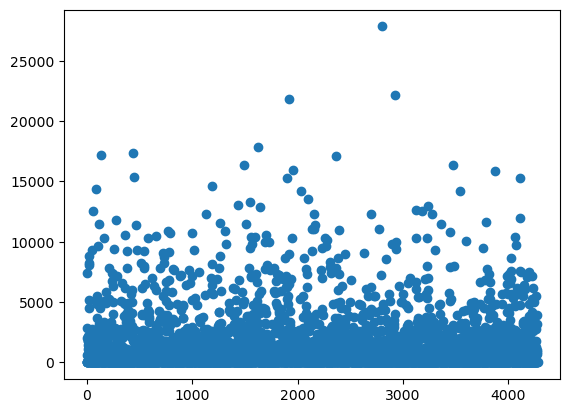

In [1389]:
y_2 = dt.Summ.to_list()
x_2 = dt.index
plt.scatter(x_2, y_2)

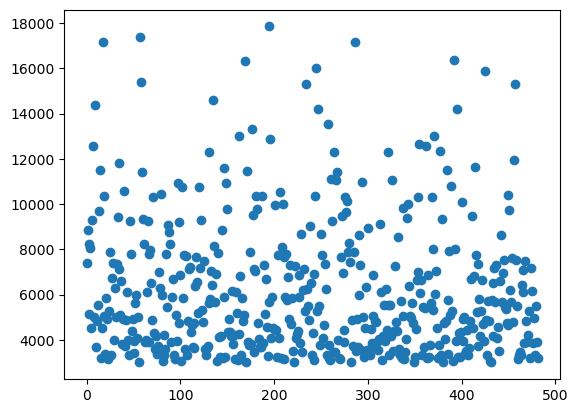

In [1390]:
summ = dt.Summ.to_numpy()
y_3 = summ[(summ <= 20000) & (summ > 3000)]
x_3 = np.arange(len(y_3))
plt.scatter(x_3, y_3)

In [1391]:
dt['Summ_Category_1'] = np.array(dt['Summ'] == 0, dtype=int)
dt['Summ_Category_2'] = np.array((dt['Summ'] > 0) & (dt['Summ'] <= 600), dtype=int)
dt['Summ_Category_3'] = np.array((dt['Summ'] > 600) & (dt['Summ'] <= 1000), dtype=int)
dt['Summ_Category_4'] = np.array((dt['Summ'] > 1000) & (dt['Summ'] <= 3000), dtype=int)
dt['Summ_Category_5'] = np.array((dt['Summ'] > 3000) & (dt['Summ'] <= 8000), dtype=int)
dt['Summ_Category_6'] = np.array((dt['Summ'] > 8000), dtype=int)

In [1392]:
dt = dt.astype({'Summ_Category_1': np.str_, 'Summ_Category_2': np.str_, 'Summ_Category_3': np.str_,
                'Summ_Category_4': np.str_, 'Summ_Category_5': np.str_, 'Summ_Category_6': np.str_})

In [1393]:
dt['Summ_Category'] = dt.Summ_Category_1 + dt.Summ_Category_2 + dt.Summ_Category_3 + dt.Summ_Category_4 + dt.Summ_Category_5 + dt.Summ_Category_6 


In [1394]:
dt.drop(columns=['Summ_Category_1', 'Summ_Category_2', 'Summ_Category_3', 
                 'Summ_Category_4', 'Summ_Category_5', 'Summ_Category_6', 'Summ'], inplace=True)

In [1395]:
dt.loc[dt.Summ_Category == '100000', 'Summ_Category'] = 0
dt.loc[dt.Summ_Category == '010000', 'Summ_Category'] = 1
dt.loc[dt.Summ_Category == '001000', 'Summ_Category'] = 2
dt.loc[dt.Summ_Category == '000100', 'Summ_Category'] = 3
dt.loc[dt.Summ_Category == '000010', 'Summ_Category'] = 4
dt.loc[dt.Summ_Category == '000001', 'Summ_Category'] = 5

In [1396]:
dt = dt.astype({'Summ_Category': np.int64})

In [1397]:
dt.drop(columns=['Summ_Category'], inplace=True)

In [1398]:
dt.head()

Groups HomePlanet CryoSleep  Destination  Age    VIP  RoomService  \
0      13      Earth      True  TRAPPIST-1e   27  False            0   
1      18      Earth     False  TRAPPIST-1e   19  False            0   
2      19     Europa      True  55 Cancri e   31  False            0   
3      21     Europa     False  TRAPPIST-1e   38  False            0   
4      23      Earth     False  TRAPPIST-1e   20  False           10   

   FoodCourt  ShoppingMall   Spa  VRDeck Deck  
0          0             0     0       0    G  
1          9             0  2823       0    F  
2          0             0     0       0    C  
3       6652             0   181     585    C  
4          0           635     0       0    F

In [1399]:
df.head()

Groups HomePlanet CryoSleep  Destination  Age    VIP  RoomService  \
0       1     Europa     False  TRAPPIST-1e   39  False            0   
1       2      Earth     False  TRAPPIST-1e   24  False          109   
2       3     Europa     False  TRAPPIST-1e   58   True           43   
3       3     Europa     False  TRAPPIST-1e   33  False            0   
4       4      Earth     False  TRAPPIST-1e   16  False          303   

   FoodCourt  ShoppingMall   Spa  VRDeck Deck  
0          0             0     0       0    B  
1          9            25   549      44    F  
2       3576             0  6715      49    A  
3       1283           371  3329     193    A  
4         70           151   565       2    F

In [1400]:
scaler_real_cols_test = pd.DataFrame(scaler.fit_transform(dt[real_cols]), columns=scaler.get_feature_names_out())
label_cat_cols_test = dt[cat_cols].apply(LabelEncoder().fit_transform)

In [1401]:
X_2 = pd.concat([scaler_real_cols_test, label_cat_cols_test], axis='columns')

In [1402]:
X_2

Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0    -0.117477    -0.380750  -0.317955     -0.373446 -0.288331 -0.299310   
1    -0.687472    -0.380750  -0.310786     -0.373446  2.568865 -0.299310   
2     0.167520    -0.380750  -0.317955     -0.373446 -0.288331 -0.299310   
3     0.666266    -0.380750   4.980198     -0.373446 -0.105138  0.388570   
4    -0.616223    -0.362799  -0.317955      1.172771 -0.288331 -0.299310   
...        ...          ...        ...           ...       ...       ...   
4272  0.381268    -0.380750  -0.317955     -0.373446 -0.288331 -0.299310   
4273  0.951263    -0.380750   0.356660     -0.332052 -0.278209 -0.129986   
4274  0.025021    -0.380750  -0.317955     -0.373446 -0.288331 -0.299310   
4275  0.381268    -0.380750   1.816599     -0.373446 -0.288331  0.315667   
4276  1.022512    -0.380750  -0.317955     -0.373446 -0.288331 -0.299310   

      HomePlanet  CryoSleep  Destination  VIP  Groups  Deck  
0              0          1            2    0       0     6  
1              0          0            2    0       1     5  
2              1          1            0    0       2     2  
3              1          0            2    0       3     2  
4              0          0            2    0       4     5  
...          ...        ...          ...  ...     ...   ...  
4272           0          1            2    0    3058     6  
4273           0          0            2    0    3059     6  
4274           2          1            0    0    3060     3  
4275           1          0            2    0    3061     3  
4276           0          1            1    0    3062     6  

[4277 rows x 12 columns]

In [1403]:
y_pred_2 = catboost.predict(dt)

In [1404]:
y_pred_2 = np.array(y_pred_2, dtype=bool)

In [1405]:
y_pred_2[5:11]

array([ True,  True,  True,  True,  True, False])

In [1406]:
submission = pd.read_csv('./sample_submission.csv')

In [1407]:
submission['Transported'] = y_pred_2

In [1408]:
submission.head()

PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True

In [1409]:
submission.to_csv('catboost_spaceship_25.csv', index=None)